In [42]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [43]:
L = 4 #system size
M = 0.1 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [44]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2 2>           80  
      1.         |2 2 2 1>           79  
      2.         |2 2 2 0>           78  
      3.         |2 2 1 2>           77  
      4.         |2 2 1 1>           76  
      5.         |2 2 1 0>           75  
      6.         |2 2 0 2>           74  
      7.         |2 2 0 1>           73  
      8.         |2 2 0 0>           72  
      9.         |2 1 2 2>           71  
     10.         |2 1 2 1>           70  
     11.         |2 1 2 0>           69  
     12.         |2 1 1 2>           68  
     13.         |2 1 1 1>           67  
     14.         |2 1 1 0>           66  
     15.         |2 1 0 2>           65  
     16.         |2 1 0 1>           64  
     17.         |2 1 0 0>           63  
     18.         |2 0 2 2>           62  
     19.         |2 0 2 1>           61  
     20.         |2 0 2 0>           60  
     21.         |2 0 1 2>           59  
     22

In [45]:
#initialisation of the Gauss laws
LL = 3 #number of sites-1
liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []


for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    
    
gauss_law_map.append([
    ["z",liste[0]],
    ["z",liste[3]],
])

gauss_law_map.append([
    ["z",liste[1]],
    ["z",liste_m[0]],
    ["I",liste[1]],
])

gauss_law_map.append([
    ["z",liste_m[2]],
    ["z",liste_m[1]],
])

gauss_law_map.append([
    ["z",liste_m[3]],
    ["z",liste[2]],
    ["I",liste[3]],
])

for i in range(LL+1):
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(LL+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [46]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [47]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [48]:
#projectors on g=1 for every site
Proj = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [49]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
a = np.zeros(2*l+1)
for i in range(2*l+1):
    a[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,a)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [50]:
D = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(4*l+1)
d[2*l] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(4*3+1)
for i in range(4*l+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [51]:
E = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(4*l+1)
e[2*l-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(4*3+1)
for i in range(4*l+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 1. 0. 0. 0.]


In [52]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(LL+1)]
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(LL/2)+1):
    for j in range(4*l+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [53]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []

interaction_p = []
interaction_m = []

phase = []
phase_ham = []

link_p = []
link_p_ham = []

link_m = []
link_m_ham = []

for i in range(L):
    const_term.append([[x[0],i]])
    linear_term.append([[x[1],i]])
    quadratic_term.append([[x[2],i,i]])
    cubic_term.append([[x[3],i,i,i]])
    quartic_term.append([[x[4],i,i,i,i]])
    quintic_term.append([[x[5],i,i,i,i,i]])
    sextic_term.append([[x[6],i,i,i,i,i,i]])


    phase.append([
        ["I", const_term[i]],
        ["z", linear_term[i]],
        ["zz", quadratic_term[i]],
        ["zzz", cubic_term[i]],
        ["zzzz", quartic_term[i]],
        ["zzzzz", quintic_term[i]],
        ["zzzzzz", sextic_term[i]],

    ])
    
    link_p.append([
    ["+",[[1./np.sqrt(l*(l+1)),i]]]  
    ])      
    
    link_m.append([
    ["-",[[1./np.sqrt(l*(l+1)),i]]]           
        
    ])
    
    phase_ham.append(hamiltonian(phase[i],dynamic_list=[],basis=basis,**no_checks))
    link_p_ham.append(hamiltonian(link_p[i],dynamic_list=[],basis=basis,**no_checks))
    link_m_ham.append(hamiltonian(link_m[i],dynamic_list=[],basis=basis,**no_checks))


    


kin_energy = [[0.5,i,i] for i in range(L)]

mass_term = []
mass_term.append([2*(-1)**0*M,0])
mass_term.append([2*(-1)**1*M,1])
mass_term.append([2*(-1)**1*M,2])
mass_term.append([2*(-1)**0*M,3])


kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

interaction = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L)]

interaction[0] = -0.5*(Proj[0]@phase_ham[0].tocsc()@link_p_ham[0].tocsc()@Proj[1]+Proj[1]@link_m_ham[0].tocsc()@phase_ham[0].tocsc()@Proj[0])
interaction[1] = 0.5*(Proj[1]@phase_ham[1].tocsc()@link_p_ham[1].tocsc()@Proj[2]+Proj[2]@link_m_ham[1].tocsc()@phase_ham[1].tocsc()@Proj[1])
interaction[2] = 0.5*(Proj[3]@phase_ham[1].tocsc()@phase_ham[2].tocsc()@link_p_ham[2].tocsc()@Proj[2]+Proj[2]@link_m_ham[2].tocsc()@phase_ham[2].tocsc()@phase_ham[1].tocsc()@Proj[3])
interaction[3] = -0.5*(Proj[0]@phase_ham[0].tocsc()@phase_ham[3].tocsc()@link_p_ham[3].tocsc()@Proj[3]+Proj[3]@link_m_ham[3].tocsc()@phase_ham[3].tocsc()@phase_ham[0].tocsc()@Proj[0])

plaquette = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(2)]

plaquette[0] = 0.5*(Proj_0[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj_0[3]+Proj_0[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj_0[3])

plaquette[1] = -0.5*(Proj[3]@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@link_p_ham[0].tocsc()@link_p_ham[1].tocsc()@link_m_ham[2].tocsc()@link_m_ham[3].tocsc()@Proj[3]+Proj[3]@link_p_ham[2].tocsc()@link_p_ham[3].tocsc()@link_m_ham[0].tocsc()@link_m_ham[1].tocsc()@phase_ham[0].tocsc()@phase_ham[1].tocsc()@phase_ham[2].tocsc()@phase_ham[3].tocsc()@Proj[3])

h_plaq = 0

for i in range(2):
    h_plaq += plaquette[i]

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_plaq + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(LL+1):
    full_ham_matrix = (Proj_0[i]+Proj[i])@full_ham_matrix@(Proj_0[i]+Proj[i])


G=0
for i in range(LL+1):
    G += 0.1*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [54]:
print(np.allclose(full_ham_matrix.toarray(), full_ham_matrix.toarray().T.conj(), rtol=1e-8, atol=1e-8))

True


In [55]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
string = ""
print(eigenval[eigenval<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])>=1e-5:
        string+=str(eigenvec[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"

[-9.29176933e-01 -3.13068105e-01 -7.93219714e-16]


In [56]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [57]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-0.92917693 -0.31306811  0.4       ]
(-0.06688279345138563+0.017086662292370432j)|2 2 0 1>
(0.15113600520485757-0.038610975228335766j)|2 2 0 0>
(-0.2736364863310347+0.06990638386250574j)|2 1 1 1>
(0.07307909607884064-0.018669642383260517j)|2 1 0 1>
(0.06688279345138559-0.017086662292370443j)|2 1 0 0>
(-0.27363648633103466+0.06990638386250562j)|1 1 1 2>
(0.7516426133522768-0.1920234313813498j)|1 1 1 1>
(-0.27363648633103477+0.06990638386250561j)|1 1 0 1>
(0.06688279345138558-0.017086662292370478j)|1 0 2 2>
(0.07307909607884061-0.01866964238326042j)|1 0 1 2>
(-0.27363648633103466+0.06990638386250558j)|1 0 1 1>
(0.15113600520485754-0.03861097522833575j)|0 0 2 2>
(-0.06688279345138565+0.017086662292370512j)|0 0 1 2>



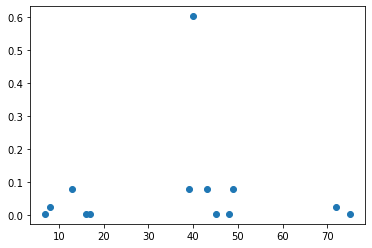

In [58]:
yy = []
xx = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-4:
        yy.append(np.abs(eigenvectors[:,0][i])**2) 
        xx.append(i)
plt.plot(xx,yy, "o")

In [59]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod




def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

In [60]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [ ]:
import optuna
n_iter = 6000
theta = np.zeros(5*N)

#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+0", -8*np.pi, 8*np.pi)
        theta[5*i+1] = trial.suggest_float("5*"+str(i)+"+1", -4*np.pi, 4*np.pi)
        theta[5*i+2] = trial.suggest_float("5*"+str(i)+"+2", -4*np.pi, 4*np.pi)
        theta[5*i+3] = trial.suggest_float("5*"+str(i)+"+3", -4*np.pi, 4*np.pi)
        theta[5*i+4] = trial.suggest_float("5*"+str(i)+"+4", -4*np.pi, 4*np.pi)
        
            
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,1,2,0,2*np.pi)@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,1,2,0,2*np.pi)@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var


    cost = np.conj(psi_var)@full_ham_matrix@psi_var
    return np.real(cost)

sampler = optuna.samplers.CmaEsSampler()
study = optuna.create_study(sampler=sampler)
study.optimize(cost_function_sigma, n_trials=n_iter)

[I 2022-05-02 14:48:21,371] A new study created in memory with name: no-name-88721156-fee7-48e3-8b77-905864061eb9
[I 2022-05-02 14:48:21,549] Trial 0 finished with value: 0.2966218404094767 and parameters: {'5*0+0': -7.325059263349232, '5*0+1': 9.9035760080524, '5*0+2': -3.4499383999863316, '5*0+3': 1.3876910206365416, '5*0+4': -12.049576930341935, '5*1+0': -20.576219981349738, '5*1+1': 12.431526368830838, '5*1+2': 7.935020552660831, '5*1+3': -7.545101896105995, '5*1+4': 5.488004731397595, '5*2+0': 11.524288690643672, '5*2+1': 4.774661329794359, '5*2+2': 4.39574797501356, '5*2+3': -3.0978558658720203, '5*2+4': 7.9441975229518995, '5*3+0': -7.016131261647367, '5*3+1': 11.92906086657133, '5*3+2': 12.266537441641884, '5*3+3': 9.613772801717321, '5*3+4': 5.7213166707194}. Best is trial 0 with value: 0.2966218404094767.
[I 2022-05-02 14:48:21,690] Trial 1 finished with value: 0.26313739123837715 and parameters: {'5*0+0': -0.7361562707272109, '5*0+1': -3.825348474564753, '5*0+2': -2.95226311

[I 2022-05-02 14:48:23,140] Trial 11 finished with value: 0.30902523045183833 and parameters: {'5*0+0': -2.715446067777453, '5*0+1': 4.572653962561678, '5*0+2': 1.8328825167710598, '5*0+3': 0.877235445870297, '5*0+4': -9.977001552201891, '5*1+0': 6.6002263859338175, '5*1+1': 9.294321773194367, '5*1+2': -5.816941350396088, '5*1+3': -0.4926032825019064, '5*1+4': 3.2692970419113476, '5*2+0': 3.8694124427319503, '5*2+1': -2.737559807076535, '5*2+2': -0.9928228606422246, '5*2+3': 1.0404084194061256, '5*2+4': 3.9057586714092385, '5*3+0': 9.75956460079603, '5*3+1': -4.984525013734042, '5*3+2': -2.2452867208164364, '5*3+3': -0.4322421633851897, '5*3+4': 1.541105549052808}. Best is trial 5 with value: 0.057246970784144965.
[I 2022-05-02 14:48:23,281] Trial 12 finished with value: 0.4161028945882703 and parameters: {'5*0+0': 0.5209362235463855, '5*0+1': 2.328214901963293, '5*0+2': -2.6814931095266687, '5*0+3': 4.446400459180406, '5*0+4': -4.267090725075925, '5*1+0': 2.6328404684109628, '5*1+1': 

[I 2022-05-02 14:48:24,804] Trial 23 finished with value: 0.1832810208697626 and parameters: {'5*0+0': -8.020018251684505, '5*0+1': -7.545134961922809, '5*0+2': -0.6206095970946595, '5*0+3': -2.2608882649961153, '5*0+4': 3.7426991293428302, '5*1+0': -3.269383683693214, '5*1+1': 8.369786678002402, '5*1+2': -4.041836151195047, '5*1+3': -9.658504378157474, '5*1+4': -5.027086243429146, '5*2+0': 6.880264979316319, '5*2+1': -0.6361872899762229, '5*2+2': 0.5268414573873231, '5*2+3': 3.7625035027074745, '5*2+4': -0.6308570931444937, '5*3+0': -2.1496826485929845, '5*3+1': -2.143113949280727, '5*3+2': -6.682858233338701, '5*3+3': -11.233446459093289, '5*3+4': -0.16970959530413987}. Best is trial 5 with value: 0.057246970784144965.
[I 2022-05-02 14:48:24,943] Trial 24 finished with value: 0.18616369438966018 and parameters: {'5*0+0': -5.770591966795857, '5*0+1': 1.05395250557277, '5*0+2': 1.1904445166000386, '5*0+3': -2.3977356978515854, '5*0+4': 1.1464868711232474, '5*1+0': -3.948198757440785, '

[I 2022-05-02 14:48:26,477] Trial 35 finished with value: 0.35193266064716044 and parameters: {'5*0+0': -5.003082981362196, '5*0+1': 0.2953148459564834, '5*0+2': -6.012679262647194, '5*0+3': 6.533037953247166, '5*0+4': 3.5956986942552747, '5*1+0': 3.7006399906184515, '5*1+1': 0.8987484386873628, '5*1+2': 3.4443516173768023, '5*1+3': -0.32675550164268063, '5*1+4': -0.21551131347466068, '5*2+0': -0.5200590928854039, '5*2+1': -4.0052208074206455, '5*2+2': -8.098117400800245, '5*2+3': 4.746397146368356, '5*2+4': -3.5209460559240084, '5*3+0': 0.1597095383033449, '5*3+1': -7.6897544612404065, '5*3+2': -8.444315949688999, '5*3+3': 2.7200383385944376, '5*3+4': 4.949956950584543}. Best is trial 5 with value: 0.057246970784144965.
[I 2022-05-02 14:48:26,612] Trial 36 finished with value: 0.18324577840422224 and parameters: {'5*0+0': -6.4152866010882805, '5*0+1': -2.4127305929436274, '5*0+2': 0.6745441561266445, '5*0+3': 10.100845296225202, '5*0+4': 2.488894129416686, '5*1+0': -1.7134280828268758

[I 2022-05-02 14:48:28,127] Trial 47 finished with value: 0.12497372362247205 and parameters: {'5*0+0': -4.329164972167986, '5*0+1': 9.861863041471615, '5*0+2': 7.592963950481751, '5*0+3': 2.6284694462127702, '5*0+4': 3.559687283231484, '5*1+0': -4.349039333519425, '5*1+1': -5.477562850867504, '5*1+2': -0.024032997406024936, '5*1+3': -2.2432173238679614, '5*1+4': -0.056776154156951364, '5*2+0': 5.354333978277683, '5*2+1': 0.12745340099838476, '5*2+2': -4.606028546067519, '5*2+3': 0.1657835748149763, '5*2+4': -3.7856873411678627, '5*3+0': -5.29283627034526, '5*3+1': -4.020149610092118, '5*3+2': 1.796975276001124, '5*3+3': 0.019719923496624325, '5*3+4': -4.668314554561001}. Best is trial 37 with value: 0.055785999957767216.
[I 2022-05-02 14:48:28,261] Trial 48 finished with value: 0.13164436239880706 and parameters: {'5*0+0': -9.877512601635663, '5*0+1': 0.011731478454536148, '5*0+2': 5.6274751142926585, '5*0+3': 2.1667035932970826, '5*0+4': 2.2442196373083196, '5*1+0': -1.15207426026873

[I 2022-05-02 14:48:29,786] Trial 59 finished with value: 0.20415675185574586 and parameters: {'5*0+0': 2.5138199515475574, '5*0+1': 5.670889716271786, '5*0+2': 12.309695858837104, '5*0+3': -0.01241154400924871, '5*0+4': -2.7104387731007824, '5*1+0': -1.3088729583407472, '5*1+1': -6.959543419867086, '5*1+2': -2.1714017284589415, '5*1+3': -0.33851572206896713, '5*1+4': -2.8228141759719327, '5*2+0': 0.4343890806062043, '5*2+1': -4.757231738504077, '5*2+2': -7.184026561309718, '5*2+3': 0.853864219829392, '5*2+4': -5.734985299555406, '5*3+0': -9.022469204085024, '5*3+1': -7.606605165585659, '5*3+2': 2.447519341091785, '5*3+3': -4.2947557390374715, '5*3+4': -8.149384033118597}. Best is trial 37 with value: 0.055785999957767216.
[I 2022-05-02 14:48:29,928] Trial 60 finished with value: 0.2638013451406025 and parameters: {'5*0+0': -3.4126911040881263, '5*0+1': 1.4513089693456886, '5*0+2': 9.026535286250033, '5*0+3': -3.2572647610878636, '5*0+4': -5.468928636824215, '5*1+0': 2.176695774650926,

[I 2022-05-02 14:48:31,464] Trial 71 finished with value: 0.12432538878175706 and parameters: {'5*0+0': -4.617298985587315, '5*0+1': 1.3211679928112496, '5*0+2': -0.4262041279003217, '5*0+3': -1.8374898260888246, '5*0+4': -7.391716989962641, '5*1+0': -9.379013535551007, '5*1+1': -3.0207932639659196, '5*1+2': 1.7493778763742935, '5*1+3': -0.635172587315437, '5*1+4': -0.7843779661509165, '5*2+0': -4.743305591094517, '5*2+1': 2.7212509346494524, '5*2+2': -6.886722897697812, '5*2+3': -4.513445228969497, '5*2+4': -6.767474157865681, '5*3+0': -8.621372610422345, '5*3+1': -1.7731798140647927, '5*3+2': -1.3317851280981332, '5*3+3': -6.347174915163576, '5*3+4': -4.047380416187769}. Best is trial 37 with value: 0.055785999957767216.
[I 2022-05-02 14:48:31,602] Trial 72 finished with value: 0.27710427990629927 and parameters: {'5*0+0': -2.9158867684688863, '5*0+1': -1.0680672413105081, '5*0+2': -0.24286829548048594, '5*0+3': 1.9192875613328726, '5*0+4': -1.5227457402772961, '5*1+0': -1.8566060947

[I 2022-05-02 14:48:33,154] Trial 83 finished with value: 0.16709578224384403 and parameters: {'5*0+0': -8.04697613656128, '5*0+1': -2.553764911252383, '5*0+2': 2.341593485366905, '5*0+3': 0.8013909323905405, '5*0+4': 2.0392560829015363, '5*1+0': -10.23168039910558, '5*1+1': -2.2235487429037843, '5*1+2': -2.847615426395559, '5*1+3': 6.1854569035283, '5*1+4': 8.853874529436483, '5*2+0': -3.333673690737867, '5*2+1': -2.5304612504606965, '5*2+2': -9.582291203995005, '5*2+3': -2.5533164907324766, '5*2+4': -8.983662027703122, '5*3+0': -9.084729460116817, '5*3+1': -1.5810204997009485, '5*3+2': -9.45893600110159, '5*3+3': -8.17809448109481, '5*3+4': -10.86423204119954}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:33,290] Trial 84 finished with value: 0.185569941770531 and parameters: {'5*0+0': -4.5288876494860135, '5*0+1': 0.15083443907236135, '5*0+2': -0.5630386009790947, '5*0+3': -7.51316582138595, '5*0+4': -2.205969487292058, '5*1+0': -3.8524174420782438, '5*1+1':

[I 2022-05-02 14:48:34,843] Trial 95 finished with value: 0.20471552735787893 and parameters: {'5*0+0': 3.698389467745737, '5*0+1': 4.571044934401777, '5*0+2': 3.8416409872264543, '5*0+3': 4.490867303896962, '5*0+4': -2.4353303745260257, '5*1+0': -5.615684592020876, '5*1+1': -7.95616367854625, '5*1+2': 7.0335416088963605, '5*1+3': 3.915455186692863, '5*1+4': 3.3211274687948507, '5*2+0': 4.600268839119539, '5*2+1': 2.071374628242067, '5*2+2': -4.136230471264164, '5*2+3': 0.6820332669820282, '5*2+4': -3.9302057764797436, '5*3+0': -9.295434260767967, '5*3+1': -4.339918691555004, '5*3+2': -11.27682902761764, '5*3+3': -0.5739597971414632, '5*3+4': -8.36601293567071}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:34,978] Trial 96 finished with value: 0.28712246980919154 and parameters: {'5*0+0': -1.55420518425931, '5*0+1': -0.5787924525508821, '5*0+2': 0.22729211841385866, '5*0+3': -0.8301192516006246, '5*0+4': -0.748219275354463, '5*1+0': -5.91142104165519, '5*1+1': 

[I 2022-05-02 14:48:36,559] Trial 107 finished with value: 0.3853341377587116 and parameters: {'5*0+0': 3.278827821782119, '5*0+1': 1.5620183524534874, '5*0+2': -2.9235996823993697, '5*0+3': 3.2981632379283488, '5*0+4': -0.02963834064408477, '5*1+0': -7.102187646214686, '5*1+1': -3.7560169936899763, '5*1+2': 6.555413684057928, '5*1+3': 4.400299411264293, '5*1+4': 2.9482259674606874, '5*2+0': 0.28042847243118096, '5*2+1': -1.9155008289283946, '5*2+2': -9.371350234071244, '5*2+3': -7.597095113622874, '5*2+4': -6.875048458084736, '5*3+0': -7.728806214812237, '5*3+1': -0.71881342470239, '5*3+2': 0.34238892247417585, '5*3+3': 0.7577215849223702, '5*3+4': -7.615665360047562}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:36,699] Trial 108 finished with value: 0.13679528622967146 and parameters: {'5*0+0': -0.8844270043810688, '5*0+1': -0.17501718114505693, '5*0+2': 2.3638343811856966, '5*0+3': 1.4773011109515104, '5*0+4': -0.17997176900348988, '5*1+0': -1.9552935445469

[I 2022-05-02 14:48:38,249] Trial 119 finished with value: 0.11025256667288186 and parameters: {'5*0+0': -7.295263546714246, '5*0+1': 1.0176905266494756, '5*0+2': 1.4863851949088658, '5*0+3': 1.4125744654286738, '5*0+4': 1.6958354105842326, '5*1+0': -8.225204416654893, '5*1+1': 4.204480347579295, '5*1+2': 8.624650916112026, '5*1+3': 5.130012571896311, '5*1+4': 4.310590930347144, '5*2+0': 0.7401142322067107, '5*2+1': 3.0581127634989245, '5*2+2': -7.077225085783615, '5*2+3': -5.904594285718408, '5*2+4': -9.1189456672909, '5*3+0': -8.064948887620014, '5*3+1': -6.281130555854778, '5*3+2': -2.3333285398425905, '5*3+3': 1.3521112854815083, '5*3+4': -2.8473118449803083}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:38,393] Trial 120 finished with value: 0.10861461158304384 and parameters: {'5*0+0': -3.0057977212600164, '5*0+1': 2.3808526701076898, '5*0+2': -1.0908733651831375, '5*0+3': 6.662528414175544, '5*0+4': -6.926249318548744, '5*1+0': -6.598284855082847, '5*1+1

[I 2022-05-02 14:48:39,974] Trial 131 finished with value: 0.13058140788907252 and parameters: {'5*0+0': 0.7666565958897817, '5*0+1': 3.341895620166456, '5*0+2': 0.415556569486053, '5*0+3': 9.349006012088541, '5*0+4': -8.21591666289699, '5*1+0': -7.493269686274306, '5*1+1': -5.034305496590084, '5*1+2': 9.053933354504412, '5*1+3': 5.654951932775342, '5*1+4': -1.1399317141159857, '5*2+0': -3.6108318111613134, '5*2+1': 8.674367149232191, '5*2+2': -10.098945959949827, '5*2+3': -0.3456558195494841, '5*2+4': -5.658044195775403, '5*3+0': -3.45197681584653, '5*3+1': -9.760519668402411, '5*3+2': -2.1457442286362522, '5*3+3': 5.974996295202466, '5*3+4': -8.276384579160068}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:40,121] Trial 132 finished with value: 0.15975292968214322 and parameters: {'5*0+0': 2.1767381450369854, '5*0+1': 4.247937470103604, '5*0+2': 3.6016151657098803, '5*0+3': 7.362794488791502, '5*0+4': -7.277406458404359, '5*1+0': -0.8106673426461954, '5*1+1':

[I 2022-05-02 14:48:41,758] Trial 143 finished with value: 0.06797956161939382 and parameters: {'5*0+0': 0.597711088415189, '5*0+1': 6.231854284360077, '5*0+2': 7.350167963971312, '5*0+3': 3.7230895347734, '5*0+4': 0.7963639693780276, '5*1+0': -5.295753708710955, '5*1+1': -6.895634968138481, '5*1+2': 4.676858476846062, '5*1+3': 2.9562911736807003, '5*1+4': 5.807747534552649, '5*2+0': 4.437570323392255, '5*2+1': 5.764411975304409, '5*2+2': -9.283899046107082, '5*2+3': 3.7620540233738007, '5*2+4': -5.10906206625641, '5*3+0': -3.690968481652274, '5*3+1': -7.075356758860772, '5*3+2': -7.029441243057551, '5*3+3': 6.728746370092482, '5*3+4': -3.948927800909581}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:41,896] Trial 144 finished with value: 0.24468429398660205 and parameters: {'5*0+0': 2.991272894740869, '5*0+1': -0.9642833904624539, '5*0+2': -0.5310236420536336, '5*0+3': 6.956256331678868, '5*0+4': -1.1387813301670586, '5*1+0': -2.0022017769368623, '5*1+1': -8.0

[I 2022-05-02 14:48:43,504] Trial 155 finished with value: 0.10110655295471567 and parameters: {'5*0+0': -3.080913639413984, '5*0+1': 7.726445777205283, '5*0+2': 7.460314515057289, '5*0+3': 6.1665842717634956, '5*0+4': -1.4476505273597862, '5*1+0': -1.4994534829734978, '5*1+1': -4.145486869210691, '5*1+2': 1.556818764869452, '5*1+3': 8.586615254574422, '5*1+4': 4.295850200808555, '5*2+0': 1.4586344052801332, '5*2+1': 4.204981466055369, '5*2+2': -6.594058020612303, '5*2+3': 3.530170499688256, '5*2+4': -5.906381692039722, '5*3+0': -5.180383128378215, '5*3+1': -5.032119191652402, '5*3+2': -5.96012515606332, '5*3+3': 1.3878689521821084, '5*3+4': -6.46149997516625}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:43,651] Trial 156 finished with value: 0.20554458822100508 and parameters: {'5*0+0': 4.996188821597756, '5*0+1': 11.11089377530044, '5*0+2': 5.889213830756551, '5*0+3': 2.410441315451855, '5*0+4': -2.555444850655222, '5*1+0': 2.265639291321688, '5*1+1': -7.595

[I 2022-05-02 14:48:45,240] Trial 167 finished with value: 0.2682136246416018 and parameters: {'5*0+0': 0.03392596837092432, '5*0+1': 5.086631154274624, '5*0+2': 9.641008338164403, '5*0+3': 7.610952007869896, '5*0+4': -7.161408168244478, '5*1+0': 0.7838767410901251, '5*1+1': -7.920275036954136, '5*1+2': 4.7016271144648325, '5*1+3': 6.687717716630731, '5*1+4': 3.717287391038356, '5*2+0': 4.28452307378904, '5*2+1': 5.4249932470305255, '5*2+2': -7.594096452191676, '5*2+3': 2.879345391269376, '5*2+4': -4.845345321455534, '5*3+0': -1.492451775537731, '5*3+1': 3.404737855283666, '5*3+2': -7.918375616669832, '5*3+3': 6.3229136508758765, '5*3+4': -3.600306787898324}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:45,381] Trial 168 finished with value: 0.2282870685307974 and parameters: {'5*0+0': 3.9581620318368014, '5*0+1': 3.2252089230953906, '5*0+2': 7.628238637944405, '5*0+3': 5.3226705258349085, '5*0+4': -7.350122702775941, '5*1+0': -0.5609161800543438, '5*1+1': -8.6

[I 2022-05-02 14:48:46,998] Trial 179 finished with value: 0.41544439007585 and parameters: {'5*0+0': -6.070667896791037, '5*0+1': 9.552233077245127, '5*0+2': 8.162844659015487, '5*0+3': 9.461814839268973, '5*0+4': -6.818673696400117, '5*1+0': -1.838798753289454, '5*1+1': -4.263991225446053, '5*1+2': 11.486169195002324, '5*1+3': 10.023080482035775, '5*1+4': 9.09340179059378, '5*2+0': 4.311139722251985, '5*2+1': 4.4093145736841395, '5*2+2': -9.646154204550813, '5*2+3': 6.467598468607787, '5*2+4': -9.429683556537718, '5*3+0': -7.95273922555094, '5*3+1': -4.484874428885058, '5*3+2': -8.288618780177366, '5*3+3': 4.392911557325051, '5*3+4': -9.725720313477025}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:47,145] Trial 180 finished with value: 0.1995130680716066 and parameters: {'5*0+0': 4.152407669327554, '5*0+1': 6.73812008056135, '5*0+2': 4.821742088139401, '5*0+3': 3.3174487742520773, '5*0+4': -4.998779000029707, '5*1+0': -2.244416026466568, '5*1+1': -6.93219222

[I 2022-05-02 14:48:48,739] Trial 191 finished with value: 0.16319849300579806 and parameters: {'5*0+0': 7.772918199238886, '5*0+1': 1.7993656016931465, '5*0+2': -2.1147372990903692, '5*0+3': 2.7620224777939018, '5*0+4': -4.9279490995831265, '5*1+0': 0.8866226713575358, '5*1+1': -4.820854898496968, '5*1+2': 8.546201523352188, '5*1+3': 0.38522776631809297, '5*1+4': 9.835788690080793, '5*2+0': 0.3623429377449062, '5*2+1': -5.205166056832605, '5*2+2': -5.17428365339354, '5*2+3': 9.27732972950037, '5*2+4': -5.584976601117314, '5*3+0': -5.548135752982899, '5*3+1': -1.95706303803849, '5*3+2': -3.951832994958205, '5*3+3': -1.308760636938123, '5*3+4': -6.692602055574621}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:48,877] Trial 192 finished with value: 0.3761082695921252 and parameters: {'5*0+0': 4.611281243075895, '5*0+1': 3.013446885009384, '5*0+2': -2.3951234067006366, '5*0+3': 1.1242471310306275, '5*0+4': -8.34685297360148, '5*1+0': 0.817988333988977, '5*1+1': 4.

[I 2022-05-02 14:48:50,445] Trial 203 finished with value: 0.15324685787532494 and parameters: {'5*0+0': -2.1863917984304266, '5*0+1': -1.391988741640355, '5*0+2': 0.08619240841374687, '5*0+3': -1.3274323414998994, '5*0+4': -3.726992238336131, '5*1+0': 3.72890107722166, '5*1+1': -2.3364808442774545, '5*1+2': 8.261069887803918, '5*1+3': 2.137850148144242, '5*1+4': 0.4690112910785835, '5*2+0': -1.999619945536363, '5*2+1': -0.05940029812004061, '5*2+2': -8.977737687629581, '5*2+3': 2.9785943042120255, '5*2+4': -6.01257960065572, '5*3+0': -2.756216193878936, '5*3+1': -2.626968956947327, '5*3+2': -6.252244578080406, '5*3+3': 0.8851750821121005, '5*3+4': -10.357352067217183}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:50,617] Trial 204 finished with value: 0.15859189489161055 and parameters: {'5*0+0': -3.7974440915676326, '5*0+1': 1.8860760942267834, '5*0+2': 0.5077928696971683, '5*0+3': -4.840157834593703, '5*0+4': -3.585404806402162, '5*1+0': -4.791239493050442, 

[I 2022-05-02 14:48:52,220] Trial 215 finished with value: 0.1414756739457738 and parameters: {'5*0+0': 1.0944725704091163, '5*0+1': 1.9446668071568467, '5*0+2': -0.5598324914092054, '5*0+3': -5.479841817642999, '5*0+4': -7.901376000698998, '5*1+0': 2.0677634646333476, '5*1+1': -3.3254147808627006, '5*1+2': 10.523760538951898, '5*1+3': 6.383158543142931, '5*1+4': 3.375482376525831, '5*2+0': -7.377089891226966, '5*2+1': 3.2373984985478312, '5*2+2': -6.809122131788589, '5*2+3': 10.065432348293657, '5*2+4': -10.692494771461085, '5*3+0': -4.142751129817937, '5*3+1': -4.900995467741507, '5*3+2': 0.3929237390541065, '5*3+3': -1.5368594982800805, '5*3+4': -10.570303449613803}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:52,357] Trial 216 finished with value: 0.1415269749686246 and parameters: {'5*0+0': 0.790493633435549, '5*0+1': 2.7949081374341445, '5*0+2': 3.7978737002121816, '5*0+3': -4.7884125743022246, '5*0+4': -0.07259567407692913, '5*1+0': 2.2147080469923477, 

[I 2022-05-02 14:48:53,905] Trial 227 finished with value: 0.20521057136459786 and parameters: {'5*0+0': -0.8786157295612624, '5*0+1': 6.789955235233872, '5*0+2': -2.2894363741746204, '5*0+3': -8.635529871523584, '5*0+4': 0.8485731975961981, '5*1+0': 4.514613161112921, '5*1+1': -2.8909086470445367, '5*1+2': 8.587782808006288, '5*1+3': 8.376534666891398, '5*1+4': 3.2046378660195236, '5*2+0': -3.8177254725489584, '5*2+1': 1.0610115466909664, '5*2+2': -7.9403797014165916, '5*2+3': 5.9918047852846765, '5*2+4': -5.096493493498023, '5*3+0': -7.434965217028097, '5*3+1': -2.815446992540457, '5*3+2': -2.9863416800111704, '5*3+3': -1.897140914460456, '5*3+4': -11.443397122473545}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:54,044] Trial 228 finished with value: 0.5947482276548717 and parameters: {'5*0+0': 0.8561881467945116, '5*0+1': 1.4574303111498148, '5*0+2': -1.6862154327321763, '5*0+3': -4.812213042681528, '5*0+4': -3.4878571852116633, '5*1+0': 2.6768530724414097,

[I 2022-05-02 14:48:55,627] Trial 239 finished with value: 0.14586881936933788 and parameters: {'5*0+0': -1.953595775967014, '5*0+1': 7.254160933361812, '5*0+2': 2.033363966595667, '5*0+3': -2.1201215838592162, '5*0+4': -4.564589586477319, '5*1+0': -0.45842656138745586, '5*1+1': -3.0445111581861424, '5*1+2': 9.542725864188379, '5*1+3': -1.592697590600907, '5*1+4': 3.196479184212678, '5*2+0': -4.054193763335832, '5*2+1': 0.6828139094652104, '5*2+2': -10.480197827424709, '5*2+3': 10.692331089170338, '5*2+4': -2.8638306113518124, '5*3+0': -7.536595594014548, '5*3+1': -4.4834013706813245, '5*3+2': -5.046720832132537, '5*3+3': -2.6195970717022954, '5*3+4': -5.940723986021046}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:55,764] Trial 240 finished with value: 0.21501673396977838 and parameters: {'5*0+0': -3.843106532464269, '5*0+1': 1.9308677784034394, '5*0+2': -9.666323845457939, '5*0+3': -2.117104713571869, '5*0+4': -6.518084503097293, '5*1+0': -1.6376446332281476

[I 2022-05-02 14:48:57,376] Trial 251 finished with value: 0.22547238985647083 and parameters: {'5*0+0': 1.6425770382309284, '5*0+1': 3.991908354184389, '5*0+2': -3.734416240489905, '5*0+3': -0.2049288534972602, '5*0+4': -4.841348639067835, '5*1+0': -1.8082826082849472, '5*1+1': 1.2944937665485252, '5*1+2': 5.8009074268182825, '5*1+3': 0.7091615012548871, '5*1+4': 4.419227180951114, '5*2+0': -0.7405739106938656, '5*2+1': 0.6902771183443424, '5*2+2': -9.471903015206774, '5*2+3': 5.359031394985804, '5*2+4': -1.605233494678246, '5*3+0': -7.11343621472958, '5*3+1': -2.3595527555962064, '5*3+2': -0.012799729051475417, '5*3+3': 0.1603893883177956, '5*3+4': -7.858834799303532}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:57,512] Trial 252 finished with value: 0.17209894497004422 and parameters: {'5*0+0': -5.375101073276374, '5*0+1': -3.718393976134834, '5*0+2': -6.462173088084063, '5*0+3': -0.9387813718344074, '5*0+4': -0.6603035140160287, '5*1+0': 7.212747070850036,

[I 2022-05-02 14:48:59,131] Trial 263 finished with value: 0.21634880869311687 and parameters: {'5*0+0': -8.822536905335635, '5*0+1': 0.8308876975550143, '5*0+2': -1.3085086930781538, '5*0+3': -4.001104372342286, '5*0+4': -3.316893409066465, '5*1+0': -1.6932787191964844, '5*1+1': 1.8896081382594292, '5*1+2': 8.375428831976258, '5*1+3': -5.048191518540835, '5*1+4': 8.77234351084508, '5*2+0': -2.2294712062975943, '5*2+1': 0.5189961667960121, '5*2+2': -2.8434333178689655, '5*2+3': 8.856368240128747, '5*2+4': -9.609874502213904, '5*3+0': -4.560076690429024, '5*3+1': 0.6899935859294031, '5*3+2': -8.685846939607826, '5*3+3': -7.660964316353191, '5*3+4': -10.11613180930242}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:48:59,277] Trial 264 finished with value: 0.1122986210305478 and parameters: {'5*0+0': -6.429981727887753, '5*0+1': -6.379036520152217, '5*0+2': -5.747836501197834, '5*0+3': -5.899248877648995, '5*0+4': -3.8366209810225342, '5*1+0': 6.559819066876805, '5*1

[I 2022-05-02 14:49:00,852] Trial 275 finished with value: 0.20827431644541194 and parameters: {'5*0+0': -5.76058957125171, '5*0+1': -0.2866546807476511, '5*0+2': -7.761379307306688, '5*0+3': -9.021066049925679, '5*0+4': 0.6589287041250902, '5*1+0': 0.10483234602886204, '5*1+1': 1.31596406280851, '5*1+2': 6.575362632419599, '5*1+3': 5.3915668236907885, '5*1+4': 7.501661767067505, '5*2+0': -3.992752084751764, '5*2+1': 0.6969985880989338, '5*2+2': -5.772360674144227, '5*2+3': 6.265699107740009, '5*2+4': -4.7904207601897175, '5*3+0': -2.8209096544102765, '5*3+1': -1.4140163731003956, '5*3+2': -8.634362588085313, '5*3+3': -4.8123332446659495, '5*3+4': -5.852159337526564}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:49:00,996] Trial 276 finished with value: 0.20476401868117833 and parameters: {'5*0+0': -3.0684636143518706, '5*0+1': -4.629581866416063, '5*0+2': -3.047475479820081, '5*0+3': -8.488001423732499, '5*0+4': -4.827014085522884, '5*1+0': 7.003843000166123, '5*

[I 2022-05-02 14:49:02,545] Trial 287 finished with value: 0.27484421520193825 and parameters: {'5*0+0': -7.944267757429817, '5*0+1': -3.007983796557682, '5*0+2': 0.8835653699840851, '5*0+3': -8.889174197944484, '5*0+4': -0.45751895592739356, '5*1+0': -1.826934468296737, '5*1+1': 1.2591300332902227, '5*1+2': 9.783858041562501, '5*1+3': -0.10282587528609866, '5*1+4': 8.044781422697637, '5*2+0': -3.6659356961468825, '5*2+1': -3.3448103380251153, '5*2+2': -0.6061579292213573, '5*2+3': 0.9983983344494121, '5*2+4': -7.915703210986949, '5*3+0': -3.2874839430050393, '5*3+1': -9.788583599158649, '5*3+2': -7.4679302626859805, '5*3+3': -7.244325533177861, '5*3+4': -4.103474574909937}. Best is trial 74 with value: 0.03845889099782139.
[I 2022-05-02 14:49:02,686] Trial 288 finished with value: 0.12896679758333904 and parameters: {'5*0+0': -8.11635871497697, '5*0+1': 2.317241012450623, '5*0+2': -1.2855334631995452, '5*0+3': -3.623026954558696, '5*0+4': -2.0675813621125156, '5*1+0': 3.89969717151871

[I 2022-05-02 14:49:04,271] Trial 299 finished with value: 0.1282564715663463 and parameters: {'5*0+0': -2.0294762465333616, '5*0+1': -3.0851041281212632, '5*0+2': 4.618535443261907, '5*0+3': -4.820447519601059, '5*0+4': -2.389835975254399, '5*1+0': 1.5955478061076238, '5*1+1': 0.4516362153198889, '5*1+2': 9.563816926574749, '5*1+3': -3.96755641795642, '5*1+4': 10.417028304863496, '5*2+0': -1.9179411421464716, '5*2+1': -1.4904383317048344, '5*2+2': -1.1683237242749809, '5*2+3': 1.6455050351332177, '5*2+4': -5.303394194298097, '5*3+0': -2.1925496591349045, '5*3+1': -6.860475979592524, '5*3+2': -5.516433578635866, '5*3+3': 0.20760744481587157, '5*3+4': -9.5581630134646}. Best is trial 298 with value: 0.02759879318119319.
[I 2022-05-02 14:49:04,416] Trial 300 finished with value: 0.2034824247419473 and parameters: {'5*0+0': -4.043811108770086, '5*0+1': -6.294750119618315, '5*0+2': 4.886240325591254, '5*0+3': -4.270627230547662, '5*0+4': -5.795278520550204, '5*1+0': -2.384228389030641, '5*

[I 2022-05-02 14:49:06,102] Trial 311 finished with value: 0.09843763349227877 and parameters: {'5*0+0': -3.838968099834413, '5*0+1': -3.9889557059065277, '5*0+2': -0.42613429786852186, '5*0+3': -5.01829047134561, '5*0+4': -6.30642853075642, '5*1+0': -1.9125858776201747, '5*1+1': 0.950207034862945, '5*1+2': 8.262177304474276, '5*1+3': -2.666581725914603, '5*1+4': 11.699769482945392, '5*2+0': -4.3718834187727325, '5*2+1': -3.5144555496708256, '5*2+2': -3.48863280222215, '5*2+3': 3.9710481858985496, '5*2+4': -5.7485740868567055, '5*3+0': -1.5483406187259878, '5*3+1': -2.5585100638694223, '5*3+2': -6.87543665663555, '5*3+3': 0.04825634915883725, '5*3+4': -11.006096028865134}. Best is trial 298 with value: 0.02759879318119319.
[I 2022-05-02 14:49:06,260] Trial 312 finished with value: 0.11379030064436654 and parameters: {'5*0+0': -4.157144401982192, '5*0+1': -5.331023833145062, '5*0+2': 0.017298000387486356, '5*0+3': -2.7603649404480937, '5*0+4': -8.425851654975398, '5*1+0': 2.115964518968

[I 2022-05-02 14:49:07,888] Trial 323 finished with value: 0.19883447119661174 and parameters: {'5*0+0': -4.749368676340181, '5*0+1': -3.345314323259225, '5*0+2': 0.09791973523527958, '5*0+3': -4.374476335373398, '5*0+4': -6.882381183753383, '5*1+0': 4.348959457682654, '5*1+1': 0.40139088028033565, '5*1+2': 5.007115345349342, '5*1+3': -0.5508881084674344, '5*1+4': 5.268820336775084, '5*2+0': -2.8392304108121134, '5*2+1': -2.8387611836596056, '5*2+2': -0.48037369061157054, '5*2+3': 4.5145194149451155, '5*2+4': -4.682967000847986, '5*3+0': -2.1295450479607245, '5*3+1': 0.5240179980586026, '5*3+2': -6.994842075501039, '5*3+3': 0.20276571853178482, '5*3+4': -10.270210742899703}. Best is trial 298 with value: 0.02759879318119319.
[I 2022-05-02 14:49:08,032] Trial 324 finished with value: 0.15132483650822262 and parameters: {'5*0+0': -2.3124067212128576, '5*0+1': -4.536660034532048, '5*0+2': 0.21859666481719103, '5*0+3': -6.557758856014834, '5*0+4': -7.051243476064785, '5*1+0': -0.4902653751

[I 2022-05-02 14:49:09,484] Trial 334 finished with value: 0.10410225488880975 and parameters: {'5*0+0': -2.9272019292107223, '5*0+1': -5.094829896584828, '5*0+2': -4.751456999810133, '5*0+3': -3.4544379284216107, '5*0+4': -7.751796088346415, '5*1+0': 6.717864359820197, '5*1+1': 3.543699625163499, '5*1+2': 7.901641518701453, '5*1+3': -2.8037773083905044, '5*1+4': 6.517106095226962, '5*2+0': -4.455703117548517, '5*2+1': -9.000926119852954, '5*2+2': 0.6437135504640319, '5*2+3': 7.215099058288, '5*2+4': -5.179666374084066, '5*3+0': -2.696093631490624, '5*3+1': -1.830749704318577, '5*3+2': -4.493271526090082, '5*3+3': -0.5542788032404437, '5*3+4': -9.200429662438873}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:09,654] Trial 335 finished with value: 0.1726212570835975 and parameters: {'5*0+0': -4.503487128434834, '5*0+1': -6.04233407172526, '5*0+2': -3.5580874802463094, '5*0+3': -1.4655650434312548, '5*0+4': -4.110799911968067, '5*1+0': -4.171327341566709, '5*1+

[I 2022-05-02 14:49:11,283] Trial 346 finished with value: 0.2211624380708127 and parameters: {'5*0+0': -0.18572902646455414, '5*0+1': -6.959833968246479, '5*0+2': 1.2568138266929783, '5*0+3': 0.963681902070852, '5*0+4': -2.8044362015533264, '5*1+0': -1.9659314250485833, '5*1+1': 6.098970077364077, '5*1+2': 2.647011826694529, '5*1+3': -5.589346744331473, '5*1+4': 1.5693523808563326, '5*2+0': 0.6942178538796704, '5*2+1': -3.8304046076666505, '5*2+2': -3.7494838464271543, '5*2+3': 1.4593976218272617, '5*2+4': -4.545328809620489, '5*3+0': -3.0733904051463696, '5*3+1': -5.022050710166056, '5*3+2': -5.376352542061145, '5*3+3': -2.275657476765437, '5*3+4': -7.928146410121706}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:11,425] Trial 347 finished with value: 0.21657013293934294 and parameters: {'5*0+0': -0.6524690993262929, '5*0+1': -3.7666638679939943, '5*0+2': 2.2875840700896344, '5*0+3': 0.9450560201740976, '5*0+4': -5.410343339815678, '5*1+0': 1.24811540404422

[I 2022-05-02 14:49:12,976] Trial 358 finished with value: 0.11890485158517536 and parameters: {'5*0+0': 1.4478327191572675, '5*0+1': -2.7374557887990774, '5*0+2': -1.1228098469377832, '5*0+3': -5.446163710332878, '5*0+4': -3.5740676628819092, '5*1+0': -3.3099607823390915, '5*1+1': 5.083822202880431, '5*1+2': 8.800390732011591, '5*1+3': 0.7237871159044115, '5*1+4': 4.119821324952998, '5*2+0': -1.063421339401145, '5*2+1': -0.8059127858073318, '5*2+2': -1.198705355085152, '5*2+3': 5.588095829994859, '5*2+4': -8.59944138179005, '5*3+0': -3.79576941292265, '5*3+1': -0.3652718045485661, '5*3+2': -3.784391937945139, '5*3+3': -0.40736296853031667, '5*3+4': -10.421935495743227}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:13,117] Trial 359 finished with value: 0.13392962099794564 and parameters: {'5*0+0': -0.3261433134826681, '5*0+1': -2.587707702780594, '5*0+2': 1.017097263397571, '5*0+3': 0.6067027318792344, '5*0+4': -0.716269879944937, '5*1+0': -2.918405387608394

[I 2022-05-02 14:49:14,670] Trial 370 finished with value: 0.20239020528559495 and parameters: {'5*0+0': -1.4917929654965287, '5*0+1': -5.441676899455855, '5*0+2': -2.627419856813574, '5*0+3': -2.4798272874959393, '5*0+4': -6.481705775028087, '5*1+0': 2.3597259087494638, '5*1+1': 3.3845388419764753, '5*1+2': 5.01322350326884, '5*1+3': 5.705773447771331, '5*1+4': 5.7660261846037475, '5*2+0': -0.1907455571581822, '5*2+1': -5.7376551261485025, '5*2+2': -0.3841180120099217, '5*2+3': 8.15541831984516, '5*2+4': -6.640904092663716, '5*3+0': -6.4938294867908555, '5*3+1': 0.6918931534044195, '5*3+2': -9.110160307157003, '5*3+3': -2.1915584994054957, '5*3+4': -9.800833649538014}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:14,814] Trial 371 finished with value: 0.20031788105968823 and parameters: {'5*0+0': -3.0271421364691102, '5*0+1': -4.76780419309208, '5*0+2': -1.4184930364026513, '5*0+3': -0.622048760681307, '5*0+4': -6.561025278995201, '5*1+0': 1.0550122505379644

[I 2022-05-02 14:49:16,356] Trial 382 finished with value: 0.05340015628255496 and parameters: {'5*0+0': 0.9691839973695713, '5*0+1': -4.505193475016741, '5*0+2': -0.21591181266624648, '5*0+3': -0.9577011881899413, '5*0+4': -3.1792420139800024, '5*1+0': -2.518564042345978, '5*1+1': 2.0416364716534128, '5*1+2': 7.9805683499854085, '5*1+3': 2.762166281808411, '5*1+4': 4.319561563712441, '5*2+0': 1.590423474170862, '5*2+1': -4.013978071404869, '5*2+2': 4.625591765682711, '5*2+3': 5.4404663667207505, '5*2+4': -9.84146605207013, '5*3+0': -4.3916784679564085, '5*3+1': -2.5530205968526523, '5*3+2': -6.168583469105111, '5*3+3': 1.7107515826741315, '5*3+4': -9.029179926932393}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:16,498] Trial 383 finished with value: 1.0028775216263757 and parameters: {'5*0+0': -0.7882599596670705, '5*0+1': -6.227002460866453, '5*0+2': -2.1771676999724683, '5*0+3': -0.8627195187726988, '5*0+4': -0.7226037080748517, '5*1+0': 2.386471630470498

[I 2022-05-02 14:49:18,055] Trial 394 finished with value: 0.15214482435399532 and parameters: {'5*0+0': 3.6188980527985253, '5*0+1': -4.674288512045564, '5*0+2': -0.2609232390343643, '5*0+3': -5.301533859233306, '5*0+4': -0.8231832024831527, '5*1+0': -3.657407288902936, '5*1+1': 3.9068787959931806, '5*1+2': 7.726563609081866, '5*1+3': 4.634847555804868, '5*1+4': 8.113312599794384, '5*2+0': -1.1964482534987164, '5*2+1': -3.7520549990512384, '5*2+2': 0.3433670123628494, '5*2+3': 7.59455088634105, '5*2+4': -8.563353696277542, '5*3+0': -2.2532133124847107, '5*3+1': -3.2021632564869775, '5*3+2': -4.2276057788742625, '5*3+3': 0.8260787778613485, '5*3+4': -7.53678829779703}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:18,198] Trial 395 finished with value: 0.1374122890799276 and parameters: {'5*0+0': 2.6686126787055313, '5*0+1': -4.175127930343221, '5*0+2': -3.3038484776266954, '5*0+3': -2.8305284769331625, '5*0+4': -3.050968112458931, '5*1+0': -0.0656638719921511

[I 2022-05-02 14:49:19,765] Trial 406 finished with value: 0.23013889738695464 and parameters: {'5*0+0': 5.560378101303208, '5*0+1': -2.9949194077657117, '5*0+2': 2.6958010572021225, '5*0+3': -4.376967867595228, '5*0+4': 0.8897583603689987, '5*1+0': 3.490324678869709, '5*1+1': 7.230788268565595, '5*1+2': 10.678509258519718, '5*1+3': 5.065093145569168, '5*1+4': 6.349469959018389, '5*2+0': -0.8056202735748832, '5*2+1': -0.3869524852717001, '5*2+2': 2.5686510143160115, '5*2+3': 8.451243490050915, '5*2+4': -10.033666684201735, '5*3+0': -4.609767161314053, '5*3+1': -0.8260530162425311, '5*3+2': -8.620438588755308, '5*3+3': 2.953855713309249, '5*3+4': -6.887341061900882}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:19,910] Trial 407 finished with value: 0.1767932487012869 and parameters: {'5*0+0': 3.7956358551371405, '5*0+1': -6.896227917149869, '5*0+2': -4.413063886268276, '5*0+3': -6.7233347201384355, '5*0+4': 0.34368271813340767, '5*1+0': -0.3042488285595981, '

[I 2022-05-02 14:49:21,474] Trial 418 finished with value: 0.15096465554260396 and parameters: {'5*0+0': -1.4112810034871557, '5*0+1': -6.898526180145481, '5*0+2': -2.6475081733158743, '5*0+3': -6.279115970084464, '5*0+4': 0.2105188463115253, '5*1+0': 2.2134943001264897, '5*1+1': -0.47161316886933546, '5*1+2': 8.642317262581695, '5*1+3': -0.19044852413480262, '5*1+4': 1.9847007448424836, '5*2+0': -3.8395704507527935, '5*2+1': -2.564725385848795, '5*2+2': 2.946453579944234, '5*2+3': 9.91714001997091, '5*2+4': -11.493576948719847, '5*3+0': -2.343691847144583, '5*3+1': -3.4708860695371744, '5*3+2': -8.200044255602618, '5*3+3': -1.4837735645791483, '5*3+4': -7.898387546282654}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:21,620] Trial 419 finished with value: 0.09880231139572554 and parameters: {'5*0+0': -1.7117513641741473, '5*0+1': -3.8666180684831057, '5*0+2': 1.3543405158643438, '5*0+3': -8.450799522009056, '5*0+4': -3.9916588448827746, '5*1+0': 2.3420089946

[I 2022-05-02 14:49:23,350] Trial 430 finished with value: 0.18802612280161585 and parameters: {'5*0+0': -0.9414899554223, '5*0+1': -3.9179545716874964, '5*0+2': -6.180152773366411, '5*0+3': -7.667404602228714, '5*0+4': -1.87785862964928, '5*1+0': 1.3195391901191993, '5*1+1': 4.780472322151356, '5*1+2': 8.255700473294558, '5*1+3': 5.136048793516363, '5*1+4': 2.6454318983571996, '5*2+0': -0.3345910712009612, '5*2+1': -6.4923860346711795, '5*2+2': 3.082630225675369, '5*2+3': 5.24770041145092, '5*2+4': -10.611335756757747, '5*3+0': -5.308492346423893, '5*3+1': 1.3137362638870813, '5*3+2': -5.829687328813462, '5*3+3': -1.7115230991356762, '5*3+4': -9.60192913899899}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:23,493] Trial 431 finished with value: 0.3727757863443393 and parameters: {'5*0+0': 1.3251062709585448, '5*0+1': -9.6945897684867, '5*0+2': 0.23646144945861747, '5*0+3': -3.5110703084893027, '5*0+4': -2.151099918425608, '5*1+0': 4.353914263782487, '5*1+1':

[I 2022-05-02 14:49:25,097] Trial 442 finished with value: 0.21007345809098868 and parameters: {'5*0+0': -1.7485716407904708, '5*0+1': -8.450036107509979, '5*0+2': -0.701544424368687, '5*0+3': -3.5400442731829687, '5*0+4': -2.36795444946452, '5*1+0': 1.6252956461538597, '5*1+1': 2.6208810019680886, '5*1+2': 6.6488653783055405, '5*1+3': 2.314241618256974, '5*1+4': 0.8855086566720463, '5*2+0': -4.488349844081314, '5*2+1': -3.3896628449115136, '5*2+2': 7.844320218867917, '5*2+3': 6.241103726396895, '5*2+4': -10.13428417841083, '5*3+0': -4.3809226182222165, '5*3+1': -0.6048750302044851, '5*3+2': -5.568401318795312, '5*3+3': 0.7380619665158963, '5*3+4': -8.075619184636826}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:25,241] Trial 443 finished with value: 0.11703178574673373 and parameters: {'5*0+0': 1.8787394784732547, '5*0+1': -7.2613049417027975, '5*0+2': -2.7148268272101106, '5*0+3': -4.436007227436546, '5*0+4': -2.175157017583456, '5*1+0': 3.083229723816593,

[I 2022-05-02 14:49:26,806] Trial 454 finished with value: 0.25979077884966806 and parameters: {'5*0+0': -2.7112654128463225, '5*0+1': -10.70224293937827, '5*0+2': 5.146145437333484, '5*0+3': -4.032685652443125, '5*0+4': -2.989450953607559, '5*1+0': 8.249060445851072, '5*1+1': 1.9292377268445517, '5*1+2': 5.922923519016868, '5*1+3': 2.7162414461068067, '5*1+4': 6.3652972071376315, '5*2+0': -2.81702267266402, '5*2+1': -4.927887606578314, '5*2+2': 4.177561105127076, '5*2+3': 0.2445641036122832, '5*2+4': -3.869879101397858, '5*3+0': -1.2937888960630342, '5*3+1': -2.3492998826199822, '5*3+2': -9.257044639653373, '5*3+3': 6.06921725209501, '5*3+4': -7.128595704366341}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:26,955] Trial 455 finished with value: 0.09376679749959989 and parameters: {'5*0+0': -3.159071270696834, '5*0+1': -9.074226675396984, '5*0+2': -1.3723046763958016, '5*0+3': -6.543119633715203, '5*0+4': -2.866747397519881, '5*1+0': 7.525148131206051, '5*1+

[I 2022-05-02 14:49:28,555] Trial 466 finished with value: 0.13104502277590155 and parameters: {'5*0+0': -2.9567293526409726, '5*0+1': -8.461026247632828, '5*0+2': 1.5993036767922375, '5*0+3': -5.4038006304688935, '5*0+4': -2.9813197876188844, '5*1+0': 5.5200536541583025, '5*1+1': 6.507560741187489, '5*1+2': 9.71013555254445, '5*1+3': 3.3944677267272265, '5*1+4': 1.7372707235092784, '5*2+0': 1.4656045066947443, '5*2+1': -4.964669573683109, '5*2+2': 5.3971102811435205, '5*2+3': 6.33984318061839, '5*2+4': -8.844709267218525, '5*3+0': -0.6704105168339556, '5*3+1': -2.847683245323655, '5*3+2': -7.794322472843203, '5*3+3': 2.0626907514919357, '5*3+4': -8.894992670293238}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:28,698] Trial 467 finished with value: 0.10224103500299805 and parameters: {'5*0+0': 0.2829193330802313, '5*0+1': -10.148477473758291, '5*0+2': -0.05721631917533587, '5*0+3': -5.205492979412948, '5*0+4': -2.8359395448724785, '5*1+0': 3.089784804936851,

[I 2022-05-02 14:49:30,293] Trial 478 finished with value: 0.11744864099297606 and parameters: {'5*0+0': -2.9921511404707086, '5*0+1': -9.700109982769499, '5*0+2': 1.675500459280077, '5*0+3': -0.49776215977146165, '5*0+4': -0.33555353240813535, '5*1+0': 5.125711792889523, '5*1+1': 6.498970134144312, '5*1+2': 7.32340080140823, '5*1+3': 4.19896891463493, '5*1+4': 2.27072943189774, '5*2+0': -2.707758294667833, '5*2+1': -2.7036480422716966, '5*2+2': 7.205822524380649, '5*2+3': 3.531126480799816, '5*2+4': -9.577610251256356, '5*3+0': -1.5057565682962226, '5*3+1': -0.5344472428425306, '5*3+2': -9.23988008720618, '5*3+3': 0.6089067736361322, '5*3+4': -7.9056111126745945}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:30,435] Trial 479 finished with value: 0.10608362921220008 and parameters: {'5*0+0': -0.5254334541783883, '5*0+1': -5.51631176620139, '5*0+2': -2.8639105175433937, '5*0+3': -6.058106874260129, '5*0+4': -2.4688186427807386, '5*1+0': 2.8653604342244856, '5

[I 2022-05-02 14:49:32,038] Trial 490 finished with value: 0.21387217737947634 and parameters: {'5*0+0': -3.081705359871997, '5*0+1': -7.193740485261115, '5*0+2': 1.3352889836305493, '5*0+3': -7.567202895492516, '5*0+4': -1.041938600543693, '5*1+0': 2.14423032847216, '5*1+1': 8.281552150357808, '5*1+2': 5.483955063203311, '5*1+3': 4.90112369500892, '5*1+4': 1.3511914915473833, '5*2+0': 2.6866741865622927, '5*2+1': 0.5153909769089782, '5*2+2': 7.264413255665289, '5*2+3': 7.3431642850991885, '5*2+4': -11.313148550677951, '5*3+0': -3.272397842049042, '5*3+1': -0.3593529693607487, '5*3+2': -7.91359644988475, '5*3+3': 2.049405202751632, '5*3+4': -8.024138628430707}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:32,181] Trial 491 finished with value: 0.14023836612140966 and parameters: {'5*0+0': -3.6505802420641476, '5*0+1': -6.547616092918087, '5*0+2': 2.6608052250628447, '5*0+3': -2.7180135149452416, '5*0+4': -7.588526414798094, '5*1+0': 8.333741014270233, '5*1+1'

[I 2022-05-02 14:49:33,798] Trial 502 finished with value: 0.14275307715360153 and parameters: {'5*0+0': 0.22653468197946758, '5*0+1': -11.938895825795825, '5*0+2': -1.7981193765577888, '5*0+3': -7.319851593362025, '5*0+4': 1.030203957668518, '5*1+0': 5.513149845071607, '5*1+1': 7.2034038112358925, '5*1+2': 3.2542994476682, '5*1+3': 1.2080262764247531, '5*1+4': 2.4284324686492025, '5*2+0': -0.24725161100792714, '5*2+1': -7.267054432285208, '5*2+2': 7.717037794808956, '5*2+3': 9.495987316535693, '5*2+4': -9.582305094815759, '5*3+0': -5.352870093923558, '5*3+1': 4.2013951125706415, '5*3+2': -7.267335097661045, '5*3+3': -0.3236440420246094, '5*3+4': -4.895892352877414}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:33,944] Trial 503 finished with value: 0.10353129911252079 and parameters: {'5*0+0': -1.1103172869754165, '5*0+1': -11.638893761563939, '5*0+2': 3.073142836532371, '5*0+3': -4.651452616824917, '5*0+4': -0.741429898349797, '5*1+0': 2.3552866505017604, '

[I 2022-05-02 14:49:35,688] Trial 514 finished with value: 0.13186257926342615 and parameters: {'5*0+0': 1.0046896755780472, '5*0+1': -8.957351486712911, '5*0+2': 2.4031232029507947, '5*0+3': -5.193856912535724, '5*0+4': -2.176968022509872, '5*1+0': 4.139276425585366, '5*1+1': 5.852740616997584, '5*1+2': 9.0250009343521, '5*1+3': 4.070209085518774, '5*1+4': 0.8461600120857535, '5*2+0': 2.047176610029116, '5*2+1': -1.8898175437751858, '5*2+2': 8.133529971321158, '5*2+3': 7.555645040770931, '5*2+4': -9.226064912482224, '5*3+0': -3.0901992896161636, '5*3+1': -1.718783778138498, '5*3+2': -7.5829880116897845, '5*3+3': -1.483160123747008, '5*3+4': -8.225203757946343}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:35,829] Trial 515 finished with value: 0.1573076979951123 and parameters: {'5*0+0': -0.1050095459098685, '5*0+1': -6.473279936370235, '5*0+2': 1.5885838430984232, '5*0+3': -6.889152809372668, '5*0+4': 0.38429418592302184, '5*1+0': 5.694825156414385, '5*1+1'

[I 2022-05-02 14:49:37,419] Trial 526 finished with value: 0.19594942004191213 and parameters: {'5*0+0': 1.4631353868497552, '5*0+1': -9.371482315310505, '5*0+2': 4.482688757470218, '5*0+3': -5.237337885672523, '5*0+4': 0.9213365637931346, '5*1+0': 5.564084865589912, '5*1+1': 5.124935491359936, '5*1+2': 6.94339939218087, '5*1+3': -0.6630358923993191, '5*1+4': 2.0436870763131947, '5*2+0': 5.683317525162769, '5*2+1': -5.721380229322994, '5*2+2': 4.793564433034631, '5*2+3': 7.518019361935647, '5*2+4': -9.825742232997648, '5*3+0': -1.0673441789784759, '5*3+1': -4.832624029656428, '5*3+2': -6.6602012161022035, '5*3+3': 3.3066157840031494, '5*3+4': -5.337268657513322}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:37,558] Trial 527 finished with value: 0.10287232288537848 and parameters: {'5*0+0': 1.7284456028077, '5*0+1': -6.656912025660322, '5*0+2': 2.881437645129174, '5*0+3': -7.903265348028254, '5*0+4': 4.3323917154506, '5*1+0': 3.961395229234133, '5*1+1': 7.521

[I 2022-05-02 14:49:39,248] Trial 538 finished with value: 0.22594616806047346 and parameters: {'5*0+0': -4.032561039504078, '5*0+1': -6.884338385142379, '5*0+2': 5.722489077955147, '5*0+3': -4.75059628596076, '5*0+4': 1.9749932893713111, '5*1+0': 1.8506358491852348, '5*1+1': 2.0121802857694027, '5*1+2': 8.19108905866106, '5*1+3': 3.1257248177236034, '5*1+4': 3.383245139434477, '5*2+0': 2.2059720843469446, '5*2+1': -2.4014421636264927, '5*2+2': -0.30166466064973463, '5*2+3': 5.54161823309533, '5*2+4': -6.700084883660217, '5*3+0': -0.05144802430423434, '5*3+1': -3.491507645060132, '5*3+2': -8.03995809160815, '5*3+3': 1.2096517423028927, '5*3+4': -6.137076624415102}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:39,385] Trial 539 finished with value: 0.12486417156998209 and parameters: {'5*0+0': 1.6689812645896924, '5*0+1': -3.131046526614292, '5*0+2': 3.158819977972673, '5*0+3': -4.493855715590336, '5*0+4': 0.9617574823650672, '5*1+0': -0.02422946317975727, '5*

[I 2022-05-02 14:49:41,045] Trial 550 finished with value: 0.1827381061061994 and parameters: {'5*0+0': 1.834587481154966, '5*0+1': -5.697445475392477, '5*0+2': 5.966994282448187, '5*0+3': -3.8676592477962837, '5*0+4': 4.646027188849761, '5*1+0': 5.349113940120415, '5*1+1': 9.337520160262423, '5*1+2': 7.631005067751572, '5*1+3': 0.0471972278334416, '5*1+4': 3.7643343575400596, '5*2+0': 1.8124830408359442, '5*2+1': 0.9966632495499055, '5*2+2': 3.3248728201690447, '5*2+3': 11.96354732607525, '5*2+4': -8.917457543196715, '5*3+0': -1.6956581512379176, '5*3+1': -2.180305039945263, '5*3+2': -8.717045848374635, '5*3+3': -0.9502111027198621, '5*3+4': -7.692110810399645}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:41,189] Trial 551 finished with value: 0.11168791373048076 and parameters: {'5*0+0': 0.8354948475910123, '5*0+1': -6.29582950478281, '5*0+2': 2.3846046766438502, '5*0+3': -6.436867242277362, '5*0+4': 2.283891224955272, '5*1+0': 2.9970666002943838, '5*1+1':

[I 2022-05-02 14:49:42,785] Trial 562 finished with value: 0.12997344957286075 and parameters: {'5*0+0': -2.3759909110528383, '5*0+1': -5.531074155016344, '5*0+2': 4.5297056942982445, '5*0+3': -5.500603582189477, '5*0+4': 0.7398544824137365, '5*1+0': 3.475610007578108, '5*1+1': 6.16214748086192, '5*1+2': 8.704052508336787, '5*1+3': 1.1366941178781929, '5*1+4': 3.0879458848068104, '5*2+0': 3.794137690570774, '5*2+1': -2.592665111434486, '5*2+2': -0.08548853268647272, '5*2+3': 5.869874883211994, '5*2+4': -8.397664246778678, '5*3+0': -1.2498556429845429, '5*3+1': -5.0795512256115325, '5*3+2': -10.1610587967583, '5*3+3': 0.6003058459014025, '5*3+4': -8.285399966502121}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:42,932] Trial 563 finished with value: 0.16089614583927186 and parameters: {'5*0+0': 2.4603090712292484, '5*0+1': -3.471767004377398, '5*0+2': 3.3383545459152186, '5*0+3': -5.189235852111516, '5*0+4': 1.6828317493071387, '5*1+0': 5.7675931781439225, '5*

[I 2022-05-02 14:49:44,507] Trial 574 finished with value: 0.18384503350794548 and parameters: {'5*0+0': 3.0978010499853514, '5*0+1': -4.22777638106475, '5*0+2': 5.849992380366857, '5*0+3': -4.607825947907176, '5*0+4': 2.635719085426567, '5*1+0': 4.092537928640701, '5*1+1': 8.342081415013316, '5*1+2': 7.406417739546248, '5*1+3': 2.9315199787670143, '5*1+4': -0.9743051615799696, '5*2+0': 6.818900561762088, '5*2+1': -1.4725384481567347, '5*2+2': 2.5930632686523856, '5*2+3': 4.682166987125599, '5*2+4': -6.254050005787681, '5*3+0': 0.3731941565036948, '5*3+1': -2.1489194612654074, '5*3+2': -6.887246634199186, '5*3+3': -4.203054618747025, '5*3+4': -7.174991628775452}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:44,647] Trial 575 finished with value: 0.2566402786098497 and parameters: {'5*0+0': 1.0525541366918922, '5*0+1': -6.479792399945589, '5*0+2': 4.783216985225744, '5*0+3': -5.780566024928136, '5*0+4': 0.7655661662708845, '5*1+0': 1.803194122755995, '5*1+1': 

[I 2022-05-02 14:49:46,220] Trial 586 finished with value: 0.4384627001973576 and parameters: {'5*0+0': 2.87649874606655, '5*0+1': -4.612354712250395, '5*0+2': 2.405674248679726, '5*0+3': -9.896530626985221, '5*0+4': 5.5523823051915056, '5*1+0': 1.8534667212593292, '5*1+1': 2.7476785398182653, '5*1+2': 9.543582864167437, '5*1+3': 1.062847967742328, '5*1+4': 0.781849151754678, '5*2+0': 8.945025871122173, '5*2+1': 0.041421253131967484, '5*2+2': 2.894841151416867, '5*2+3': 7.71596676990753, '5*2+4': -6.5164952373053175, '5*3+0': 1.6295737436784483, '5*3+1': -2.7576112422575205, '5*3+2': -4.134326245781587, '5*3+3': -2.5913060014801297, '5*3+4': -6.399674767334611}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:46,371] Trial 587 finished with value: 0.18182673617165152 and parameters: {'5*0+0': -1.300700688041257, '5*0+1': -9.081523355567757, '5*0+2': 4.736307993623573, '5*0+3': -10.644854738280888, '5*0+4': -1.7764207875531324, '5*1+0': 3.0080440234833454, '5*1+1

[I 2022-05-02 14:49:47,920] Trial 598 finished with value: 0.18024669977854135 and parameters: {'5*0+0': 2.47436534755617, '5*0+1': -6.222863164991356, '5*0+2': 4.777001850204914, '5*0+3': -4.808897899736518, '5*0+4': 2.003775040927411, '5*1+0': 1.2385031091752006, '5*1+1': 7.416186327682451, '5*1+2': 10.815304321637221, '5*1+3': 2.5583274312436926, '5*1+4': 3.2774089199232836, '5*2+0': 5.640838745769434, '5*2+1': 0.38538862222566, '5*2+2': -1.5265622003776556, '5*2+3': 8.095581547212456, '5*2+4': -6.669593023634146, '5*3+0': 2.5506993069239434, '5*3+1': -2.4118186162417463, '5*3+2': -6.183528122849122, '5*3+3': -0.41250574343787694, '5*3+4': -8.512187542433125}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:48,062] Trial 599 finished with value: 0.13779283491628133 and parameters: {'5*0+0': 4.214648429561323, '5*0+1': -5.8771825173637104, '5*0+2': 3.007244990835682, '5*0+3': -8.224785802678477, '5*0+4': 3.909417628136934, '5*1+0': 3.2283370638094437, '5*1+1':

[I 2022-05-02 14:49:49,631] Trial 610 finished with value: 0.45232652850403676 and parameters: {'5*0+0': 1.7268562235702525, '5*0+1': -6.255971625599127, '5*0+2': -0.2919151500670707, '5*0+3': -7.884301229652566, '5*0+4': 2.4151312993010094, '5*1+0': 3.661043172341226, '5*1+1': 8.792937664914794, '5*1+2': 10.81971983673146, '5*1+3': 5.587678342959238, '5*1+4': 2.2364765991713536, '5*2+0': 4.670579414584308, '5*2+1': 2.010211337612091, '5*2+2': 0.09808416715501989, '5*2+3': 8.792801097612944, '5*2+4': -8.977192591964075, '5*3+0': -1.005474424880727, '5*3+1': 1.4969750282709695, '5*3+2': -8.653992126024884, '5*3+3': -1.3283111637162748, '5*3+4': -7.615429597576286}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:49,766] Trial 611 finished with value: 0.16155311792030086 and parameters: {'5*0+0': 4.086635265640421, '5*0+1': -4.926918771339336, '5*0+2': 1.73383626547377, '5*0+3': -8.308203533310074, '5*0+4': 4.103199068382239, '5*1+0': 7.3363499294718455, '5*1+1': 

[I 2022-05-02 14:49:51,351] Trial 622 finished with value: 0.2388258791978847 and parameters: {'5*0+0': 0.9978057515650862, '5*0+1': -6.4998633149883815, '5*0+2': -0.3005649873650129, '5*0+3': -5.96716115103312, '5*0+4': 1.876269351964937, '5*1+0': 4.31986385051066, '5*1+1': 5.860210449683908, '5*1+2': 8.55239361034806, '5*1+3': 5.183380882076069, '5*1+4': 2.0839050255062923, '5*2+0': 2.0422415336047917, '5*2+1': -2.0847859957101464, '5*2+2': 5.169750047595704, '5*2+3': 6.790369090692062, '5*2+4': -4.421318982304658, '5*3+0': -0.1540254799167442, '5*3+1': 1.1551716141216364, '5*3+2': -4.238942832699677, '5*3+3': -4.636361571296923, '5*3+4': -6.544465214837047}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:51,490] Trial 623 finished with value: 0.14987659120295996 and parameters: {'5*0+0': 0.05340484837772941, '5*0+1': -3.563778050128789, '5*0+2': 6.336818205929658, '5*0+3': -2.090502258027, '5*0+4': 3.0211248997428055, '5*1+0': 5.9084646495628945, '5*1+1': 3.

[I 2022-05-02 14:49:53,160] Trial 634 finished with value: 0.22197775993257057 and parameters: {'5*0+0': 3.6784996948536017, '5*0+1': -4.831363609884875, '5*0+2': 2.8609180854685903, '5*0+3': -8.847904089815465, '5*0+4': 2.294487651519849, '5*1+0': 7.099875537814949, '5*1+1': 11.003356007505559, '5*1+2': 8.45493845365385, '5*1+3': 1.0987805563117268, '5*1+4': 3.3517164840697857, '5*2+0': 6.914556619343684, '5*2+1': 2.903439051116672, '5*2+2': 1.6190449040015822, '5*2+3': 6.394354923001685, '5*2+4': -3.0538923446602073, '5*3+0': 5.423003409263444, '5*3+1': -4.383334270417643, '5*3+2': -2.762590534981562, '5*3+3': -4.623825082692929, '5*3+4': -9.0706189534035}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:53,297] Trial 635 finished with value: 0.1564838523871347 and parameters: {'5*0+0': -0.08237058854628643, '5*0+1': -2.7979012625913406, '5*0+2': 2.095585833541147, '5*0+3': -6.391556984452354, '5*0+4': 3.6656465612047464, '5*1+0': 7.546491175732383, '5*1+1': 3

[I 2022-05-02 14:49:54,884] Trial 646 finished with value: 0.19139337799383455 and parameters: {'5*0+0': 1.294953122190265, '5*0+1': -2.269341757602946, '5*0+2': 2.6354562868647657, '5*0+3': -8.530304901445614, '5*0+4': 0.2593958937085207, '5*1+0': 8.214006268718089, '5*1+1': 7.010716889418208, '5*1+2': 9.136209369958262, '5*1+3': -0.16341919207565958, '5*1+4': 3.06828439825781, '5*2+0': 4.397992319688923, '5*2+1': 2.1822413446420157, '5*2+2': 3.636411315017126, '5*2+3': 7.639910666432387, '5*2+4': -4.984004369249522, '5*3+0': 0.21260922808532015, '5*3+1': -1.4344733434514467, '5*3+2': -6.603812409380356, '5*3+3': -6.90555953749826, '5*3+4': -7.080168366996764}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:55,020] Trial 647 finished with value: 0.11485360093602094 and parameters: {'5*0+0': -0.7521092468546343, '5*0+1': -0.40990358316177655, '5*0+2': 4.413873935205375, '5*0+3': -8.08205592531778, '5*0+4': 1.8324062783662993, '5*1+0': 8.477453119928304, '5*1+1'

[I 2022-05-02 14:49:56,564] Trial 658 finished with value: 0.07525283305481972 and parameters: {'5*0+0': 1.4702089625750574, '5*0+1': -5.995022387283164, '5*0+2': 3.063525612302723, '5*0+3': -6.406828309267506, '5*0+4': 2.063930044978151, '5*1+0': 9.930423185309337, '5*1+1': 3.942654052900171, '5*1+2': 6.178552277666764, '5*1+3': 4.779930996231214, '5*1+4': 4.381615019872604, '5*2+0': 5.333510592985933, '5*2+1': 1.9390625870703226, '5*2+2': 2.2160592496504385, '5*2+3': 2.5936629855730438, '5*2+4': -4.840106088068878, '5*3+0': -1.3108217187079634, '5*3+1': -2.2454395661146678, '5*3+2': -6.903677019309703, '5*3+3': -5.636581483129989, '5*3+4': -8.231326751326435}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:56,701] Trial 659 finished with value: 0.11322287220612184 and parameters: {'5*0+0': 2.069453707855375, '5*0+1': -4.058407771153433, '5*0+2': 2.992611148206606, '5*0+3': -6.727278447381004, '5*0+4': 1.6892394509531008, '5*1+0': 7.295911136906179, '5*1+1': 4

[I 2022-05-02 14:49:58,224] Trial 670 finished with value: 0.22523782442809134 and parameters: {'5*0+0': 3.1124424551301617, '5*0+1': -4.639661606114113, '5*0+2': 1.4657066387353455, '5*0+3': -8.26313781280458, '5*0+4': 2.7467726695653294, '5*1+0': 5.323424378177343, '5*1+1': 2.8020730165029692, '5*1+2': 7.808860454031211, '5*1+3': 6.124585284104295, '5*1+4': 4.79973708886361, '5*2+0': 4.079149116936223, '5*2+1': 3.622618806876402, '5*2+2': 0.9122162737093946, '5*2+3': 4.718231007020076, '5*2+4': -6.338643894978724, '5*3+0': 1.696137973292457, '5*3+1': -3.590990483483228, '5*3+2': -7.445998578282782, '5*3+3': -2.5536834399430073, '5*3+4': -7.485735404501931}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:49:58,363] Trial 671 finished with value: 0.1154155158841286 and parameters: {'5*0+0': 0.5502978857855292, '5*0+1': -3.526431731234189, '5*0+2': 2.1004020971512, '5*0+3': -2.150860960253034, '5*0+4': 4.445018185489934, '5*1+0': 7.0967231424125945, '5*1+1': 3.7800

[I 2022-05-02 14:49:59,915] Trial 682 finished with value: 0.24861678545240834 and parameters: {'5*0+0': 2.512946121004936, '5*0+1': -5.763698610719898, '5*0+2': 2.652575762526799, '5*0+3': -7.173466736693671, '5*0+4': 3.2098439240506496, '5*1+0': 6.943989112731796, '5*1+1': 3.3921067970984358, '5*1+2': 5.829945215093072, '5*1+3': 0.3115308375194772, '5*1+4': 6.705192937195182, '5*2+0': 4.022624592812207, '5*2+1': -1.267979880959626, '5*2+2': 4.451733809210897, '5*2+3': 1.818286687305326, '5*2+4': -3.392063781955943, '5*3+0': 1.330454027571247, '5*3+1': -2.095673507931693, '5*3+2': -5.753051414539827, '5*3+3': -4.943797339686798, '5*3+4': -5.14617420170737}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:00,056] Trial 683 finished with value: 0.20287087270411658 and parameters: {'5*0+0': 0.24639302582323547, '5*0+1': -2.8964574745651785, '5*0+2': 5.333223137410316, '5*0+3': -6.091796116360898, '5*0+4': 2.2952762836826097, '5*1+0': 8.347559273427377, '5*1+1': 3.

[I 2022-05-02 14:50:01,611] Trial 694 finished with value: 0.2641667400153589 and parameters: {'5*0+0': 3.172567240047499, '5*0+1': -4.9137607001903705, '5*0+2': 5.938886424369476, '5*0+3': -6.226026066546606, '5*0+4': 1.5200868743609512, '5*1+0': 10.610648973451827, '5*1+1': 5.509100521306911, '5*1+2': 8.619205471205891, '5*1+3': 4.910716084754284, '5*1+4': 3.822097837999187, '5*2+0': 3.8753431645262943, '5*2+1': 4.74258600663847, '5*2+2': 1.5937274569367763, '5*2+3': 7.030601074271847, '5*2+4': -6.956200408052446, '5*3+0': 1.357013623579613, '5*3+1': -3.6133346365206913, '5*3+2': -8.225778899787406, '5*3+3': -5.630218878114508, '5*3+4': -8.116121768802527}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:01,751] Trial 695 finished with value: 0.2358181725252009 and parameters: {'5*0+0': 3.9064096683282963, '5*0+1': -5.144513703311701, '5*0+2': 4.474455293235199, '5*0+3': -6.932120529942564, '5*0+4': 4.659248234825473, '5*1+0': 10.007455303393154, '5*1+1': 4.11

[I 2022-05-02 14:50:03,293] Trial 706 finished with value: 0.23281576380202243 and parameters: {'5*0+0': 1.0345166161203823, '5*0+1': -4.653882491834928, '5*0+2': 3.5106530642080793, '5*0+3': -9.969451237770032, '5*0+4': 1.217117815494622, '5*1+0': 5.347551258908641, '5*1+1': 3.4505813198970547, '5*1+2': 3.5890872170314414, '5*1+3': 5.181072275520786, '5*1+4': 5.410451944819072, '5*2+0': 4.9647915235485085, '5*2+1': 4.990010628121454, '5*2+2': 4.778107288453889, '5*2+3': 4.364070635516679, '5*2+4': -5.845784896372377, '5*3+0': 1.7922987991441, '5*3+1': -0.25437716870667404, '5*3+2': -6.043702373856016, '5*3+3': -1.2778572430017903, '5*3+4': -6.3011245830151115}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:03,430] Trial 707 finished with value: 0.1366729440182994 and parameters: {'5*0+0': 2.1214498991944772, '5*0+1': -1.5617498893279613, '5*0+2': 4.768061204102633, '5*0+3': -6.6610690618965, '5*0+4': 3.1377412949579053, '5*1+0': 7.973051078328526, '5*1+1': 3.

[I 2022-05-02 14:50:04,971] Trial 718 finished with value: 0.3262595104322402 and parameters: {'5*0+0': -0.7616038588280472, '5*0+1': -5.223529859382426, '5*0+2': 4.183881347885828, '5*0+3': -7.648771495440249, '5*0+4': 0.20584102165661022, '5*1+0': 12.18925497533201, '5*1+1': 3.190573227953232, '5*1+2': 4.297294091192912, '5*1+3': 3.5890466274799415, '5*1+4': 4.207946154537281, '5*2+0': 5.375829838261221, '5*2+1': 0.5640728578577905, '5*2+2': 2.012989763206285, '5*2+3': 3.3272108965994307, '5*2+4': -4.296665626992313, '5*3+0': 1.2543697523753123, '5*3+1': 0.281506601052232, '5*3+2': -8.279377163097692, '5*3+3': -6.897027804283558, '5*3+4': -9.107715246077461}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:05,110] Trial 719 finished with value: 0.27436156290873537 and parameters: {'5*0+0': 1.284017414732249, '5*0+1': -5.1562888789834815, '5*0+2': 0.8027612131542515, '5*0+3': -7.322277089886435, '5*0+4': 3.550998125072754, '5*1+0': 7.736946190241599, '5*1+1': 2

[I 2022-05-02 14:50:06,694] Trial 730 finished with value: 0.08926286198259567 and parameters: {'5*0+0': -0.5207887540620058, '5*0+1': -8.996741989526557, '5*0+2': 1.9015512062664999, '5*0+3': -7.73691422806436, '5*0+4': 1.0630736064554323, '5*1+0': 6.527895744887867, '5*1+1': -1.6764195867853982, '5*1+2': 4.250818078437713, '5*1+3': 1.4448752044036786, '5*1+4': 7.006196647592061, '5*2+0': 3.0217174893831764, '5*2+1': -1.9265947983332943, '5*2+2': 0.6968682857318713, '5*2+3': 6.382012776782713, '5*2+4': -5.616274158276357, '5*3+0': 1.577611531138658, '5*3+1': -3.053121772890811, '5*3+2': -9.400790388169941, '5*3+3': -7.265372412026515, '5*3+4': -7.63155042917438}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:06,833] Trial 731 finished with value: 0.2667235779293887 and parameters: {'5*0+0': 1.0848109079229578, '5*0+1': -4.54021314117099, '5*0+2': 3.764112780722784, '5*0+3': -6.989421368519422, '5*0+4': 5.062417320229139, '5*1+0': 6.912788136907677, '5*1+1': 1

[I 2022-05-02 14:50:08,370] Trial 742 finished with value: 0.1297020771429181 and parameters: {'5*0+0': -0.508415332428414, '5*0+1': -6.974591329423388, '5*0+2': 2.072380339058313, '5*0+3': -6.600732050939455, '5*0+4': -2.6443475473704874, '5*1+0': 3.2583558071328733, '5*1+1': -0.14980495828318263, '5*1+2': 5.659272830481308, '5*1+3': 2.474770366192214, '5*1+4': 3.919544574523264, '5*2+0': 4.026544538151811, '5*2+1': -1.5934830732744933, '5*2+2': 0.4017405626945134, '5*2+3': 8.045170474914842, '5*2+4': -4.0765039036861825, '5*3+0': 1.9788114939308017, '5*3+1': -1.7179128009121818, '5*3+2': -7.651636331944367, '5*3+3': -4.528068019546602, '5*3+4': -8.495956215923844}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:08,507] Trial 743 finished with value: 0.20156994745455314 and parameters: {'5*0+0': -0.8668731974834584, '5*0+1': -8.860315483858246, '5*0+2': 3.153206248302487, '5*0+3': -6.100346233478506, '5*0+4': -1.0092573068880002, '5*1+0': 9.2996540315102, '5*1

[I 2022-05-02 14:50:10,031] Trial 754 finished with value: 0.1604774188239062 and parameters: {'5*0+0': 0.7464679355962587, '5*0+1': -4.255872507128641, '5*0+2': 1.5556978719559125, '5*0+3': -8.613548334654606, '5*0+4': -2.629754709826865, '5*1+0': 10.572657297928433, '5*1+1': -2.099352362970113, '5*1+2': 3.579896679242004, '5*1+3': 1.2431182339039517, '5*1+4': 6.066326031021605, '5*2+0': 6.783677668306334, '5*2+1': -0.03427818726086529, '5*2+2': -2.2054866198540575, '5*2+3': 11.076060982716296, '5*2+4': -6.061761564191586, '5*3+0': 2.0846357415936208, '5*3+1': -0.31202555534679033, '5*3+2': -9.146912637734724, '5*3+3': -4.5999260364303, '5*3+4': -7.3914318316824374}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:10,170] Trial 755 finished with value: 0.2203025330047511 and parameters: {'5*0+0': 0.9502611082237884, '5*0+1': -5.956995686094557, '5*0+2': -0.28173302294016955, '5*0+3': -6.735702586668782, '5*0+4': -2.663037982107645, '5*1+0': 8.481218818303637, '

[I 2022-05-02 14:50:11,727] Trial 766 finished with value: 0.4685521607190275 and parameters: {'5*0+0': 1.1663547269626533, '5*0+1': -8.091472375395226, '5*0+2': 3.436405095102414, '5*0+3': -7.397517188278264, '5*0+4': 0.6930024976225203, '5*1+0': 4.36132496227096, '5*1+1': 0.11912415337390853, '5*1+2': 3.014978899557935, '5*1+3': 2.343714887312948, '5*1+4': 5.588667847312936, '5*2+0': 2.209247172802499, '5*2+1': 2.532829746585433, '5*2+2': 2.7959739023147105, '5*2+3': 9.14493378443221, '5*2+4': -6.604887664477239, '5*3+0': 1.7380755622250064, '5*3+1': -1.9805721155899023, '5*3+2': -4.133126194623088, '5*3+3': -4.11471590532453, '5*3+4': -8.804997724912175}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:11,867] Trial 767 finished with value: 0.20916310920924294 and parameters: {'5*0+0': 3.2049470517750063, '5*0+1': -6.849577488750817, '5*0+2': 5.520500614302016, '5*0+3': -7.144369712708942, '5*0+4': -1.5367976849381324, '5*1+0': 6.233703459211268, '5*1+1': -0.

[I 2022-05-02 14:50:13,397] Trial 778 finished with value: 0.07168003721826778 and parameters: {'5*0+0': -0.7414444108279803, '5*0+1': -9.274769808183457, '5*0+2': 2.3288463998768263, '5*0+3': -7.249146144799307, '5*0+4': 0.09339869908784304, '5*1+0': 4.0559620626323465, '5*1+1': -2.7832251316158465, '5*1+2': 4.236217680426244, '5*1+3': 1.065916649414599, '5*1+4': 6.976053760221268, '5*2+0': 2.571525196866219, '5*2+1': 0.920840177396606, '5*2+2': -0.7753634274677579, '5*2+3': 9.351153005407792, '5*2+4': -5.008465756245084, '5*3+0': 4.07785267354122, '5*3+1': 0.34958865176590304, '5*3+2': -6.363839482704997, '5*3+3': -1.1305002079845647, '5*3+4': -4.527092859946573}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:13,538] Trial 779 finished with value: 0.24018365463403651 and parameters: {'5*0+0': 1.5972107347854476, '5*0+1': -9.006987602146463, '5*0+2': 3.1947337672225755, '5*0+3': -5.451309574192194, '5*0+4': 0.46752685988668174, '5*1+0': 4.029079509374213, '5*

[I 2022-05-02 14:50:15,220] Trial 790 finished with value: 0.11978681516852188 and parameters: {'5*0+0': 0.30958800750637716, '5*0+1': -5.474154103330902, '5*0+2': 0.04049147494506422, '5*0+3': -6.538965355888832, '5*0+4': 0.4057277866304525, '5*1+0': 4.6577519819957365, '5*1+1': -3.2882848739485886, '5*1+2': 5.232947299488791, '5*1+3': 0.17083746875461525, '5*1+4': 8.245964310936216, '5*2+0': 0.8938932276245639, '5*2+1': 3.3114412221327916, '5*2+2': -1.145061643736536, '5*2+3': 7.151838094632536, '5*2+4': -3.5341513741881934, '5*3+0': 3.6790576567555986, '5*3+1': -1.6376509566471757, '5*3+2': -6.300440664779, '5*3+3': -5.133568359530763, '5*3+4': -5.950123640089274}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:15,361] Trial 791 finished with value: 0.0894687433605733 and parameters: {'5*0+0': 0.8181032434254503, '5*0+1': -3.6512044423223142, '5*0+2': 1.9844236158149684, '5*0+3': -5.655189693662143, '5*0+4': 1.1685329638545032, '5*1+0': 8.359040902422727, '5

[I 2022-05-02 14:50:16,993] Trial 802 finished with value: 0.29741266400780314 and parameters: {'5*0+0': -0.1360726254888882, '5*0+1': -5.385303578960013, '5*0+2': 1.584084894059095, '5*0+3': -5.967603963294325, '5*0+4': -1.3756094456033157, '5*1+0': 6.579099673895555, '5*1+1': -3.8764103860797388, '5*1+2': 6.976477336786699, '5*1+3': 3.802079542051966, '5*1+4': 11.508830576569247, '5*2+0': -1.4759017446166636, '5*2+1': 1.4061378783730238, '5*2+2': 0.20797950803739854, '5*2+3': 12.392639116791315, '5*2+4': -5.739376512232731, '5*3+0': 4.415482697690343, '5*3+1': 0.6153701172878747, '5*3+2': -5.888206037693984, '5*3+3': -5.788641670579354, '5*3+4': -3.4787199772601323}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:17,146] Trial 803 finished with value: 0.04481087871646 and parameters: {'5*0+0': 0.5523600078762915, '5*0+1': -9.157156960834849, '5*0+2': 1.6720922815518384, '5*0+3': -5.377921371332936, '5*0+4': 1.488859030492181, '5*1+0': 7.77479436179826, '5*1+1

[I 2022-05-02 14:50:18,736] Trial 814 finished with value: 0.24614228168556035 and parameters: {'5*0+0': 0.17077029249994966, '5*0+1': -7.893063053260676, '5*0+2': 3.2614004139929054, '5*0+3': -7.713506459310835, '5*0+4': 2.2785204322089054, '5*1+0': 7.489564999187624, '5*1+1': 2.7384297599577163, '5*1+2': 0.9432818786576629, '5*1+3': 1.8719142309355563, '5*1+4': 8.909127654552723, '5*2+0': 0.8575034945034621, '5*2+1': 1.5919878394898586, '5*2+2': 1.4883661297598976, '5*2+3': 10.526261204516976, '5*2+4': -6.552520398907177, '5*3+0': 3.8958238665809026, '5*3+1': 1.8043050232576503, '5*3+2': -3.4000435829803246, '5*3+3': -2.0531500333535373, '5*3+4': -1.7633341116544408}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:18,892] Trial 815 finished with value: 0.2530285550054498 and parameters: {'5*0+0': 1.690093610534769, '5*0+1': -3.2491407702392308, '5*0+2': 3.040522366237468, '5*0+3': -6.174034126946944, '5*0+4': 1.5707829709985366, '5*1+0': 7.917888215435135, '5

[I 2022-05-02 14:50:20,451] Trial 826 finished with value: 0.1381460957703387 and parameters: {'5*0+0': 1.5718409996882028, '5*0+1': -8.26057430032603, '5*0+2': 2.8764019696334095, '5*0+3': -4.933849247634448, '5*0+4': 0.35699702999219163, '5*1+0': 7.636837110012824, '5*1+1': -1.7649601843404743, '5*1+2': 4.555391808048307, '5*1+3': 5.039138817221673, '5*1+4': 9.41759689302696, '5*2+0': 3.4009642087483862, '5*2+1': 1.8274367605988322, '5*2+2': 0.3904032029952621, '5*2+3': 12.127864694824147, '5*2+4': -2.3080353660281068, '5*3+0': 1.1354746479230815, '5*3+1': 0.2144493078143211, '5*3+2': -4.958691751180513, '5*3+3': -6.291260000471677, '5*3+4': -5.496452856447878}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:20,595] Trial 827 finished with value: 0.20190707424099294 and parameters: {'5*0+0': 4.358433041406891, '5*0+1': -8.824814547575281, '5*0+2': 3.4976061026139824, '5*0+3': -6.840360347286458, '5*0+4': 3.117329487675134, '5*1+0': 6.408438209790954, '5*1+1':

[I 2022-05-02 14:50:22,160] Trial 838 finished with value: 0.16488816635763356 and parameters: {'5*0+0': -2.6285867666937732, '5*0+1': -8.817776294279339, '5*0+2': 3.5594871663636436, '5*0+3': -4.149834176298965, '5*0+4': 1.6722469970696967, '5*1+0': 13.224235929550353, '5*1+1': -3.837709273210103, '5*1+2': 6.3509172031472225, '5*1+3': 2.5478598490456177, '5*1+4': 10.689682843123597, '5*2+0': 0.6929791506409617, '5*2+1': 2.348184464669732, '5*2+2': 0.9045169442895936, '5*2+3': 7.722156757831716, '5*2+4': -2.9899323354299834, '5*3+0': -0.4046073752625712, '5*3+1': 0.12764281391384413, '5*3+2': -8.207698990295698, '5*3+3': -3.2746324798602418, '5*3+4': -7.188800250287254}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:22,304] Trial 839 finished with value: 0.17736677582262336 and parameters: {'5*0+0': 1.4340285477671497, '5*0+1': -9.090898676529926, '5*0+2': 3.3152110156821943, '5*0+3': -6.312965783251403, '5*0+4': 3.1493840749979207, '5*1+0': 8.157069940728645,

[I 2022-05-02 14:50:23,845] Trial 850 finished with value: 0.09774050682569095 and parameters: {'5*0+0': -0.2050805083877557, '5*0+1': -7.446960969747723, '5*0+2': -2.3417720754156104, '5*0+3': -7.98580154202258, '5*0+4': -2.8968829345524343, '5*1+0': 5.448527452127609, '5*1+1': 0.15722557306717677, '5*1+2': 6.583359433877797, '5*1+3': 1.750264865394206, '5*1+4': 7.619428030952119, '5*2+0': -0.6215839230134903, '5*2+1': 0.8285417039628951, '5*2+2': 1.2313707478470177, '5*2+3': 9.254737723291626, '5*2+4': -3.8772056509507995, '5*3+0': 1.7863479420010984, '5*3+1': 0.5126506400677561, '5*3+2': -5.674985900659745, '5*3+3': -4.2127772754930515, '5*3+4': -11.198329301387169}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:23,987] Trial 851 finished with value: 0.10545868527819208 and parameters: {'5*0+0': -0.7799538456151806, '5*0+1': -7.502446724380818, '5*0+2': 2.8909396330374957, '5*0+3': -5.187245244775756, '5*0+4': 4.513634999318825, '5*1+0': 8.598732805465279, 

[I 2022-05-02 14:50:25,517] Trial 862 finished with value: 0.125530539097931 and parameters: {'5*0+0': 3.2694537347493196, '5*0+1': -5.32488359061199, '5*0+2': -2.9735227334751877, '5*0+3': -7.221422939304926, '5*0+4': -0.8885400507413164, '5*1+0': 7.639570840280617, '5*1+1': 0.6323650138171437, '5*1+2': 7.78680485881366, '5*1+3': 0.07608150977540107, '5*1+4': 8.218734237502277, '5*2+0': 1.3604992621110366, '5*2+1': 1.6729629071505154, '5*2+2': 2.463982640293217, '5*2+3': 8.70133736518997, '5*2+4': -3.0496022548519264, '5*3+0': 1.0636621106954431, '5*3+1': 1.0465161256767337, '5*3+2': -7.693381247308413, '5*3+3': -4.693277091211747, '5*3+4': -6.598878015973338}. Best is trial 326 with value: 0.006731951538536086.
[I 2022-05-02 14:50:25,694] Trial 863 finished with value: 0.09101832774943638 and parameters: {'5*0+0': -0.4986000600023104, '5*0+1': -9.668756983739137, '5*0+2': -2.2151222417580856, '5*0+3': -4.723813156830489, '5*0+4': 1.4898407970397625, '5*1+0': 6.499005858506286, '5*1+1

[I 2022-05-02 14:50:27,273] Trial 874 finished with value: 0.1503397389938791 and parameters: {'5*0+0': -1.206219075357706, '5*0+1': -8.177429121253041, '5*0+2': -1.186140315254678, '5*0+3': -7.394156249136035, '5*0+4': -2.725088382486577, '5*1+0': 6.472970775960526, '5*1+1': -2.308885507865801, '5*1+2': 9.724109321073636, '5*1+3': 2.123444750942103, '5*1+4': 4.632205897685871, '5*2+0': 3.37860229683267, '5*2+1': -0.20722541769743597, '5*2+2': 4.398895654276391, '5*2+3': 9.41298026443425, '5*2+4': -5.109212114718948, '5*3+0': -0.05452474414284458, '5*3+1': -1.180026250304671, '5*3+2': -4.735037013593235, '5*3+3': -4.387165896888951, '5*3+4': -7.41579372139264}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:27,449] Trial 875 finished with value: 0.09428163103847936 and parameters: {'5*0+0': 0.5442074884892393, '5*0+1': -6.913488003530642, '5*0+2': -2.1531600646198648, '5*0+3': -5.104322680059903, '5*0+4': 0.21945567783289843, '5*1+0': 6.061020393059422, '5*1+1

[I 2022-05-02 14:50:29,010] Trial 886 finished with value: 0.08664143402988247 and parameters: {'5*0+0': -3.172231763215415, '5*0+1': -4.334842345909791, '5*0+2': -2.3334631023193895, '5*0+3': -9.768530807661078, '5*0+4': -1.4921842151624527, '5*1+0': 7.188095319636416, '5*1+1': 1.0347741679338058, '5*1+2': 8.041966240409883, '5*1+3': -0.28241260182842387, '5*1+4': 6.670809390157335, '5*2+0': -0.3430616639396541, '5*2+1': 4.41639279131455, '5*2+2': 4.779515100965504, '5*2+3': 9.590905281369725, '5*2+4': 0.4961360571083344, '5*3+0': 3.390160914405368, '5*3+1': 2.5159012052242287, '5*3+2': -4.765559561993559, '5*3+3': -8.814695552109288, '5*3+4': -8.162976670346278}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:29,146] Trial 887 finished with value: 0.22675405003050386 and parameters: {'5*0+0': -0.6719017560244734, '5*0+1': -6.082710355890604, '5*0+2': -0.48315685842926037, '5*0+3': -4.16314764253489, '5*0+4': -0.9236829233020537, '5*1+0': 2.4881957402497363, 

[I 2022-05-02 14:50:30,778] Trial 898 finished with value: 0.19373435939360412 and parameters: {'5*0+0': -2.804952035195849, '5*0+1': -5.962245216199738, '5*0+2': -3.244563009824237, '5*0+3': -6.459170625427125, '5*0+4': -4.834630114249444, '5*1+0': 6.764135960771944, '5*1+1': -2.312324282185372, '5*1+2': 7.883812349757973, '5*1+3': 3.33344637930593, '5*1+4': 6.200016828953929, '5*2+0': -1.5227038405832576, '5*2+1': 6.729468669720889, '5*2+2': 4.524861820273656, '5*2+3': 10.114554780003692, '5*2+4': -1.0541504388436462, '5*3+0': 0.5936499642713137, '5*3+1': 1.7458658279251738, '5*3+2': -1.2897723799917644, '5*3+3': -5.0411926304937635, '5*3+4': -8.359185543218992}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:30,930] Trial 899 finished with value: 0.3314978270348573 and parameters: {'5*0+0': -3.726149451260709, '5*0+1': -5.921776201636416, '5*0+2': -1.8867938186492976, '5*0+3': -6.660607619076018, '5*0+4': -0.8744443395415757, '5*1+0': 8.454413385754714, '5*

[I 2022-05-02 14:50:32,579] Trial 910 finished with value: 0.185589594240217 and parameters: {'5*0+0': -3.669474193410629, '5*0+1': -3.2949180694285496, '5*0+2': -3.0457887428533787, '5*0+3': -6.600334709837248, '5*0+4': -2.575241208853457, '5*1+0': 6.74327745727665, '5*1+1': -2.9686951061021096, '5*1+2': 6.685815167911581, '5*1+3': 0.38249504251675814, '5*1+4': 6.475406834537598, '5*2+0': -2.9276303126598124, '5*2+1': 3.5760031571923907, '5*2+2': 4.547335160253674, '5*2+3': 7.218209079506851, '5*2+4': -1.2380047521585458, '5*3+0': 2.186231896722784, '5*3+1': 0.637232245102614, '5*3+2': -2.43651807071406, '5*3+3': -5.301690425741318, '5*3+4': -6.169324144087793}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:32,723] Trial 911 finished with value: 0.13940284877414538 and parameters: {'5*0+0': 0.12381802816819132, '5*0+1': -4.951353967863842, '5*0+2': 2.570265124624947, '5*0+3': -8.501558288368702, '5*0+4': -0.9868110683221687, '5*1+0': 11.600492018731174, '5*1

[I 2022-05-02 14:50:34,392] Trial 922 finished with value: 0.14082621037485082 and parameters: {'5*0+0': -1.1914054111885475, '5*0+1': -5.149894242608182, '5*0+2': -1.0251885379982553, '5*0+3': -8.420787047060136, '5*0+4': -2.6352989544319705, '5*1+0': 9.568298621146466, '5*1+1': -0.32067059324083114, '5*1+2': 11.074804615380565, '5*1+3': 3.936142165437811, '5*1+4': 6.228140356191203, '5*2+0': 2.2182273787109192, '5*2+1': 4.292093548789787, '5*2+2': 6.39797176319734, '5*2+3': 12.527057874310637, '5*2+4': 0.9422641430323692, '5*3+0': -2.214995160763256, '5*3+1': 4.946649415234061, '5*3+2': -7.869771355444777, '5*3+3': -11.594740180496352, '5*3+4': -6.763156915649007}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:34,534] Trial 923 finished with value: 0.21425443845691838 and parameters: {'5*0+0': 2.2973517120548204, '5*0+1': -8.530185981354451, '5*0+2': -0.8904398941350737, '5*0+3': -5.4736666940982115, '5*0+4': -4.8720090083335865, '5*1+0': 9.440043694626738,

[I 2022-05-02 14:50:36,126] Trial 934 finished with value: 0.17436942646456233 and parameters: {'5*0+0': -1.2083638435122601, '5*0+1': -9.573995977931421, '5*0+2': -0.6246917960619224, '5*0+3': -4.526985765167312, '5*0+4': -2.89746694693381, '5*1+0': 10.805040430579204, '5*1+1': 4.359558872219519, '5*1+2': 9.558443842591835, '5*1+3': 2.950617438778406, '5*1+4': 8.139730034831125, '5*2+0': 2.246517537533567, '5*2+1': 2.5989444809589264, '5*2+2': 4.341509200445888, '5*2+3': 10.662710578698555, '5*2+4': 0.9636759004587245, '5*3+0': 3.940244401161225, '5*3+1': 3.148486930061398, '5*3+2': -6.490791148548368, '5*3+3': -11.070417983207289, '5*3+4': -7.531615542383771}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:36,274] Trial 935 finished with value: 0.2611056438690098 and parameters: {'5*0+0': -3.6763188598765635, '5*0+1': -6.862286098644352, '5*0+2': -5.601046457760567, '5*0+3': -9.58372953162269, '5*0+4': -3.8266426065614887, '5*1+0': 9.118538914750573, '5*1+1'

[I 2022-05-02 14:50:37,867] Trial 946 finished with value: 0.35647227825652017 and parameters: {'5*0+0': -4.800875036368701, '5*0+1': -7.984396107777061, '5*0+2': -2.5849386797884537, '5*0+3': -6.727308079374997, '5*0+4': -2.0329961574635034, '5*1+0': 6.888387497564769, '5*1+1': 0.14602501711134475, '5*1+2': 10.648840403233397, '5*1+3': 4.251505139973092, '5*1+4': 8.339624160263222, '5*2+0': 1.1351387229078247, '5*2+1': 6.593251123550536, '5*2+2': 7.7560471745686845, '5*2+3': 9.775714176975912, '5*2+4': 4.54275155504651, '5*3+0': 1.9610295947044551, '5*3+1': 1.2966479227798589, '5*3+2': -4.099815638447543, '5*3+3': -6.110197342378842, '5*3+4': -8.171731442924052}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:38,011] Trial 947 finished with value: 0.573367368964716 and parameters: {'5*0+0': -2.5970032605558897, '5*0+1': -6.399609041878036, '5*0+2': -4.229543365943511, '5*0+3': -6.512882269571217, '5*0+4': -1.872253502554187, '5*1+0': 7.42939894487907, '5*1+1'

[I 2022-05-02 14:50:39,576] Trial 958 finished with value: 0.20853961499143053 and parameters: {'5*0+0': -2.2179050622627416, '5*0+1': -7.835107201358814, '5*0+2': 0.42760848309631966, '5*0+3': -6.264075380519484, '5*0+4': -0.36694443950598044, '5*1+0': 7.229524019399816, '5*1+1': 0.06626920269529285, '5*1+2': 10.219085444801843, '5*1+3': 1.2928235650949058, '5*1+4': 6.094555401447371, '5*2+0': 2.486517038679086, '5*2+1': 4.3067799068729835, '5*2+2': 5.810733134571366, '5*2+3': 6.346367260610274, '5*2+4': -0.2808796243533179, '5*3+0': 5.3499468806846355, '5*3+1': 2.830262773038043, '5*3+2': -3.362779496835199, '5*3+3': -7.853488989631621, '5*3+4': -5.548477086948707}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:39,719] Trial 959 finished with value: 0.29142868191402793 and parameters: {'5*0+0': -2.96202069709099, '5*0+1': -8.952588007306755, '5*0+2': 0.3534756903862159, '5*0+3': -8.000986179299602, '5*0+4': 0.8579065524842597, '5*1+0': 6.56328845741385, '5*

[I 2022-05-02 14:50:41,343] Trial 970 finished with value: 0.049358093695949845 and parameters: {'5*0+0': -1.7111659779227815, '5*0+1': -5.374251246759753, '5*0+2': -1.9246834044262466, '5*0+3': -6.595705469307267, '5*0+4': 1.3164369542053875, '5*1+0': 7.377131976282124, '5*1+1': 1.6649442173974784, '5*1+2': 9.377162678404021, '5*1+3': 1.8934326436747497, '5*1+4': 9.296992620196557, '5*2+0': 2.0612416091478067, '5*2+1': 5.252264962546918, '5*2+2': 6.69999907921322, '5*2+3': 7.916640242949584, '5*2+4': -0.4899243751441287, '5*3+0': 4.938509245169072, '5*3+1': 3.0779867614708634, '5*3+2': -5.286043004915949, '5*3+3': -7.866426879540393, '5*3+4': -4.673579558867266}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:41,508] Trial 971 finished with value: 0.23300204336135516 and parameters: {'5*0+0': -6.095082782017152, '5*0+1': -8.245645123337635, '5*0+2': 0.951590962482679, '5*0+3': -4.4896905679209524, '5*0+4': 2.8298829620757378, '5*1+0': 5.452678724720371, '5*1+

[I 2022-05-02 14:50:43,107] Trial 982 finished with value: 0.2544632296478425 and parameters: {'5*0+0': -1.7235295075146777, '5*0+1': -7.794149923713004, '5*0+2': -0.4499703515924411, '5*0+3': -5.247077294948036, '5*0+4': 3.470779760210048, '5*1+0': 6.058868925678059, '5*1+1': 0.9186790898541319, '5*1+2': 10.656830393276381, '5*1+3': 1.8154227241778256, '5*1+4': 6.757620582713177, '5*2+0': 5.212132388615939, '5*2+1': 3.2875462258830943, '5*2+2': 6.412738217345917, '5*2+3': 4.920369625941915, '5*2+4': 0.5746055158208714, '5*3+0': 3.6211729799090424, '5*3+1': 1.3716321048045907, '5*3+2': -4.683268707632954, '5*3+3': -7.410168909647246, '5*3+4': -5.380303160892378}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:43,247] Trial 983 finished with value: 0.08463134926483008 and parameters: {'5*0+0': -2.374097644201136, '5*0+1': -8.630949219740597, '5*0+2': -0.2835883539734182, '5*0+3': -6.0721850665748, '5*0+4': 1.5481907338778997, '5*1+0': 4.299972804124524, '5*1+1'

[I 2022-05-02 14:50:44,828] Trial 994 finished with value: 0.21105001272682983 and parameters: {'5*0+0': -1.8221391634983863, '5*0+1': -7.923185559455653, '5*0+2': -0.7192994713883084, '5*0+3': -5.911297099812328, '5*0+4': 1.001872839779896, '5*1+0': 4.827237867022207, '5*1+1': -4.190692619261467, '5*1+2': 10.809627757765126, '5*1+3': 3.026871650176391, '5*1+4': 11.029203437971054, '5*2+0': 1.4492614954375875, '5*2+1': 3.019873874096809, '5*2+2': 6.5636392732152204, '5*2+3': 5.268137909267216, '5*2+4': -2.6870475744188433, '5*3+0': 2.4560499723121025, '5*3+1': 2.9782860171152086, '5*3+2': -8.848176010367883, '5*3+3': -4.961830124740923, '5*3+4': -4.292899791420577}. Best is trial 872 with value: -0.008281149021090773.
[I 2022-05-02 14:50:44,978] Trial 995 finished with value: 0.19534693882291698 and parameters: {'5*0+0': -0.9248980315419197, '5*0+1': -9.10997011253128, '5*0+2': 1.2827705696316132, '5*0+3': -5.472661929049143, '5*0+4': 0.46784239674636496, '5*1+0': 3.2275123421666776, '

[I 2022-05-02 14:50:46,695] Trial 1006 finished with value: 0.1130075084829576 and parameters: {'5*0+0': -1.783357629809783, '5*0+1': -8.416278344568317, '5*0+2': -4.029096755592162, '5*0+3': -6.4269420412523885, '5*0+4': 0.6218496687482906, '5*1+0': 5.617453283374644, '5*1+1': 1.733021909137859, '5*1+2': 11.20920549400322, '5*1+3': 3.7047614658916737, '5*1+4': 9.265345753159169, '5*2+0': 2.1253348322159633, '5*2+1': 0.6190074445422276, '5*2+2': 8.674919447072199, '5*2+3': 9.009947702078176, '5*2+4': -0.1469289951633112, '5*3+0': 3.8399107255936706, '5*3+1': 3.810572193782863, '5*3+2': -5.949934576750642, '5*3+3': -6.5148202497533205, '5*3+4': -4.953999859524428}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:50:46,853] Trial 1007 finished with value: 0.1420835563610855 and parameters: {'5*0+0': -4.156553991352789, '5*0+1': -9.630381653169003, '5*0+2': -5.0327270036189375, '5*0+3': -5.807724834652584, '5*0+4': 3.4610899561229456, '5*1+0': 5.205314716709203, '5*1

[I 2022-05-02 14:50:48,879] Trial 1018 finished with value: 0.1652741597330048 and parameters: {'5*0+0': -3.272738148339569, '5*0+1': -7.183806640331128, '5*0+2': -5.501531586977612, '5*0+3': -8.80315289384065, '5*0+4': 0.6276975784461336, '5*1+0': 4.517911526731681, '5*1+1': 0.15137215104798252, '5*1+2': 11.257810896012606, '5*1+3': 1.709756254770983, '5*1+4': 8.370729311571752, '5*2+0': 1.6014607805748189, '5*2+1': 0.7082929644783533, '5*2+2': 7.335217357247464, '5*2+3': 11.156047548941888, '5*2+4': -0.48616467474899405, '5*3+0': 1.9920830046809042, '5*3+1': 2.330016158049946, '5*3+2': -3.9747219951487835, '5*3+3': -6.497103815023813, '5*3+4': -1.2554786239018374}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:50:49,075] Trial 1019 finished with value: 0.2543012106552854 and parameters: {'5*0+0': -2.951715513213993, '5*0+1': -7.971449536933759, '5*0+2': -3.843251506386575, '5*0+3': -5.827354544671779, '5*0+4': 1.3712657037150378, '5*1+0': 3.6567105848263197, '

[I 2022-05-02 14:50:51,196] Trial 1030 finished with value: 0.09244252104804143 and parameters: {'5*0+0': -3.3532242335914155, '5*0+1': -7.624037292163159, '5*0+2': -2.5592899569892724, '5*0+3': -5.993504897388597, '5*0+4': 0.5864175350577842, '5*1+0': 3.389817087684606, '5*1+1': -2.6779718037978353, '5*1+2': 9.252984315873174, '5*1+3': 4.369682169991639, '5*1+4': 6.893071960059569, '5*2+0': 3.483345876005166, '5*2+1': -0.1500763159897276, '5*2+2': 8.644418474856323, '5*2+3': 9.651603226579361, '5*2+4': -1.592755383222771, '5*3+0': 2.9203789978648405, '5*3+1': 2.0978452222381594, '5*3+2': -4.3144454252773725, '5*3+3': -6.512251842867096, '5*3+4': -4.0162173294027665}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:50:51,375] Trial 1031 finished with value: 0.141139531316311 and parameters: {'5*0+0': -5.003082469221712, '5*0+1': -7.191223948313205, '5*0+2': -4.31569356474352, '5*0+3': -7.8661579367637176, '5*0+4': 0.18173487433057842, '5*1+0': 4.437705493888192, '

[I 2022-05-02 14:50:53,192] Trial 1042 finished with value: 0.2137477096395313 and parameters: {'5*0+0': -2.6152102815011875, '5*0+1': -7.881384035464449, '5*0+2': -6.775912386413598, '5*0+3': -5.039062283936081, '5*0+4': -2.147698176662628, '5*1+0': 3.8621870416382436, '5*1+1': -3.9552382202637295, '5*1+2': 7.4933083564542855, '5*1+3': 5.011331722595991, '5*1+4': 9.243756961888081, '5*2+0': 2.6162701703435687, '5*2+1': 0.6923231895537675, '5*2+2': 6.413924935255448, '5*2+3': 8.037314765872104, '5*2+4': -0.9339329690922304, '5*3+0': 2.5690802320498127, '5*3+1': 4.988363195546225, '5*3+2': -3.3849685671438445, '5*3+3': -8.75639593623101, '5*3+4': -4.7357797340993955}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:50:53,353] Trial 1043 finished with value: 0.0756750555559005 and parameters: {'5*0+0': -2.721010788928272, '5*0+1': -5.159284966987862, '5*0+2': -1.1569631476030082, '5*0+3': -7.077955747103578, '5*0+4': -0.21379722455564332, '5*1+0': 5.4999765737595325

[I 2022-05-02 14:50:55,155] Trial 1054 finished with value: 0.30251038705487276 and parameters: {'5*0+0': -1.500718752510463, '5*0+1': -7.798888225338874, '5*0+2': -2.6495033195481, '5*0+3': -6.09418813486628, '5*0+4': 1.695164086934149, '5*1+0': 2.434113045478028, '5*1+1': 0.466755646107902, '5*1+2': 11.026810202518144, '5*1+3': 3.7092727391145703, '5*1+4': 11.315058022720336, '5*2+0': 3.39142773934856, '5*2+1': 3.1543419596076627, '5*2+2': 7.469737931972033, '5*2+3': 11.777968445077006, '5*2+4': 1.4333620563900984, '5*3+0': 3.29185909913257, '5*3+1': 4.061301740061996, '5*3+2': -2.6156947125526653, '5*3+3': -7.432688558621447, '5*3+4': -3.985187455937708}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:50:55,318] Trial 1055 finished with value: 0.10581609323388164 and parameters: {'5*0+0': -2.1526149056274133, '5*0+1': -8.983054117850978, '5*0+2': -3.602117313461173, '5*0+3': -5.172522038152218, '5*0+4': 0.6310562400718515, '5*1+0': 3.836697781358949, '5*1+1': 

[I 2022-05-02 14:50:57,169] Trial 1066 finished with value: 0.17097395701270737 and parameters: {'5*0+0': -5.429877973882263, '5*0+1': -7.9542538896185855, '5*0+2': -3.7599664012383545, '5*0+3': -5.293012354113017, '5*0+4': 0.201471844541954, '5*1+0': 5.341555692995453, '5*1+1': 3.649763637756319, '5*1+2': 8.577826219313945, '5*1+3': 5.716707516948455, '5*1+4': 6.055354072879647, '5*2+0': 4.793971829297875, '5*2+1': 3.1695584260147123, '5*2+2': 8.984629562309271, '5*2+3': 6.190314985801894, '5*2+4': 1.3886677135269059, '5*3+0': 0.8578849397352659, '5*3+1': 2.3345483140321717, '5*3+2': -5.824816392259426, '5*3+3': -8.55224430770358, '5*3+4': -4.436916341119142}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:50:57,357] Trial 1067 finished with value: 0.07811296265921883 and parameters: {'5*0+0': -4.256167553089453, '5*0+1': -7.856703861735638, '5*0+2': -4.858174911547692, '5*0+3': -7.593507686060393, '5*0+4': 1.8885189636677278, '5*1+0': 4.91315386111895, '5*1+1':

[I 2022-05-02 14:50:59,672] Trial 1078 finished with value: 0.19499189470559677 and parameters: {'5*0+0': -2.2949762859629965, '5*0+1': -8.180105856372247, '5*0+2': -1.4126264818536909, '5*0+3': -7.8137982577959635, '5*0+4': 1.4638841485254757, '5*1+0': 5.792627320130189, '5*1+1': 1.2702022675041778, '5*1+2': 11.372351936580875, '5*1+3': 3.4469060006361194, '5*1+4': 8.191528300673506, '5*2+0': 2.3061025600867007, '5*2+1': -0.3858013228035736, '5*2+2': 10.49591672730139, '5*2+3': 11.030396507310309, '5*2+4': 2.2503300257253347, '5*3+0': 1.8582543815110788, '5*3+1': 3.221176944494155, '5*3+2': -4.094055235547534, '5*3+3': -10.515041596342465, '5*3+4': -2.5318586391170292}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:50:59,863] Trial 1079 finished with value: 0.20262194328375313 and parameters: {'5*0+0': -0.8899123220647587, '5*0+1': -12.432785725396421, '5*0+2': -3.06756742462491, '5*0+3': -5.585507327477136, '5*0+4': 2.1252278250474066, '5*1+0': 1.9145648311481

[I 2022-05-02 14:51:01,987] Trial 1090 finished with value: 0.18190597377464193 and parameters: {'5*0+0': -1.7147868370472015, '5*0+1': -7.143387764996504, '5*0+2': -1.2004910552261425, '5*0+3': -5.789140683781261, '5*0+4': -0.6118521086330884, '5*1+0': 1.96117336931361, '5*1+1': 0.6512627306253231, '5*1+2': 9.753455196630243, '5*1+3': 2.9843854975871014, '5*1+4': 9.256178911291139, '5*2+0': 4.964627350369395, '5*2+1': 0.5212786248988981, '5*2+2': 9.266666703897545, '5*2+3': 7.863464339393537, '5*2+4': 1.4191282269298573, '5*3+0': 2.978173046727738, '5*3+1': 1.1048870488267857, '5*3+2': -6.597592392949486, '5*3+3': -8.836020493769613, '5*3+4': -4.172176253689221}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:51:02,173] Trial 1091 finished with value: 0.16243006429026813 and parameters: {'5*0+0': -1.5673311433614732, '5*0+1': -6.928804485070677, '5*0+2': -3.564794480257037, '5*0+3': -5.872342114450787, '5*0+4': 0.08301287067209444, '5*1+0': 4.061211840888941, '5

[I 2022-05-02 14:51:04,260] Trial 1102 finished with value: 0.10428110951751655 and parameters: {'5*0+0': -3.924867207491349, '5*0+1': -9.798912192728668, '5*0+2': -4.4466136809892625, '5*0+3': -7.62177062471228, '5*0+4': -1.5630640690421145, '5*1+0': 3.7964380606195443, '5*1+1': 0.44125371858053397, '5*1+2': 11.345553139537785, '5*1+3': 2.7488549933023316, '5*1+4': 6.799091215451266, '5*2+0': 3.673304397566638, '5*2+1': 0.5303022124067074, '5*2+2': 6.694880013557403, '5*2+3': 9.604574207665966, '5*2+4': 1.0071798852739968, '5*3+0': 0.7951726131424887, '5*3+1': 2.1542201451758958, '5*3+2': -6.116142078442192, '5*3+3': -7.793924838792949, '5*3+4': -5.072873904824867}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:51:04,449] Trial 1103 finished with value: 0.14814187669241588 and parameters: {'5*0+0': -4.43462926239074, '5*0+1': -7.600776709669465, '5*0+2': -5.619808306407078, '5*0+3': -7.3093544488453395, '5*0+4': -2.1655306433738426, '5*1+0': 4.660617547284449, 

[I 2022-05-02 14:51:06,540] Trial 1114 finished with value: 0.17673304572102377 and parameters: {'5*0+0': -4.368865505804923, '5*0+1': -8.483610018708475, '5*0+2': -3.892713660778974, '5*0+3': -7.41562265344798, '5*0+4': 0.20502899933112806, '5*1+0': 3.9948380953735922, '5*1+1': 1.7504008948377663, '5*1+2': 11.995081857921283, '5*1+3': 3.9371222010087674, '5*1+4': 6.743511046720046, '5*2+0': 5.7833663886475835, '5*2+1': -0.39237582037370644, '5*2+2': 9.555869391913674, '5*2+3': 7.1783806632525655, '5*2+4': 0.570290014022103, '5*3+0': 1.8198590980602567, '5*3+1': 2.4355616896571863, '5*3+2': -6.415317434101179, '5*3+3': -8.073141564123675, '5*3+4': -1.9962020727990928}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:51:06,730] Trial 1115 finished with value: 0.14800963597377978 and parameters: {'5*0+0': -2.3482074172496006, '5*0+1': -8.77149756772758, '5*0+2': -4.307477093852139, '5*0+3': -6.514311826223235, '5*0+4': 1.1737853021576532, '5*1+0': 4.086194454968401,

[I 2022-05-02 14:51:08,850] Trial 1126 finished with value: 0.06077135109935598 and parameters: {'5*0+0': -1.3554484573633248, '5*0+1': -8.84783079213354, '5*0+2': -4.606878247137388, '5*0+3': -5.518909763499301, '5*0+4': 0.5547625041891951, '5*1+0': 3.5537266560674907, '5*1+1': -0.59967883843442, '5*1+2': 8.965406412757698, '5*1+3': 1.916741975024984, '5*1+4': 9.25154356062572, '5*2+0': 3.8803402312157287, '5*2+1': 0.7605709158131227, '5*2+2': 8.39693206262427, '5*2+3': 8.96969064310342, '5*2+4': 0.8550960670387409, '5*3+0': 2.609704399498948, '5*3+1': 1.7517402716582653, '5*3+2': -4.62872318463576, '5*3+3': -10.642891353350095, '5*3+4': -4.5577010437702015}. Best is trial 996 with value: -0.010165661907095613.
[I 2022-05-02 14:51:09,040] Trial 1127 finished with value: 0.08264005513147094 and parameters: {'5*0+0': -2.514823084531903, '5*0+1': -7.349331681273749, '5*0+2': -4.584744009395464, '5*0+3': -6.1328361456976275, '5*0+4': 0.6161581660636352, '5*1+0': 3.5421985774527194, '5*1+1

[I 2022-05-02 14:51:11,138] Trial 1138 finished with value: -0.030344794017429753 and parameters: {'5*0+0': -2.418048766294167, '5*0+1': -9.41534752926887, '5*0+2': -4.709112878924467, '5*0+3': -4.500950577976185, '5*0+4': -2.0269258751675596, '5*1+0': 2.2889258974909437, '5*1+1': 1.5577397004762434, '5*1+2': 10.004823508073525, '5*1+3': 2.0134255405503474, '5*1+4': 8.914906100340149, '5*2+0': 5.381044214428726, '5*2+1': -0.1101125315025131, '5*2+2': 9.223024725159648, '5*2+3': 8.05610106910051, '5*2+4': 2.6650770191587863, '5*3+0': 3.677978449926268, '5*3+1': 0.6525385317984056, '5*3+2': -4.798215984738839, '5*3+3': -8.763908812419684, '5*3+4': -5.5940661848404325}. Best is trial 1133 with value: -0.05247780511065184.
[I 2022-05-02 14:51:11,327] Trial 1139 finished with value: 0.1357052074636993 and parameters: {'5*0+0': -2.4495659492499366, '5*0+1': -11.938242389142946, '5*0+2': -2.9831129258042983, '5*0+3': -4.760756343773604, '5*0+4': 0.5885577802113584, '5*1+0': 4.042824433061006,

[I 2022-05-02 14:51:13,379] Trial 1150 finished with value: 0.004427893454306608 and parameters: {'5*0+0': -2.3344456417547077, '5*0+1': -9.250717088469742, '5*0+2': -6.638746357491625, '5*0+3': -6.914189908470034, '5*0+4': -0.3867096512963635, '5*1+0': 3.4318744842259497, '5*1+1': 1.3413441335469876, '5*1+2': 9.347134678310205, '5*1+3': 2.4665169094402977, '5*1+4': 10.218893639329144, '5*2+0': 4.228222841126302, '5*2+1': -1.0157907171382656, '5*2+2': 10.018921860459509, '5*2+3': 9.359639072373678, '5*2+4': 3.8824952451267496, '5*3+0': 4.2550369839142546, '5*3+1': 0.4672498077480206, '5*3+2': -4.159395888586882, '5*3+3': -10.466890637071568, '5*3+4': -2.1484257351976295}. Best is trial 1133 with value: -0.05247780511065184.
[I 2022-05-02 14:51:13,563] Trial 1151 finished with value: 0.04102289564351895 and parameters: {'5*0+0': -1.7599045339220096, '5*0+1': -9.483417561627222, '5*0+2': -4.832700822017114, '5*0+3': -4.2510881812014425, '5*0+4': -0.3214666101286121, '5*1+0': 3.9603144601

[I 2022-05-02 14:51:15,641] Trial 1162 finished with value: 0.2656517344318042 and parameters: {'5*0+0': -1.9703814040609255, '5*0+1': -8.420631383613323, '5*0+2': -7.938243001149363, '5*0+3': -6.499437686483871, '5*0+4': -1.1694358992026979, '5*1+0': 3.881533756910691, '5*1+1': -0.24863841505632067, '5*1+2': 9.610661215405818, '5*1+3': 1.6030208962028165, '5*1+4': 11.627195531041485, '5*2+0': 2.265210373297668, '5*2+1': 1.2600856658592214, '5*2+2': 11.180470449657664, '5*2+3': 10.44867140067425, '5*2+4': 2.6219530785333904, '5*3+0': 2.1765431153135126, '5*3+1': 2.7157092562910963, '5*3+2': -2.721092736579979, '5*3+3': -10.014181269338568, '5*3+4': -2.9175764727197033}. Best is trial 1133 with value: -0.05247780511065184.
[I 2022-05-02 14:51:15,830] Trial 1163 finished with value: -0.058232127895217936 and parameters: {'5*0+0': -1.41741078999527, '5*0+1': -8.17410868617548, '5*0+2': -5.46559572031052, '5*0+3': -4.231981018554489, '5*0+4': -0.3828651988230435, '5*1+0': 3.024666352722059

[I 2022-05-02 14:51:17,934] Trial 1174 finished with value: 0.09457860729256173 and parameters: {'5*0+0': -0.214692184253518, '5*0+1': -8.176248421955348, '5*0+2': -6.083788233033824, '5*0+3': -5.738390943191088, '5*0+4': -2.705249223708836, '5*1+0': 2.6027983787422877, '5*1+1': -1.8016131309094707, '5*1+2': 9.549369584381592, '5*1+3': 3.0864813058034444, '5*1+4': 10.502879204443797, '5*2+0': 1.63538162334516, '5*2+1': 0.8823754254821546, '5*2+2': 8.783808509599075, '5*2+3': 9.120399212457343, '5*2+4': 3.820190973801475, '5*3+0': 4.375661937251104, '5*3+1': 1.946266406483021, '5*3+2': -4.92923476878123, '5*3+3': -11.6843226121411, '5*3+4': -4.368107499161759}. Best is trial 1165 with value: -0.0653856305715197.
[I 2022-05-02 14:51:18,123] Trial 1175 finished with value: 0.02231901215000305 and parameters: {'5*0+0': -1.8603642190396226, '5*0+1': -8.934012624406234, '5*0+2': -5.52350291985358, '5*0+3': -3.6171801777366595, '5*0+4': -0.6589454316616457, '5*1+0': 2.8890360599740506, '5*1+1

[I 2022-05-02 14:51:20,247] Trial 1186 finished with value: 0.13724025419398023 and parameters: {'5*0+0': -1.8069650113009859, '5*0+1': -7.539907583837687, '5*0+2': -6.134020382128087, '5*0+3': -3.423140883110989, '5*0+4': -1.6869790042605337, '5*1+0': 3.2056526568477235, '5*1+1': -2.603006447338216, '5*1+2': 8.394100799305715, '5*1+3': 3.0987448419400394, '5*1+4': 11.029841808064296, '5*2+0': 2.935864690991297, '5*2+1': 0.4023325812634263, '5*2+2': 8.334001882717313, '5*2+3': 8.850548964516335, '5*2+4': 1.280570684800511, '5*3+0': 2.758167392937615, '5*3+1': 3.1311436474788836, '5*3+2': -4.022141428737367, '5*3+3': -11.945262337515594, '5*3+4': -2.0788610920189505}. Best is trial 1184 with value: -0.08248835569421906.
[I 2022-05-02 14:51:20,460] Trial 1187 finished with value: 0.13771977023187065 and parameters: {'5*0+0': 0.22736585892597594, '5*0+1': -7.6239320649148095, '5*0+2': -4.228487289309848, '5*0+3': -5.337809795401314, '5*0+4': -0.4497170077733293, '5*1+0': 3.244798932805094

[I 2022-05-02 14:51:22,523] Trial 1198 finished with value: 0.17690435029870816 and parameters: {'5*0+0': -1.6416169917613692, '5*0+1': -10.308020025683604, '5*0+2': -6.1446091756696894, '5*0+3': -3.5406860753884026, '5*0+4': 0.0929774451570693, '5*1+0': 2.3630528327650686, '5*1+1': 1.1398805593587333, '5*1+2': 10.713316010495438, '5*1+3': 0.5763074974470348, '5*1+4': 9.446502225141458, '5*2+0': 3.348288533898215, '5*2+1': -1.1528742713148166, '5*2+2': 6.589443974198593, '5*2+3': 10.966271503559303, '5*2+4': 3.6683167757358057, '5*3+0': 5.722170309288008, '5*3+1': 1.1972259891601305, '5*3+2': -3.817682528542629, '5*3+3': -9.220667775839319, '5*3+4': -3.4692206744360887}. Best is trial 1184 with value: -0.08248835569421906.
[I 2022-05-02 14:51:22,709] Trial 1199 finished with value: 0.103992172655932 and parameters: {'5*0+0': -1.451397777015035, '5*0+1': -7.3798800283681, '5*0+2': -5.358203056706589, '5*0+3': -4.29641429374574, '5*0+4': 0.4719168709165381, '5*1+0': 2.1773575998064425, '

[I 2022-05-02 14:51:24,855] Trial 1210 finished with value: -0.02154682738985309 and parameters: {'5*0+0': -1.7726346756554643, '5*0+1': -8.62140627437718, '5*0+2': -6.41735714708286, '5*0+3': -3.3478337179379247, '5*0+4': 0.8633789740054946, '5*1+0': 1.8142900962396773, '5*1+1': 2.8085061441817993, '5*1+2': 10.729577139519627, '5*1+3': 2.743293955850857, '5*1+4': 10.235156639282923, '5*2+0': 4.940566603560094, '5*2+1': 0.8724105101597448, '5*2+2': 10.384128707751607, '5*2+3': 9.990946864425231, '5*2+4': 5.398366959804981, '5*3+0': 4.244154027713088, '5*3+1': 2.5042671263753906, '5*3+2': -2.78145886987631, '5*3+3': -11.955338304009459, '5*3+4': -3.068804037898074}. Best is trial 1204 with value: -0.14574458400235812.
[I 2022-05-02 14:51:25,037] Trial 1211 finished with value: -0.04058049283709256 and parameters: {'5*0+0': -1.2170370184240893, '5*0+1': -10.00003756013899, '5*0+2': -5.943739108294603, '5*0+3': -4.619881137418836, '5*0+4': 0.3441773037739735, '5*1+0': 2.26101153021183, '5

[I 2022-05-02 14:51:27,106] Trial 1222 finished with value: 0.2482949916124249 and parameters: {'5*0+0': -2.5370256465087904, '5*0+1': -10.799731502848347, '5*0+2': -5.381864963829223, '5*0+3': -4.180011496445691, '5*0+4': 1.9879572248165622, '5*1+0': -0.4951005030877187, '5*1+1': 0.42919229466042474, '5*1+2': 10.106681908166378, '5*1+3': 4.055179290723052, '5*1+4': 9.658451305181757, '5*2+0': 4.491233232268809, '5*2+1': 0.7931312528616421, '5*2+2': 10.02415036779279, '5*2+3': 7.808334374015274, '5*2+4': 6.820919374416229, '5*3+0': 3.444293730820479, '5*3+1': 1.9803480402980689, '5*3+2': -3.640431867879075, '5*3+3': -12.522946671086535, '5*3+4': -1.0548980243641424}. Best is trial 1204 with value: -0.14574458400235812.
[I 2022-05-02 14:51:27,293] Trial 1223 finished with value: 0.028462891754143554 and parameters: {'5*0+0': -1.5608170617143933, '5*0+1': -10.273337700542688, '5*0+2': -5.057753399238924, '5*0+3': -4.984197812648676, '5*0+4': 0.7575761259332139, '5*1+0': 0.343289733515443

[I 2022-05-02 14:51:29,367] Trial 1234 finished with value: 0.30153956244126356 and parameters: {'5*0+0': -1.9347532611559, '5*0+1': -9.960563210270774, '5*0+2': -6.412815710995765, '5*0+3': -4.768436490980604, '5*0+4': -1.826044945877344, '5*1+0': 0.7651787137458022, '5*1+1': 0.8626484227181309, '5*1+2': 9.275838992913615, '5*1+3': 1.6563413303503258, '5*1+4': 11.980531051513864, '5*2+0': 2.986969398283571, '5*2+1': -0.6464053946811894, '5*2+2': 10.408976827266605, '5*2+3': 9.420289783428084, '5*2+4': 4.1029231617701285, '5*3+0': 3.484901496287681, '5*3+1': 3.6601227982086644, '5*3+2': -2.0401064197779193, '5*3+3': -11.794347555631377, '5*3+4': -1.7451303353663365}. Best is trial 1233 with value: -0.14778366587493313.
[I 2022-05-02 14:51:29,557] Trial 1235 finished with value: 0.16103127133789663 and parameters: {'5*0+0': -4.1496420703922485, '5*0+1': -10.262286764352265, '5*0+2': -7.227266177834353, '5*0+3': -4.579609948811927, '5*0+4': 1.0501548012434683, '5*1+0': 1.096367997138578,

[I 2022-05-02 14:51:31,634] Trial 1246 finished with value: -0.12931813932054206 and parameters: {'5*0+0': -0.8890299890391032, '5*0+1': -8.98613330557506, '5*0+2': -5.047585168288608, '5*0+3': -3.558595800470067, '5*0+4': 0.255305387262183, '5*1+0': 0.3446310739415943, '5*1+1': 0.7800174070809046, '5*1+2': 9.038922105350471, '5*1+3': 2.475396074831552, '5*1+4': 9.357855264073912, '5*2+0': 6.084314353264604, '5*2+1': 1.7409584532290825, '5*2+2': 9.23144087243883, '5*2+3': 9.611966557701392, '5*2+4': 3.57654220679087, '5*3+0': 3.197786346248746, '5*3+1': 1.853223421799114, '5*3+2': -4.762015034167977, '5*3+3': -10.779222745774923, '5*3+4': -2.84270270383653}. Best is trial 1233 with value: -0.14778366587493313.
[I 2022-05-02 14:51:31,827] Trial 1247 finished with value: 0.047501179670854564 and parameters: {'5*0+0': -0.10288331835499531, '5*0+1': -8.594252148863188, '5*0+2': -4.718020469726421, '5*0+3': -4.974652988720449, '5*0+4': -1.1329245554047995, '5*1+0': 1.5755448698504175, '5*1+

[I 2022-05-02 14:51:33,920] Trial 1258 finished with value: -0.02784494373357309 and parameters: {'5*0+0': -1.5483187054328302, '5*0+1': -8.616835144943932, '5*0+2': -5.166238400502447, '5*0+3': -3.6442874808003882, '5*0+4': 0.5024991442629602, '5*1+0': 0.7564947987605171, '5*1+1': 1.8970587705411424, '5*1+2': 9.616816706402531, '5*1+3': 2.8888469351196644, '5*1+4': 8.696634075388399, '5*2+0': 6.410131198355652, '5*2+1': 1.0082164235822013, '5*2+2': 10.225651228079803, '5*2+3': 11.355574129237082, '5*2+4': 3.3046224450227406, '5*3+0': 2.9072945341589347, '5*3+1': 1.7868165206031335, '5*3+2': -5.81636463231552, '5*3+3': -9.699157537993544, '5*3+4': -2.01329530304123}. Best is trial 1255 with value: -0.15628450024226392.
[I 2022-05-02 14:51:34,106] Trial 1259 finished with value: -0.03825155595861168 and parameters: {'5*0+0': -1.148231994303928, '5*0+1': -8.602629128483755, '5*0+2': -4.69071703732886, '5*0+3': -3.5962587666544, '5*0+4': 0.3037192617199663, '5*1+0': 2.435489553756648, '5*

[I 2022-05-02 14:51:36,174] Trial 1270 finished with value: -0.097894943299278 and parameters: {'5*0+0': -0.7894623022120908, '5*0+1': -10.098408843431924, '5*0+2': -3.970750528047864, '5*0+3': -4.3979881839678985, '5*0+4': 0.40365566301714856, '5*1+0': 0.1574398339357692, '5*1+1': 2.2090321605402945, '5*1+2': 8.940761680091507, '5*1+3': 3.784987690348183, '5*1+4': 8.146676643519179, '5*2+0': 5.2036962190168445, '5*2+1': 2.1160079828323517, '5*2+2': 8.919759919589591, '5*2+3': 10.787694379813427, '5*2+4': 3.2517169232342074, '5*3+0': 2.268330478805063, '5*3+1': 2.4781931930000094, '5*3+2': -3.9337798592588804, '5*3+3': -10.253966792170603, '5*3+4': -2.0080291049337933}. Best is trial 1255 with value: -0.15628450024226392.
[I 2022-05-02 14:51:36,360] Trial 1271 finished with value: -0.10601392072385572 and parameters: {'5*0+0': -0.3767962175750737, '5*0+1': -8.20136497972157, '5*0+2': -5.527177625126501, '5*0+3': -3.5552120704101524, '5*0+4': -2.294381089073035, '5*1+0': 0.7112125646965

[I 2022-05-02 14:51:38,445] Trial 1282 finished with value: -0.10751787697566095 and parameters: {'5*0+0': -1.330564516596593, '5*0+1': -9.406462925542554, '5*0+2': -4.98068836763009, '5*0+3': -3.603137309115703, '5*0+4': 0.18368290358110817, '5*1+0': -0.390822755080233, '5*1+1': 1.8610915039750302, '5*1+2': 9.508923335830032, '5*1+3': 2.241958905035977, '5*1+4': 10.57792447622826, '5*2+0': 6.560128363347343, '5*2+1': 2.477263856113308, '5*2+2': 8.036744140722625, '5*2+3': 10.896058736284834, '5*2+4': 5.562918898298744, '5*3+0': 1.5403981769030963, '5*3+1': 0.9992741898121515, '5*3+2': -3.4489741736001784, '5*3+3': -9.816932253701406, '5*3+4': -2.32739838198926}. Best is trial 1255 with value: -0.15628450024226392.
[I 2022-05-02 14:51:38,656] Trial 1283 finished with value: -0.05456617081552999 and parameters: {'5*0+0': -0.7979034571174137, '5*0+1': -8.716903707459174, '5*0+2': -5.154685892772221, '5*0+3': -3.888693916986551, '5*0+4': -1.3205212820348986, '5*1+0': 0.6986155139806532, '

[I 2022-05-02 14:51:40,752] Trial 1294 finished with value: -0.11300401527231349 and parameters: {'5*0+0': -0.6884918724175302, '5*0+1': -9.027021246074654, '5*0+2': -3.685642105756807, '5*0+3': -3.472968334276798, '5*0+4': -0.8005026288754475, '5*1+0': -0.6541923156039181, '5*1+1': 0.27009088087060157, '5*1+2': 10.148680118510633, '5*1+3': 2.5963721354558973, '5*1+4': 9.713595651827607, '5*2+0': 5.292181780444977, '5*2+1': 1.9677383423776291, '5*2+2': 4.755987515787348, '5*2+3': 7.973448408186649, '5*2+4': 3.9245953437909487, '5*3+0': 1.828686116469885, '5*3+1': 2.000755185789202, '5*3+2': -3.6392617915257786, '5*3+3': -9.914130242937434, '5*3+4': -3.791509879919143}. Best is trial 1288 with value: -0.23813484732815013.
[I 2022-05-02 14:51:40,960] Trial 1295 finished with value: -0.2346668879135814 and parameters: {'5*0+0': -1.3270524709149878, '5*0+1': -10.245443387469127, '5*0+2': -5.069975938179175, '5*0+3': -5.03533507744667, '5*0+4': -1.3975706357831488, '5*1+0': 1.12097697621992

[I 2022-05-02 14:51:43,017] Trial 1306 finished with value: 0.0007851999619653896 and parameters: {'5*0+0': -1.3556179064218834, '5*0+1': -10.190323270666283, '5*0+2': -5.177938741423129, '5*0+3': -5.783417530021886, '5*0+4': -2.0808616339816526, '5*1+0': 1.3053397898714771, '5*1+1': 0.20096513888482515, '5*1+2': 12.02894480848315, '5*1+3': 2.8796516019258025, '5*1+4': 9.29259573645284, '5*2+0': 4.73639540849078, '5*2+1': 2.212113329840629, '5*2+2': 6.059137348928627, '5*2+3': 10.648996715817955, '5*2+4': 5.996648776780604, '5*3+0': 2.1912952271885286, '5*3+1': 2.193585748701886, '5*3+2': -3.2522116168042445, '5*3+3': -10.650716521721584, '5*3+4': -2.79917802049551}. Best is trial 1297 with value: -0.25949622715935994.
[I 2022-05-02 14:51:43,202] Trial 1307 finished with value: -0.04544759060182588 and parameters: {'5*0+0': -1.4063523615675353, '5*0+1': -9.254671858663066, '5*0+2': -4.5458625823576435, '5*0+3': -4.372169989271103, '5*0+4': -1.9479793738125526, '5*1+0': 1.56374370800448

[I 2022-05-02 14:51:45,292] Trial 1318 finished with value: -0.024303582511315813 and parameters: {'5*0+0': -1.586761284099829, '5*0+1': -11.375279529342667, '5*0+2': -4.013949739090185, '5*0+3': -4.284600063974966, '5*0+4': -0.8515710040017886, '5*1+0': -0.2691152589167145, '5*1+1': 1.3807861603186717, '5*1+2': 10.24836683569462, '5*1+3': 2.8388053410208465, '5*1+4': 9.183057067845363, '5*2+0': 6.564880970668217, '5*2+1': 0.9818944387056852, '5*2+2': 7.418733388532294, '5*2+3': 10.83947757084351, '5*2+4': 6.280829549132734, '5*3+0': 2.7489621070867036, '5*3+1': 2.1794927091536564, '5*3+2': -5.6176911101051505, '5*3+3': -9.445587615117248, '5*3+4': -2.389724307951066}. Best is trial 1297 with value: -0.25949622715935994.
[I 2022-05-02 14:51:45,475] Trial 1319 finished with value: -0.14911736319116178 and parameters: {'5*0+0': -1.7459549871293754, '5*0+1': -8.985376492701407, '5*0+2': -5.03237443871265, '5*0+3': -3.7603017465087634, '5*0+4': -0.9298152331165985, '5*1+0': 0.2489689305351

[I 2022-05-02 14:51:47,553] Trial 1330 finished with value: -0.17822362861959876 and parameters: {'5*0+0': -0.7849391099713976, '5*0+1': -9.225536764823312, '5*0+2': -5.350183338010573, '5*0+3': -3.2669364647651093, '5*0+4': -1.3793726374254067, '5*1+0': -0.227407607964433, '5*1+1': 0.2793009934334474, '5*1+2': 10.384871749810102, '5*1+3': 2.415617151713889, '5*1+4': 8.759759729816693, '5*2+0': 4.106658650136099, '5*2+1': 3.1913800844033156, '5*2+2': 7.98349228718492, '5*2+3': 11.452044861480553, '5*2+4': 5.950268040300874, '5*3+0': 2.1522022862508847, '5*3+1': 2.4134337942824264, '5*3+2': -5.207568637807231, '5*3+3': -9.744915913250232, '5*3+4': -3.410432253489701}. Best is trial 1297 with value: -0.25949622715935994.
[I 2022-05-02 14:51:47,746] Trial 1331 finished with value: -0.1568418431475716 and parameters: {'5*0+0': -0.09522846665663764, '5*0+1': -10.656001265662828, '5*0+2': -4.647304399768186, '5*0+3': -4.7603056549193346, '5*0+4': -1.5936713792960293, '5*1+0': -0.423056818580

[I 2022-05-02 14:51:50,030] Trial 1342 finished with value: -0.19144503221887155 and parameters: {'5*0+0': -0.17120622353242088, '5*0+1': -9.76215771437533, '5*0+2': -4.5268378243334535, '5*0+3': -3.808507774662396, '5*0+4': -0.7460457938171053, '5*1+0': 0.12872049808141556, '5*1+1': 0.5724199622650447, '5*1+2': 10.433051197778026, '5*1+3': 2.2483414395394585, '5*1+4': 8.43787053437257, '5*2+0': 4.467172671154053, '5*2+1': 4.269555174061666, '5*2+2': 7.971870816186643, '5*2+3': 11.706810077014266, '5*2+4': 5.667640589787197, '5*3+0': 2.316240935405679, '5*3+1': 2.8880989759487954, '5*3+2': -4.655933514428995, '5*3+3': -10.080740500524218, '5*3+4': -3.4609096268903787}. Best is trial 1297 with value: -0.25949622715935994.
[I 2022-05-02 14:51:50,233] Trial 1343 finished with value: -0.12638527016617734 and parameters: {'5*0+0': -0.521007197802116, '5*0+1': -8.53826999843762, '5*0+2': -5.794274712985836, '5*0+3': -3.798917198649967, '5*0+4': -1.4921883250897494, '5*1+0': -0.17341130206589

[I 2022-05-02 14:51:52,355] Trial 1354 finished with value: -0.04125228199681112 and parameters: {'5*0+0': -0.3616957700957232, '5*0+1': -10.111265232625037, '5*0+2': -5.6134512635370415, '5*0+3': -2.5913783825247387, '5*0+4': -1.344972751167092, '5*1+0': -0.39563689940344327, '5*1+1': 0.15715478629574897, '5*1+2': 10.01490058834933, '5*1+3': 2.9982554687395155, '5*1+4': 9.086325618574472, '5*2+0': 4.150797578109204, '5*2+1': 3.348475292925689, '5*2+2': 8.120566162436772, '5*2+3': 12.488352481734859, '5*2+4': 6.024580693780166, '5*3+0': 2.5727590691764504, '5*3+1': 2.5484008406497, '5*3+2': -4.094198996014073, '5*3+3': -11.074070278259555, '5*3+4': -2.7537491439462576}. Best is trial 1345 with value: -0.28142887859154947.
[I 2022-05-02 14:51:52,593] Trial 1355 finished with value: -0.06379793051036331 and parameters: {'5*0+0': -0.7769551909551983, '5*0+1': -9.517129325490313, '5*0+2': -5.915649842862512, '5*0+3': -3.700081801497603, '5*0+4': -1.7773928653890205, '5*1+0': -0.54995518840

[I 2022-05-02 14:51:54,829] Trial 1366 finished with value: -0.17858218530901981 and parameters: {'5*0+0': -0.03671548295792981, '5*0+1': -9.696895692085338, '5*0+2': -6.189767007506341, '5*0+3': -2.99354883437268, '5*0+4': -1.1756042425384883, '5*1+0': 0.8541843990723018, '5*1+1': 0.797015745498959, '5*1+2': 10.734090836426706, '5*1+3': 2.5082307511851094, '5*1+4': 9.69101538875295, '5*2+0': 4.724341656317534, '5*2+1': 4.080507800936592, '5*2+2': 8.175566165763788, '5*2+3': 10.683109703036829, '5*2+4': 5.196462779768778, '5*3+0': 2.6330431373079604, '5*3+1': 3.3520845856403287, '5*3+2': -5.362150209347907, '5*3+3': -10.509773627394555, '5*3+4': -3.6548470739156125}. Best is trial 1358 with value: -0.3042690083431633.
[I 2022-05-02 14:51:55,053] Trial 1367 finished with value: -0.2807414563052102 and parameters: {'5*0+0': 0.17104404658567707, '5*0+1': -8.859336857056414, '5*0+2': -7.259458957638823, '5*0+3': -4.251368309810209, '5*0+4': -0.8125478243778318, '5*1+0': -1.4873769143119535

[I 2022-05-02 14:51:57,254] Trial 1378 finished with value: -0.21772048961664606 and parameters: {'5*0+0': -0.7342006983045045, '5*0+1': -9.97136175088949, '5*0+2': -6.478893706776231, '5*0+3': -3.8145740242895485, '5*0+4': -0.8253886944354283, '5*1+0': 0.053403733675715215, '5*1+1': 0.5969186734020289, '5*1+2': 10.725563022031299, '5*1+3': 1.82963654397074, '5*1+4': 8.250172483242196, '5*2+0': 4.965415367463319, '5*2+1': 2.640655834338132, '5*2+2': 7.446741950749458, '5*2+3': 11.617103463797442, '5*2+4': 6.593163136807682, '5*3+0': 1.9407559799889549, '5*3+1': 3.449000029090993, '5*3+2': -4.227374698076216, '5*3+3': -10.2726762337313, '5*3+4': -3.0036255632573585}. Best is trial 1358 with value: -0.3042690083431633.
[I 2022-05-02 14:51:57,435] Trial 1379 finished with value: -0.2287988885082412 and parameters: {'5*0+0': -0.38021003368941336, '5*0+1': -8.223907130586499, '5*0+2': -5.6826907182551905, '5*0+3': -4.021804038896034, '5*0+4': -1.8266369921015686, '5*1+0': -0.589083278077851

[I 2022-05-02 14:51:59,561] Trial 1390 finished with value: -0.27223350616128283 and parameters: {'5*0+0': -0.7628480744715318, '5*0+1': -8.836598018480286, '5*0+2': -5.84343954545853, '5*0+3': -4.237618200600988, '5*0+4': -1.2912880373486946, '5*1+0': 0.9633104877384577, '5*1+1': 1.274290353432272, '5*1+2': 10.64890515679031, '5*1+3': 2.979124058993596, '5*1+4': 7.211621176624621, '5*2+0': 3.8436256346008495, '5*2+1': 3.8303910417552687, '5*2+2': 7.9694449575521, '5*2+3': 10.5887364149252, '5*2+4': 4.7664329971802415, '5*3+0': 2.1363150395196517, '5*3+1': 3.9055837129032014, '5*3+2': -4.412803161066039, '5*3+3': -9.502970168830574, '5*3+4': -3.4928324060574303}. Best is trial 1382 with value: -0.3141968572594678.
[I 2022-05-02 14:51:59,737] Trial 1391 finished with value: -0.24914509453173528 and parameters: {'5*0+0': -1.34323328675907, '5*0+1': -9.384669062598343, '5*0+2': -6.182033713132622, '5*0+3': -4.6066130082425945, '5*0+4': -0.6528056552963758, '5*1+0': -0.9448024986387887, '5

[I 2022-05-02 14:52:01,866] Trial 1402 finished with value: -0.1478770004552666 and parameters: {'5*0+0': -0.19972057977099847, '5*0+1': -9.217465867204547, '5*0+2': -5.477067172026168, '5*0+3': -3.7410971786509672, '5*0+4': -1.0628984323719535, '5*1+0': -0.32858390164813217, '5*1+1': 0.0764377746046152, '5*1+2': 11.775652713076841, '5*1+3': 3.8868677642074587, '5*1+4': 8.18876383407251, '5*2+0': 4.6453205953656385, '5*2+1': 1.988913125698728, '5*2+2': 9.093225941969655, '5*2+3': 11.218932379067876, '5*2+4': 4.835433583683944, '5*3+0': 1.7653662674463542, '5*3+1': 2.634938376045746, '5*3+2': -4.128956270116255, '5*3+3': -9.626126670195923, '5*3+4': -3.679358546339931}. Best is trial 1396 with value: -0.34203390894736907.
[I 2022-05-02 14:52:02,051] Trial 1403 finished with value: -0.3590272369909286 and parameters: {'5*0+0': -0.5917840324709991, '5*0+1': -8.689201646737123, '5*0+2': -6.01644635128013, '5*0+3': -3.686330628826803, '5*0+4': -1.1973515934936272, '5*1+0': -1.27271036501447

[I 2022-05-02 14:52:04,247] Trial 1414 finished with value: -0.21925566669251836 and parameters: {'5*0+0': 0.08659911457978473, '5*0+1': -9.603360187704853, '5*0+2': -5.898436457351899, '5*0+3': -3.127406618459103, '5*0+4': -0.9935144817260786, '5*1+0': -1.5784982059004027, '5*1+1': 0.8573662792222397, '5*1+2': 11.389245429034668, '5*1+3': 2.9789324407895514, '5*1+4': 7.947278932390373, '5*2+0': 5.81520933094343, '5*2+1': 2.938739107433002, '5*2+2': 7.166001153810715, '5*2+3': 10.787777711014446, '5*2+4': 5.256937355206567, '5*3+0': 0.06820940820015231, '5*3+1': 2.8447369258324473, '5*3+2': -4.20996961461876, '5*3+3': -8.789145861278747, '5*3+4': -2.4984923778756913}. Best is trial 1403 with value: -0.3590272369909286.
[I 2022-05-02 14:52:04,428] Trial 1415 finished with value: -0.30018241301275944 and parameters: {'5*0+0': -0.7018416631780247, '5*0+1': -8.703071446439118, '5*0+2': -6.552247618425079, '5*0+3': -3.33341071103316, '5*0+4': -0.9265562605085876, '5*1+0': -1.474335705483895

[I 2022-05-02 14:52:06,550] Trial 1426 finished with value: -0.33874374014469477 and parameters: {'5*0+0': -0.06665982080611615, '5*0+1': -8.584980060282868, '5*0+2': -6.056942821649802, '5*0+3': -3.766918970691524, '5*0+4': -0.5791220022997454, '5*1+0': -0.2634062004986286, '5*1+1': 0.9362961514384138, '5*1+2': 12.188782952902093, '5*1+3': 2.819020430331727, '5*1+4': 8.333085343283008, '5*2+0': 4.178399959171984, '5*2+1': 2.952831947778352, '5*2+2': 6.82054766614875, '5*2+3': 10.489462309865123, '5*2+4': 4.114658038638524, '5*3+0': 1.8080311683051038, '5*3+1': 3.180356701329507, '5*3+2': -3.0319691195661562, '5*3+3': -8.624374964536356, '5*3+4': -3.4750012377662785}. Best is trial 1403 with value: -0.3590272369909286.
[I 2022-05-02 14:52:06,742] Trial 1427 finished with value: -0.2773372244787354 and parameters: {'5*0+0': 0.04629517411758714, '5*0+1': -8.546549637706907, '5*0+2': -6.06466900555404, '5*0+3': -3.2695143038733265, '5*0+4': -0.3351001025388415, '5*1+0': -1.803980909919718

[I 2022-05-02 14:52:08,782] Trial 1438 finished with value: -0.2301233891390028 and parameters: {'5*0+0': 0.024143085091513874, '5*0+1': -8.897040571541243, '5*0+2': -6.678434086861246, '5*0+3': -3.6575135323403445, '5*0+4': -1.225356858764492, '5*1+0': -1.0165642620363395, '5*1+1': -0.2830512759287358, '5*1+2': 11.587692894335454, '5*1+3': 2.727232770447128, '5*1+4': 9.32819266542505, '5*2+0': 4.193155574531154, '5*2+1': 2.4148420213184427, '5*2+2': 8.049678629470263, '5*2+3': 11.497361217708294, '5*2+4': 6.108088551520156, '5*3+0': 3.0213150530932635, '5*3+1': 3.5344697401506973, '5*3+2': -3.6141641976518164, '5*3+3': -9.78287230490786, '5*3+4': -2.5759343970746036}. Best is trial 1403 with value: -0.3590272369909286.
[I 2022-05-02 14:52:08,986] Trial 1439 finished with value: -0.20666469735159682 and parameters: {'5*0+0': -0.43960707628123397, '5*0+1': -8.508186680188796, '5*0+2': -6.485420007292825, '5*0+3': -3.8561033013830404, '5*0+4': -0.23850128611767918, '5*1+0': -0.7332700291

[I 2022-05-02 14:52:11,104] Trial 1450 finished with value: -0.31278069611452586 and parameters: {'5*0+0': 0.21423016151583546, '5*0+1': -8.295573076917753, '5*0+2': -7.149852528546013, '5*0+3': -3.140884657614893, '5*0+4': -0.7461922374330212, '5*1+0': -2.6160903787130256, '5*1+1': 0.8650704224287642, '5*1+2': 11.532255590342412, '5*1+3': 2.2261030757901934, '5*1+4': 7.7010766362963405, '5*2+0': 4.583978290217083, '5*2+1': 2.822367114830988, '5*2+2': 7.360283526368703, '5*2+3': 10.185708498137831, '5*2+4': 4.133578075149281, '5*3+0': 0.8181692873909727, '5*3+1': 3.5142192110641064, '5*3+2': -4.03417484113353, '5*3+3': -8.382276571290276, '5*3+4': -4.1744729297522145}. Best is trial 1446 with value: -0.3802045047247325.
[I 2022-05-02 14:52:11,295] Trial 1451 finished with value: -0.23546154218962548 and parameters: {'5*0+0': -0.6533547010982099, '5*0+1': -9.267571076732747, '5*0+2': -6.401588124692594, '5*0+3': -3.7131214193878286, '5*0+4': -0.8472187959259264, '5*1+0': -1.417253392360

[I 2022-05-02 14:52:13,386] Trial 1462 finished with value: -0.30903095181592527 and parameters: {'5*0+0': 0.13811556611133913, '5*0+1': -9.337238344197923, '5*0+2': -7.003588324175232, '5*0+3': -4.124672437040461, '5*0+4': -1.697452593521334, '5*1+0': -1.8648078540728834, '5*1+1': -0.025400431321691674, '5*1+2': 10.79510168547498, '5*1+3': 2.3537530933989728, '5*1+4': 8.643940774825483, '5*2+0': 3.9646431050754134, '5*2+1': 3.0019363953439338, '5*2+2': 7.599526192088351, '5*2+3': 9.677561515872185, '5*2+4': 3.9207464664682345, '5*3+0': 1.638174716026036, '5*3+1': 3.9036799549700043, '5*3+2': -2.8278676693562335, '5*3+3': -8.208285581559348, '5*3+4': -4.121135775606353}. Best is trial 1446 with value: -0.3802045047247325.
[I 2022-05-02 14:52:13,560] Trial 1463 finished with value: -0.32925126744131206 and parameters: {'5*0+0': -0.3169415032509665, '5*0+1': -8.15580843232097, '5*0+2': -6.27659167062348, '5*0+3': -4.158811527966561, '5*0+4': -0.08344153106614827, '5*1+0': -1.508161444733

[I 2022-05-02 14:52:15,624] Trial 1474 finished with value: -0.055802847770973385 and parameters: {'5*0+0': 0.039819381988692476, '5*0+1': -7.525970414480477, '5*0+2': -6.209540063388001, '5*0+3': -4.1571804438925355, '5*0+4': -0.10185465998430188, '5*1+0': -2.358289454919849, '5*1+1': 0.9225213695883588, '5*1+2': 10.070097584606549, '5*1+3': 3.314306464560319, '5*1+4': 8.088463402989772, '5*2+0': 5.071399302387691, '5*2+1': 3.5687944929116777, '5*2+2': 7.124001209064789, '5*2+3': 10.977598978092166, '5*2+4': 3.9120833383044014, '5*3+0': 0.7452025834558272, '5*3+1': 3.6732081783911985, '5*3+2': -3.194645688265647, '5*3+3': -8.37355067435994, '5*3+4': -2.531646506422189}. Best is trial 1469 with value: -0.43854056255905477.
[I 2022-05-02 14:52:15,806] Trial 1475 finished with value: -0.1459739303259434 and parameters: {'5*0+0': -0.857480012730494, '5*0+1': -8.121968592635575, '5*0+2': -8.081226075771458, '5*0+3': -4.0192590542140545, '5*0+4': -1.1742427721124522, '5*1+0': -2.22738461624

[I 2022-05-02 14:52:17,849] Trial 1486 finished with value: -0.34771463840023775 and parameters: {'5*0+0': -0.3923222248723498, '5*0+1': -8.836462243771585, '5*0+2': -6.389191720189392, '5*0+3': -2.920787301096725, '5*0+4': -1.567772681504581, '5*1+0': -1.7221877887328634, '5*1+1': 1.2705795351789284, '5*1+2': 11.148577081166914, '5*1+3': 2.8855829326663236, '5*1+4': 8.685795282551084, '5*2+0': 4.9735746372167835, '5*2+1': 2.9202855687820586, '5*2+2': 7.402649304541592, '5*2+3': 9.312782050227085, '5*2+4': 4.146441387557861, '5*3+0': 0.5553789081538852, '5*3+1': 3.76043739299897, '5*3+2': -2.5251906651680027, '5*3+3': -9.25938638673372, '5*3+4': -2.7444648857007525}. Best is trial 1469 with value: -0.43854056255905477.
[I 2022-05-02 14:52:18,034] Trial 1487 finished with value: -0.4397591735664508 and parameters: {'5*0+0': -0.35071055405874196, '5*0+1': -8.922282106354992, '5*0+2': -5.522853089872335, '5*0+3': -3.9081313702870992, '5*0+4': -0.4500201517759523, '5*1+0': -1.8181143811820

[I 2022-05-02 14:52:20,094] Trial 1498 finished with value: -0.43516431318502263 and parameters: {'5*0+0': -0.05140052111411006, '5*0+1': -8.521202295882961, '5*0+2': -5.599576995039048, '5*0+3': -3.9022425067258797, '5*0+4': -0.4189412501504439, '5*1+0': -3.3660936302313202, '5*1+1': 0.7383805959970974, '5*1+2': 11.57043813609875, '5*1+3': 2.403937709995671, '5*1+4': 8.079498963379633, '5*2+0': 5.887525241540621, '5*2+1': 3.3896553045915785, '5*2+2': 7.477160772133003, '5*2+3': 11.223268520278879, '5*2+4': 4.735039730336697, '5*3+0': 1.285862577572518, '5*3+1': 3.2978002446922545, '5*3+2': -3.894793546680556, '5*3+3': -9.642946307516535, '5*3+4': -2.2290868007501867}. Best is trial 1487 with value: -0.4397591735664508.
[I 2022-05-02 14:52:20,290] Trial 1499 finished with value: -0.30278421101366665 and parameters: {'5*0+0': -0.29518797110491757, '5*0+1': -8.197369942894213, '5*0+2': -5.620139825884925, '5*0+3': -3.8398158863702356, '5*0+4': -0.27877369151702386, '5*1+0': -2.4827879535

[I 2022-05-02 14:52:22,412] Trial 1510 finished with value: -0.2215225891576661 and parameters: {'5*0+0': -0.1256895288016298, '5*0+1': -8.574114838470885, '5*0+2': -5.861742621012419, '5*0+3': -4.273363265826341, '5*0+4': -0.42264373191621896, '5*1+0': -2.6657738319898394, '5*1+1': 1.5003874288560155, '5*1+2': 11.866815002639198, '5*1+3': 2.602654012804273, '5*1+4': 9.105136830916802, '5*2+0': 5.482737990089419, '5*2+1': 4.451509232548088, '5*2+2': 6.8540091552646345, '5*2+3': 11.215126552790567, '5*2+4': 4.784907125449262, '5*3+0': 2.8885916729115424, '5*3+1': 3.1010919853358967, '5*3+2': -2.637218709262452, '5*3+3': -9.9536745377055, '5*3+4': -1.370706348686333}. Best is trial 1500 with value: -0.44632758284207813.
[I 2022-05-02 14:52:22,595] Trial 1511 finished with value: -0.2926601851491857 and parameters: {'5*0+0': 0.5491213043021071, '5*0+1': -8.230648721619074, '5*0+2': -6.452126009483275, '5*0+3': -4.91038918120858, '5*0+4': -0.13935130046396837, '5*1+0': -3.2291555887191348,

[I 2022-05-02 14:52:24,657] Trial 1522 finished with value: -0.2837454709134666 and parameters: {'5*0+0': -0.4534004398544767, '5*0+1': -8.973425899280764, '5*0+2': -7.183571668773987, '5*0+3': -3.76288652320537, '5*0+4': -0.832358082299684, '5*1+0': -3.407842608661676, '5*1+1': 1.0964840339482809, '5*1+2': 11.362596302645724, '5*1+3': 1.9353894467257964, '5*1+4': 8.93699730068592, '5*2+0': 5.3750856977995705, '5*2+1': 3.3918174694158196, '5*2+2': 6.389479391366762, '5*2+3': 9.892129285668691, '5*2+4': 4.016024862750168, '5*3+0': 0.8102218488788588, '5*3+1': 3.666236960468676, '5*3+2': -2.6324383575030637, '5*3+3': -9.39771424494914, '5*3+4': -1.9944497228506712}. Best is trial 1500 with value: -0.44632758284207813.
[I 2022-05-02 14:52:24,842] Trial 1523 finished with value: -0.40814082670284824 and parameters: {'5*0+0': -0.7589692125473719, '5*0+1': -9.061102018650994, '5*0+2': -7.312117149393314, '5*0+3': -3.7848509832309163, '5*0+4': -0.847986733503611, '5*1+0': -3.147374030340906, 

[I 2022-05-02 14:52:26,905] Trial 1534 finished with value: -0.34052252717139353 and parameters: {'5*0+0': 0.5061360278301319, '5*0+1': -9.165051400119266, '5*0+2': -6.620913245779364, '5*0+3': -3.2475100097264393, '5*0+4': -0.11191090613934807, '5*1+0': -3.879619845641022, '5*1+1': 1.7848362640333444, '5*1+2': 12.4177603360437, '5*1+3': 2.373779518662218, '5*1+4': 8.668018198971984, '5*2+0': 4.75517113737773, '5*2+1': 3.7223117150215685, '5*2+2': 7.208850341573635, '5*2+3': 10.400297246613766, '5*2+4': 4.693368701145195, '5*3+0': 1.4591235278837467, '5*3+1': 4.138729580500094, '5*3+2': -1.292816181349005, '5*3+3': -9.379911681257983, '5*3+4': -2.0159936206311064}. Best is trial 1528 with value: -0.452108688555718.
[I 2022-05-02 14:52:27,085] Trial 1535 finished with value: -0.4129796916151851 and parameters: {'5*0+0': 0.11095761997405335, '5*0+1': -9.313351947305815, '5*0+2': -6.86281129706579, '5*0+3': -3.649407405323751, '5*0+4': 0.11502253552347297, '5*1+0': -3.694367558098775, '5*

[I 2022-05-02 14:52:29,177] Trial 1546 finished with value: -0.3493937940619305 and parameters: {'5*0+0': -0.9585614465090073, '5*0+1': -8.958336902777923, '5*0+2': -7.435962526950547, '5*0+3': -4.211668278881325, '5*0+4': -0.5154719539423303, '5*1+0': -3.600880178396873, '5*1+1': 1.5489674277783048, '5*1+2': 12.334652627291298, '5*1+3': 2.222959252098886, '5*1+4': 8.167548865769646, '5*2+0': 5.35269719719704, '5*2+1': 3.1182759263577267, '5*2+2': 7.660912576505203, '5*2+3': 10.574883699772558, '5*2+4': 4.986078659159958, '5*3+0': 0.41782633827331356, '5*3+1': 3.291708520615456, '5*3+2': -1.8534094053086518, '5*3+3': -10.006324202662052, '5*3+4': -2.5491147746162675}. Best is trial 1528 with value: -0.452108688555718.
[I 2022-05-02 14:52:29,367] Trial 1547 finished with value: -0.44351715916462675 and parameters: {'5*0+0': 0.08874059910630575, '5*0+1': -9.155191779716668, '5*0+2': -7.30214111026643, '5*0+3': -3.2751193630219437, '5*0+4': -0.22830699400259555, '5*1+0': -2.41730293430106

[I 2022-05-02 14:52:31,462] Trial 1558 finished with value: -0.42536516595839996 and parameters: {'5*0+0': 0.4050659357072286, '5*0+1': -9.379738567070797, '5*0+2': -5.757033215278502, '5*0+3': -3.6472867279179395, '5*0+4': -0.9287840089060482, '5*1+0': -2.443496593054034, '5*1+1': 0.5624534333728576, '5*1+2': 11.71424663983198, '5*1+3': 2.0556041804395315, '5*1+4': 9.607725145105528, '5*2+0': 5.0888393666932865, '5*2+1': 3.120933278873012, '5*2+2': 7.298553737435984, '5*2+3': 9.617197321023266, '5*2+4': 5.035090115645255, '5*3+0': 0.7841743116456096, '5*3+1': 2.1827682516095104, '5*3+2': -1.7655900190911538, '5*3+3': -9.175828641636695, '5*3+4': -3.5687714567331907}. Best is trial 1552 with value: -0.4524993037384465.
[I 2022-05-02 14:52:31,649] Trial 1559 finished with value: -0.32855894114779094 and parameters: {'5*0+0': 0.3322253237084685, '5*0+1': -8.857112161596527, '5*0+2': -7.55151068143913, '5*0+3': -3.5005415017747117, '5*0+4': -0.46019410079810985, '5*1+0': -3.48555189976013

[I 2022-05-02 14:52:33,726] Trial 1570 finished with value: -0.29962446217661104 and parameters: {'5*0+0': 0.6918610883662419, '5*0+1': -9.710759243809708, '5*0+2': -7.10140108781328, '5*0+3': -3.0972165508049105, '5*0+4': -0.5693335389741548, '5*1+0': -2.986391764757937, '5*1+1': 0.8778212822197841, '5*1+2': 11.996245076444767, '5*1+3': 1.5667491121903998, '5*1+4': 9.5806705702919, '5*2+0': 4.751185221840517, '5*2+1': 3.3076276541475, '5*2+2': 6.631581723179405, '5*2+3': 11.096614116371633, '5*2+4': 5.750699186835478, '5*3+0': 1.4756313581961287, '5*3+1': 3.946684681421767, '5*3+2': -2.717241826839499, '5*3+3': -9.060232567952124, '5*3+4': -1.6151047727307306}. Best is trial 1567 with value: -0.4602825038595503.
[I 2022-05-02 14:52:33,915] Trial 1571 finished with value: -0.43688465884065436 and parameters: {'5*0+0': -0.6282974047587051, '5*0+1': -8.75313534409975, '5*0+2': -7.179278580688485, '5*0+3': -3.477927048101381, '5*0+4': -0.3368859223782686, '5*1+0': -2.8775232534451622, '5*

[I 2022-05-02 14:52:36,005] Trial 1582 finished with value: -0.45721065919664616 and parameters: {'5*0+0': 0.16747837111540778, '5*0+1': -9.340584483979024, '5*0+2': -6.978259816540836, '5*0+3': -3.203276274451467, '5*0+4': -0.2798604796550081, '5*1+0': -2.8241791748901344, '5*1+1': 1.2447194228014544, '5*1+2': 12.396852556987612, '5*1+3': 1.4775423762600468, '5*1+4': 9.167534251102957, '5*2+0': 5.1050498216690645, '5*2+1': 3.0924044593974935, '5*2+2': 6.346004709573901, '5*2+3': 10.135717746194691, '5*2+4': 5.722888432706702, '5*3+0': 0.7244622279436806, '5*3+1': 2.622050140296011, '5*3+2': -2.5235963637268592, '5*3+3': -10.176131011816944, '5*3+4': -1.7849646199517646}. Best is trial 1567 with value: -0.4602825038595503.
[I 2022-05-02 14:52:36,194] Trial 1583 finished with value: -0.3185630253816875 and parameters: {'5*0+0': -0.7151608400986244, '5*0+1': -9.31638860201499, '5*0+2': -6.860643378677965, '5*0+3': -3.6680939579034897, '5*0+4': -0.44290030960364635, '5*1+0': -3.0528233901

[I 2022-05-02 14:52:38,308] Trial 1594 finished with value: -0.5239780179047868 and parameters: {'5*0+0': 0.3689552436353163, '5*0+1': -9.099220313550116, '5*0+2': -7.205045848191051, '5*0+3': -3.6652855639888045, '5*0+4': -0.3391999681381915, '5*1+0': -3.696923872086903, '5*1+1': 0.860468932508647, '5*1+2': 12.079612590617364, '5*1+3': 2.721303060341576, '5*1+4': 8.923818993707078, '5*2+0': 5.271993585146028, '5*2+1': 2.9813219466202394, '5*2+2': 7.167178180294506, '5*2+3': 10.22862833019251, '5*2+4': 5.038675369652136, '5*3+0': 0.7320945025900599, '5*3+1': 3.2923010275187066, '5*3+2': -1.9176995531153656, '5*3+3': -10.027683215897651, '5*3+4': -1.9068985540823136}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:38,488] Trial 1595 finished with value: -0.3845125937239897 and parameters: {'5*0+0': 0.08277336201821353, '5*0+1': -9.702782040265195, '5*0+2': -7.520143367570849, '5*0+3': -3.167866074481653, '5*0+4': 0.05757194575042318, '5*1+0': -3.52789664847701, 

[I 2022-05-02 14:52:40,577] Trial 1606 finished with value: -0.39704292274385244 and parameters: {'5*0+0': 0.10461603180627176, '5*0+1': -9.269845954028947, '5*0+2': -7.628981991163552, '5*0+3': -3.7424516147153666, '5*0+4': -0.6276786166027553, '5*1+0': -2.5146028220291976, '5*1+1': 0.46199637510223046, '5*1+2': 11.67475940615717, '5*1+3': 2.7008241671229793, '5*1+4': 8.953397794621553, '5*2+0': 4.847786960490137, '5*2+1': 2.8373723691403403, '5*2+2': 7.280820708828078, '5*2+3': 9.220496774433126, '5*2+4': 5.33438976294667, '5*3+0': 0.6165456250273591, '5*3+1': 3.973360791195568, '5*3+2': -1.8087734744638369, '5*3+3': -9.961175722150957, '5*3+4': -1.9793054244029382}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:40,756] Trial 1607 finished with value: -0.4174975404856403 and parameters: {'5*0+0': -0.6694877383382404, '5*0+1': -9.33591363476056, '5*0+2': -6.942020557356302, '5*0+3': -3.5345169942614807, '5*0+4': -0.3207548958914483, '5*1+0': -3.07132564163464

[I 2022-05-02 14:52:42,839] Trial 1618 finished with value: -0.47825309172408603 and parameters: {'5*0+0': -0.1859742318731391, '5*0+1': -8.86831962042063, '5*0+2': -6.588341564703582, '5*0+3': -3.7453333864463136, '5*0+4': -0.46998261919012374, '5*1+0': -3.1720086401968017, '5*1+1': 0.42289371740682746, '5*1+2': 12.246355765040782, '5*1+3': 2.2626568115990944, '5*1+4': 9.192880792845282, '5*2+0': 5.308294877765172, '5*2+1': 2.9684214251865555, '5*2+2': 6.3501512696772355, '5*2+3': 9.903070238495667, '5*2+4': 5.480171078518896, '5*3+0': 1.3548503455037244, '5*3+1': 3.5989913632013044, '5*3+2': -1.601861240168361, '5*3+3': -9.611953027145248, '5*3+4': -2.0091707864153636}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:43,025] Trial 1619 finished with value: -0.4543181825294781 and parameters: {'5*0+0': -0.1398185629312999, '5*0+1': -9.304452827021276, '5*0+2': -7.252005087148869, '5*0+3': -3.147582064773865, '5*0+4': -0.3179840631655924, '5*1+0': -2.58715728914

[I 2022-05-02 14:52:45,074] Trial 1630 finished with value: -0.38096961849137445 and parameters: {'5*0+0': -0.019577741407623972, '5*0+1': -9.042393263481936, '5*0+2': -6.615737281106022, '5*0+3': -4.432697690602764, '5*0+4': 0.18317093665937914, '5*1+0': -2.6198935773777072, '5*1+1': 0.441732766835922, '5*1+2': 11.840212506992604, '5*1+3': 2.7289631289492258, '5*1+4': 9.812472809776429, '5*2+0': 5.108308021244849, '5*2+1': 2.8939496087793333, '5*2+2': 6.407119301272987, '5*2+3': 9.256554779647212, '5*2+4': 4.950583128856601, '5*3+0': 1.6789791714582103, '5*3+1': 2.863805642085568, '5*3+2': -1.9489759256168169, '5*3+3': -10.184043662514426, '5*3+4': -2.326760434172613}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:45,259] Trial 1631 finished with value: -0.41354420143525883 and parameters: {'5*0+0': 0.28348673439192223, '5*0+1': -9.286283950320543, '5*0+2': -7.274565979506585, '5*0+3': -4.318556481797188, '5*0+4': -0.8589427837319905, '5*1+0': -3.134298334469

[I 2022-05-02 14:52:47,374] Trial 1642 finished with value: -0.46232064143721235 and parameters: {'5*0+0': 0.23947759477737507, '5*0+1': -9.660377753697222, '5*0+2': -6.597616658066409, '5*0+3': -4.055353725511713, '5*0+4': -0.5472613544293832, '5*1+0': -2.7142532792856118, '5*1+1': 0.8621125157043573, '5*1+2': 12.186780409619164, '5*1+3': 2.48288138264857, '5*1+4': 9.840187425658565, '5*2+0': 3.729458022730787, '5*2+1': 2.976546463885084, '5*2+2': 6.918087515440561, '5*2+3': 9.747037072254146, '5*2+4': 5.989738291540266, '5*3+0': 0.8898569524960285, '5*3+1': 3.3323935668952998, '5*3+2': -2.193006503549891, '5*3+3': -10.49192669250826, '5*3+4': -2.308943252709087}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:47,565] Trial 1643 finished with value: -0.4610379610390624 and parameters: {'5*0+0': 0.3938296423025292, '5*0+1': -9.731476501465902, '5*0+2': -6.263936745494493, '5*0+3': -4.526535863928843, '5*0+4': -0.10131218048929727, '5*1+0': -2.1074274437991796, 

[I 2022-05-02 14:52:49,654] Trial 1654 finished with value: -0.46248262130235124 and parameters: {'5*0+0': 0.305170185878047, '5*0+1': -9.183573285671724, '5*0+2': -6.213171933020958, '5*0+3': -4.45765287595087, '5*0+4': -0.6485659984998622, '5*1+0': -2.8835444341743215, '5*1+1': 1.1721470455105025, '5*1+2': 11.754682441111424, '5*1+3': 2.6832440392811296, '5*1+4': 9.120554936756442, '5*2+0': 4.8024632695917475, '5*2+1': 3.0225960856711156, '5*2+2': 6.9901764798374995, '5*2+3': 10.305661314724123, '5*2+4': 4.67010847914074, '5*3+0': 0.49254156676482613, '5*3+1': 3.562854372603186, '5*3+2': -2.222905432772024, '5*3+3': -9.568355995349055, '5*3+4': -2.404820510800003}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:49,835] Trial 1655 finished with value: -0.5029329396795983 and parameters: {'5*0+0': 0.4893380399978405, '5*0+1': -9.407291497363955, '5*0+2': -6.424786700555836, '5*0+3': -4.125053972561757, '5*0+4': -0.039968867093277675, '5*1+0': -2.218209385828982

[I 2022-05-02 14:52:51,901] Trial 1666 finished with value: -0.4702197656458275 and parameters: {'5*0+0': 0.26001448424841395, '5*0+1': -8.593114769010104, '5*0+2': -6.944340656480748, '5*0+3': -3.7089662121457554, '5*0+4': 0.0314421156885486, '5*1+0': -3.017417250331791, '5*1+1': 0.6556649772358383, '5*1+2': 11.865195805223003, '5*1+3': 2.2665532342473775, '5*1+4': 8.897422131452227, '5*2+0': 4.843433704065932, '5*2+1': 2.6348800821023155, '5*2+2': 6.769480261820665, '5*2+3': 10.01743154353539, '5*2+4': 5.59160581181061, '5*3+0': -0.379579694203427, '5*3+1': 3.4626545177592414, '5*3+2': -2.061673791844053, '5*3+3': -10.080635223167251, '5*3+4': -2.0154543692900337}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:52,089] Trial 1667 finished with value: -0.49151030105276894 and parameters: {'5*0+0': 0.7854811259745105, '5*0+1': -8.965177797842813, '5*0+2': -6.250411156267947, '5*0+3': -3.649179648231952, '5*0+4': 0.27426655299822833, '5*1+0': -3.3335187689813472

[I 2022-05-02 14:52:54,178] Trial 1678 finished with value: -0.4461357993289548 and parameters: {'5*0+0': 0.5353240984633478, '5*0+1': -8.839479650820863, '5*0+2': -5.351236651785949, '5*0+3': -4.335981446924064, '5*0+4': -0.2765335797602924, '5*1+0': -2.984987640937247, '5*1+1': 1.3099836385907282, '5*1+2': 11.461081116813768, '5*1+3': 1.8402162259741068, '5*1+4': 9.006174622446512, '5*2+0': 4.811252458680925, '5*2+1': 3.2904213183232347, '5*2+2': 6.754626347513252, '5*2+3': 10.262006510401797, '5*2+4': 5.684848974987307, '5*3+0': 0.6958124417636099, '5*3+1': 2.889061790610605, '5*3+2': -2.224764272952371, '5*3+3': -10.194232014934817, '5*3+4': -2.3740554413376174}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:54,364] Trial 1679 finished with value: -0.4769983845523903 and parameters: {'5*0+0': -0.0558768718073655, '5*0+1': -8.802190679881665, '5*0+2': -6.5243428910543555, '5*0+3': -4.074315868964349, '5*0+4': 0.03617811137496647, '5*1+0': -2.731562174905066

[I 2022-05-02 14:52:56,473] Trial 1690 finished with value: -0.47221349719803823 and parameters: {'5*0+0': 0.2484720539161966, '5*0+1': -9.108851165896922, '5*0+2': -6.545831064735678, '5*0+3': -3.767098017350513, '5*0+4': -0.23438507354305907, '5*1+0': -2.683438171056884, '5*1+1': 1.1931356636175465, '5*1+2': 11.686277349110082, '5*1+3': 2.346833598631429, '5*1+4': 9.83210147127881, '5*2+0': 4.822186040253115, '5*2+1': 2.978209331619224, '5*2+2': 7.487532897510814, '5*2+3': 10.445443064920637, '5*2+4': 5.500648522628915, '5*3+0': 0.04846983065231025, '5*3+1': 3.4881532689324235, '5*3+2': -2.3003835886398543, '5*3+3': -10.119000690689791, '5*3+4': -1.735565631126716}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:56,683] Trial 1691 finished with value: -0.4553615542904059 and parameters: {'5*0+0': 0.012193788401518801, '5*0+1': -8.404726532573875, '5*0+2': -6.193336713447147, '5*0+3': -4.138726435665275, '5*0+4': -0.10304374024855845, '5*1+0': -2.6136176902446

[I 2022-05-02 14:52:58,890] Trial 1702 finished with value: -0.4721459831533217 and parameters: {'5*0+0': -0.1137370790163853, '5*0+1': -8.615050319614, '5*0+2': -5.894413667153788, '5*0+3': -4.015002098583005, '5*0+4': -0.3320356287978915, '5*1+0': -2.6500791932616603, '5*1+1': 1.1389374380556319, '5*1+2': 12.000359743803214, '5*1+3': 1.9032069278302677, '5*1+4': 9.44853544089084, '5*2+0': 5.1052987696741905, '5*2+1': 3.013250057890328, '5*2+2': 6.999957200783194, '5*2+3': 9.828635729726809, '5*2+4': 5.445868076174293, '5*3+0': 0.5390403623315603, '5*3+1': 3.311207916944261, '5*3+2': -1.8721428557556141, '5*3+3': -10.252474446097498, '5*3+4': -1.6540746973753888}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:52:59,072] Trial 1703 finished with value: -0.48945514719246813 and parameters: {'5*0+0': 0.04146615704576803, '5*0+1': -9.17766417902131, '5*0+2': -5.554282865183107, '5*0+3': -3.9416964655793976, '5*0+4': -0.4281326893341979, '5*1+0': -2.033332418779124, 

[I 2022-05-02 14:53:01,122] Trial 1714 finished with value: -0.5095695812301656 and parameters: {'5*0+0': 0.14762405680648408, '5*0+1': -9.199115108400225, '5*0+2': -6.845776715513893, '5*0+3': -3.9154105739125016, '5*0+4': -0.1258949462445823, '5*1+0': -2.477823526852482, '5*1+1': 1.0167790117633289, '5*1+2': 11.718216003973343, '5*1+3': 1.689142002889465, '5*1+4': 9.387974880559904, '5*2+0': 4.827109672865701, '5*2+1': 2.797099412940312, '5*2+2': 7.296455428820386, '5*2+3': 9.185331632426447, '5*2+4': 5.184330015407458, '5*3+0': 1.208493511190698, '5*3+1': 3.303234522061981, '5*3+2': -2.2237033439971245, '5*3+3': -10.199135062537012, '5*3+4': -2.130005223572799}. Best is trial 1594 with value: -0.5239780179047868.
[I 2022-05-02 14:53:01,310] Trial 1715 finished with value: -0.49355832914532843 and parameters: {'5*0+0': 0.4471397292350967, '5*0+1': -9.185546410661216, '5*0+2': -5.958753267785531, '5*0+3': -3.977196878344961, '5*0+4': -0.20046770627305954, '5*1+0': -2.695870693249051, 

[I 2022-05-02 14:53:03,415] Trial 1726 finished with value: -0.5159675988705659 and parameters: {'5*0+0': 0.2948747959747815, '5*0+1': -8.47972350216728, '5*0+2': -6.279715477290775, '5*0+3': -3.8007196948899655, '5*0+4': -0.35893820147038, '5*1+0': -2.8116634593426455, '5*1+1': 0.8006312501314501, '5*1+2': 11.997653298719193, '5*1+3': 1.8589229782258054, '5*1+4': 9.361803729013705, '5*2+0': 4.880759731242406, '5*2+1': 3.2123700028199256, '5*2+2': 6.876255663046686, '5*2+3': 9.677403745363025, '5*2+4': 5.497701167851496, '5*3+0': 0.8230429642633076, '5*3+1': 3.729032865103709, '5*3+2': -1.8170733913993873, '5*3+3': -10.338570812449703, '5*3+4': -1.800527264144166}. Best is trial 1725 with value: -0.5373404527943911.
[I 2022-05-02 14:53:03,652] Trial 1727 finished with value: -0.5092114170375193 and parameters: {'5*0+0': 0.13587060772364443, '5*0+1': -9.008044336831183, '5*0+2': -6.500485496664449, '5*0+3': -3.669815720495331, '5*0+4': -0.22605954320029545, '5*1+0': -2.5244845235355218,

[I 2022-05-02 14:53:05,730] Trial 1738 finished with value: -0.5185569219997022 and parameters: {'5*0+0': 0.12980608045402756, '5*0+1': -8.741418933619048, '5*0+2': -6.531359664557527, '5*0+3': -3.6303066648011697, '5*0+4': -0.09064972410979111, '5*1+0': -2.988890217869751, '5*1+1': 0.6117906193267031, '5*1+2': 11.787590313920449, '5*1+3': 2.130584367073851, '5*1+4': 9.232046901922592, '5*2+0': 5.210896800415921, '5*2+1': 3.4622655886419396, '5*2+2': 7.3284691008618665, '5*2+3': 9.919199386503204, '5*2+4': 5.6089495030199625, '5*3+0': 0.4706300090665069, '5*3+1': 3.7506699212233, '5*3+2': -1.8563172823805683, '5*3+3': -10.252145040944097, '5*3+4': -1.7440765001893546}. Best is trial 1728 with value: -0.5471517091524858.
[I 2022-05-02 14:53:05,913] Trial 1739 finished with value: -0.5224404411038267 and parameters: {'5*0+0': 0.5788447012765048, '5*0+1': -9.128059245935757, '5*0+2': -6.459841967442357, '5*0+3': -3.4420293186190265, '5*0+4': -0.3396643849350257, '5*1+0': -2.81704338114918

[I 2022-05-02 14:53:08,025] Trial 1750 finished with value: -0.49618781126304023 and parameters: {'5*0+0': 0.2734054151674922, '5*0+1': -9.207327967080825, '5*0+2': -7.057563161569645, '5*0+3': -3.791271921776116, '5*0+4': -0.6133674802375038, '5*1+0': -3.1053382543962513, '5*1+1': 0.48120202247874294, '5*1+2': 12.160520690675243, '5*1+3': 1.791211962351606, '5*1+4': 9.472232162931011, '5*2+0': 4.970843613467925, '5*2+1': 3.3100566057803484, '5*2+2': 7.606735804555774, '5*2+3': 9.645045717619555, '5*2+4': 5.4811467175063475, '5*3+0': 0.9515702888693254, '5*3+1': 4.009454398969449, '5*3+2': -1.9365688876475997, '5*3+3': -10.60152233535948, '5*3+4': -1.4932490267794676}. Best is trial 1742 with value: -0.5531755501812723.
[I 2022-05-02 14:53:08,236] Trial 1751 finished with value: -0.5307013966951678 and parameters: {'5*0+0': 0.12232546447954248, '5*0+1': -8.83579141624487, '5*0+2': -6.835026059849727, '5*0+3': -3.6439613321733635, '5*0+4': -0.40486796341902287, '5*1+0': -3.2994949241495

[I 2022-05-02 14:53:10,277] Trial 1762 finished with value: -0.5477457079884446 and parameters: {'5*0+0': 0.1312503396321392, '5*0+1': -9.247955744706047, '5*0+2': -6.405946539824447, '5*0+3': -3.757135062306133, '5*0+4': 0.31304110880278385, '5*1+0': -2.961654772704308, '5*1+1': 1.0570271291830382, '5*1+2': 12.236666595369192, '5*1+3': 1.8462908847654156, '5*1+4': 9.165524453364515, '5*2+0': 5.168548684082102, '5*2+1': 3.141366277536453, '5*2+2': 7.138127354377228, '5*2+3': 9.542459547104464, '5*2+4': 5.236683632292709, '5*3+0': 0.6921635072388302, '5*3+1': 3.5397550321001683, '5*3+2': -1.870580213641939, '5*3+3': -10.383230191342367, '5*3+4': -1.8626835116841798}. Best is trial 1754 with value: -0.5565592544861433.
[I 2022-05-02 14:53:10,464] Trial 1763 finished with value: -0.5282111997693453 and parameters: {'5*0+0': 0.38808827438049276, '5*0+1': -9.067708092860164, '5*0+2': -6.270704925369061, '5*0+3': -3.4995067336121295, '5*0+4': 0.10352158680742268, '5*1+0': -2.8007178308189737

[I 2022-05-02 14:53:12,585] Trial 1774 finished with value: -0.5397950358066724 and parameters: {'5*0+0': 0.11914402788574682, '5*0+1': -9.06034578542361, '5*0+2': -6.420688709722654, '5*0+3': -4.027471038368445, '5*0+4': 0.21375387568455764, '5*1+0': -2.5322200708293283, '5*1+1': 0.8110771124837685, '5*1+2': 12.111620588079983, '5*1+3': 1.9582622528826998, '5*1+4': 9.463600676591374, '5*2+0': 4.856499819209036, '5*2+1': 3.28172242425237, '5*2+2': 7.285207939696003, '5*2+3': 9.908484281121929, '5*2+4': 5.403092886155364, '5*3+0': 0.5036235712777651, '5*3+1': 3.7215366207708094, '5*3+2': -1.8814765468943182, '5*3+3': -10.504011234551976, '5*3+4': -1.885387424591587}. Best is trial 1770 with value: -0.5580996571944425.
[I 2022-05-02 14:53:12,772] Trial 1775 finished with value: -0.533118263806589 and parameters: {'5*0+0': 0.16503969123972792, '5*0+1': -9.346913105113755, '5*0+2': -6.402345020439695, '5*0+3': -4.030740738548552, '5*0+4': 0.06553842553063699, '5*1+0': -2.8732101646554296, 

[I 2022-05-02 14:53:14,915] Trial 1786 finished with value: -0.5405143804107218 and parameters: {'5*0+0': 0.04148815884086096, '5*0+1': -9.231226030377938, '5*0+2': -6.508724171370439, '5*0+3': -3.721388013042727, '5*0+4': 0.4626165156792058, '5*1+0': -2.587090297840172, '5*1+1': 0.787563385003927, '5*1+2': 11.92221456559318, '5*1+3': 1.9291873532473263, '5*1+4': 9.17700822719383, '5*2+0': 5.0054347968271635, '5*2+1': 3.277668782910857, '5*2+2': 7.094706544653901, '5*2+3': 10.087488022560677, '5*2+4': 5.432556401963371, '5*3+0': 0.7136916154189724, '5*3+1': 3.3847936888892387, '5*3+2': -1.9197604130090609, '5*3+3': -10.279770802306311, '5*3+4': -1.9946818611790091}. Best is trial 1779 with value: -0.5658222022098727.
[I 2022-05-02 14:53:15,092] Trial 1787 finished with value: -0.531923833443118 and parameters: {'5*0+0': 0.15735603799972953, '5*0+1': -8.987037213168747, '5*0+2': -6.1933819850847165, '5*0+3': -3.8812858475785226, '5*0+4': 0.39498924649499056, '5*1+0': -2.4491922865444566

[I 2022-05-02 14:53:17,150] Trial 1798 finished with value: -0.5301860905490756 and parameters: {'5*0+0': 0.38884525740876785, '5*0+1': -8.92969236786653, '5*0+2': -6.165479859536304, '5*0+3': -3.438953741262467, '5*0+4': 0.2872792452098039, '5*1+0': -3.0072037793489605, '5*1+1': 0.7536657046333216, '5*1+2': 12.238266151526632, '5*1+3': 1.7920415815160495, '5*1+4': 9.112894460656953, '5*2+0': 5.427028964801283, '5*2+1': 3.3253418616150037, '5*2+2': 6.784004749326871, '5*2+3': 10.083612697771475, '5*2+4': 5.549072416852383, '5*3+0': 0.12659611467822385, '5*3+1': 3.289587747143023, '5*3+2': -1.7247437797850875, '5*3+3': -10.375237183971914, '5*3+4': -2.387696055520082}. Best is trial 1789 with value: -0.5731238683927979.
[I 2022-05-02 14:53:17,335] Trial 1799 finished with value: -0.5531263927980903 and parameters: {'5*0+0': 0.4406777198044215, '5*0+1': -8.992035724977129, '5*0+2': -6.801526655798438, '5*0+3': -3.779903593973628, '5*0+4': 0.1669750439483904, '5*1+0': -2.9556581028471003,

[I 2022-05-02 14:53:19,383] Trial 1810 finished with value: -0.5569093166691189 and parameters: {'5*0+0': 0.06924296071433864, '5*0+1': -9.006371224875958, '5*0+2': -6.474245607774934, '5*0+3': -3.684004034731298, '5*0+4': 0.20304229392730777, '5*1+0': -3.2084177504699007, '5*1+1': 0.8686836884675346, '5*1+2': 12.501354999016831, '5*1+3': 1.7022418573827576, '5*1+4': 8.842129010194043, '5*2+0': 4.6833007109197045, '5*2+1': 3.1951254010670764, '5*2+2': 7.177504703125612, '5*2+3': 9.857041638281116, '5*2+4': 5.631491075892905, '5*3+0': 0.3715290247627241, '5*3+1': 3.5174412061621565, '5*3+2': -1.9054864910862026, '5*3+3': -10.244705014944392, '5*3+4': -2.5476787000679577}. Best is trial 1789 with value: -0.5731238683927979.
[I 2022-05-02 14:53:19,568] Trial 1811 finished with value: -0.5659167634146147 and parameters: {'5*0+0': 0.09965044302990085, '5*0+1': -9.093302536162398, '5*0+2': -6.554486023931209, '5*0+3': -3.3517916419473632, '5*0+4': 0.14626891619404173, '5*1+0': -3.07716836220

[I 2022-05-02 14:53:21,640] Trial 1822 finished with value: -0.5692705787452986 and parameters: {'5*0+0': -0.10387266074943544, '5*0+1': -8.990771469840945, '5*0+2': -6.522218047815607, '5*0+3': -3.651757694630859, '5*0+4': 0.2677394922202578, '5*1+0': -3.4211446029216153, '5*1+1': 0.6987716179617299, '5*1+2': 11.992002165866857, '5*1+3': 1.4380587733221284, '5*1+4': 9.167709518902246, '5*2+0': 4.495252731166267, '5*2+1': 3.182141924839539, '5*2+2': 6.771700211352315, '5*2+3': 10.156129728585269, '5*2+4': 6.10906408662734, '5*3+0': 0.33149741161998825, '5*3+1': 3.607704585510056, '5*3+2': -1.9037797030966097, '5*3+3': -11.020423289844972, '5*3+4': -2.3517516776773544}. Best is trial 1812 with value: -0.5849212156288289.
[I 2022-05-02 14:53:21,831] Trial 1823 finished with value: -0.5627170874107348 and parameters: {'5*0+0': 0.0701611383752289, '5*0+1': -9.175934483764681, '5*0+2': -6.563995660927325, '5*0+3': -3.617871753504726, '5*0+4': -0.18826539253645613, '5*1+0': -3.25315931146752

[I 2022-05-02 14:53:23,945] Trial 1834 finished with value: -0.5358729927577732 and parameters: {'5*0+0': 0.43593302910841913, '5*0+1': -9.44602674007072, '5*0+2': -6.883318908689463, '5*0+3': -3.259768355726508, '5*0+4': -0.12876744421082326, '5*1+0': -3.1243630725181313, '5*1+1': 1.1395727817244172, '5*1+2': 11.847386746434553, '5*1+3': 1.7234637834782962, '5*1+4': 9.012155601136314, '5*2+0': 4.650269062004167, '5*2+1': 2.9162796712376897, '5*2+2': 7.01154675467333, '5*2+3': 10.013724140175714, '5*2+4': 5.837587860551218, '5*3+0': 0.309859787146412, '5*3+1': 3.485093277796228, '5*3+2': -2.140969532066496, '5*3+3': -10.617634592012566, '5*3+4': -2.5941930210889343}. Best is trial 1812 with value: -0.5849212156288289.
[I 2022-05-02 14:53:24,131] Trial 1835 finished with value: -0.5472983159988072 and parameters: {'5*0+0': 0.46947199410087936, '5*0+1': -9.192816428536371, '5*0+2': -6.470961628503313, '5*0+3': -3.6191402167346878, '5*0+4': 0.31239184573981177, '5*1+0': -3.164554638572034

[I 2022-05-02 14:53:26,197] Trial 1846 finished with value: -0.5304174954327261 and parameters: {'5*0+0': -0.2045374792414557, '5*0+1': -9.29702887737151, '5*0+2': -6.338549679409949, '5*0+3': -3.674357140312987, '5*0+4': 0.2172281573640694, '5*1+0': -3.2898029788990035, '5*1+1': 0.9526830278021357, '5*1+2': 12.115379754788327, '5*1+3': 1.3039106250866734, '5*1+4': 8.811346894166803, '5*2+0': 4.760466409656272, '5*2+1': 3.0239856997354564, '5*2+2': 6.909169754019217, '5*2+3': 9.799692142348105, '5*2+4': 6.035475974120089, '5*3+0': 0.5294307239941881, '5*3+1': 3.4452560902377907, '5*3+2': -2.22860160043403, '5*3+3': -11.097171908795143, '5*3+4': -2.663852531515349}. Best is trial 1840 with value: -0.5858465385049928.
[I 2022-05-02 14:53:26,379] Trial 1847 finished with value: -0.5656355842654472 and parameters: {'5*0+0': 0.01903725588802651, '5*0+1': -9.676205407356319, '5*0+2': -6.576883478450285, '5*0+3': -3.54014328655561, '5*0+4': 0.30602248985675107, '5*1+0': -2.803447923543812, '5

[I 2022-05-02 14:53:28,469] Trial 1858 finished with value: -0.5880936221364409 and parameters: {'5*0+0': 0.1904732562469588, '5*0+1': -9.30349970801125, '5*0+2': -6.51915388114861, '5*0+3': -3.380403011576519, '5*0+4': 0.29387290123193727, '5*1+0': -3.434009273269501, '5*1+1': 0.879449159806514, '5*1+2': 11.879012599441184, '5*1+3': 1.4275365916269784, '5*1+4': 8.903309696183342, '5*2+0': 5.192547556475007, '5*2+1': 2.8593283016549034, '5*2+2': 6.939129085481759, '5*2+3': 9.803340314475868, '5*2+4': 5.45771900611171, '5*3+0': 0.6610123203263064, '5*3+1': 3.0413542907950637, '5*3+2': -1.8540987092802026, '5*3+3': -10.559628361081423, '5*3+4': -2.8861974172091287}. Best is trial 1858 with value: -0.5880936221364409.
[I 2022-05-02 14:53:28,651] Trial 1859 finished with value: -0.570881180511476 and parameters: {'5*0+0': -0.1697008942089119, '5*0+1': -9.466527797128284, '5*0+2': -6.162706432724024, '5*0+3': -3.5415960975840988, '5*0+4': 0.1736402258661286, '5*1+0': -3.042762343027612, '5*

[I 2022-05-02 14:53:30,693] Trial 1870 finished with value: -0.55231476305515 and parameters: {'5*0+0': -0.11603180052863941, '5*0+1': -9.358755448592634, '5*0+2': -5.904255607279548, '5*0+3': -3.935669903260224, '5*0+4': 0.5535882062710629, '5*1+0': -2.571097473422143, '5*1+1': 0.8684812339259832, '5*1+2': 11.765348437677078, '5*1+3': 1.7704116053493657, '5*1+4': 8.975486569951139, '5*2+0': 4.952673669813722, '5*2+1': 2.735401607106394, '5*2+2': 7.322231953329405, '5*2+3': 9.510864652929165, '5*2+4': 5.296282092608943, '5*3+0': 0.5546235768528567, '5*3+1': 2.8285856949568733, '5*3+2': -2.2376949680441687, '5*3+3': -10.603133200388669, '5*3+4': -2.6796323760280583}. Best is trial 1858 with value: -0.5880936221364409.
[I 2022-05-02 14:53:30,879] Trial 1871 finished with value: -0.5687038552282002 and parameters: {'5*0+0': -0.04727413116960634, '5*0+1': -9.378431466468031, '5*0+2': -6.498407080154729, '5*0+3': -3.5723478038836114, '5*0+4': 0.3198740219838589, '5*1+0': -3.332581083885276,

[I 2022-05-02 14:53:32,982] Trial 1882 finished with value: -0.545600736811166 and parameters: {'5*0+0': 0.19753821498604096, '5*0+1': -8.983806168491851, '5*0+2': -6.590989042587887, '5*0+3': -3.4843643422826887, '5*0+4': 0.5281120602271565, '5*1+0': -3.3556397207962827, '5*1+1': 0.776134366979972, '5*1+2': 11.89280710488743, '5*1+3': 1.361101952675893, '5*1+4': 8.59046968426363, '5*2+0': 5.251890544018957, '5*2+1': 3.081932351020865, '5*2+2': 7.462198856485214, '5*2+3': 9.800103823197905, '5*2+4': 5.487552733228073, '5*3+0': 0.28680197482589764, '5*3+1': 2.9747684760299222, '5*3+2': -2.1440220477890373, '5*3+3': -10.651311019441275, '5*3+4': -3.1961500257372726}. Best is trial 1858 with value: -0.5880936221364409.
[I 2022-05-02 14:53:33,172] Trial 1883 finished with value: -0.5839300007628226 and parameters: {'5*0+0': 0.07529516608921066, '5*0+1': -9.119922751358635, '5*0+2': -6.278474721466957, '5*0+3': -3.455591604473193, '5*0+4': 0.6958685727863866, '5*1+0': -3.059632754474236, '5

[I 2022-05-02 14:53:35,321] Trial 1894 finished with value: -0.5731250077112959 and parameters: {'5*0+0': -0.03747548636794182, '5*0+1': -9.126365869483019, '5*0+2': -6.70402289640886, '5*0+3': -3.3573409614065493, '5*0+4': 0.4287287849809821, '5*1+0': -3.154895954871701, '5*1+1': 0.6241416181974266, '5*1+2': 11.731795924887397, '5*1+3': 1.4461054139214746, '5*1+4': 8.749398365389997, '5*2+0': 4.985728752683969, '5*2+1': 2.8573858744860208, '5*2+2': 7.138442678782079, '5*2+3': 9.391698896056667, '5*2+4': 5.370539710225933, '5*3+0': 0.3597364464923135, '5*3+1': 3.1995412234032434, '5*3+2': -2.200287957236206, '5*3+3': -10.665856287311072, '5*3+4': -2.878067808630441}. Best is trial 1858 with value: -0.5880936221364409.
[I 2022-05-02 14:53:35,504] Trial 1895 finished with value: -0.5774063866297484 and parameters: {'5*0+0': 0.2549397595297996, '5*0+1': -8.746590362130709, '5*0+2': -6.462180792367647, '5*0+3': -3.1507062705060465, '5*0+4': 0.807780952318597, '5*1+0': -3.156576195677855, '

[I 2022-05-02 14:53:37,602] Trial 1906 finished with value: -0.5530117985182497 and parameters: {'5*0+0': 0.17025174387847794, '5*0+1': -9.507465602040023, '5*0+2': -6.722658250581665, '5*0+3': -3.3971550212515833, '5*0+4': 0.5318373634439479, '5*1+0': -3.1403007016956295, '5*1+1': 0.41306075184110946, '5*1+2': 12.25880981110225, '5*1+3': 1.8483043314944712, '5*1+4': 9.128631514032447, '5*2+0': 4.711682827979951, '5*2+1': 2.966500884378436, '5*2+2': 6.818457007570901, '5*2+3': 9.689610808461007, '5*2+4': 5.317128282810579, '5*3+0': 0.10786603644611412, '5*3+1': 3.2664219594109696, '5*3+2': -1.7783159737049103, '5*3+3': -11.026473354270744, '5*3+4': -2.9156623968085733}. Best is trial 1902 with value: -0.6007669190816891.
[I 2022-05-02 14:53:37,785] Trial 1907 finished with value: -0.5539137699273268 and parameters: {'5*0+0': 0.09389246365587109, '5*0+1': -8.870331602303827, '5*0+2': -6.368120985861828, '5*0+3': -3.6756640091992465, '5*0+4': 0.5758054391037466, '5*1+0': -2.8656085203773

[I 2022-05-02 14:53:39,874] Trial 1918 finished with value: -0.5835866945871748 and parameters: {'5*0+0': -0.19071399446122098, '5*0+1': -8.952043496731887, '5*0+2': -6.368123275530876, '5*0+3': -3.605681091613637, '5*0+4': 0.9165237775994004, '5*1+0': -3.177469147788598, '5*1+1': 0.4408212573004158, '5*1+2': 12.355110908097034, '5*1+3': 1.2619052113276594, '5*1+4': 9.126809330903818, '5*2+0': 4.839923838676469, '5*2+1': 2.7031865668877977, '5*2+2': 6.927259831369438, '5*2+3': 9.745668506262676, '5*2+4': 5.556395003704751, '5*3+0': 0.08290470348542578, '5*3+1': 3.244096823426617, '5*3+2': -1.9604982080546658, '5*3+3': -11.038556869645936, '5*3+4': -3.1281729579362674}. Best is trial 1902 with value: -0.6007669190816891.
[I 2022-05-02 14:53:40,057] Trial 1919 finished with value: -0.5654045420779166 and parameters: {'5*0+0': -0.16124494003480705, '5*0+1': -8.923983877820552, '5*0+2': -6.948492513046423, '5*0+3': -2.9794318452649518, '5*0+4': 0.541638593612705, '5*1+0': -3.71700669965020

[I 2022-05-02 14:53:42,250] Trial 1930 finished with value: -0.5712268089636111 and parameters: {'5*0+0': 0.09906809047471507, '5*0+1': -9.111767671647652, '5*0+2': -6.287429161923102, '5*0+3': -3.4225454505738804, '5*0+4': 0.8629471269760308, '5*1+0': -3.1945744270491274, '5*1+1': 0.7061805785347798, '5*1+2': 11.921510511474493, '5*1+3': 1.411299646783028, '5*1+4': 8.953299808438572, '5*2+0': 5.029355766296954, '5*2+1': 2.7129095530500242, '5*2+2': 6.7892148748646, '5*2+3': 9.551386039316036, '5*2+4': 5.7486135423135005, '5*3+0': -0.3428200129311055, '5*3+1': 3.1836920380352396, '5*3+2': -1.6448139672385393, '5*3+3': -10.787032507842452, '5*3+4': -2.4928877954988637}. Best is trial 1902 with value: -0.6007669190816891.
[I 2022-05-02 14:53:42,456] Trial 1931 finished with value: -0.5593678031417355 and parameters: {'5*0+0': -0.2012837532901975, '5*0+1': -9.007173234535603, '5*0+2': -6.546703801240151, '5*0+3': -3.7232981174663076, '5*0+4': 0.917699376141073, '5*1+0': -2.529579302310144

[I 2022-05-02 14:53:44,809] Trial 1942 finished with value: -0.5764429095638043 and parameters: {'5*0+0': -0.3111313885901026, '5*0+1': -9.256139631189393, '5*0+2': -6.215027506435246, '5*0+3': -3.643057593146308, '5*0+4': 1.1672033152864731, '5*1+0': -2.9939854778455257, '5*1+1': 0.6906950636761774, '5*1+2': 11.72885751227042, '5*1+3': 1.3865076448835854, '5*1+4': 9.277276719781662, '5*2+0': 4.968606765731938, '5*2+1': 2.659224668059697, '5*2+2': 6.4583783503376715, '5*2+3': 9.519448954218054, '5*2+4': 5.784112029355166, '5*3+0': 0.13269395397619246, '5*3+1': 3.123567953882885, '5*3+2': -1.86365048246348, '5*3+3': -11.21385390079037, '5*3+4': -3.1050187659509967}. Best is trial 1938 with value: -0.6026130142195982.
[I 2022-05-02 14:53:45,013] Trial 1943 finished with value: -0.5749231541543183 and parameters: {'5*0+0': -0.20320776581129962, '5*0+1': -8.768226181215324, '5*0+2': -6.329505266073076, '5*0+3': -3.4676177929734373, '5*0+4': 0.7307308152939923, '5*1+0': -3.0015841160382006,

[I 2022-05-02 14:53:47,427] Trial 1954 finished with value: -0.5694596386721402 and parameters: {'5*0+0': -0.051146208744750864, '5*0+1': -9.385482995087504, '5*0+2': -6.10091002114365, '5*0+3': -3.4459629188287644, '5*0+4': 0.8382151915695699, '5*1+0': -2.9133308621448357, '5*1+1': 0.524267661008284, '5*1+2': 11.992748258374041, '5*1+3': 1.4092065505355165, '5*1+4': 9.22672118681464, '5*2+0': 4.748836301665658, '5*2+1': 2.6751961925722028, '5*2+2': 6.402417760534924, '5*2+3': 9.868460046528615, '5*2+4': 5.663516424729286, '5*3+0': 0.02572732778486861, '5*3+1': 3.422091452142954, '5*3+2': -1.971044337211411, '5*3+3': -11.085965658193919, '5*3+4': -2.9952030976784325}. Best is trial 1949 with value: -0.6090714858633259.
[I 2022-05-02 14:53:47,610] Trial 1955 finished with value: -0.595363800319151 and parameters: {'5*0+0': 0.008112230378991642, '5*0+1': -9.421745911936958, '5*0+2': -6.303819489589897, '5*0+3': -3.6047906380707255, '5*0+4': 1.1138603083026124, '5*1+0': -2.986724628965166

[I 2022-05-02 14:53:49,822] Trial 1966 finished with value: -0.5787793923208574 and parameters: {'5*0+0': -0.048229249513407235, '5*0+1': -9.118759895265168, '5*0+2': -6.208686333026013, '5*0+3': -3.78528838370812, '5*0+4': 0.7231366830752658, '5*1+0': -3.142597352997092, '5*1+1': 0.6958247441123442, '5*1+2': 12.011294967417445, '5*1+3': 1.0672242681659074, '5*1+4': 9.49285583794882, '5*2+0': 4.9437664536567265, '5*2+1': 2.9516295492377527, '5*2+2': 7.037886216272835, '5*2+3': 9.506244084822876, '5*2+4': 6.3630931556452595, '5*3+0': 0.367975854121753, '5*3+1': 3.211701785690552, '5*3+2': -2.1862363806481913, '5*3+3': -11.490703799939357, '5*3+4': -2.7442699461845748}. Best is trial 1949 with value: -0.6090714858633259.
[I 2022-05-02 14:53:50,023] Trial 1967 finished with value: -0.5723655878914148 and parameters: {'5*0+0': 0.11281970770447065, '5*0+1': -9.309584766572875, '5*0+2': -6.246255792716824, '5*0+3': -3.3950741511600304, '5*0+4': 0.7245109978421966, '5*1+0': -3.087196247106376

[I 2022-05-02 14:53:52,272] Trial 1978 finished with value: -0.5442056817740192 and parameters: {'5*0+0': -0.6088474442955372, '5*0+1': -9.773358071389046, '5*0+2': -6.406194758383824, '5*0+3': -3.710904004130371, '5*0+4': 0.6584574774023835, '5*1+0': -2.842861208913116, '5*1+1': 0.7600990246619349, '5*1+2': 11.635970837069697, '5*1+3': 1.2541481927103786, '5*1+4': 9.8188920442106, '5*2+0': 5.0004577579130745, '5*2+1': 2.740117957492142, '5*2+2': 6.966098588051192, '5*2+3': 9.530035772881106, '5*2+4': 5.721566671140897, '5*3+0': 0.2045529870879863, '5*3+1': 3.367699114565438, '5*3+2': -1.890983962886591, '5*3+3': -11.159648673732297, '5*3+4': -2.764471156766173}. Best is trial 1976 with value: -0.6104023639384308.
[I 2022-05-02 14:53:52,513] Trial 1979 finished with value: -0.585188001049743 and parameters: {'5*0+0': -0.24900224098699977, '5*0+1': -9.532057701563291, '5*0+2': -6.268976683981439, '5*0+3': -3.688618235138385, '5*0+4': 0.690653129188938, '5*1+0': -2.884068435811013, '5*1+

[I 2022-05-02 14:53:55,079] Trial 1990 finished with value: -0.5827362241139274 and parameters: {'5*0+0': 0.20445196155327644, '5*0+1': -9.566467110613564, '5*0+2': -6.593808304667652, '5*0+3': -3.7206634417407187, '5*0+4': 0.6289952614511699, '5*1+0': -3.0635570397369536, '5*1+1': 0.563281087082422, '5*1+2': 11.69239668714109, '5*1+3': 1.1444438083302344, '5*1+4': 9.634971156732139, '5*2+0': 4.728136300819912, '5*2+1': 2.3839390469778947, '5*2+2': 7.006393882309889, '5*2+3': 9.6864464070834, '5*2+4': 5.935865168733026, '5*3+0': 0.28262608249570237, '5*3+1': 3.606535384603037, '5*3+2': -1.8407947833527052, '5*3+3': -11.02245610142549, '5*3+4': -2.6863611858136776}. Best is trial 1976 with value: -0.6104023639384308.
[I 2022-05-02 14:53:55,289] Trial 1991 finished with value: -0.5702552886252614 and parameters: {'5*0+0': 0.5355610134666233, '5*0+1': -9.597597646623841, '5*0+2': -6.812375364597884, '5*0+3': -3.2800385714697153, '5*0+4': 0.4502362069370471, '5*1+0': -3.306039172104911, '5

[I 2022-05-02 14:53:57,600] Trial 2002 finished with value: -0.585476308968082 and parameters: {'5*0+0': 0.36590439159046984, '5*0+1': -9.16823381297303, '5*0+2': -6.817531559439348, '5*0+3': -3.482646518180479, '5*0+4': 0.9479789275184174, '5*1+0': -3.422473916459278, '5*1+1': 0.39874207076087165, '5*1+2': 12.248624573462386, '5*1+3': 1.1330906126003846, '5*1+4': 9.57754663764647, '5*2+0': 5.077645108774952, '5*2+1': 3.097354258823073, '5*2+2': 7.190226304620434, '5*2+3': 9.38653046528289, '5*2+4': 5.811226541571213, '5*3+0': 0.06527060926932633, '5*3+1': 3.7022003358439495, '5*3+2': -1.6283451563602402, '5*3+3': -11.146111982408392, '5*3+4': -2.5270167161204458}. Best is trial 1976 with value: -0.6104023639384308.
[I 2022-05-02 14:53:57,811] Trial 2003 finished with value: -0.6115001387803982 and parameters: {'5*0+0': -0.0937524000946251, '5*0+1': -9.785659179471871, '5*0+2': -6.479454591881654, '5*0+3': -3.5000010563407646, '5*0+4': 1.1540917532880133, '5*1+0': -3.3336117442937034, 

[I 2022-05-02 14:54:00,506] Trial 2014 finished with value: -0.5816722567544192 and parameters: {'5*0+0': 0.21419033754980749, '5*0+1': -9.66048975082503, '5*0+2': -6.449248981919147, '5*0+3': -3.4016687605082425, '5*0+4': 1.256458756428906, '5*1+0': -3.790428946061076, '5*1+1': 0.6379203140928347, '5*1+2': 12.111439462031672, '5*1+3': 1.1721925888716997, '5*1+4': 9.096060948150956, '5*2+0': 5.135559021452995, '5*2+1': 2.6806715338777645, '5*2+2': 7.484670677198113, '5*2+3': 9.75497763225589, '5*2+4': 5.737122221964655, '5*3+0': 0.09253549467496505, '5*3+1': 3.2963015374882416, '5*3+2': -1.001630870089806, '5*3+3': -10.946195103295397, '5*3+4': -2.478148854085765}. Best is trial 2008 with value: -0.6139730214359945.
[I 2022-05-02 14:54:00,800] Trial 2015 finished with value: -0.5757685200699816 and parameters: {'5*0+0': -0.03169168533592938, '5*0+1': -9.814734109606562, '5*0+2': -6.326316904910749, '5*0+3': -3.7109467276186363, '5*0+4': 1.2392549523776428, '5*1+0': -3.5082899525914986,

[I 2022-05-02 14:54:03,396] Trial 2026 finished with value: -0.5894026778281564 and parameters: {'5*0+0': 0.382779395506719, '5*0+1': -9.668862766929243, '5*0+2': -6.589326245092322, '5*0+3': -3.730009299380275, '5*0+4': 0.6035834508805197, '5*1+0': -3.380634268305019, '5*1+1': 0.6500357793812069, '5*1+2': 12.300780531602781, '5*1+3': 1.3576466672479426, '5*1+4': 9.913118389619711, '5*2+0': 4.982555491207757, '5*2+1': 2.5565046230157265, '5*2+2': 6.9461250115169, '5*2+3': 9.687930128478145, '5*2+4': 6.445107148203304, '5*3+0': 0.08668974208558272, '5*3+1': 3.3880030273310275, '5*3+2': -1.473893489271517, '5*3+3': -11.510547947677388, '5*3+4': -2.2754091036211794}. Best is trial 2008 with value: -0.6139730214359945.
[I 2022-05-02 14:54:03,627] Trial 2027 finished with value: -0.6054082442737485 and parameters: {'5*0+0': 0.263982632765018, '5*0+1': -9.686638732468579, '5*0+2': -6.792249429520558, '5*0+3': -3.660458654389487, '5*0+4': 0.9004797639679921, '5*1+0': -3.8153575181072603, '5*1

[I 2022-05-02 14:54:05,943] Trial 2038 finished with value: -0.5868671425458066 and parameters: {'5*0+0': -0.09969495213471252, '5*0+1': -9.510982652587009, '5*0+2': -6.589137315903304, '5*0+3': -3.398885648835222, '5*0+4': 0.9008129309166195, '5*1+0': -3.0073569553769537, '5*1+1': 0.8328864980401218, '5*1+2': 12.059066349074774, '5*1+3': 0.5860942139445267, '5*1+4': 9.86505411406718, '5*2+0': 5.015734598408415, '5*2+1': 2.22920895126545, '5*2+2': 7.209210510894299, '5*2+3': 9.742395656139362, '5*2+4': 6.424356222866702, '5*3+0': 0.43029205760439854, '5*3+1': 3.034564696023775, '5*3+2': -1.0437534760335616, '5*3+3': -11.226942272330309, '5*3+4': -2.626462636087156}. Best is trial 2029 with value: -0.622296217196074.
[I 2022-05-02 14:54:06,141] Trial 2039 finished with value: -0.5644826174924955 and parameters: {'5*0+0': 0.5341155095726442, '5*0+1': -9.442706410939214, '5*0+2': -6.511461589038949, '5*0+3': -3.707692641291629, '5*0+4': 1.0510246642603227, '5*1+0': -3.2436209926191806, '5

[I 2022-05-02 14:54:08,709] Trial 2050 finished with value: -0.5853248124868383 and parameters: {'5*0+0': 0.12295518404726136, '5*0+1': -9.588832986114298, '5*0+2': -6.524986749329804, '5*0+3': -3.7756512320812883, '5*0+4': 1.150696880966507, '5*1+0': -3.6594213627494723, '5*1+1': 0.528108275625409, '5*1+2': 12.435388520027528, '5*1+3': 0.46713030200651323, '5*1+4': 9.693313237068162, '5*2+0': 4.8224173830831285, '5*2+1': 2.7618076244806606, '5*2+2': 6.784743574729326, '5*2+3': 9.7825820185606, '5*2+4': 6.668023816602209, '5*3+0': 0.26836564376439037, '5*3+1': 3.370043030855737, '5*3+2': -1.4554495513594272, '5*3+3': -11.344509605895642, '5*3+4': -2.327804564075295}. Best is trial 2029 with value: -0.622296217196074.
[I 2022-05-02 14:54:08,943] Trial 2051 finished with value: -0.6058893297702244 and parameters: {'5*0+0': 0.07915288864972397, '5*0+1': -9.660175743415298, '5*0+2': -6.853707203524737, '5*0+3': -3.384095918027067, '5*0+4': 1.529761920424829, '5*1+0': -3.735293462530854, '5

[I 2022-05-02 14:54:12,106] Trial 2062 finished with value: -0.6007775084604173 and parameters: {'5*0+0': -0.01754335847160156, '5*0+1': -9.690719846204033, '5*0+2': -6.324275757140165, '5*0+3': -3.649262553573996, '5*0+4': 1.5589927988579284, '5*1+0': -3.0881834230610314, '5*1+1': 0.677202861903566, '5*1+2': 12.076925030971429, '5*1+3': 0.7864363853946469, '5*1+4': 9.960134677312078, '5*2+0': 4.8702856816300235, '5*2+1': 2.326189454655673, '5*2+2': 6.712428840898417, '5*2+3': 9.945874693855272, '5*2+4': 6.568756235184396, '5*3+0': 0.5842920827254493, '5*3+1': 3.3548674945318178, '5*3+2': -1.07491770636345, '5*3+3': -11.729347423652584, '5*3+4': -2.3539459762064507}. Best is trial 2029 with value: -0.622296217196074.
[I 2022-05-02 14:54:12,395] Trial 2063 finished with value: -0.5842778206360147 and parameters: {'5*0+0': 0.5429622362978672, '5*0+1': -9.692540967999895, '5*0+2': -6.91733136524613, '5*0+3': -3.6520663361640033, '5*0+4': 1.3336806468557907, '5*1+0': -3.279406393748058, '5

[I 2022-05-02 14:54:15,235] Trial 2074 finished with value: -0.5891250261716175 and parameters: {'5*0+0': -0.016440899296295993, '5*0+1': -9.803935457695884, '5*0+2': -6.627839386317805, '5*0+3': -3.187888593852373, '5*0+4': 1.2015867568782856, '5*1+0': -3.2836669956469366, '5*1+1': 0.4432922917986314, '5*1+2': 11.989616584434494, '5*1+3': 0.9874711372559295, '5*1+4': 10.265123905364337, '5*2+0': 4.823796970750913, '5*2+1': 2.3821694577123274, '5*2+2': 6.827585533248228, '5*2+3': 9.712999966430361, '5*2+4': 6.517370358765445, '5*3+0': 0.36465946657981474, '5*3+1': 3.0700038733468915, '5*3+2': -1.3592075832581614, '5*3+3': -11.582611930988746, '5*3+4': -2.099388792717738}. Best is trial 2067 with value: -0.630772636731074.
[I 2022-05-02 14:54:15,481] Trial 2075 finished with value: -0.614309638820774 and parameters: {'5*0+0': 0.16408245788526787, '5*0+1': -9.910818592595355, '5*0+2': -6.792231717568614, '5*0+3': -3.5074498937746217, '5*0+4': 1.7757119624192064, '5*1+0': -3.4182139240293

[I 2022-05-02 14:54:18,066] Trial 2086 finished with value: -0.5987654609275952 and parameters: {'5*0+0': 0.26847100395283446, '5*0+1': -9.531155628705884, '5*0+2': -6.6718484019400774, '5*0+3': -3.2360179834940257, '5*0+4': 1.30677492117957, '5*1+0': -3.116226107410468, '5*1+1': 0.5135531830728977, '5*1+2': 12.157160218750247, '5*1+3': 1.152056198608431, '5*1+4': 9.855287637067617, '5*2+0': 4.722201940820318, '5*2+1': 2.770458497034952, '5*2+2': 7.217810602048354, '5*2+3': 9.774844180363752, '5*2+4': 6.250329615882967, '5*3+0': 0.4257564399818464, '5*3+1': 3.5522839520524263, '5*3+2': -1.0866005539412906, '5*3+3': -11.647382991914311, '5*3+4': -2.450287095883475}. Best is trial 2067 with value: -0.630772636731074.
[I 2022-05-02 14:54:18,306] Trial 2087 finished with value: -0.6302603186547502 and parameters: {'5*0+0': -0.1100521358890004, '5*0+1': -9.83046485512752, '5*0+2': -6.767718492173583, '5*0+3': -3.723678337217647, '5*0+4': 1.6449306263935146, '5*1+0': -3.0606415225637593, '5*

[I 2022-05-02 14:54:20,655] Trial 2098 finished with value: -0.6096122113815711 and parameters: {'5*0+0': -0.07348523493597414, '5*0+1': -9.56072234557045, '5*0+2': -6.735094767925227, '5*0+3': -3.3212618691184517, '5*0+4': 1.2692581359473099, '5*1+0': -3.258014804688509, '5*1+1': 0.5073036943652816, '5*1+2': 12.415151167083874, '5*1+3': 0.5858901983758291, '5*1+4': 10.236121119696188, '5*2+0': 4.759169166443919, '5*2+1': 2.8582479828151075, '5*2+2': 6.923896091285555, '5*2+3': 9.443358923161592, '5*2+4': 6.757446224191795, '5*3+0': 0.7416487407841681, '5*3+1': 3.691191349094385, '5*3+2': -1.087025356527727, '5*3+3': -11.808438472244914, '5*3+4': -2.196876542931356}. Best is trial 2089 with value: -0.6357567182600362.
[I 2022-05-02 14:54:20,854] Trial 2099 finished with value: -0.6384815063332065 and parameters: {'5*0+0': -0.09273914331619147, '5*0+1': -9.652771415473099, '5*0+2': -6.840281844055606, '5*0+3': -3.1471832811374285, '5*0+4': 1.7549866484331051, '5*1+0': -3.518734936588331

[I 2022-05-02 14:54:22,694] Trial 2110 finished with value: -0.624376119522992 and parameters: {'5*0+0': 0.12662508718226628, '5*0+1': -9.453226118842046, '5*0+2': -6.852960761768561, '5*0+3': -3.1443896664260937, '5*0+4': 1.8541227357363357, '5*1+0': -3.281304988137326, '5*1+1': 0.8086694361209364, '5*1+2': 12.438900816136247, '5*1+3': 0.4591271034548984, '5*1+4': 10.47150854336987, '5*2+0': 4.64277399353317, '5*2+1': 2.7944562362773606, '5*2+2': 6.7730797624199415, '5*2+3': 9.617908838263626, '5*2+4': 7.634465870847755, '5*3+0': -0.084218424467249, '5*3+1': 3.471171991451215, '5*3+2': -0.6924542593508113, '5*3+3': -12.47505950830131, '5*3+4': -1.892768977122468}. Best is trial 2099 with value: -0.6384815063332065.
[I 2022-05-02 14:54:22,864] Trial 2111 finished with value: -0.5886332683039703 and parameters: {'5*0+0': -0.46150941351051034, '5*0+1': -9.451783659067372, '5*0+2': -7.178100185140529, '5*0+3': -3.186460801867555, '5*0+4': 1.83989986180816, '5*1+0': -3.530666613697642, '5*

[I 2022-05-02 14:54:25,003] Trial 2122 finished with value: -0.5476846243633542 and parameters: {'5*0+0': -0.04446365446870905, '5*0+1': -9.413438800993214, '5*0+2': -6.5704527650071185, '5*0+3': -3.479837277830016, '5*0+4': 2.427993661870037, '5*1+0': -3.67645440945671, '5*1+1': 0.8101613611804823, '5*1+2': 12.097434474854339, '5*1+3': 0.8645246636867819, '5*1+4': 10.33791792559666, '5*2+0': 4.964413336793587, '5*2+1': 2.9601728335108604, '5*2+2': 6.925235206570731, '5*2+3': 9.271546293610095, '5*2+4': 7.071905048730994, '5*3+0': 0.14817549238054709, '5*3+1': 3.35240312577457, '5*3+2': -1.617548793388818, '5*3+3': -11.96409451592469, '5*3+4': -1.8561636534022437}. Best is trial 2099 with value: -0.6384815063332065.
[I 2022-05-02 14:54:25,181] Trial 2123 finished with value: -0.6479178437082377 and parameters: {'5*0+0': -0.015543040779281092, '5*0+1': -9.706898742162506, '5*0+2': -7.4901812611315535, '5*0+3': -3.487639168794214, '5*0+4': 1.6368095656401058, '5*1+0': -3.3541029871127, '

[I 2022-05-02 14:54:27,360] Trial 2134 finished with value: -0.5677400408365467 and parameters: {'5*0+0': 0.11377428434704197, '5*0+1': -9.290640083012965, '5*0+2': -6.909030234953834, '5*0+3': -3.31746577209746, '5*0+4': 1.730180424293706, '5*1+0': -3.439227172241928, '5*1+1': 0.6050744439461218, '5*1+2': 12.070617901821748, '5*1+3': 0.3790106514304935, '5*1+4': 10.77802540566791, '5*2+0': 4.712644539119309, '5*2+1': 2.2475486995291245, '5*2+2': 7.39676193267984, '5*2+3': 10.097794875543578, '5*2+4': 7.606076620474662, '5*3+0': 0.47209397843737777, '5*3+1': 3.54043372179871, '5*3+2': -0.6488009595427251, '5*3+3': -11.933280622813252, '5*3+4': -1.909120760548226}. Best is trial 2123 with value: -0.6479178437082377.
[I 2022-05-02 14:54:27,522] Trial 2135 finished with value: -0.6400402149145574 and parameters: {'5*0+0': -0.022468875991779318, '5*0+1': -9.665103612505519, '5*0+2': -7.002472535487211, '5*0+3': -3.678683234499921, '5*0+4': 1.885499966003388, '5*1+0': -2.981760804009735, '5

[I 2022-05-02 14:54:29,323] Trial 2146 finished with value: -0.6247082231051536 and parameters: {'5*0+0': 0.19514606224271064, '5*0+1': -9.4108249710377, '5*0+2': -6.872285575683615, '5*0+3': -3.5839085689446786, '5*0+4': 1.4585613193049496, '5*1+0': -3.0135181477278854, '5*1+1': 0.7611138669240862, '5*1+2': 12.186685015373854, '5*1+3': 0.41540723572947985, '5*1+4': 10.52759415892808, '5*2+0': 4.414415224187056, '5*2+1': 2.4614620121943234, '5*2+2': 7.189151757876777, '5*2+3': 9.76164049113944, '5*2+4': 7.399411841478689, '5*3+0': 0.03516608737847096, '5*3+1': 3.104417995369858, '5*3+2': -1.1922389369943742, '5*3+3': -11.977147981754733, '5*3+4': -2.217983719604663}. Best is trial 2123 with value: -0.6479178437082377.
[I 2022-05-02 14:54:29,487] Trial 2147 finished with value: -0.5461590287325038 and parameters: {'5*0+0': -0.20936045820343946, '5*0+1': -9.979034904702562, '5*0+2': -7.270907003216595, '5*0+3': -3.544102430613394, '5*0+4': 1.85963376555191, '5*1+0': -3.5772763615069874, 

[I 2022-05-02 14:54:31,332] Trial 2158 finished with value: -0.606454437259476 and parameters: {'5*0+0': -0.3856127369855229, '5*0+1': -10.090237396774224, '5*0+2': -7.216908786451026, '5*0+3': -3.75900947805397, '5*0+4': 1.7984905222443128, '5*1+0': -2.9214468998880103, '5*1+1': 0.6957758350530183, '5*1+2': 11.951681653538202, '5*1+3': 0.301414524105832, '5*1+4': 10.20064676584111, '5*2+0': 4.379881604502784, '5*2+1': 2.240024213041757, '5*2+2': 7.288926094585071, '5*2+3': 9.473781019417862, '5*2+4': 7.180441710499151, '5*3+0': -0.6652686238849408, '5*3+1': 3.1745816036597883, '5*3+2': -0.5552960339079452, '5*3+3': -12.324997386176532, '5*3+4': -2.536678049295431}. Best is trial 2123 with value: -0.6479178437082377.
[I 2022-05-02 14:54:31,493] Trial 2159 finished with value: -0.5820346143738446 and parameters: {'5*0+0': -0.19021239448792848, '5*0+1': -9.960057722325189, '5*0+2': -7.124999914280671, '5*0+3': -3.317377231087316, '5*0+4': 1.757898222099608, '5*1+0': -3.1097023745065475, 

[I 2022-05-02 14:54:33,262] Trial 2170 finished with value: -0.6065441947933439 and parameters: {'5*0+0': 0.04414850532177078, '5*0+1': -10.0916863667534, '5*0+2': -6.980169376183117, '5*0+3': -3.515563627847746, '5*0+4': 1.625039720635067, '5*1+0': -3.2989038358323506, '5*1+1': 0.5452014580555742, '5*1+2': 11.82608802344629, '5*1+3': 0.6429651538123855, '5*1+4': 10.455485266760396, '5*2+0': 4.753905737736713, '5*2+1': 2.3363694968370328, '5*2+2': 7.333956109407385, '5*2+3': 9.727613762495796, '5*2+4': 6.68630629400709, '5*3+0': -0.0029992736395372532, '5*3+1': 3.3603940817897535, '5*3+2': -1.030455975575273, '5*3+3': -12.136725637393077, '5*3+4': -1.241077552004514}. Best is trial 2123 with value: -0.6479178437082377.
[I 2022-05-02 14:54:33,424] Trial 2171 finished with value: -0.6009767397899803 and parameters: {'5*0+0': -0.14985096758158592, '5*0+1': -9.402017686353114, '5*0+2': -6.54284326852522, '5*0+3': -3.582667112546124, '5*0+4': 1.6791669448861777, '5*1+0': -3.020560889101424,

[I 2022-05-02 14:54:35,225] Trial 2182 finished with value: -0.6129951612475196 and parameters: {'5*0+0': 0.10532452001640458, '5*0+1': -9.91660923498095, '5*0+2': -7.396967001532779, '5*0+3': -3.611962253231764, '5*0+4': 1.2852277400689014, '5*1+0': -2.9730050654703035, '5*1+1': 0.6370141622864087, '5*1+2': 12.053923021872041, '5*1+3': 0.8008859997991838, '5*1+4': 10.733496948769341, '5*2+0': 4.454006406578615, '5*2+1': 2.12137317491002, '5*2+2': 7.640500483087428, '5*2+3': 9.741196391150337, '5*2+4': 7.003032515807026, '5*3+0': 0.4824922760452271, '5*3+1': 3.0086319084747952, '5*3+2': -1.045770898161328, '5*3+3': -11.78814067620298, '5*3+4': -1.6054507884827411}. Best is trial 2123 with value: -0.6479178437082377.
[I 2022-05-02 14:54:35,391] Trial 2183 finished with value: -0.6509233626584005 and parameters: {'5*0+0': -0.4142879732461113, '5*0+1': -9.427596267777988, '5*0+2': -6.895664020654248, '5*0+3': -3.416191188417191, '5*0+4': 1.5639333388794436, '5*1+0': -2.9213460960682607, '

[I 2022-05-02 14:54:37,263] Trial 2194 finished with value: -0.6278036349782966 and parameters: {'5*0+0': -0.37299954904932275, '5*0+1': -9.769480684521156, '5*0+2': -7.1005166208127575, '5*0+3': -3.626421966432183, '5*0+4': 1.4944580306060467, '5*1+0': -2.7702868763705726, '5*1+1': 0.5975995207118332, '5*1+2': 12.177047887635238, '5*1+3': 0.6975689328580723, '5*1+4': 11.013436708629953, '5*2+0': 4.502356374262183, '5*2+1': 2.4756209935046285, '5*2+2': 7.879379070661666, '5*2+3': 9.712402118993104, '5*2+4': 7.500941629168675, '5*3+0': -0.024464125837933698, '5*3+1': 3.324177679885354, '5*3+2': -0.8849532863724733, '5*3+3': -12.449549633617783, '5*3+4': -2.022297329175954}. Best is trial 2187 with value: -0.6517131944896476.
[I 2022-05-02 14:54:37,437] Trial 2195 finished with value: -0.652225428651084 and parameters: {'5*0+0': -0.26374689511204275, '5*0+1': -9.974090825269823, '5*0+2': -7.019068691696639, '5*0+3': -3.268164068711729, '5*0+4': 1.7709531728722527, '5*1+0': -3.34688279205

[I 2022-05-02 14:54:39,222] Trial 2206 finished with value: -0.6322476351598691 and parameters: {'5*0+0': -0.2498856567306701, '5*0+1': -9.786861294208894, '5*0+2': -6.623894728988662, '5*0+3': -3.526820223238842, '5*0+4': 1.7202976425075385, '5*1+0': -3.1552854566158413, '5*1+1': 0.6027966001355732, '5*1+2': 12.164864016766781, '5*1+3': 0.03415955263872289, '5*1+4': 10.92018692987722, '5*2+0': 4.911152036119592, '5*2+1': 2.425041784550849, '5*2+2': 7.349587587891837, '5*2+3': 9.294351141449072, '5*2+4': 7.165844496969834, '5*3+0': -0.3085395911533573, '5*3+1': 3.304825351482065, '5*3+2': -0.8883595753473548, '5*3+3': -12.302692839901892, '5*3+4': -2.0472336752027314}. Best is trial 2202 with value: -0.6585522982115574.
[I 2022-05-02 14:54:39,385] Trial 2207 finished with value: -0.6202079984823888 and parameters: {'5*0+0': -0.1691621304535696, '5*0+1': -9.740482692337684, '5*0+2': -6.782265668190313, '5*0+3': -3.349861523361293, '5*0+4': 1.4449535829528142, '5*1+0': -2.920008959241972

[I 2022-05-02 14:54:41,469] Trial 2218 finished with value: -0.6251781249608908 and parameters: {'5*0+0': -0.1731891865110033, '5*0+1': -9.605895283345996, '5*0+2': -6.686901105905152, '5*0+3': -3.50619626324156, '5*0+4': 1.7773358529668637, '5*1+0': -3.1520883775662005, '5*1+1': 0.25515539796672576, '5*1+2': 12.07545864897034, '5*1+3': 0.606146145716522, '5*1+4': 10.761948990726593, '5*2+0': 4.9156493268952985, '5*2+1': 2.4368153420203096, '5*2+2': 7.4326967911821225, '5*2+3': 9.722157204571278, '5*2+4': 6.78331211961633, '5*3+0': 0.09010792809108262, '5*3+1': 3.3496438721050272, '5*3+2': -1.330357206045087, '5*3+3': -12.019747046987975, '5*3+4': -2.124850638608424}. Best is trial 2215 with value: -0.6595032108823453.
[I 2022-05-02 14:54:41,712] Trial 2219 finished with value: -0.6313588147890883 and parameters: {'5*0+0': -0.12788292971864385, '5*0+1': -9.789333037245811, '5*0+2': -7.162060843336102, '5*0+3': -3.3888999688461006, '5*0+4': 1.662159486610701, '5*1+0': -3.292557621294611

[I 2022-05-02 14:54:43,803] Trial 2230 finished with value: -0.6078686143091044 and parameters: {'5*0+0': -0.2849338622311157, '5*0+1': -10.02738051312111, '5*0+2': -7.035212463756903, '5*0+3': -3.616267302334146, '5*0+4': 1.8981547920242952, '5*1+0': -3.5308560707515757, '5*1+1': 0.30886406036361796, '5*1+2': 12.216930546125822, '5*1+3': 0.24577144740303386, '5*1+4': 10.753258323944822, '5*2+0': 4.45649806512701, '5*2+1': 2.0146588389298503, '5*2+2': 7.290944038953529, '5*2+3': 9.535630886391633, '5*2+4': 6.908678500396498, '5*3+0': -0.061692294013337715, '5*3+1': 3.202190013583099, '5*3+2': -0.9200445456030616, '5*3+3': -12.046238678333586, '5*3+4': -2.122338035225528}. Best is trial 2215 with value: -0.6595032108823453.
[I 2022-05-02 14:54:43,986] Trial 2231 finished with value: -0.6609785536552802 and parameters: {'5*0+0': -0.26704915516562056, '5*0+1': -10.040774807610518, '5*0+2': -7.022959360154831, '5*0+3': -3.1737044293353622, '5*0+4': 1.7147032090783652, '5*1+0': -3.365764753

[I 2022-05-02 14:54:45,821] Trial 2242 finished with value: -0.6228527964387182 and parameters: {'5*0+0': -0.05997740970333734, '5*0+1': -9.93019873792363, '5*0+2': -6.902314400831475, '5*0+3': -3.1977497063949833, '5*0+4': 1.6888659053417572, '5*1+0': -3.3238544558684215, '5*1+1': 0.37861311596120284, '5*1+2': 12.123000948497003, '5*1+3': -0.056727304388492716, '5*1+4': 10.709448901695422, '5*2+0': 4.753252319623335, '5*2+1': 2.38706426366634, '5*2+2': 7.064465079816261, '5*2+3': 9.295649351190969, '5*2+4': 6.944581890058608, '5*3+0': 0.10234174514395591, '5*3+1': 3.1560876086386664, '5*3+2': -0.7481152968905016, '5*3+3': -12.204731346688758, '5*3+4': -2.279658726574021}. Best is trial 2231 with value: -0.6609785536552802.
[I 2022-05-02 14:54:45,981] Trial 2243 finished with value: -0.6470125659673668 and parameters: {'5*0+0': -0.15508429278185126, '5*0+1': -9.980367193880953, '5*0+2': -6.58869182279374, '5*0+3': -3.2489919927200215, '5*0+4': 1.6918804816213977, '5*1+0': -3.4346166917

[I 2022-05-02 14:54:47,597] Trial 2253 finished with value: -0.6547035698452575 and parameters: {'5*0+0': -0.1923403517692862, '5*0+1': -10.01522124458963, '5*0+2': -7.12610857619912, '5*0+3': -3.2398320806645664, '5*0+4': 1.6413885535726627, '5*1+0': -3.8109370756043632, '5*1+1': 0.4625448299474366, '5*1+2': 12.504309921568401, '5*1+3': 0.2505458524396354, '5*1+4': 10.751419909385184, '5*2+0': 4.840585097015085, '5*2+1': 2.31981838044063, '5*2+2': 7.527077636165864, '5*2+3': 9.486791188204728, '5*2+4': 7.734422456754396, '5*3+0': -0.12602119815556706, '5*3+1': 3.3634133475480263, '5*3+2': -0.15233307784676176, '5*3+3': -12.479166965849142, '5*3+4': -2.1850012613577663}. Best is trial 2231 with value: -0.6609785536552802.
[I 2022-05-02 14:54:47,757] Trial 2254 finished with value: -0.659579241152169 and parameters: {'5*0+0': -0.13453261718992038, '5*0+1': -9.869419325969995, '5*0+2': -7.193508336359435, '5*0+3': -3.378750289465322, '5*0+4': 1.528661129693314, '5*1+0': -3.24903116970213

[I 2022-05-02 14:54:49,372] Trial 2264 finished with value: -0.6431192040335367 and parameters: {'5*0+0': -0.08256980835620996, '5*0+1': -10.018851404321701, '5*0+2': -7.315178703745543, '5*0+3': -3.316835260874431, '5*0+4': 1.2974101896447459, '5*1+0': -3.2520447029313275, '5*1+1': 0.22107048666066573, '5*1+2': 12.441009137859425, '5*1+3': 0.3631178692278184, '5*1+4': 10.93175049542227, '5*2+0': 4.756147397382355, '5*2+1': 2.523610987335644, '5*2+2': 7.2642491209801126, '5*2+3': 9.680294776659828, '5*2+4': 7.587680057929808, '5*3+0': -0.005521899326833751, '5*3+1': 3.6002899320518265, '5*3+2': -0.40217153069993994, '5*3+3': -12.312267861395657, '5*3+4': -2.4544811560835287}. Best is trial 2231 with value: -0.6609785536552802.
[I 2022-05-02 14:54:49,537] Trial 2265 finished with value: -0.6586262820608234 and parameters: {'5*0+0': -0.22853849973981466, '5*0+1': -9.821129943712384, '5*0+2': -7.260363327309302, '5*0+3': -3.424163537525285, '5*0+4': 1.664374577849749, '5*1+0': -3.45277233

[I 2022-05-02 14:54:51,181] Trial 2275 finished with value: -0.6574694216153963 and parameters: {'5*0+0': 0.11355061848029785, '5*0+1': -9.866217839582978, '5*0+2': -7.196956554183415, '5*0+3': -3.3094128067152098, '5*0+4': 1.5082531262601797, '5*1+0': -3.4797438703788655, '5*1+1': 0.30870452347408994, '5*1+2': 12.548329720862093, '5*1+3': 0.15976036165312496, '5*1+4': 10.770320969135874, '5*2+0': 4.669606385568059, '5*2+1': 2.451741105111892, '5*2+2': 7.616435230099374, '5*2+3': 9.590379266250196, '5*2+4': 7.3472470171364685, '5*3+0': 0.031213909247657413, '5*3+1': 3.6445280102372957, '5*3+2': -0.2985438943403549, '5*3+3': -12.361097194247598, '5*3+4': -2.504327446569695}. Best is trial 2267 with value: -0.6637412802090464.
[I 2022-05-02 14:54:51,347] Trial 2276 finished with value: -0.6553249348077279 and parameters: {'5*0+0': -0.06876696695923466, '5*0+1': -10.068805766239437, '5*0+2': -7.124619130868625, '5*0+3': -3.6029331373962714, '5*0+4': 1.8029192559783516, '5*1+0': -3.4082530

[I 2022-05-02 14:54:52,988] Trial 2286 finished with value: -0.6662391474982321 and parameters: {'5*0+0': -0.029191257223907224, '5*0+1': -9.972594192481694, '5*0+2': -7.535750179202769, '5*0+3': -3.284373958698546, '5*0+4': 1.538969940432504, '5*1+0': -3.585748015608621, '5*1+1': 0.42760637225212805, '5*1+2': 12.345640753339271, '5*1+3': 0.10768488772428217, '5*1+4': 10.649850399489408, '5*2+0': 4.82756898445906, '5*2+1': 2.2917778812408085, '5*2+2': 7.529998661304113, '5*2+3': 9.536225601903613, '5*2+4': 7.305526652185119, '5*3+0': -0.045990080856096016, '5*3+1': 3.446024473004122, '5*3+2': -0.23346872245612513, '5*3+3': -12.406952702235673, '5*3+4': -2.4857091050610483}. Best is trial 2286 with value: -0.6662391474982321.
[I 2022-05-02 14:54:53,175] Trial 2287 finished with value: -0.6310772810840651 and parameters: {'5*0+0': -0.03353237903601575, '5*0+1': -10.026788967551104, '5*0+2': -7.321065369921955, '5*0+3': -3.3545466942016167, '5*0+4': 1.299032339922388, '5*1+0': -3.43691869

[I 2022-05-02 14:54:54,811] Trial 2297 finished with value: -0.6561541737752736 and parameters: {'5*0+0': -0.005311345476564505, '5*0+1': -9.903148400222602, '5*0+2': -7.5974524008096775, '5*0+3': -3.321837319080817, '5*0+4': 1.433401916173984, '5*1+0': -3.316515270418645, '5*1+1': 0.41473413906560436, '5*1+2': 12.328034016028248, '5*1+3': 0.28769248084928534, '5*1+4': 10.790288462533281, '5*2+0': 4.48245510159563, '5*2+1': 2.2731970503332737, '5*2+2': 7.644034356705886, '5*2+3': 9.797754662597947, '5*2+4': 7.470743326217587, '5*3+0': 0.05374281487524547, '5*3+1': 3.6003303519409995, '5*3+2': -0.3139171070133219, '5*3+3': -12.327834620878305, '5*3+4': -2.350699581795706}. Best is trial 2286 with value: -0.6662391474982321.
[I 2022-05-02 14:54:54,971] Trial 2298 finished with value: -0.6564808685189578 and parameters: {'5*0+0': -0.1662034343472924, '5*0+1': -10.073158686464716, '5*0+2': -7.479900925760903, '5*0+3': -3.2259259134837373, '5*0+4': 1.65349320247721, '5*1+0': -3.646944162837

[I 2022-05-02 14:54:56,606] Trial 2308 finished with value: -0.6642686859917661 and parameters: {'5*0+0': -0.05491776002176294, '5*0+1': -9.816609646970953, '5*0+2': -7.167953083232301, '5*0+3': -3.3857832244633026, '5*0+4': 1.8270354737260373, '5*1+0': -3.5720758463666824, '5*1+1': 0.4859365894283148, '5*1+2': 12.380830292066124, '5*1+3': 0.10266407213765795, '5*1+4': 10.782515028307762, '5*2+0': 4.819794386961528, '5*2+1': 2.344788711154127, '5*2+2': 7.207437803002003, '5*2+3': 9.567788993568378, '5*2+4': 7.586400609415453, '5*3+0': -0.23348550649808186, '5*3+1': 3.5341333150282135, '5*3+2': -0.292963738177136, '5*3+3': -12.556513734681527, '5*3+4': -2.3152832856625953}. Best is trial 2300 with value: -0.6684465588740477.
[I 2022-05-02 14:54:56,770] Trial 2309 finished with value: -0.6659315697221595 and parameters: {'5*0+0': -0.10732890054280203, '5*0+1': -9.85943142381667, '5*0+2': -7.545950972711124, '5*0+3': -3.2625173264522456, '5*0+4': 1.466669296130181, '5*1+0': -3.30379680704

[I 2022-05-02 14:54:58,397] Trial 2319 finished with value: -0.6704222948848358 and parameters: {'5*0+0': -0.15838193651856466, '5*0+1': -9.808238567240267, '5*0+2': -7.2905058584498486, '5*0+3': -3.0952723135665225, '5*0+4': 1.8301335124737106, '5*1+0': -3.4845310371136624, '5*1+1': 0.4484710552893829, '5*1+2': 12.289141259435661, '5*1+3': 0.02767514613145683, '5*1+4': 10.574472786699998, '5*2+0': 4.859379539318795, '5*2+1': 2.366556543997023, '5*2+2': 7.518280885227402, '5*2+3': 9.50349026300311, '5*2+4': 7.294417307662672, '5*3+0': -0.17614604582952736, '5*3+1': 3.5538560006094353, '5*3+2': -0.21171094137149754, '5*3+3': -12.487305616409738, '5*3+4': -2.32233808547116}. Best is trial 2319 with value: -0.6704222948848358.
[I 2022-05-02 14:54:58,559] Trial 2320 finished with value: -0.6601757208548547 and parameters: {'5*0+0': -0.17149083524559275, '5*0+1': -10.101670136718212, '5*0+2': -7.238989616137733, '5*0+3': -3.264576347602433, '5*0+4': 1.636437020595184, '5*1+0': -3.5795341818

[I 2022-05-02 14:55:00,224] Trial 2330 finished with value: -0.6611084837723064 and parameters: {'5*0+0': -0.23169234275459058, '5*0+1': -9.980915845540277, '5*0+2': -7.523268575337696, '5*0+3': -3.264584700834708, '5*0+4': 1.5972196855207892, '5*1+0': -3.592062786097735, '5*1+1': 0.46665422930497763, '5*1+2': 12.2256952237386, '5*1+3': 0.07137996568051674, '5*1+4': 10.761675392772862, '5*2+0': 4.7908822251255705, '5*2+1': 2.3639682240294846, '5*2+2': 7.401104353256618, '5*2+3': 9.472449075895948, '5*2+4': 7.353093250571229, '5*3+0': -0.17103176730894235, '5*3+1': 3.7062509054205055, '5*3+2': -0.14555464175865085, '5*3+3': -12.316316062039043, '5*3+4': -2.2396159294819777}. Best is trial 2325 with value: -0.6709015158317007.
[I 2022-05-02 14:55:00,394] Trial 2331 finished with value: -0.6711381286957878 and parameters: {'5*0+0': -0.30289684465439937, '5*0+1': -9.974389103201343, '5*0+2': -7.466336590961822, '5*0+3': -3.204423307829736, '5*0+4': 1.68704306218137, '5*1+0': -3.40284243945

[I 2022-05-02 14:55:02,045] Trial 2341 finished with value: -0.6642747128267046 and parameters: {'5*0+0': -0.3385110005899111, '5*0+1': -9.868813236163346, '5*0+2': -7.234334704523604, '5*0+3': -2.955199627649862, '5*0+4': 1.7703427708788684, '5*1+0': -3.7032400871348763, '5*1+1': 0.3688369258042222, '5*1+2': 12.152125266969012, '5*1+3': -0.0828796711759212, '5*1+4': 10.613831347706457, '5*2+0': 4.830654857226237, '5*2+1': 2.4229829818069892, '5*2+2': 7.359516139218996, '5*2+3': 9.526882887136345, '5*2+4': 7.465186941728226, '5*3+0': -0.17553335343896057, '5*3+1': 3.507256701685679, '5*3+2': -0.17778248601696522, '5*3+3': -12.535765781193431, '5*3+4': -2.1694799573081096}. Best is trial 2331 with value: -0.6711381286957878.
[I 2022-05-02 14:55:02,209] Trial 2342 finished with value: -0.651614052255741 and parameters: {'5*0+0': -0.2448213642293851, '5*0+1': -9.916105408027837, '5*0+2': -7.5431361728166975, '5*0+3': -3.0258758271221287, '5*0+4': 1.6662929006513116, '5*1+0': -3.4964724928

[I 2022-05-02 14:55:03,866] Trial 2352 finished with value: -0.6628873828213853 and parameters: {'5*0+0': -0.1442141150238908, '5*0+1': -9.839577181678676, '5*0+2': -7.550949215657798, '5*0+3': -3.080204655947899, '5*0+4': 1.4134005272309715, '5*1+0': -3.4393573039465957, '5*1+1': 0.549079438079161, '5*1+2': 12.422759666841653, '5*1+3': 0.039744954858565086, '5*1+4': 10.629111852252464, '5*2+0': 4.615855741862349, '5*2+1': 2.275595458211659, '5*2+2': 7.436110662025288, '5*2+3': 9.520850511162, '5*2+4': 7.263502176785511, '5*3+0': -0.18675577330232246, '5*3+1': 3.7671412309933485, '5*3+2': -0.09662031227209546, '5*3+3': -12.24483834617891, '5*3+4': -2.420023393133027}. Best is trial 2331 with value: -0.6711381286957878.
[I 2022-05-02 14:55:04,027] Trial 2353 finished with value: -0.6574992463019389 and parameters: {'5*0+0': -0.2902528411235381, '5*0+1': -9.99150311880653, '5*0+2': -7.316555093373491, '5*0+3': -3.3172944404622315, '5*0+4': 1.5322170476316666, '5*1+0': -3.580805857499582,

[I 2022-05-02 14:55:05,677] Trial 2363 finished with value: -0.6549946395007609 and parameters: {'5*0+0': -0.15420713547500198, '5*0+1': -9.890773742842818, '5*0+2': -7.425048694700718, '5*0+3': -3.0889303669582286, '5*0+4': 1.5820093231063055, '5*1+0': -3.4838595340913683, '5*1+1': 0.7083728044230062, '5*1+2': 11.990295437533407, '5*1+3': 0.3145512971556199, '5*1+4': 10.360480078034858, '5*2+0': 4.9517071775088315, '5*2+1': 2.387562402678512, '5*2+2': 7.554497981771464, '5*2+3': 9.52659762155363, '5*2+4': 7.420483752153991, '5*3+0': -0.11617122023186321, '5*3+1': 3.647288105249278, '5*3+2': 0.07511346811760425, '5*3+3': -12.474498734197578, '5*3+4': -2.1147296168151106}. Best is trial 2331 with value: -0.6711381286957878.
[I 2022-05-02 14:55:05,837] Trial 2364 finished with value: -0.6510705238269701 and parameters: {'5*0+0': -0.19737184857160642, '5*0+1': -10.069151938974395, '5*0+2': -7.210805409102305, '5*0+3': -2.9904578421312165, '5*0+4': 1.9964579402931535, '5*1+0': -3.806878121

[I 2022-05-02 14:55:07,539] Trial 2374 finished with value: -0.6653915211974943 and parameters: {'5*0+0': -0.22810346974811677, '5*0+1': -9.891991468511264, '5*0+2': -7.375538530768863, '5*0+3': -3.2702041285154557, '5*0+4': 1.7402679321227454, '5*1+0': -3.500731567896826, '5*1+1': 0.44611388148367825, '5*1+2': 12.158696916378679, '5*1+3': 0.20394798663484687, '5*1+4': 10.62148342255642, '5*2+0': 4.898221973052791, '5*2+1': 2.361239827610681, '5*2+2': 7.3632716127275035, '5*2+3': 9.532773227787484, '5*2+4': 7.197385539411985, '5*3+0': 0.03372280732550323, '5*3+1': 3.656493052561635, '5*3+2': -0.2378486796211996, '5*3+3': -12.454323146292738, '5*3+4': -2.2164836521568763}. Best is trial 2331 with value: -0.6711381286957878.
[I 2022-05-02 14:55:07,704] Trial 2375 finished with value: -0.6584185984205091 and parameters: {'5*0+0': -0.16159012125569727, '5*0+1': -9.710747079045461, '5*0+2': -7.216620708742532, '5*0+3': -3.4247302585918398, '5*0+4': 1.686273424308709, '5*1+0': -3.64699788491

[I 2022-05-02 14:55:09,385] Trial 2385 finished with value: -0.6486043901777327 and parameters: {'5*0+0': -0.17676222817286769, '5*0+1': -10.011921030700988, '5*0+2': -7.374681680221362, '5*0+3': -3.1619227415322984, '5*0+4': 1.6976937950339832, '5*1+0': -3.8910083293274162, '5*1+1': 0.529000677524408, '5*1+2': 12.189921844902328, '5*1+3': 0.16145543690372316, '5*1+4': 10.515720560510479, '5*2+0': 5.049450198295797, '5*2+1': 2.3375739873011665, '5*2+2': 7.296161480343623, '5*2+3': 9.412739350665124, '5*2+4': 7.308607599725068, '5*3+0': -0.21180110229319926, '5*3+1': 3.6214925427012403, '5*3+2': 0.1803634840916305, '5*3+3': -12.292737498021394, '5*3+4': -2.2696742781589436}. Best is trial 2331 with value: -0.6711381286957878.
[I 2022-05-02 14:55:09,552] Trial 2386 finished with value: -0.6692435746428296 and parameters: {'5*0+0': -0.1716614312860315, '5*0+1': -9.815179204862376, '5*0+2': -7.422991030289193, '5*0+3': -3.2098770905707035, '5*0+4': 1.6981843523373243, '5*1+0': -3.650943116

[I 2022-05-02 14:55:11,627] Trial 2397 finished with value: -0.6672449118103971 and parameters: {'5*0+0': -0.18476246911923722, '5*0+1': -9.875221672206594, '5*0+2': -7.354847749633218, '5*0+3': -3.402943967826608, '5*0+4': 1.5946677153776851, '5*1+0': -3.4214999683937646, '5*1+1': 0.45610928003226114, '5*1+2': 12.206068553277943, '5*1+3': 0.35290095941414346, '5*1+4': 10.56191065983813, '5*2+0': 4.757043498821893, '5*2+1': 2.351609413897352, '5*2+2': 7.5172757022215295, '5*2+3': 9.552050254163523, '5*2+4': 7.209041974638959, '5*3+0': -0.1265648327744704, '5*3+1': 3.588125211033796, '5*3+2': -0.3343937686354279, '5*3+3': -12.304897896660156, '5*3+4': -2.180577817475068}. Best is trial 2331 with value: -0.6711381286957878.
[I 2022-05-02 14:55:11,839] Trial 2398 finished with value: -0.6652366107710228 and parameters: {'5*0+0': -0.18152421816971379, '5*0+1': -9.831907306765942, '5*0+2': -7.50789508136985, '5*0+3': -3.137888637500699, '5*0+4': 1.6719417745158807, '5*1+0': -3.8077303036706

[I 2022-05-02 14:55:13,784] Trial 2409 finished with value: -0.6669970607351638 and parameters: {'5*0+0': -0.11488211590728399, '5*0+1': -9.791598759491144, '5*0+2': -7.362387537715224, '5*0+3': -3.2965613088075565, '5*0+4': 1.4621438419164792, '5*1+0': -3.393838909769192, '5*1+1': 0.4726940192406949, '5*1+2': 12.3810909459211, '5*1+3': 0.24313616857449297, '5*1+4': 10.624348124386508, '5*2+0': 4.89788128538275, '5*2+1': 2.5202912195460034, '5*2+2': 7.47212997689739, '5*2+3': 9.478080321268623, '5*2+4': 7.361529625213839, '5*3+0': -0.01956997404409179, '5*3+1': 3.606503032356788, '5*3+2': -0.332037909244219, '5*3+3': -12.273558821380739, '5*3+4': -2.06110438600137}. Best is trial 2401 with value: -0.6736050880404841.
[I 2022-05-02 14:55:13,946] Trial 2410 finished with value: -0.6660322998880563 and parameters: {'5*0+0': -0.2471475254070364, '5*0+1': -9.822372941009199, '5*0+2': -7.314764434298343, '5*0+3': -3.2973132555771856, '5*0+4': 1.8072541465435397, '5*1+0': -3.3628220754779132,

[I 2022-05-02 14:55:15,638] Trial 2420 finished with value: -0.671544502185907 and parameters: {'5*0+0': -0.2696824456198195, '5*0+1': -9.795866956584778, '5*0+2': -7.338181410876803, '5*0+3': -3.256966138876475, '5*0+4': 1.8070334569760371, '5*1+0': -3.605479876013923, '5*1+1': 0.39814156328458805, '5*1+2': 12.287889572022495, '5*1+3': 0.2255960701143426, '5*1+4': 10.560504533569445, '5*2+0': 4.849734519971989, '5*2+1': 2.5229607247269805, '5*2+2': 7.411559986196642, '5*2+3': 9.564930047505616, '5*2+4': 7.41006740750346, '5*3+0': -0.13674267998133532, '5*3+1': 3.611628896260161, '5*3+2': -0.2520012436887389, '5*3+3': -12.493395487524584, '5*3+4': -2.1961215973637684}. Best is trial 2417 with value: -0.6757603192918615.
[I 2022-05-02 14:55:15,798] Trial 2421 finished with value: -0.6739146484862562 and parameters: {'5*0+0': -0.2343523605694347, '5*0+1': -9.905251012738338, '5*0+2': -7.325467561691817, '5*0+3': -3.266577742797469, '5*0+4': 1.8400600987866966, '5*1+0': -3.443078022193279

[I 2022-05-02 14:55:17,443] Trial 2431 finished with value: -0.6713489534242069 and parameters: {'5*0+0': -0.26614222842379187, '5*0+1': -9.802432139621535, '5*0+2': -7.367856324167432, '5*0+3': -3.3015371164930776, '5*0+4': 1.860429593292681, '5*1+0': -3.4443379098980453, '5*1+1': 0.4784449674460094, '5*1+2': 12.356564465825334, '5*1+3': 0.2317652805570645, '5*1+4': 10.750210142202569, '5*2+0': 4.921121338814251, '5*2+1': 2.291789764409975, '5*2+2': 7.504762903508641, '5*2+3': 9.498514531636067, '5*2+4': 7.4329639464376145, '5*3+0': 0.0030706002608445367, '5*3+1': 3.4418154033393273, '5*3+2': -0.25135783126458894, '5*3+3': -12.526616475868108, '5*3+4': -2.1579421661534943}. Best is trial 2417 with value: -0.6757603192918615.
[I 2022-05-02 14:55:17,608] Trial 2432 finished with value: -0.6675074871599636 and parameters: {'5*0+0': -0.22554229375595275, '5*0+1': -9.806225644554543, '5*0+2': -7.2398307551434335, '5*0+3': -3.3409691826777963, '5*0+4': 1.753794459508903, '5*1+0': -3.4647225

[I 2022-05-02 14:55:19,243] Trial 2442 finished with value: -0.6733348119420075 and parameters: {'5*0+0': -0.2181625806242513, '5*0+1': -9.850829646744486, '5*0+2': -7.471244303775816, '5*0+3': -3.296475370924704, '5*0+4': 1.85881822277655, '5*1+0': -3.5873834106669347, '5*1+1': 0.5328476829530133, '5*1+2': 12.432616895151526, '5*1+3': 0.04586281393109576, '5*1+4': 10.69043447020829, '5*2+0': 4.809844154151792, '5*2+1': 2.3978001995719365, '5*2+2': 7.4976689696414764, '5*2+3': 9.503618212540225, '5*2+4': 7.4251165716474326, '5*3+0': 0.054586916027466785, '5*3+1': 3.647181318723087, '5*3+2': -0.1519220313460609, '5*3+3': -12.490442333426289, '5*3+4': -2.1951349129300244}. Best is trial 2417 with value: -0.6757603192918615.
[I 2022-05-02 14:55:19,404] Trial 2443 finished with value: -0.6710051824959122 and parameters: {'5*0+0': -0.25388544985719774, '5*0+1': -9.837596694682697, '5*0+2': -7.347219805943473, '5*0+3': -3.330979989252996, '5*0+4': 1.820501291952644, '5*1+0': -3.5484075994709

[I 2022-05-02 14:55:21,058] Trial 2453 finished with value: -0.6741238613847645 and parameters: {'5*0+0': -0.2802763672582673, '5*0+1': -9.824828302532811, '5*0+2': -7.388279912829378, '5*0+3': -3.235830836652044, '5*0+4': 1.871576955482957, '5*1+0': -3.754819514435267, '5*1+1': 0.5111717797950738, '5*1+2': 12.270781131784432, '5*1+3': 0.08466230870657042, '5*1+4': 10.58888906772031, '5*2+0': 5.027298424742621, '5*2+1': 2.4624025385081585, '5*2+2': 7.574933442275093, '5*2+3': 9.523012137788559, '5*2+4': 7.458293081611012, '5*3+0': 0.09486789362702285, '5*3+1': 3.6417100681511108, '5*3+2': -0.028233882063659232, '5*3+3': -12.53005081620325, '5*3+4': -2.1326458875561043}. Best is trial 2451 with value: -0.6767912578194646.
[I 2022-05-02 14:55:21,222] Trial 2454 finished with value: -0.668407331452969 and parameters: {'5*0+0': -0.17920060322675685, '5*0+1': -9.915634261963266, '5*0+2': -7.371456094168044, '5*0+3': -3.2144810354669953, '5*0+4': 1.8367090186336459, '5*1+0': -3.6113629501666

[I 2022-05-02 14:55:23,041] Trial 2464 finished with value: -0.6738303163376314 and parameters: {'5*0+0': -0.2949539539159074, '5*0+1': -9.818310831525281, '5*0+2': -7.494839266074576, '5*0+3': -3.2332348288623343, '5*0+4': 1.7851114006600826, '5*1+0': -3.5903508561489454, '5*1+1': 0.5262277520212223, '5*1+2': 12.298166963786988, '5*1+3': 0.11263145233692826, '5*1+4': 10.647786995838231, '5*2+0': 4.891468852969369, '5*2+1': 2.4224829935383427, '5*2+2': 7.6603220248190445, '5*2+3': 9.480743403353447, '5*2+4': 7.433681496263588, '5*3+0': 0.12891704277106766, '5*3+1': 3.7136820893299456, '5*3+2': -0.03065256690802641, '5*3+3': -12.508223209796567, '5*3+4': -2.013303249648336}. Best is trial 2451 with value: -0.6767912578194646.
[I 2022-05-02 14:55:23,312] Trial 2465 finished with value: -0.6728324939805297 and parameters: {'5*0+0': -0.13788169642137432, '5*0+1': -9.914924089617545, '5*0+2': -7.54082462101876, '5*0+3': -3.255364098715428, '5*0+4': 1.7842694781895236, '5*1+0': -3.6323702872

[I 2022-05-02 14:55:25,652] Trial 2475 finished with value: -0.6732032415042452 and parameters: {'5*0+0': -0.28257696151406747, '5*0+1': -9.824899663267054, '5*0+2': -7.412444028020063, '5*0+3': -3.1697276844491404, '5*0+4': 1.769232839347425, '5*1+0': -3.7179707854454223, '5*1+1': 0.38305298361607826, '5*1+2': 12.297216551290928, '5*1+3': 0.08067470627993797, '5*1+4': 10.57021227637438, '5*2+0': 4.921510456925715, '5*2+1': 2.432874243403993, '5*2+2': 7.421071528755707, '5*2+3': 9.542122862614532, '5*2+4': 7.409110231959656, '5*3+0': -0.09250944303079381, '5*3+1': 3.6616052416754767, '5*3+2': -0.3474732728579562, '5*3+3': -12.504926657898041, '5*3+4': -2.2480554503550687}. Best is trial 2471 with value: -0.6770452466145046.
[I 2022-05-02 14:55:25,883] Trial 2476 finished with value: -0.6767091377207698 and parameters: {'5*0+0': -0.25883288548238115, '5*0+1': -9.767369552272298, '5*0+2': -7.47022106767333, '5*0+3': -3.270359950831972, '5*0+4': 1.8416006306754629, '5*1+0': -3.63928350108

[I 2022-05-02 14:55:28,115] Trial 2486 finished with value: -0.6741420907130523 and parameters: {'5*0+0': -0.37075446128937095, '5*0+1': -9.75058963938623, '5*0+2': -7.484160398556035, '5*0+3': -3.14924513841339, '5*0+4': 1.8417652518375498, '5*1+0': -3.525205207039199, '5*1+1': 0.48671844436321465, '5*1+2': 12.198648576384416, '5*1+3': -0.008196378075222034, '5*1+4': 10.577945227919546, '5*2+0': 4.849547854498806, '5*2+1': 2.373488355964275, '5*2+2': 7.496061366569648, '5*2+3': 9.480886212156479, '5*2+4': 7.469254448811286, '5*3+0': -0.008908900481443618, '5*3+1': 3.7738573249768166, '5*3+2': -0.13085457061832656, '5*3+3': -12.483495594943522, '5*3+4': -2.1259350277760287}. Best is trial 2471 with value: -0.6770452466145046.
[I 2022-05-02 14:55:28,329] Trial 2487 finished with value: -0.6746225328527315 and parameters: {'5*0+0': -0.3862340898879138, '5*0+1': -9.791753987383615, '5*0+2': -7.428118653645117, '5*0+3': -3.2005495355511964, '5*0+4': 1.828254329763247, '5*1+0': -3.626213456

[I 2022-05-02 14:55:30,859] Trial 2497 finished with value: -0.6749967506144664 and parameters: {'5*0+0': -0.1985180936720672, '5*0+1': -9.776637268181446, '5*0+2': -7.521893682454047, '5*0+3': -3.199804011762594, '5*0+4': 1.6474860558217603, '5*1+0': -3.607730126364275, '5*1+1': 0.5528867512579333, '5*1+2': 12.291376442399255, '5*1+3': 0.07176626212528323, '5*1+4': 10.759246753657738, '5*2+0': 4.888170789277565, '5*2+1': 2.486140327137811, '5*2+2': 7.409840746895972, '5*2+3': 9.437218758357544, '5*2+4': 7.516870346124708, '5*3+0': -0.0996749192085441, '5*3+1': 3.7549848618863484, '5*3+2': -0.22896306703747446, '5*3+3': -12.49349999975464, '5*3+4': -1.9343118899491583}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:31,119] Trial 2498 finished with value: -0.6713836502377875 and parameters: {'5*0+0': -0.2132069330246979, '5*0+1': -9.746119099643765, '5*0+2': -7.454942664769184, '5*0+3': -3.246541586966482, '5*0+4': 1.606366416266246, '5*1+0': -3.6258648147641686

[I 2022-05-02 14:55:33,623] Trial 2509 finished with value: -0.6767769746427236 and parameters: {'5*0+0': -0.17273496818329892, '5*0+1': -9.797188053267906, '5*0+2': -7.552342369465238, '5*0+3': -3.2159038188967575, '5*0+4': 1.771149597202735, '5*1+0': -3.521086469749715, '5*1+1': 0.5491332811938004, '5*1+2': 12.259091733316373, '5*1+3': 0.08759767247650257, '5*1+4': 10.753915084808103, '5*2+0': 4.94010779121881, '5*2+1': 2.4674308715471684, '5*2+2': 7.574579270079365, '5*2+3': 9.422213479768924, '5*2+4': 7.530217328838993, '5*3+0': 0.015797897992448268, '5*3+1': 3.7232397281857623, '5*3+2': -0.3374914839058777, '5*3+3': -12.519579903793106, '5*3+4': -1.9705460544938471}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:33,866] Trial 2510 finished with value: -0.671333342872739 and parameters: {'5*0+0': -0.2057561117217262, '5*0+1': -9.6904496046131, '5*0+2': -7.404447237492757, '5*0+3': -3.280530880430878, '5*0+4': 1.6734465478007015, '5*1+0': -3.6508479819029875

[I 2022-05-02 14:55:36,123] Trial 2521 finished with value: -0.6748496317842088 and parameters: {'5*0+0': -0.18267081917771014, '5*0+1': -9.596874011944328, '5*0+2': -7.404847974769091, '5*0+3': -3.144146690942077, '5*0+4': 1.645978815996853, '5*1+0': -3.6266541995504387, '5*1+1': 0.5725549152269557, '5*1+2': 12.2926588549296, '5*1+3': 0.03310560837753096, '5*1+4': 10.70205777263513, '5*2+0': 4.965092061148939, '5*2+1': 2.5777395188149117, '5*2+2': 7.426872811647108, '5*2+3': 9.449281693183607, '5*2+4': 7.512755784224357, '5*3+0': -0.1369478056795479, '5*3+1': 3.8333299112029335, '5*3+2': -0.28078604428571613, '5*3+3': -12.399833028401607, '5*3+4': -1.9446673412590971}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:36,323] Trial 2522 finished with value: -0.6753816216207549 and parameters: {'5*0+0': -0.1931929449571706, '5*0+1': -9.851679674118603, '5*0+2': -7.3876791309683565, '5*0+3': -3.1256543971037094, '5*0+4': 1.6164629475884942, '5*1+0': -3.4380260093199

[I 2022-05-02 14:55:38,484] Trial 2532 finished with value: -0.6757554370374206 and parameters: {'5*0+0': -0.15549748521490334, '5*0+1': -9.772825440851204, '5*0+2': -7.468020059133693, '5*0+3': -3.1791326902209116, '5*0+4': 1.5924953646932651, '5*1+0': -3.616755051832461, '5*1+1': 0.5266686718625625, '5*1+2': 12.192594367910482, '5*1+3': 0.04603561160344823, '5*1+4': 10.78422052448046, '5*2+0': 4.9861930849419664, '5*2+1': 2.4321373446874492, '5*2+2': 7.405363370114695, '5*2+3': 9.479849168780493, '5*2+4': 7.537528435215368, '5*3+0': -0.12249389596294347, '5*3+1': 3.637742043362436, '5*3+2': -0.540140701056632, '5*3+3': -12.431863074967398, '5*3+4': -1.9721539217225625}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:38,697] Trial 2533 finished with value: -0.6699494197770218 and parameters: {'5*0+0': -0.17578874806312753, '5*0+1': -9.743322923627195, '5*0+2': -7.503832997742192, '5*0+3': -3.11912962986712, '5*0+4': 1.6237803220726044, '5*1+0': -3.5202313369646

[I 2022-05-02 14:55:41,572] Trial 2544 finished with value: -0.6734078171528384 and parameters: {'5*0+0': -0.164641520991209, '5*0+1': -9.653733549519952, '5*0+2': -7.482536144703286, '5*0+3': -3.1852007524287984, '5*0+4': 1.6161560991350723, '5*1+0': -3.5560828172675496, '5*1+1': 0.5576564934787827, '5*1+2': 12.25814595810265, '5*1+3': -0.04161211967775481, '5*1+4': 10.723268890290111, '5*2+0': 4.98239221135742, '5*2+1': 2.463612846637543, '5*2+2': 7.378907582150246, '5*2+3': 9.402271107589486, '5*2+4': 7.500527920771224, '5*3+0': 0.01609443740390675, '5*3+1': 3.6725246429491483, '5*3+2': -0.3599566003843317, '5*3+3': -12.482129899364217, '5*3+4': -1.9777140983939654}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:41,795] Trial 2545 finished with value: -0.6735892190605774 and parameters: {'5*0+0': -0.13471608576332167, '5*0+1': -9.669489788555186, '5*0+2': -7.4125949702700025, '5*0+3': -3.169201243279195, '5*0+4': 1.5823075790476173, '5*1+0': -3.5439200112986

[I 2022-05-02 14:55:44,362] Trial 2555 finished with value: -0.6745624334254354 and parameters: {'5*0+0': -0.06489470690797526, '5*0+1': -9.718393127802294, '5*0+2': -7.564377936275018, '5*0+3': -3.138495638663596, '5*0+4': 1.6972910254329683, '5*1+0': -3.6595972600866538, '5*1+1': 0.550348190599042, '5*1+2': 12.283243090795692, '5*1+3': 0.024676847302361107, '5*1+4': 10.8148723272028, '5*2+0': 4.963948011045529, '5*2+1': 2.3936486514687076, '5*2+2': 7.399899624048347, '5*2+3': 9.470843954111022, '5*2+4': 7.513292287375823, '5*3+0': -0.014294368335746002, '5*3+1': 3.633193359941203, '5*3+2': -0.29485000945176565, '5*3+3': -12.46588022004542, '5*3+4': -1.961980490848719}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:44,584] Trial 2556 finished with value: -0.6740174390896898 and parameters: {'5*0+0': -0.12549113536947096, '5*0+1': -9.62910869931224, '5*0+2': -7.449000712978475, '5*0+3': -3.18607414156414, '5*0+4': 1.718234473852283, '5*1+0': -3.595385272691193,

[I 2022-05-02 14:55:46,929] Trial 2566 finished with value: -0.67064831395714 and parameters: {'5*0+0': -0.20150154870686937, '5*0+1': -9.704015371970156, '5*0+2': -7.463545415139881, '5*0+3': -3.0544732950392537, '5*0+4': 1.5181427970518175, '5*1+0': -3.5495339425731314, '5*1+1': 0.5810380757543556, '5*1+2': 12.133777956517264, '5*1+3': 0.057107174929066265, '5*1+4': 10.783395567563327, '5*2+0': 5.128865041946446, '5*2+1': 2.381844836367572, '5*2+2': 7.353966576292551, '5*2+3': 9.390312298680277, '5*2+4': 7.583481052594752, '5*3+0': -0.054715463377021246, '5*3+1': 3.6408705764048275, '5*3+2': -0.3349290661100681, '5*3+3': -12.45256378234721, '5*3+4': -1.8549547364478887}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:47,151] Trial 2567 finished with value: -0.6742569124198265 and parameters: {'5*0+0': -0.05815475506979274, '5*0+1': -9.815177332029709, '5*0+2': -7.429056783063291, '5*0+3': -3.107540657130659, '5*0+4': 1.6320104635234212, '5*1+0': -3.66447154765

[I 2022-05-02 14:55:49,467] Trial 2577 finished with value: -0.6766325458595329 and parameters: {'5*0+0': -0.21941422772495464, '5*0+1': -9.750485919933283, '5*0+2': -7.535998197715348, '5*0+3': -3.1342052444352917, '5*0+4': 1.5050855228994349, '5*1+0': -3.625132469437374, '5*1+1': 0.523307848758752, '5*1+2': 12.268188810188269, '5*1+3': 0.05185178904565557, '5*1+4': 10.83571065743989, '5*2+0': 5.007999250059919, '5*2+1': 2.464825726626122, '5*2+2': 7.528487506948082, '5*2+3': 9.496058187136816, '5*2+4': 7.680098147867718, '5*3+0': 0.08076659975261426, '5*3+1': 3.694809425843532, '5*3+2': -0.3342359403248458, '5*3+3': -12.446213860732088, '5*3+4': -1.939474631871656}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:49,748] Trial 2578 finished with value: -0.67031893167386 and parameters: {'5*0+0': -0.14242170306991983, '5*0+1': -9.840709003671918, '5*0+2': -7.463618731271811, '5*0+3': -3.032154445980733, '5*0+4': 1.5797098695627696, '5*1+0': -3.733540439352056, '

[I 2022-05-02 14:55:52,246] Trial 2589 finished with value: -0.6757655761670738 and parameters: {'5*0+0': -0.13061308031659005, '5*0+1': -9.752042353903148, '5*0+2': -7.440142703149272, '5*0+3': -3.1775998771564518, '5*0+4': 1.584305078120064, '5*1+0': -3.74279403236895, '5*1+1': 0.5136997354765431, '5*1+2': 12.188256000320674, '5*1+3': 0.06694975037502433, '5*1+4': 10.851234516189812, '5*2+0': 5.064270587303149, '5*2+1': 2.4391285606287023, '5*2+2': 7.492546884344091, '5*2+3': 9.428489937431076, '5*2+4': 7.649966322824886, '5*3+0': 0.023422892749615024, '5*3+1': 3.711673229065073, '5*3+2': -0.353454261122379, '5*3+3': -12.473887765079285, '5*3+4': -1.7338348059545083}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:52,465] Trial 2590 finished with value: -0.6721282238264863 and parameters: {'5*0+0': -0.07014011812999214, '5*0+1': -9.781068704974258, '5*0+2': -7.378104991149258, '5*0+3': -3.2023379717352096, '5*0+4': 1.6822725516019972, '5*1+0': -3.7600983128913

[I 2022-05-02 14:55:54,810] Trial 2600 finished with value: -0.6786085158496067 and parameters: {'5*0+0': -0.1318176627271575, '5*0+1': -9.768274916746252, '5*0+2': -7.535337678272888, '5*0+3': -3.140348879627065, '5*0+4': 1.6798087160043145, '5*1+0': -3.6873010835743623, '5*1+1': 0.46942743778336493, '5*1+2': 12.357901407880844, '5*1+3': -0.015943947537803926, '5*1+4': 10.864954930379218, '5*2+0': 4.928764469314818, '5*2+1': 2.444546266753143, '5*2+2': 7.592542072817942, '5*2+3': 9.397805959819358, '5*2+4': 7.6786811874112715, '5*3+0': -0.04891231317491289, '5*3+1': 3.6200140632861864, '5*3+2': -0.39274442184528113, '5*3+3': -12.566141309567, '5*3+4': -1.8099412545976479}. Best is trial 2494 with value: -0.678611773160311.
[I 2022-05-02 14:55:55,123] Trial 2601 finished with value: -0.6700819080257606 and parameters: {'5*0+0': -0.1447814249235272, '5*0+1': -9.700481855673928, '5*0+2': -7.364561653732926, '5*0+3': -3.1823321660391386, '5*0+4': 1.6940716518376224, '5*1+0': -3.8780262391

[I 2022-05-02 14:55:57,646] Trial 2611 finished with value: -0.6805407613884631 and parameters: {'5*0+0': -0.10564881349335833, '5*0+1': -9.741077279241669, '5*0+2': -7.52339452633833, '5*0+3': -3.0333301726906443, '5*0+4': 1.652846630327734, '5*1+0': -3.7507188026847675, '5*1+1': 0.5457904105684495, '5*1+2': 12.31328671588177, '5*1+3': -0.007302632139404443, '5*1+4': 10.783566746562238, '5*2+0': 5.072163633278638, '5*2+1': 2.4180809150023945, '5*2+2': 7.464402069265425, '5*2+3': 9.527050740932939, '5*2+4': 7.6771833782010654, '5*3+0': -0.03499207832510701, '5*3+1': 3.6812011028154976, '5*3+2': -0.33493985424158357, '5*3+3': -12.520972046639237, '5*3+4': -1.8763904144211259}. Best is trial 2607 with value: -0.6824138593673872.
[I 2022-05-02 14:55:57,860] Trial 2612 finished with value: -0.6762388029361774 and parameters: {'5*0+0': -0.16037416239371508, '5*0+1': -9.830700692248891, '5*0+2': -7.4275115883135205, '5*0+3': -3.058313158050156, '5*0+4': 1.5973350108318358, '5*1+0': -3.778277

[I 2022-05-02 14:55:59,785] Trial 2622 finished with value: -0.6770479039009714 and parameters: {'5*0+0': -0.13818209749030166, '5*0+1': -9.755992967221092, '5*0+2': -7.532532339454138, '5*0+3': -3.037824119580412, '5*0+4': 1.5434302932646506, '5*1+0': -3.7480216154241806, '5*1+1': 0.6128636621933278, '5*1+2': 12.308776389012337, '5*1+3': -0.013958569463675213, '5*1+4': 10.77522936990483, '5*2+0': 5.1728954876609015, '5*2+1': 2.4229253517271947, '5*2+2': 7.444655889680679, '5*2+3': 9.468890451500904, '5*2+4': 7.654151521087397, '5*3+0': 0.012298538940275883, '5*3+1': 3.7608262053243533, '5*3+2': -0.21089593725700284, '5*3+3': -12.41354917892178, '5*3+4': -1.886975958800913}. Best is trial 2607 with value: -0.6824138593673872.
[I 2022-05-02 14:55:59,959] Trial 2623 finished with value: -0.6798568953999309 and parameters: {'5*0+0': -0.20247637480083208, '5*0+1': -9.770537680948156, '5*0+2': -7.54957155809435, '5*0+3': -3.091220776365276, '5*0+4': 1.7043143314929436, '5*1+0': -3.842484111

[I 2022-05-02 14:56:02,247] Trial 2633 finished with value: -0.6790770357889375 and parameters: {'5*0+0': -0.11624696770346991, '5*0+1': -9.756975182902384, '5*0+2': -7.570394284167106, '5*0+3': -3.0518909551877917, '5*0+4': 1.7400124615495947, '5*1+0': -3.8860600196367274, '5*1+1': 0.682052771775181, '5*1+2': 12.219570959275213, '5*1+3': -0.08488132114111727, '5*1+4': 10.84153422273123, '5*2+0': 5.23856508882173, '5*2+1': 2.38892844826227, '5*2+2': 7.5062035302792465, '5*2+3': 9.566933544832189, '5*2+4': 7.683871787181948, '5*3+0': 0.01176125312337939, '5*3+1': 3.751531101511121, '5*3+2': -0.2456162332636436, '5*3+3': -12.500052548856672, '5*3+4': -1.757672309639215}. Best is trial 2607 with value: -0.6824138593673872.
[I 2022-05-02 14:56:02,494] Trial 2634 finished with value: -0.6794810388571884 and parameters: {'5*0+0': -0.042122683681735856, '5*0+1': -9.71294318314693, '5*0+2': -7.550958938266255, '5*0+3': -3.020249970161493, '5*0+4': 1.6586061310023101, '5*1+0': -3.89670126327662

[I 2022-05-02 14:56:04,862] Trial 2644 finished with value: -0.676244330310967 and parameters: {'5*0+0': -0.14711002102477186, '5*0+1': -9.708685701858887, '5*0+2': -7.5871273401953445, '5*0+3': -3.0479657422464896, '5*0+4': 1.6187996527499697, '5*1+0': -3.82707551720482, '5*1+1': 0.6230688369352053, '5*1+2': 12.225386568686783, '5*1+3': -0.06857469415569384, '5*1+4': 10.824811848768423, '5*2+0': 5.083274349577561, '5*2+1': 2.365385640106874, '5*2+2': 7.451999236453291, '5*2+3': 9.52314365737504, '5*2+4': 7.548647606606674, '5*3+0': -0.046478878306131344, '5*3+1': 3.66976856715003, '5*3+2': -0.33898077382326564, '5*3+3': -12.4568494911975, '5*3+4': -1.8697990632231787}. Best is trial 2607 with value: -0.6824138593673872.
[I 2022-05-02 14:56:05,152] Trial 2645 finished with value: -0.6773468803795242 and parameters: {'5*0+0': -0.12762209960887852, '5*0+1': -9.717924872498083, '5*0+2': -7.575714279119373, '5*0+3': -3.1022867425592664, '5*0+4': 1.630929610427035, '5*1+0': -3.8049964050039

[I 2022-05-02 14:56:07,446] Trial 2655 finished with value: -0.6809478720780177 and parameters: {'5*0+0': -0.14637290574034922, '5*0+1': -9.753375063947601, '5*0+2': -7.575395066630644, '5*0+3': -3.0886293175595707, '5*0+4': 1.5927044087743816, '5*1+0': -3.890520171888376, '5*1+1': 0.6253771323951469, '5*1+2': 12.268174869334784, '5*1+3': -0.03832410146528769, '5*1+4': 10.952245366040367, '5*2+0': 5.151530507388685, '5*2+1': 2.4672619369015543, '5*2+2': 7.503222858588808, '5*2+3': 9.583658583555138, '5*2+4': 7.790960557254329, '5*3+0': -0.04230797166308781, '5*3+1': 3.6891390390088024, '5*3+2': -0.3017990337311968, '5*3+3': -12.552878125651123, '5*3+4': -1.667653834653898}. Best is trial 2607 with value: -0.6824138593673872.
[I 2022-05-02 14:56:07,621] Trial 2656 finished with value: -0.6769860030642181 and parameters: {'5*0+0': -0.1789526239191032, '5*0+1': -9.761130067017247, '5*0+2': -7.667369921840945, '5*0+3': -3.0123129012082104, '5*0+4': 1.6283015473636022, '5*1+0': -3.904406254

[I 2022-05-02 14:56:09,481] Trial 2666 finished with value: -0.6785823246221327 and parameters: {'5*0+0': -0.18039991278105139, '5*0+1': -9.716397646120615, '5*0+2': -7.722919034436635, '5*0+3': -3.0897960952533765, '5*0+4': 1.6876954015278, '5*1+0': -3.8483928683667803, '5*1+1': 0.646319403307122, '5*1+2': 12.311536108382592, '5*1+3': -0.1572748141161776, '5*1+4': 10.929654939543074, '5*2+0': 5.150983801480753, '5*2+1': 2.3321002732340634, '5*2+2': 7.590912868453205, '5*2+3': 9.542686691452575, '5*2+4': 7.687697802749961, '5*3+0': -0.006230396485316304, '5*3+1': 3.762515670712185, '5*3+2': -0.18652350568564044, '5*3+3': -12.54743326402363, '5*3+4': -1.9995294332118214}. Best is trial 2607 with value: -0.6824138593673872.
[I 2022-05-02 14:56:09,669] Trial 2667 finished with value: -0.6782722319766856 and parameters: {'5*0+0': -0.21055092174010506, '5*0+1': -9.682172392821837, '5*0+2': -7.4675623085493825, '5*0+3': -3.032301284869319, '5*0+4': 1.6402316353120319, '5*1+0': -3.87387310656

[I 2022-05-02 14:56:11,592] Trial 2677 finished with value: -0.6814651469547504 and parameters: {'5*0+0': -0.14592222324685297, '5*0+1': -9.836444055597608, '5*0+2': -7.674914599042956, '5*0+3': -3.018152901347872, '5*0+4': 1.5953679763613016, '5*1+0': -3.856308933871316, '5*1+1': 0.5558637517571158, '5*1+2': 12.364395335012214, '5*1+3': -0.17210252141527707, '5*1+4': 10.930216440552602, '5*2+0': 5.319573618598209, '5*2+1': 2.3452747249643635, '5*2+2': 7.541989264407308, '5*2+3': 9.490420611993155, '5*2+4': 7.7357821004511225, '5*3+0': -0.07206014536027387, '5*3+1': 3.7738447368586097, '5*3+2': -0.3157526355925478, '5*3+3': -12.478566101688969, '5*3+4': -1.8154816327395673}. Best is trial 2669 with value: -0.682467705768158.
[I 2022-05-02 14:56:11,800] Trial 2678 finished with value: -0.6812454281179121 and parameters: {'5*0+0': -0.20613749740703374, '5*0+1': -9.787904604010995, '5*0+2': -7.658378696109518, '5*0+3': -2.9545311959804548, '5*0+4': 1.6209353355475944, '5*1+0': -3.82659424

[I 2022-05-02 14:56:13,730] Trial 2688 finished with value: -0.6785360071705719 and parameters: {'5*0+0': -0.12236618748178449, '5*0+1': -9.814174668352933, '5*0+2': -7.557726149505067, '5*0+3': -3.0947910450197975, '5*0+4': 1.6665930154311637, '5*1+0': -3.818563337108636, '5*1+1': 0.5422387355042059, '5*1+2': 12.275953440647513, '5*1+3': -0.0010002003368333734, '5*1+4': 10.880199135895923, '5*2+0': 5.250913657903004, '5*2+1': 2.335190333959299, '5*2+2': 7.5418892240251045, '5*2+3': 9.650483794004703, '5*2+4': 7.7702198739747566, '5*3+0': -0.06987204446082224, '5*3+1': 3.6810518618881356, '5*3+2': -0.2701656584149934, '5*3+3': -12.50067160173692, '5*3+4': -1.7592073254530285}. Best is trial 2686 with value: -0.682677401078065.
[I 2022-05-02 14:56:13,931] Trial 2689 finished with value: -0.6790000243326 and parameters: {'5*0+0': -0.20044600679469063, '5*0+1': -9.834930363447915, '5*0+2': -7.705100421316312, '5*0+3': -2.879110253936744, '5*0+4': 1.739391702913303, '5*1+0': -3.99205879111

[I 2022-05-02 14:56:16,140] Trial 2699 finished with value: -0.6816210306593732 and parameters: {'5*0+0': -0.1957903433085342, '5*0+1': -9.867226515433066, '5*0+2': -7.55694951090754, '5*0+3': -3.0238322208086377, '5*0+4': 1.745735185079665, '5*1+0': -3.7697650206239905, '5*1+1': 0.5664661324921954, '5*1+2': 12.330519832524862, '5*1+3': -0.23450558304723218, '5*1+4': 10.972097425850658, '5*2+0': 5.169762342448631, '5*2+1': 2.368194817480004, '5*2+2': 7.51696457144763, '5*2+3': 9.5034584453228, '5*2+4': 7.742687711551637, '5*3+0': 0.032743700435169304, '5*3+1': 3.691471318449588, '5*3+2': -0.0776985865834122, '5*3+3': -12.537898260652296, '5*3+4': -1.7554165711706695}. Best is trial 2695 with value: -0.6846871137441438.
[I 2022-05-02 14:56:16,344] Trial 2700 finished with value: -0.6785786955557913 and parameters: {'5*0+0': -0.13564619159857885, '5*0+1': -9.81332173640777, '5*0+2': -7.668287646299979, '5*0+3': -3.017824139751751, '5*0+4': 1.6230354658263413, '5*1+0': -3.820444349904322,

[I 2022-05-02 14:56:18,114] Trial 2710 finished with value: -0.6845005345034597 and parameters: {'5*0+0': -0.13508027598917774, '5*0+1': -9.754965148379576, '5*0+2': -7.606692566393752, '5*0+3': -3.010637377945461, '5*0+4': 1.7303488557319473, '5*1+0': -3.970553559072857, '5*1+1': 0.5110718829551526, '5*1+2': 12.378449028361693, '5*1+3': -0.2322143818708313, '5*1+4': 10.801996591820442, '5*2+0': 5.2445087574867335, '5*2+1': 2.425781333621466, '5*2+2': 7.485743191717001, '5*2+3': 9.536570409918726, '5*2+4': 7.81830545111434, '5*3+0': -0.11401413652776539, '5*3+1': 3.8381554977164036, '5*3+2': -0.29050269026877484, '5*3+3': -12.559838042229106, '5*3+4': -1.877096646005749}. Best is trial 2702 with value: -0.6848160094088629.
[I 2022-05-02 14:56:18,278] Trial 2711 finished with value: -0.6811540660292565 and parameters: {'5*0+0': -0.13095232946190777, '5*0+1': -9.679709100898615, '5*0+2': -7.6229369378579035, '5*0+3': -2.976882868923753, '5*0+4': 1.8330626515802135, '5*1+0': -3.9582102099

[I 2022-05-02 14:56:19,957] Trial 2721 finished with value: -0.6821188488283292 and parameters: {'5*0+0': -0.14639000349244327, '5*0+1': -9.709216645404066, '5*0+2': -7.516230002859879, '5*0+3': -3.0438936253164623, '5*0+4': 1.7442236119839722, '5*1+0': -3.8635623210528367, '5*1+1': 0.59247822390916, '5*1+2': 12.400796288342153, '5*1+3': -0.2180194490463887, '5*1+4': 10.887637632358901, '5*2+0': 5.1849337274889, '5*2+1': 2.5012736994004894, '5*2+2': 7.514663094943307, '5*2+3': 9.502557867150172, '5*2+4': 7.787740690302301, '5*3+0': -0.027880749271886815, '5*3+1': 3.7975749503279403, '5*3+2': -0.16522581742744, '5*3+3': -12.513487632511666, '5*3+4': -1.7864360356018867}. Best is trial 2702 with value: -0.6848160094088629.
[I 2022-05-02 14:56:20,118] Trial 2722 finished with value: -0.6798186608992279 and parameters: {'5*0+0': -0.04936560725503286, '5*0+1': -9.77473539432209, '5*0+2': -7.546005686089693, '5*0+3': -2.9931194850873166, '5*0+4': 1.668946773033263, '5*1+0': -3.96615455499971

[I 2022-05-02 14:56:21,798] Trial 2732 finished with value: -0.6810225247224109 and parameters: {'5*0+0': -0.07303627661971292, '5*0+1': -9.58392660785603, '5*0+2': -7.539566394830926, '5*0+3': -3.0063905989681454, '5*0+4': 1.5363780258600404, '5*1+0': -3.861924015599035, '5*1+1': 0.577132028398744, '5*1+2': 12.375336851571557, '5*1+3': -0.2445461539508229, '5*1+4': 10.80813734809417, '5*2+0': 5.240728427425674, '5*2+1': 2.4962029162276864, '5*2+2': 7.430123635652067, '5*2+3': 9.477801942005632, '5*2+4': 7.780666918108253, '5*3+0': -0.019133138301551993, '5*3+1': 3.858280974941658, '5*3+2': -0.4076126692348747, '5*3+3': -12.50654671990705, '5*3+4': -1.878731232480568}. Best is trial 2728 with value: -0.6848167821506741.
[I 2022-05-02 14:56:21,960] Trial 2733 finished with value: -0.6769838500579477 and parameters: {'5*0+0': -0.09058049097630545, '5*0+1': -9.654193549886605, '5*0+2': -7.586448685146028, '5*0+3': -3.0616288142785884, '5*0+4': 1.6395283164530408, '5*1+0': -3.9240541672904

[I 2022-05-02 14:56:23,599] Trial 2743 finished with value: -0.6838849125294377 and parameters: {'5*0+0': -0.10158891818597099, '5*0+1': -9.770841525835111, '5*0+2': -7.648616426640794, '5*0+3': -2.9405764723620407, '5*0+4': 1.7496106338253024, '5*1+0': -3.8838245733196732, '5*1+1': 0.4968699200515447, '5*1+2': 12.42301759893807, '5*1+3': -0.3023766136386688, '5*1+4': 10.94731887218957, '5*2+0': 5.222546208577251, '5*2+1': 2.4349875402014356, '5*2+2': 7.555012862257522, '5*2+3': 9.467344380700052, '5*2+4': 7.839516127047798, '5*3+0': 0.03540942236003656, '5*3+1': 3.8252259341057413, '5*3+2': -0.14822680243227787, '5*3+3': -12.493857405851168, '5*3+4': -1.7277804796627578}. Best is trial 2734 with value: -0.6852265888328096.
[I 2022-05-02 14:56:23,767] Trial 2744 finished with value: -0.6840070468672492 and parameters: {'5*0+0': -0.11440378073319075, '5*0+1': -9.716149289021699, '5*0+2': -7.738748995533909, '5*0+3': -2.8577820689778908, '5*0+4': 1.6918210569577956, '5*1+0': -4.019644150

[I 2022-05-02 14:56:25,417] Trial 2754 finished with value: -0.6834913266943956 and parameters: {'5*0+0': -0.1125622496246401, '5*0+1': -9.663606397768802, '5*0+2': -7.7341765272995975, '5*0+3': -2.894808932244583, '5*0+4': 1.6567604449692461, '5*1+0': -3.9882315933559425, '5*1+1': 0.562160519708391, '5*1+2': 12.38619014576831, '5*1+3': -0.33938558412438175, '5*1+4': 10.7747079993216, '5*2+0': 5.297242350218742, '5*2+1': 2.431701015747857, '5*2+2': 7.458590580249245, '5*2+3': 9.515441266550324, '5*2+4': 7.846051244519597, '5*3+0': -0.06593834903278299, '5*3+1': 3.964435038227329, '5*3+2': -0.17396667052750245, '5*3+3': -12.479359160073113, '5*3+4': -1.7601293018188051}. Best is trial 2734 with value: -0.6852265888328096.
[I 2022-05-02 14:56:25,588] Trial 2755 finished with value: -0.6804925506205521 and parameters: {'5*0+0': -0.16603543718987823, '5*0+1': -9.66385843273928, '5*0+2': -7.712313504117559, '5*0+3': -2.9502610916681546, '5*0+4': 1.6799341270542865, '5*1+0': -3.8411577470560

[I 2022-05-02 14:56:27,258] Trial 2765 finished with value: -0.6830341221624359 and parameters: {'5*0+0': -0.07515995462342809, '5*0+1': -9.603817552302221, '5*0+2': -7.643391810671556, '5*0+3': -2.8501519334943985, '5*0+4': 1.695677723062025, '5*1+0': -4.00431875003382, '5*1+1': 0.5840807123117717, '5*1+2': 12.352512655725478, '5*1+3': -0.31708254805423763, '5*1+4': 10.849518017021142, '5*2+0': 5.280866854345901, '5*2+1': 2.442035985230236, '5*2+2': 7.527507447124427, '5*2+3': 9.592546377639238, '5*2+4': 7.864852511324051, '5*3+0': -0.07604570236996291, '5*3+1': 3.9129760811352896, '5*3+2': -0.309547041727418, '5*3+3': -12.524670966524669, '5*3+4': -1.8574405603062691}. Best is trial 2734 with value: -0.6852265888328096.
[I 2022-05-02 14:56:27,428] Trial 2766 finished with value: -0.6844945893894396 and parameters: {'5*0+0': -0.12340823594459312, '5*0+1': -9.716120769917556, '5*0+2': -7.643146704661398, '5*0+3': -2.8088337331070075, '5*0+4': 1.7371412366225458, '5*1+0': -3.99215324058

[I 2022-05-02 14:56:29,046] Trial 2776 finished with value: -0.6814162739166775 and parameters: {'5*0+0': -0.04312569170916639, '5*0+1': -9.632876410889423, '5*0+2': -7.626783680169574, '5*0+3': -2.8666419414888975, '5*0+4': 1.6904443493315406, '5*1+0': -4.089548310893986, '5*1+1': 0.5314731032117008, '5*1+2': 12.449543377757736, '5*1+3': -0.38122427040015755, '5*1+4': 10.807468828714988, '5*2+0': 5.36689601864109, '5*2+1': 2.4797753164244933, '5*2+2': 7.542339437069073, '5*2+3': 9.591871188007204, '5*2+4': 7.875806869204793, '5*3+0': 0.024355786074065598, '5*3+1': 3.986105182174565, '5*3+2': -0.42025168182524014, '5*3+3': -12.468877655445011, '5*3+4': -1.9277795840918106}. Best is trial 2734 with value: -0.6852265888328096.
[I 2022-05-02 14:56:29,208] Trial 2777 finished with value: -0.6815959022116409 and parameters: {'5*0+0': -0.0856458845541449, '5*0+1': -9.675785494916044, '5*0+2': -7.675671589739205, '5*0+3': -2.7754302323524738, '5*0+4': 1.7433022295246718, '5*1+0': -3.895366363

[I 2022-05-02 14:56:30,845] Trial 2787 finished with value: -0.6825560433167388 and parameters: {'5*0+0': -0.1220849296017265, '5*0+1': -9.714233272239023, '5*0+2': -7.628435549465428, '5*0+3': -2.9201681130844768, '5*0+4': 1.7422631312100012, '5*1+0': -3.938707763800713, '5*1+1': 0.5720404908393881, '5*1+2': 12.394890040304244, '5*1+3': -0.23604957885868447, '5*1+4': 10.799952487328023, '5*2+0': 5.306997811778085, '5*2+1': 2.4585558091966195, '5*2+2': 7.532762579034304, '5*2+3': 9.469854890830247, '5*2+4': 7.801019727080401, '5*3+0': 5.629521966296624e-07, '5*3+1': 3.8636391906116625, '5*3+2': -0.356317190960369, '5*3+3': -12.455162301299474, '5*3+4': -1.7315086246359908}. Best is trial 2785 with value: -0.6856501133181867.
[I 2022-05-02 14:56:31,008] Trial 2788 finished with value: -0.6845043931968255 and parameters: {'5*0+0': -0.17236525657367846, '5*0+1': -9.647122072836199, '5*0+2': -7.647288544122567, '5*0+3': -2.8947538438248976, '5*0+4': 1.5875406147318796, '5*1+0': -3.89369804

[I 2022-05-02 14:56:32,665] Trial 2798 finished with value: -0.682810335810121 and parameters: {'5*0+0': -0.16269905456328831, '5*0+1': -9.702853738388214, '5*0+2': -7.562361374226254, '5*0+3': -2.9261454217760994, '5*0+4': 1.708425328204316, '5*1+0': -3.9547807892158087, '5*1+1': 0.5343411979921345, '5*1+2': 12.371432203617077, '5*1+3': -0.3326099958668629, '5*1+4': 10.904566428763287, '5*2+0': 5.2940491380763595, '5*2+1': 2.46368921034143, '5*2+2': 7.4446205794621, '5*2+3': 9.48839157369145, '5*2+4': 7.799839893519417, '5*3+0': -0.1675869885835387, '5*3+1': 3.978529818272377, '5*3+2': -0.24796478132142327, '5*3+3': -12.514377145648421, '5*3+4': -1.9473004865188521}. Best is trial 2785 with value: -0.6856501133181867.
[I 2022-05-02 14:56:32,829] Trial 2799 finished with value: -0.680617995497179 and parameters: {'5*0+0': -0.0765995028416544, '5*0+1': -9.609040060121071, '5*0+2': -7.539743616761918, '5*0+3': -2.9034044178804113, '5*0+4': 1.718387981841682, '5*1+0': -3.986484742681443, 

[I 2022-05-02 14:56:34,487] Trial 2809 finished with value: -0.6837750754096897 and parameters: {'5*0+0': -0.14076742535564318, '5*0+1': -9.683703895321893, '5*0+2': -7.514022704031695, '5*0+3': -2.80569894123926, '5*0+4': 1.6459221505619985, '5*1+0': -3.9733989640019156, '5*1+1': 0.5899134112351577, '5*1+2': 12.400072937280145, '5*1+3': -0.407698635397547, '5*1+4': 10.865041187094132, '5*2+0': 5.323541388084228, '5*2+1': 2.561871481481544, '5*2+2': 7.506119347755221, '5*2+3': 9.47301118817593, '5*2+4': 7.982325008624405, '5*3+0': -0.10824814650737424, '5*3+1': 3.891820122413693, '5*3+2': -0.3323476339768534, '5*3+3': -12.44200981043152, '5*3+4': -1.7226254395735676}. Best is trial 2802 with value: -0.6869585345828934.
[I 2022-05-02 14:56:34,649] Trial 2810 finished with value: -0.686776518137138 and parameters: {'5*0+0': -0.11858377692998695, '5*0+1': -9.681385602171146, '5*0+2': -7.681071205934853, '5*0+3': -2.868222170255905, '5*0+4': 1.6517354400029463, '5*1+0': -4.013638883665751,

[I 2022-05-02 14:56:36,306] Trial 2820 finished with value: -0.6844393523894742 and parameters: {'5*0+0': -0.1462564065049944, '5*0+1': -9.745435248284332, '5*0+2': -7.605354400906576, '5*0+3': -2.879691704858803, '5*0+4': 1.7480257396505472, '5*1+0': -4.050182782875411, '5*1+1': 0.5356447858738319, '5*1+2': 12.492186319165015, '5*1+3': -0.39122291026253336, '5*1+4': 10.987302789655494, '5*2+0': 5.195084526776364, '5*2+1': 2.4354992934073274, '5*2+2': 7.53560588850958, '5*2+3': 9.480761668218188, '5*2+4': 7.990784328352814, '5*3+0': -0.08954916835839717, '5*3+1': 3.93955936795689, '5*3+2': -0.10240916343885278, '5*3+3': -12.511241109131158, '5*3+4': -1.7717230857269788}. Best is trial 2814 with value: -0.6874404356754111.
[I 2022-05-02 14:56:36,472] Trial 2821 finished with value: -0.6840193187824353 and parameters: {'5*0+0': -0.1422434604699046, '5*0+1': -9.709310417704875, '5*0+2': -7.765518018379644, '5*0+3': -2.744974769421912, '5*0+4': 1.6689672423349071, '5*1+0': -4.0755193977967

[I 2022-05-02 14:56:38,121] Trial 2831 finished with value: -0.684116907901598 and parameters: {'5*0+0': -0.07864862094782477, '5*0+1': -9.729036833129417, '5*0+2': -7.651146951116793, '5*0+3': -2.8012196893081893, '5*0+4': 1.5406802584324466, '5*1+0': -4.030891718645989, '5*1+1': 0.5572811620043259, '5*1+2': 12.333408070823179, '5*1+3': -0.4128310445907385, '5*1+4': 10.77567830068196, '5*2+0': 5.225682740301138, '5*2+1': 2.4868197253880013, '5*2+2': 7.507064491727817, '5*2+3': 9.522502074050985, '5*2+4': 7.854084519074612, '5*3+0': -0.10409473578717597, '5*3+1': 3.926507844964836, '5*3+2': -0.2723207811037506, '5*3+3': -12.491693944453475, '5*3+4': -1.7119112815385016}. Best is trial 2814 with value: -0.6874404356754111.
[I 2022-05-02 14:56:38,287] Trial 2832 finished with value: -0.6830961057081469 and parameters: {'5*0+0': -0.10890375403639678, '5*0+1': -9.657524162630642, '5*0+2': -7.4110911751114195, '5*0+3': -2.9624948013930594, '5*0+4': 1.6090661261159622, '5*1+0': -3.9910351519

[I 2022-05-02 14:56:39,936] Trial 2842 finished with value: -0.686388686967478 and parameters: {'5*0+0': -0.0876995828145691, '5*0+1': -9.61757081339339, '5*0+2': -7.7205170877877185, '5*0+3': -2.803201328904992, '5*0+4': 1.462274588930839, '5*1+0': -4.094514138399295, '5*1+1': 0.49765957926512, '5*1+2': 12.489324721110773, '5*1+3': -0.5680983618944356, '5*1+4': 11.027870748910463, '5*2+0': 5.294097315079468, '5*2+1': 2.579620671968818, '5*2+2': 7.483860450758859, '5*2+3': 9.490524327813795, '5*2+4': 8.01954173254033, '5*3+0': -0.14613177402755573, '5*3+1': 4.081094460195055, '5*3+2': -0.22083804796569548, '5*3+3': -12.507519186509308, '5*3+4': -1.6516757588991176}. Best is trial 2814 with value: -0.6874404356754111.
[I 2022-05-02 14:56:40,102] Trial 2843 finished with value: -0.6887388531249173 and parameters: {'5*0+0': -0.11356767360020331, '5*0+1': -9.74743414945934, '5*0+2': -7.596776100204552, '5*0+3': -2.7344988157959227, '5*0+4': 1.6464657309030182, '5*1+0': -4.1593826482024605,

[I 2022-05-02 14:56:41,820] Trial 2853 finished with value: -0.6842278866434421 and parameters: {'5*0+0': -0.09591315858871868, '5*0+1': -9.69940372308402, '5*0+2': -7.523958665598642, '5*0+3': -2.81280169464885, '5*0+4': 1.652743214090345, '5*1+0': -4.012875007435877, '5*1+1': 0.4633592330246554, '5*1+2': 12.467135861916026, '5*1+3': -0.45671281147811316, '5*1+4': 10.859185029065243, '5*2+0': 5.399317071553985, '5*2+1': 2.5307617588137368, '5*2+2': 7.457135444484861, '5*2+3': 9.52159905187265, '5*2+4': 7.9246471237489775, '5*3+0': -0.04840015071549052, '5*3+1': 3.920360833063639, '5*3+2': -0.30851533193116015, '5*3+3': -12.443597876503935, '5*3+4': -1.690422610315147}. Best is trial 2843 with value: -0.6887388531249173.
[I 2022-05-02 14:56:41,982] Trial 2854 finished with value: -0.6834767475014688 and parameters: {'5*0+0': -0.08534865269653145, '5*0+1': -9.766915790442864, '5*0+2': -7.57847573001161, '5*0+3': -2.83467475742208, '5*0+4': 1.7194188980967846, '5*1+0': -3.951155851248829

[I 2022-05-02 14:56:43,815] Trial 2865 finished with value: -0.6865768544597295 and parameters: {'5*0+0': -0.06268852450234608, '5*0+1': -9.738077640360936, '5*0+2': -7.517528874063458, '5*0+3': -2.722007521757627, '5*0+4': 1.6349236069688384, '5*1+0': -4.0411764086118716, '5*1+1': 0.45918259797571315, '5*1+2': 12.479136182225933, '5*1+3': -0.5140438577357226, '5*1+4': 10.979799468680753, '5*2+0': 5.361371016424165, '5*2+1': 2.483374620594449, '5*2+2': 7.437444835320408, '5*2+3': 9.546331272739542, '5*2+4': 8.023551621199339, '5*3+0': -0.09750365505816908, '5*3+1': 3.956855995168595, '5*3+2': -0.0563875104094638, '5*3+3': -12.516957383272398, '5*3+4': -1.636763239142865}. Best is trial 2843 with value: -0.6887388531249173.
[I 2022-05-02 14:56:43,980] Trial 2866 finished with value: -0.6861690199129766 and parameters: {'5*0+0': -0.11725408602986363, '5*0+1': -9.69620205249911, '5*0+2': -7.485388007706205, '5*0+3': -2.783676111780257, '5*0+4': 1.6115410612888736, '5*1+0': -3.879252921079

[I 2022-05-02 14:56:45,665] Trial 2876 finished with value: -0.6791919460450819 and parameters: {'5*0+0': -0.14693117829838506, '5*0+1': -9.6765367046911, '5*0+2': -7.6458791042210414, '5*0+3': -2.6662244677442968, '5*0+4': 1.6683152653698359, '5*1+0': -4.1583945342383775, '5*1+1': 0.6433621460131926, '5*1+2': 12.461343760909338, '5*1+3': -0.5756260880775769, '5*1+4': 10.760374466813596, '5*2+0': 5.461645211641754, '5*2+1': 2.472484417789294, '5*2+2': 7.420902642488101, '5*2+3': 9.506226468842744, '5*2+4': 7.914215757027252, '5*3+0': -0.03251975844382691, '5*3+1': 4.044188510933602, '5*3+2': 0.023919994326803362, '5*3+3': -12.488967965670302, '5*3+4': -1.6246619509810363}. Best is trial 2843 with value: -0.6887388531249173.
[I 2022-05-02 14:56:45,830] Trial 2877 finished with value: -0.6862025098723612 and parameters: {'5*0+0': -0.059677025703660215, '5*0+1': -9.649160699116516, '5*0+2': -7.6031399943455975, '5*0+3': -2.7634449113842297, '5*0+4': 1.5223849802952976, '5*1+0': -4.0973971

[I 2022-05-02 14:56:47,496] Trial 2887 finished with value: -0.685057207472801 and parameters: {'5*0+0': -0.11473117100025639, '5*0+1': -9.743874389055604, '5*0+2': -7.542687258070029, '5*0+3': -2.754754522559537, '5*0+4': 1.5593242738289257, '5*1+0': -3.962137836203239, '5*1+1': 0.47722940875940295, '5*1+2': 12.54432387138629, '5*1+3': -0.5014413317103185, '5*1+4': 10.959657131180613, '5*2+0': 5.230443104257081, '5*2+1': 2.5274025584703192, '5*2+2': 7.48559908272372, '5*2+3': 9.475796893913447, '5*2+4': 7.968813852766149, '5*3+0': -0.130476879274715, '5*3+1': 4.1408259181531015, '5*3+2': -0.004345711009624227, '5*3+3': -12.521022375150462, '5*3+4': -1.6853990535936418}. Best is trial 2886 with value: -0.6891626899844064.
[I 2022-05-02 14:56:47,665] Trial 2888 finished with value: -0.6869349833342304 and parameters: {'5*0+0': -0.08228738255523048, '5*0+1': -9.7458559051632, '5*0+2': -7.611291893935083, '5*0+3': -2.7679422581497106, '5*0+4': 1.5167168748176787, '5*1+0': -4.0911215556394

[I 2022-05-02 14:56:49,458] Trial 2899 finished with value: -0.6845089322760473 and parameters: {'5*0+0': -0.13423333406540425, '5*0+1': -9.769428800232747, '5*0+2': -7.590969047910271, '5*0+3': -2.859262214130492, '5*0+4': 1.4691663189929083, '5*1+0': -3.948291045738185, '5*1+1': 0.5138858083392744, '5*1+2': 12.375969824839268, '5*1+3': -0.5096801331517923, '5*1+4': 10.922168573203866, '5*2+0': 5.3519404431501885, '5*2+1': 2.5173795195121897, '5*2+2': 7.584672856689683, '5*2+3': 9.518262209922225, '5*2+4': 7.9741071226956395, '5*3+0': -0.1065043298307247, '5*3+1': 3.9660229953373864, '5*3+2': -0.10730512621891306, '5*3+3': -12.452569853184174, '5*3+4': -1.7135877158045987}. Best is trial 2886 with value: -0.6891626899844064.
[I 2022-05-02 14:56:49,627] Trial 2900 finished with value: -0.6861509429922874 and parameters: {'5*0+0': -0.05728704687630061, '5*0+1': -9.741232913553857, '5*0+2': -7.583948261529541, '5*0+3': -2.705564029145586, '5*0+4': 1.5505386278005213, '5*1+0': -4.10905897

[I 2022-05-02 14:56:51,269] Trial 2910 finished with value: -0.6838840706225651 and parameters: {'5*0+0': -0.06276557817885249, '5*0+1': -9.730824807242453, '5*0+2': -7.579064753018319, '5*0+3': -2.6346511776833914, '5*0+4': 1.4907367199405175, '5*1+0': -4.135752042873152, '5*1+1': 0.4658441012244383, '5*1+2': 12.40748741183948, '5*1+3': -0.5368495368129023, '5*1+4': 10.881960384061177, '5*2+0': 5.44441465306346, '5*2+1': 2.481072192341819, '5*2+2': 7.560251094148205, '5*2+3': 9.55531435052678, '5*2+4': 8.051156595572154, '5*3+0': 0.013584968143837861, '5*3+1': 4.1796139155204655, '5*3+2': 0.015031803459028617, '5*3+3': -12.470278527358213, '5*3+4': -1.7233970190915673}. Best is trial 2886 with value: -0.6891626899844064.
[I 2022-05-02 14:56:51,454] Trial 2911 finished with value: -0.6854059209158696 and parameters: {'5*0+0': -0.11099490674085982, '5*0+1': -9.842487945532525, '5*0+2': -7.593291914760757, '5*0+3': -2.7521138299830135, '5*0+4': 1.4828225685921979, '5*1+0': -4.04716650730

[I 2022-05-02 14:56:53,110] Trial 2921 finished with value: -0.6869862592123293 and parameters: {'5*0+0': -0.018369100304322886, '5*0+1': -9.706289370178885, '5*0+2': -7.534659047118536, '5*0+3': -2.673960208255999, '5*0+4': 1.5364998472167264, '5*1+0': -4.3221014792339485, '5*1+1': 0.5292562052149817, '5*1+2': 12.472885175808305, '5*1+3': -0.5336909290977383, '5*1+4': 10.915965372470145, '5*2+0': 5.517632013167651, '5*2+1': 2.555409039580508, '5*2+2': 7.524089131682403, '5*2+3': 9.509799111467387, '5*2+4': 8.064217476224428, '5*3+0': -0.10838133009768725, '5*3+1': 4.1713612485602605, '5*3+2': -0.03577110466859803, '5*3+3': -12.538148349855604, '5*3+4': -1.6661675061763017}. Best is trial 2917 with value: -0.6892263409363509.
[I 2022-05-02 14:56:53,274] Trial 2922 finished with value: -0.6851689332943114 and parameters: {'5*0+0': -0.03879739694594367, '5*0+1': -9.792061296955103, '5*0+2': -7.592965392531603, '5*0+3': -2.7916700560707235, '5*0+4': 1.6174445604972523, '5*1+0': -4.0282999

[I 2022-05-02 14:56:54,924] Trial 2932 finished with value: -0.6893011429466716 and parameters: {'5*0+0': -0.07713856369729233, '5*0+1': -9.759819755670673, '5*0+2': -7.675324830691083, '5*0+3': -2.6846517950240174, '5*0+4': 1.5371343647404452, '5*1+0': -4.2093162802672754, '5*1+1': 0.4475920610034756, '5*1+2': 12.47959879110813, '5*1+3': -0.5884855289999527, '5*1+4': 10.94313267119847, '5*2+0': 5.345237029681598, '5*2+1': 2.544351856988508, '5*2+2': 7.658938885682252, '5*2+3': 9.492222160653554, '5*2+4': 8.085383131071648, '5*3+0': -0.09026243773609573, '5*3+1': 4.177833233651381, '5*3+2': 0.13631011666669407, '5*3+3': -12.504356573240356, '5*3+4': -1.6102297753782708}. Best is trial 2932 with value: -0.6893011429466716.
[I 2022-05-02 14:56:55,085] Trial 2933 finished with value: -0.687709415414911 and parameters: {'5*0+0': -0.15591533095530263, '5*0+1': -9.755175904308338, '5*0+2': -7.5633652341775965, '5*0+3': -2.72293829587574, '5*0+4': 1.602052187543016, '5*1+0': -4.13607849371123

[I 2022-05-02 14:56:56,765] Trial 2943 finished with value: -0.689942537292384 and parameters: {'5*0+0': -0.19854307070212207, '5*0+1': -9.841513218129135, '5*0+2': -7.6836789977270135, '5*0+3': -2.7571201150241276, '5*0+4': 1.6948394017195572, '5*1+0': -4.17045529695123, '5*1+1': 0.4099366835650654, '5*1+2': 12.409487990645056, '5*1+3': -0.5604250091722963, '5*1+4': 10.936783452288273, '5*2+0': 5.336147321423841, '5*2+1': 2.435451027815755, '5*2+2': 7.667413468176864, '5*2+3': 9.484433231344655, '5*2+4': 8.157876534836502, '5*3+0': -0.04354599209786306, '5*3+1': 4.035141932434077, '5*3+2': 0.07324134169408351, '5*3+3': -12.561853078597522, '5*3+4': -1.5531596512954002}. Best is trial 2943 with value: -0.689942537292384.
[I 2022-05-02 14:56:56,926] Trial 2944 finished with value: -0.6885268421804177 and parameters: {'5*0+0': -0.12440905358524967, '5*0+1': -9.675512777418552, '5*0+2': -7.574866100868729, '5*0+3': -2.7851151748009024, '5*0+4': 1.547882030629806, '5*1+0': -4.1235629205756

[I 2022-05-02 14:56:59,080] Trial 2954 finished with value: -0.6871917778527971 and parameters: {'5*0+0': -0.07138930108623626, '5*0+1': -9.836840096310661, '5*0+2': -7.770394398294934, '5*0+3': -2.707835879989405, '5*0+4': 1.5234613390995944, '5*1+0': -4.136003812526468, '5*1+1': 0.32238599349512165, '5*1+2': 12.411458309448332, '5*1+3': -0.5478564001505721, '5*1+4': 10.964851170325932, '5*2+0': 5.265588031057977, '5*2+1': 2.475604441643621, '5*2+2': 7.584654827712671, '5*2+3': 9.493031058158422, '5*2+4': 8.055503646526494, '5*3+0': -0.15060537480038408, '5*3+1': 4.12395400441837, '5*3+2': 0.0446074770902525, '5*3+3': -12.564091134047924, '5*3+4': -1.7177628132273564}. Best is trial 2946 with value: -0.6902721612195869.
[I 2022-05-02 14:56:59,288] Trial 2955 finished with value: -0.6896322339542682 and parameters: {'5*0+0': -0.13660504536508994, '5*0+1': -9.76188428354817, '5*0+2': -7.715103533365689, '5*0+3': -2.713513490979544, '5*0+4': 1.560736614513003, '5*1+0': -4.181874184865099

[I 2022-05-02 14:57:01,419] Trial 2965 finished with value: -0.688882239005939 and parameters: {'5*0+0': -0.03060413586281277, '5*0+1': -9.746747360624244, '5*0+2': -7.717594515063092, '5*0+3': -2.710043288455288, '5*0+4': 1.4953130766862464, '5*1+0': -4.3618450351901625, '5*1+1': 0.35376304937654013, '5*1+2': 12.530699671516176, '5*1+3': -0.6996649445133432, '5*1+4': 10.998787654210092, '5*2+0': 5.500976718022034, '5*2+1': 2.6252616753513167, '5*2+2': 7.621084206669404, '5*2+3': 9.429109549029034, '5*2+4': 8.173335183970186, '5*3+0': -0.06265041102559266, '5*3+1': 4.212037471029909, '5*3+2': -0.09766845686035855, '5*3+3': -12.492673220890243, '5*3+4': -1.4933718772336886}. Best is trial 2946 with value: -0.6902721612195869.
[I 2022-05-02 14:57:01,630] Trial 2966 finished with value: -0.6895738429217294 and parameters: {'5*0+0': -0.10556393205864939, '5*0+1': -9.73401207855038, '5*0+2': -7.6118453886390816, '5*0+3': -2.6586676423917974, '5*0+4': 1.5343727435340762, '5*1+0': -4.05709762

[I 2022-05-02 14:57:03,891] Trial 2976 finished with value: -0.6894001711783098 and parameters: {'5*0+0': -0.09028660537330868, '5*0+1': -9.732378082922805, '5*0+2': -7.7177843962639034, '5*0+3': -2.679365336498926, '5*0+4': 1.545816745471487, '5*1+0': -4.18431540068047, '5*1+1': 0.3445830382984584, '5*1+2': 12.403696964082792, '5*1+3': -0.6664436931118798, '5*1+4': 11.008363085865724, '5*2+0': 5.338956816073758, '5*2+1': 2.558581162316605, '5*2+2': 7.641671821827497, '5*2+3': 9.48064348408835, '5*2+4': 8.174298514399137, '5*3+0': -0.13651910041782545, '5*3+1': 4.069612829436756, '5*3+2': -0.026282720924852412, '5*3+3': -12.52963770495585, '5*3+4': -1.6766242051398046}. Best is trial 2973 with value: -0.6917548562857738.
[I 2022-05-02 14:57:04,095] Trial 2977 finished with value: -0.6883347254167558 and parameters: {'5*0+0': -0.053996216645497225, '5*0+1': -9.734269829960127, '5*0+2': -7.752298123855374, '5*0+3': -2.6946093046130706, '5*0+4': 1.5189929543596947, '5*1+0': -4.15322619543

[I 2022-05-02 14:57:06,373] Trial 2987 finished with value: -0.690778323843017 and parameters: {'5*0+0': -0.17834284242194526, '5*0+1': -9.6777447507289, '5*0+2': -7.522689227810312, '5*0+3': -2.657037302563993, '5*0+4': 1.5963867242398153, '5*1+0': -4.15046847765306, '5*1+1': 0.32837275435670354, '5*1+2': 12.434716966710955, '5*1+3': -0.7065867726394932, '5*1+4': 10.957574272979205, '5*2+0': 5.356742201169726, '5*2+1': 2.6492547244710507, '5*2+2': 7.576395570857425, '5*2+3': 9.446507255495508, '5*2+4': 8.237050187128315, '5*3+0': -0.05490190926703234, '5*3+1': 4.210112102982517, '5*3+2': 0.02527379443124772, '5*3+3': -12.529542856856997, '5*3+4': -1.5273449402581798}. Best is trial 2973 with value: -0.6917548562857738.
[I 2022-05-02 14:57:06,613] Trial 2988 finished with value: -0.6897250418090003 and parameters: {'5*0+0': -0.07111349960488685, '5*0+1': -9.771297891268135, '5*0+2': -7.722474898690484, '5*0+3': -2.5911302387770387, '5*0+4': 1.475391122909729, '5*1+0': -4.22312267144276

[I 2022-05-02 14:57:09,094] Trial 2999 finished with value: -0.6894978478917129 and parameters: {'5*0+0': -0.12269943435299538, '5*0+1': -9.781456133386337, '5*0+2': -7.548763680011762, '5*0+3': -2.6785908938069842, '5*0+4': 1.59570727249943, '5*1+0': -4.036105991027365, '5*1+1': 0.3354129079957524, '5*1+2': 12.513248815466353, '5*1+3': -0.6807458808893806, '5*1+4': 11.075026488314087, '5*2+0': 5.376520127165864, '5*2+1': 2.5305409247949187, '5*2+2': 7.590237733229015, '5*2+3': 9.448873519559886, '5*2+4': 8.217299474037123, '5*3+0': 0.004980206436940818, '5*3+1': 4.077222809412761, '5*3+2': 0.08900667978318715, '5*3+3': -12.513548462687915, '5*3+4': -1.555359288140846}. Best is trial 2973 with value: -0.6917548562857738.
[I 2022-05-02 14:57:09,299] Trial 3000 finished with value: -0.6864794183583927 and parameters: {'5*0+0': -0.04757970981131032, '5*0+1': -9.645934867392254, '5*0+2': -7.666047554539758, '5*0+3': -2.6829581953016377, '5*0+4': 1.441801441485509, '5*1+0': -4.2749724083605

[I 2022-05-02 14:57:11,778] Trial 3011 finished with value: -0.6868875728340694 and parameters: {'5*0+0': -0.1479746940361335, '5*0+1': -9.649850875211426, '5*0+2': -7.768254554295722, '5*0+3': -2.54197872544011, '5*0+4': 1.4777121624397889, '5*1+0': -4.342564820542964, '5*1+1': 0.36289792641112045, '5*1+2': 12.49544537989636, '5*1+3': -0.799890599708603, '5*1+4': 11.016701304525109, '5*2+0': 5.45698820394301, '5*2+1': 2.596105148452339, '5*2+2': 7.684830687867778, '5*2+3': 9.437247979102661, '5*2+4': 8.295638137663031, '5*3+0': -0.133079149900522, '5*3+1': 4.187063022312806, '5*3+2': 0.05984719240743968, '5*3+3': -12.46309144110791, '5*3+4': -1.4708643976690823}. Best is trial 3003 with value: -0.691926294090087.
[I 2022-05-02 14:57:12,007] Trial 3012 finished with value: -0.6896500848366705 and parameters: {'5*0+0': -0.05004449471855363, '5*0+1': -9.865326560800572, '5*0+2': -7.576459620098845, '5*0+3': -2.642464552352543, '5*0+4': 1.6435117943295021, '5*1+0': -4.13724891256834, '5*1

[I 2022-05-02 14:57:14,485] Trial 3023 finished with value: -0.6885989835271644 and parameters: {'5*0+0': -0.09359358957683189, '5*0+1': -9.786702748012557, '5*0+2': -7.683246447194856, '5*0+3': -2.5022806571135967, '5*0+4': 1.580111889088415, '5*1+0': -4.200888014466725, '5*1+1': 0.38911657117214793, '5*1+2': 12.508486826165019, '5*1+3': -0.7807368388002536, '5*1+4': 11.13463555735562, '5*2+0': 5.356896425124408, '5*2+1': 2.526672208460419, '5*2+2': 7.562246408731781, '5*2+3': 9.457527717565533, '5*2+4': 8.381726009559296, '5*3+0': -0.09436955579472357, '5*3+1': 4.073020658330975, '5*3+2': 0.007974225225012031, '5*3+3': -12.469477895616922, '5*3+4': -1.4928702927672652}. Best is trial 3014 with value: -0.6919907374666814.
[I 2022-05-02 14:57:14,694] Trial 3024 finished with value: -0.6879495918551386 and parameters: {'5*0+0': -0.23099174571695677, '5*0+1': -9.751679226913732, '5*0+2': -7.5271741683896405, '5*0+3': -2.6918069771565367, '5*0+4': 1.6131447267988224, '5*1+0': -3.995496647

[I 2022-05-02 14:57:16,935] Trial 3034 finished with value: -0.6905482815393544 and parameters: {'5*0+0': -0.09404784454136755, '5*0+1': -9.849685083340793, '5*0+2': -7.62827064981905, '5*0+3': -2.591856897245079, '5*0+4': 1.542161348209725, '5*1+0': -4.178004354834929, '5*1+1': 0.3047825778609581, '5*1+2': 12.50749594392534, '5*1+3': -0.7288084280296006, '5*1+4': 11.103222393334411, '5*2+0': 5.337081349296712, '5*2+1': 2.5283378240595464, '5*2+2': 7.630265761764684, '5*2+3': 9.492102683029474, '5*2+4': 8.304958587491464, '5*3+0': -0.0021000203901928964, '5*3+1': 4.161620680239961, '5*3+2': 0.1513393938291286, '5*3+3': -12.506924301493243, '5*3+4': -1.4888291563450176}. Best is trial 3014 with value: -0.6919907374666814.
[I 2022-05-02 14:57:17,127] Trial 3035 finished with value: -0.6895707982374046 and parameters: {'5*0+0': -0.05961279946626222, '5*0+1': -9.758720574212818, '5*0+2': -7.636098382907395, '5*0+3': -2.639043246364193, '5*0+4': 1.4596891092773707, '5*1+0': -4.0993983211882

[I 2022-05-02 14:57:19,088] Trial 3045 finished with value: -0.6891809505873876 and parameters: {'5*0+0': -0.07449158191566113, '5*0+1': -9.752367203760604, '5*0+2': -7.597415089541037, '5*0+3': -2.5796782349198146, '5*0+4': 1.5592289458106674, '5*1+0': -4.230227695989299, '5*1+1': 0.44932552590399183, '5*1+2': 12.530516384697275, '5*1+3': -0.7105563964127775, '5*1+4': 11.045381084382033, '5*2+0': 5.445424826893108, '5*2+1': 2.5121300991304993, '5*2+2': 7.601214839638168, '5*2+3': 9.395611058964729, '5*2+4': 8.164513132904261, '5*3+0': 0.0038529570956670756, '5*3+1': 4.0751602352654075, '5*3+2': 0.06661920556066829, '5*3+3': -12.521334892596553, '5*3+4': -1.5184892431976926}. Best is trial 3014 with value: -0.6919907374666814.
[I 2022-05-02 14:57:19,284] Trial 3046 finished with value: -0.6908076493162704 and parameters: {'5*0+0': -0.0756559778511835, '5*0+1': -9.658705760856865, '5*0+2': -7.619983695428109, '5*0+3': -2.634064148934641, '5*0+4': 1.4898032104745387, '5*1+0': -4.15956353

[I 2022-05-02 14:57:21,147] Trial 3056 finished with value: -0.6904446832625077 and parameters: {'5*0+0': -0.07896160374025396, '5*0+1': -9.675154615448694, '5*0+2': -7.620961159610885, '5*0+3': -2.6283597716682507, '5*0+4': 1.5497887479017052, '5*1+0': -4.202393865285427, '5*1+1': 0.36300841623911084, '5*1+2': 12.560886001297845, '5*1+3': -0.6850433724305747, '5*1+4': 11.161296758122232, '5*2+0': 5.35022715924605, '5*2+1': 2.6373323365249943, '5*2+2': 7.566637692865374, '5*2+3': 9.429078487288438, '5*2+4': 8.29694882371542, '5*3+0': 0.07573830076561655, '5*3+1': 4.252134321413918, '5*3+2': 0.1253319247349171, '5*3+3': -12.552359520193274, '5*3+4': -1.3700022111860042}. Best is trial 3014 with value: -0.6919907374666814.
[I 2022-05-02 14:57:21,336] Trial 3057 finished with value: -0.6901432882816251 and parameters: {'5*0+0': -0.08406217697575738, '5*0+1': -9.685834713177313, '5*0+2': -7.684832986078643, '5*0+3': -2.612220200919303, '5*0+4': 1.5048768025398491, '5*1+0': -4.1119824952574

[I 2022-05-02 14:57:23,569] Trial 3068 finished with value: -0.6911043618549273 and parameters: {'5*0+0': -0.058991972592866815, '5*0+1': -9.72946061055919, '5*0+2': -7.688311358833398, '5*0+3': -2.630283637529164, '5*0+4': 1.492265726074681, '5*1+0': -4.148186557904064, '5*1+1': 0.34962495479024414, '5*1+2': 12.522132760612918, '5*1+3': -0.6861972780065166, '5*1+4': 11.131865626086347, '5*2+0': 5.344672549841886, '5*2+1': 2.6028343282145427, '5*2+2': 7.55803964493943, '5*2+3': 9.371928411312489, '5*2+4': 8.32847337344744, '5*3+0': -0.021534809258210424, '5*3+1': 4.1974807693017855, '5*3+2': 0.014865511532854578, '5*3+3': -12.55828464527295, '5*3+4': -1.3881020737883325}. Best is trial 3066 with value: -0.6921535419296663.
[I 2022-05-02 14:57:23,821] Trial 3069 finished with value: -0.6887250298568954 and parameters: {'5*0+0': -0.07691865635838804, '5*0+1': -9.696112731434157, '5*0+2': -7.709023991190269, '5*0+3': -2.5719346617094483, '5*0+4': 1.5971454241415737, '5*1+0': -4.1242175617

[I 2022-05-02 14:57:26,067] Trial 3079 finished with value: -0.6914648997126023 and parameters: {'5*0+0': -0.07858777754616014, '5*0+1': -9.7602490882519, '5*0+2': -7.55915723847507, '5*0+3': -2.5998435689570707, '5*0+4': 1.521721603138123, '5*1+0': -4.1151882089905225, '5*1+1': 0.2947989230069376, '5*1+2': 12.444858928105196, '5*1+3': -0.7413865375314053, '5*1+4': 11.10905819205599, '5*2+0': 5.270976200346112, '5*2+1': 2.5851854767547686, '5*2+2': 7.625247027538247, '5*2+3': 9.419636250310056, '5*2+4': 8.29630247095008, '5*3+0': 0.04129528340918186, '5*3+1': 4.237306721980404, '5*3+2': 0.2085855262646065, '5*3+3': -12.54130473538364, '5*3+4': -1.434230736034005}. Best is trial 3077 with value: -0.6924063411791156.
[I 2022-05-02 14:57:26,329] Trial 3080 finished with value: -0.690695984451966 and parameters: {'5*0+0': -0.08452269725297233, '5*0+1': -9.690586397393371, '5*0+2': -7.653259555893304, '5*0+3': -2.679023068002837, '5*0+4': 1.5059932770400204, '5*1+0': -4.106506579127883, '5*

[I 2022-05-02 14:57:29,157] Trial 3091 finished with value: -0.6904920064982745 and parameters: {'5*0+0': -0.02271376552545047, '5*0+1': -9.632260667685621, '5*0+2': -7.550530881145226, '5*0+3': -2.586597481367976, '5*0+4': 1.5718040911699005, '5*1+0': -4.257248015470753, '5*1+1': 0.364665242178331, '5*1+2': 12.553066049887256, '5*1+3': -0.7221079224618233, '5*1+4': 11.012618067981409, '5*2+0': 5.292098217338839, '5*2+1': 2.681874437236788, '5*2+2': 7.558044397668875, '5*2+3': 9.416078577949735, '5*2+4': 8.240813045927085, '5*3+0': -0.050608036528919285, '5*3+1': 4.2687905550291205, '5*3+2': 0.08267444648809943, '5*3+3': -12.470683849671708, '5*3+4': -1.3259222560368218}. Best is trial 3077 with value: -0.6924063411791156.
[I 2022-05-02 14:57:29,406] Trial 3092 finished with value: -0.691260350297386 and parameters: {'5*0+0': -0.06670335514274896, '5*0+1': -9.713269975539186, '5*0+2': -7.5908028084958445, '5*0+3': -2.5697552942530044, '5*0+4': 1.6156193424659189, '5*1+0': -4.2178464544

[I 2022-05-02 14:57:31,993] Trial 3102 finished with value: -0.6909121849700419 and parameters: {'5*0+0': -0.07813349533155636, '5*0+1': -9.69431853534135, '5*0+2': -7.54466992525452, '5*0+3': -2.5908698829641903, '5*0+4': 1.6165324329858477, '5*1+0': -4.070070807544917, '5*1+1': 0.26451373007299095, '5*1+2': 12.434475627828126, '5*1+3': -0.7211696805506845, '5*1+4': 11.031426060042985, '5*2+0': 5.3352188526634725, '5*2+1': 2.5819173401783, '5*2+2': 7.574430271318312, '5*2+3': 9.462794457953535, '5*2+4': 8.176705640588047, '5*3+0': -0.01548125722748945, '5*3+1': 4.223413511928709, '5*3+2': -0.011273246252919089, '5*3+3': -12.563370148424694, '5*3+4': -1.4434139348364277}. Best is trial 3101 with value: -0.692929007142068.
[I 2022-05-02 14:57:32,240] Trial 3103 finished with value: -0.6918626949127169 and parameters: {'5*0+0': -0.1015267831003678, '5*0+1': -9.767290843615182, '5*0+2': -7.6946518590019215, '5*0+3': -2.538493250439089, '5*0+4': 1.631293096428903, '5*1+0': -4.1886227072759

[I 2022-05-02 14:57:34,992] Trial 3114 finished with value: -0.6916948343937233 and parameters: {'5*0+0': 0.014662305698269373, '5*0+1': -9.67619720415287, '5*0+2': -7.572323377974911, '5*0+3': -2.6381520883796283, '5*0+4': 1.5583037286163832, '5*1+0': -4.1456295221193376, '5*1+1': 0.2866377087011941, '5*1+2': 12.525964037506146, '5*1+3': -0.7430792818949893, '5*1+4': 11.043188462174205, '5*2+0': 5.253650850553267, '5*2+1': 2.6629133250714494, '5*2+2': 7.5145282097524815, '5*2+3': 9.447774325112935, '5*2+4': 8.223490680103417, '5*3+0': -0.11500420768448336, '5*3+1': 4.250312200783174, '5*3+2': 0.1576438359611435, '5*3+3': -12.54957164894248, '5*3+4': -1.5039374611094263}. Best is trial 3101 with value: -0.692929007142068.
[I 2022-05-02 14:57:35,230] Trial 3115 finished with value: -0.6909049433342072 and parameters: {'5*0+0': -0.06037056249314459, '5*0+1': -9.620404889847329, '5*0+2': -7.619510481378886, '5*0+3': -2.625863267948539, '5*0+4': 1.5824220229905446, '5*1+0': -4.203448510057

[I 2022-05-02 14:57:37,410] Trial 3126 finished with value: -0.69275871341721 and parameters: {'5*0+0': -0.05339014075762221, '5*0+1': -9.682816696134, '5*0+2': -7.630323952677239, '5*0+3': -2.620001900568059, '5*0+4': 1.609046995210738, '5*1+0': -4.158516607450298, '5*1+1': 0.28390071172146303, '5*1+2': 12.528439248568912, '5*1+3': -0.7687640086432894, '5*1+4': 11.017804969022121, '5*2+0': 5.254908316227522, '5*2+1': 2.632655096412467, '5*2+2': 7.53275571276207, '5*2+3': 9.434040233238937, '5*2+4': 8.329312301333346, '5*3+0': 0.007344157108103244, '5*3+1': 4.314814723250771, '5*3+2': 0.1944112541786705, '5*3+3': -12.557865820442625, '5*3+4': -1.2943385861990928}. Best is trial 3101 with value: -0.692929007142068.
[I 2022-05-02 14:57:37,601] Trial 3127 finished with value: -0.6904343819731664 and parameters: {'5*0+0': -0.019337215597588782, '5*0+1': -9.64518877071765, '5*0+2': -7.483461357108474, '5*0+3': -2.655716101953424, '5*0+4': 1.5657187358812994, '5*1+0': -4.085429411007241, '5*

[I 2022-05-02 14:57:39,686] Trial 3138 finished with value: -0.6910773933015656 and parameters: {'5*0+0': -0.019996945384011505, '5*0+1': -9.739097247665965, '5*0+2': -7.562822000101279, '5*0+3': -2.647776919658936, '5*0+4': 1.5509033868679558, '5*1+0': -4.171998311109826, '5*1+1': 0.298083950346957, '5*1+2': 12.535147422534916, '5*1+3': -0.7608590278075148, '5*1+4': 11.053620596771161, '5*2+0': 5.3224967572795885, '5*2+1': 2.6441217996773627, '5*2+2': 7.569595739047368, '5*2+3': 9.396943962342045, '5*2+4': 8.328544578009803, '5*3+0': 0.019516936621142084, '5*3+1': 4.2975705925957355, '5*3+2': 0.13221755486509582, '5*3+3': -12.522418200237226, '5*3+4': -1.385588173343974}. Best is trial 3101 with value: -0.692929007142068.
[I 2022-05-02 14:57:39,872] Trial 3139 finished with value: -0.6907223158382811 and parameters: {'5*0+0': -0.06069036341583736, '5*0+1': -9.715629123743936, '5*0+2': -7.627170880051932, '5*0+3': -2.5508653255088563, '5*0+4': 1.5818470191712535, '5*1+0': -4.1905867423

[I 2022-05-02 14:57:41,969] Trial 3150 finished with value: -0.6919441221758696 and parameters: {'5*0+0': -0.060624273349752296, '5*0+1': -9.689686533879502, '5*0+2': -7.566729492850777, '5*0+3': -2.5531958596360846, '5*0+4': 1.576243536597656, '5*1+0': -4.11514820327332, '5*1+1': 0.27211752351142593, '5*1+2': 12.525626546637659, '5*1+3': -0.8617093533462915, '5*1+4': 10.996849837765268, '5*2+0': 5.221958625652675, '5*2+1': 2.6439485474969557, '5*2+2': 7.517930846239085, '5*2+3': 9.442237219553075, '5*2+4': 8.301887707363264, '5*3+0': 0.00022065719166269523, '5*3+1': 4.324690633092588, '5*3+2': 0.133825102651794, '5*3+3': -12.552823511193276, '5*3+4': -1.4436534019958074}. Best is trial 3101 with value: -0.692929007142068.
[I 2022-05-02 14:57:42,155] Trial 3151 finished with value: -0.6900862400018823 and parameters: {'5*0+0': -0.07272946160156649, '5*0+1': -9.65592210550995, '5*0+2': -7.625289797794445, '5*0+3': -2.6064956389547684, '5*0+4': 1.5303855995363322, '5*1+0': -4.15057738286

[I 2022-05-02 14:57:44,121] Trial 3161 finished with value: -0.6925025389838061 and parameters: {'5*0+0': -0.06177952876360397, '5*0+1': -9.731051503635408, '5*0+2': -7.5600092338997245, '5*0+3': -2.5461935640112134, '5*0+4': 1.6310852406618428, '5*1+0': -4.225674917805441, '5*1+1': 0.3389602188454278, '5*1+2': 12.493047171983521, '5*1+3': -0.8193192820960522, '5*1+4': 10.99646096258679, '5*2+0': 5.343548071191227, '5*2+1': 2.5293408100402335, '5*2+2': 7.532445801482345, '5*2+3': 9.422612094764501, '5*2+4': 8.323938358047231, '5*3+0': 0.020312018782200424, '5*3+1': 4.25416924371691, '5*3+2': 0.17578191370445678, '5*3+3': -12.552146320342612, '5*3+4': -1.3269977169796399}. Best is trial 3155 with value: -0.6929731301532258.
[I 2022-05-02 14:57:44,303] Trial 3162 finished with value: -0.691874210144292 and parameters: {'5*0+0': -0.03504674579349579, '5*0+1': -9.691587217194527, '5*0+2': -7.592164790712078, '5*0+3': -2.587346799419975, '5*0+4': 1.631943914766849, '5*1+0': -4.1840565647430

[I 2022-05-02 14:57:46,184] Trial 3172 finished with value: -0.6922711538743868 and parameters: {'5*0+0': -0.06490288116776904, '5*0+1': -9.76119556276038, '5*0+2': -7.520148563419662, '5*0+3': -2.581403331293676, '5*0+4': 1.6190786054256108, '5*1+0': -4.184037998309824, '5*1+1': 0.3404374398895401, '5*1+2': 12.479747799454023, '5*1+3': -0.7281262407015388, '5*1+4': 11.019261899475175, '5*2+0': 5.242357595623842, '5*2+1': 2.614364248725496, '5*2+2': 7.589174887050208, '5*2+3': 9.449207076344065, '5*2+4': 8.351314431882445, '5*3+0': 0.06177390674685399, '5*3+1': 4.297444310940423, '5*3+2': 0.21361707991374382, '5*3+3': -12.54845710615609, '5*3+4': -1.280042879091387}. Best is trial 3155 with value: -0.6929731301532258.
[I 2022-05-02 14:57:46,376] Trial 3173 finished with value: -0.6930134917944428 and parameters: {'5*0+0': -0.005319505325385367, '5*0+1': -9.791263937558211, '5*0+2': -7.639265955080548, '5*0+3': -2.5168111774028876, '5*0+4': 1.5265485266539565, '5*1+0': -4.16890808104518

[I 2022-05-02 14:57:48,536] Trial 3184 finished with value: -0.6916772295716682 and parameters: {'5*0+0': -0.037031377595827406, '5*0+1': -9.717733976459021, '5*0+2': -7.5619228723749, '5*0+3': -2.493104321897698, '5*0+4': 1.5710051884834773, '5*1+0': -4.208475249741362, '5*1+1': 0.3637892176788894, '5*1+2': 12.47813735344815, '5*1+3': -0.76077683515594, '5*1+4': 10.994586392878023, '5*2+0': 5.36284461143858, '5*2+1': 2.584554023545388, '5*2+2': 7.560616545718517, '5*2+3': 9.439582742247495, '5*2+4': 8.30048370625068, '5*3+0': 0.00829578675520237, '5*3+1': 4.187116460355981, '5*3+2': 0.17779515195735857, '5*3+3': -12.521386807225788, '5*3+4': -1.378974671813389}. Best is trial 3176 with value: -0.6936406120941714.
[I 2022-05-02 14:57:48,727] Trial 3185 finished with value: -0.6918395591550905 and parameters: {'5*0+0': -0.015693021543091674, '5*0+1': -9.789720606554662, '5*0+2': -7.609698933107878, '5*0+3': -2.563586782645638, '5*0+4': 1.5478796005985802, '5*1+0': -4.119047514880022, '5

[I 2022-05-02 14:57:50,787] Trial 3196 finished with value: -0.6921705450334124 and parameters: {'5*0+0': -0.010988320758910338, '5*0+1': -9.707491956418524, '5*0+2': -7.610913061245295, '5*0+3': -2.582265602923975, '5*0+4': 1.6533366268700622, '5*1+0': -4.227193388884174, '5*1+1': 0.33175562934348374, '5*1+2': 12.564523027384979, '5*1+3': -0.7562028003642863, '5*1+4': 11.003368440536404, '5*2+0': 5.34584314940092, '5*2+1': 2.5934768774908474, '5*2+2': 7.567349199673103, '5*2+3': 9.440879711261918, '5*2+4': 8.277764356485395, '5*3+0': 0.013171035323264033, '5*3+1': 4.243051408272548, '5*3+2': 0.12450840256870134, '5*3+3': -12.4968800971193, '5*3+4': -1.2647008839336815}. Best is trial 3176 with value: -0.6936406120941714.
[I 2022-05-02 14:57:50,977] Trial 3197 finished with value: -0.6925580899818398 and parameters: {'5*0+0': -0.03718947846280171, '5*0+1': -9.76225125377731, '5*0+2': -7.616072456492343, '5*0+3': -2.5305101962822745, '5*0+4': 1.6622951890515139, '5*1+0': -4.250593047760

[I 2022-05-02 14:57:53,116] Trial 3207 finished with value: -0.6924445992073242 and parameters: {'5*0+0': -0.020781032677055004, '5*0+1': -9.791657155399792, '5*0+2': -7.667845457447121, '5*0+3': -2.512182424941084, '5*0+4': 1.5818368843167254, '5*1+0': -4.261864064507245, '5*1+1': 0.33248322186601786, '5*1+2': 12.560020831406437, '5*1+3': -0.8486624822550134, '5*1+4': 11.007659457763902, '5*2+0': 5.279912053309071, '5*2+1': 2.5951006952363946, '5*2+2': 7.620866245142037, '5*2+3': 9.445253571731213, '5*2+4': 8.39732315579342, '5*3+0': 0.04334407852357168, '5*3+1': 4.271624496711765, '5*3+2': 0.2325190812876939, '5*3+3': -12.520124745552277, '5*3+4': -1.2250261158891638}. Best is trial 3176 with value: -0.6936406120941714.
[I 2022-05-02 14:57:53,323] Trial 3208 finished with value: -0.6931096348902563 and parameters: {'5*0+0': -0.03333242693287045, '5*0+1': -9.769484876051825, '5*0+2': -7.6707301239209755, '5*0+3': -2.5721994321422206, '5*0+4': 1.6283617256702687, '5*1+0': -4.1985434832

[I 2022-05-02 14:57:55,565] Trial 3219 finished with value: -0.6933296198789287 and parameters: {'5*0+0': -0.04503967974642199, '5*0+1': -9.803675687508887, '5*0+2': -7.713019986373572, '5*0+3': -2.5126329094072353, '5*0+4': 1.5647557567690815, '5*1+0': -4.20635596531469, '5*1+1': 0.3571853890301472, '5*1+2': 12.524489372761304, '5*1+3': -0.8600690630717444, '5*1+4': 11.04608346144789, '5*2+0': 5.3720054302812486, '5*2+1': 2.539085491272915, '5*2+2': 7.642130956266634, '5*2+3': 9.405939491120549, '5*2+4': 8.38734216333654, '5*3+0': -0.0028934857057476117, '5*3+1': 4.21177687879093, '5*3+2': 0.21352893400579656, '5*3+3': -12.558164161975286, '5*3+4': -1.2961473383916535}. Best is trial 3176 with value: -0.6936406120941714.
[I 2022-05-02 14:57:55,758] Trial 3220 finished with value: -0.6924854230807027 and parameters: {'5*0+0': -0.048388304596062, '5*0+1': -9.849514849606857, '5*0+2': -7.657585209712131, '5*0+3': -2.509394778067841, '5*0+4': 1.5485993832247735, '5*1+0': -4.25916522040928

[I 2022-05-02 14:57:58,267] Trial 3231 finished with value: -0.6924232998058815 and parameters: {'5*0+0': -0.019466388466229757, '5*0+1': -9.75499068459271, '5*0+2': -7.60650301118073, '5*0+3': -2.498147019028017, '5*0+4': 1.6054722173305724, '5*1+0': -4.258067151206867, '5*1+1': 0.3548324088856272, '5*1+2': 12.524111764007815, '5*1+3': -0.8355675930569793, '5*1+4': 10.999253016714345, '5*2+0': 5.419840104117059, '5*2+1': 2.5382257981625855, '5*2+2': 7.625281389766607, '5*2+3': 9.403498080042613, '5*2+4': 8.336792109800806, '5*3+0': 0.01088084547129808, '5*3+1': 4.244950693810529, '5*3+2': 0.14996640886754167, '5*3+3': -12.53464150261594, '5*3+4': -1.2801484886999117}. Best is trial 3176 with value: -0.6936406120941714.
[I 2022-05-02 14:57:58,500] Trial 3232 finished with value: -0.6925610610639794 and parameters: {'5*0+0': -0.07231965773811491, '5*0+1': -9.78041040925703, '5*0+2': -7.612014126316792, '5*0+3': -2.5002037608723384, '5*0+4': 1.6013844496211431, '5*1+0': -4.17430489994658

[I 2022-05-02 14:58:00,725] Trial 3242 finished with value: -0.6932837541909492 and parameters: {'5*0+0': -0.019256171402755776, '5*0+1': -9.782076792710615, '5*0+2': -7.711153052500296, '5*0+3': -2.4944451361461164, '5*0+4': 1.5907286568663737, '5*1+0': -4.2303947579608945, '5*1+1': 0.3195016093642853, '5*1+2': 12.54140675873862, '5*1+3': -0.8445637406897448, '5*1+4': 11.03158794834055, '5*2+0': 5.328862712694781, '5*2+1': 2.535206634541175, '5*2+2': 7.637946025254077, '5*2+3': 9.456973614876006, '5*2+4': 8.364777391460958, '5*3+0': 0.04302947166890915, '5*3+1': 4.250197267435061, '5*3+2': 0.22224477019003197, '5*3+3': -12.553292963980812, '5*3+4': -1.255932299327437}. Best is trial 3176 with value: -0.6936406120941714.
[I 2022-05-02 14:58:00,957] Trial 3243 finished with value: -0.6932324338414313 and parameters: {'5*0+0': -0.02883195358642999, '5*0+1': -9.752991857882757, '5*0+2': -7.6307314741202195, '5*0+3': -2.494516706719293, '5*0+4': 1.5692941279713308, '5*1+0': -4.194119804376

[I 2022-05-02 14:58:03,464] Trial 3254 finished with value: -0.6927011970070525 and parameters: {'5*0+0': -0.001813199288958709, '5*0+1': -9.771671242682949, '5*0+2': -7.659435801815601, '5*0+3': -2.4749647971040085, '5*0+4': 1.580233001455217, '5*1+0': -4.241510448854116, '5*1+1': 0.3279246751340467, '5*1+2': 12.51038884772929, '5*1+3': -0.9141051070381073, '5*1+4': 11.075024704461397, '5*2+0': 5.410506077092186, '5*2+1': 2.532023869916033, '5*2+2': 7.566188494746658, '5*2+3': 9.461555316204457, '5*2+4': 8.433203550561057, '5*3+0': 0.05517619194800068, '5*3+1': 4.2385744410161035, '5*3+2': 0.23305679416815808, '5*3+3': -12.547858436260523, '5*3+4': -1.2382740252691036}. Best is trial 3246 with value: -0.6937253221102321.
[I 2022-05-02 14:58:03,671] Trial 3255 finished with value: -0.6923096463108915 and parameters: {'5*0+0': -0.04360396038473374, '5*0+1': -9.791007755957555, '5*0+2': -7.711730554471845, '5*0+3': -2.515477015968109, '5*0+4': 1.6171701230566344, '5*1+0': -4.254090742285

[I 2022-05-02 14:58:06,410] Trial 3266 finished with value: -0.6928527540873745 and parameters: {'5*0+0': 0.03669688766802713, '5*0+1': -9.788020182503903, '5*0+2': -7.653889798790446, '5*0+3': -2.4810377790286626, '5*0+4': 1.6110563972846945, '5*1+0': -4.227187201099129, '5*1+1': 0.3770604198537489, '5*1+2': 12.526545844345055, '5*1+3': -0.8742207325686295, '5*1+4': 11.059839996879656, '5*2+0': 5.397400608079328, '5*2+1': 2.526834160915041, '5*2+2': 7.601543992425746, '5*2+3': 9.454944520236435, '5*2+4': 8.433644691612384, '5*3+0': 0.027931512316681194, '5*3+1': 4.199264540321406, '5*3+2': 0.12866317425356213, '5*3+3': -12.53592392125937, '5*3+4': -1.1721345393757039}. Best is trial 3258 with value: -0.693842170855922.
[I 2022-05-02 14:58:06,678] Trial 3267 finished with value: -0.6929635039515981 and parameters: {'5*0+0': -0.043550191785980144, '5*0+1': -9.775050438736034, '5*0+2': -7.651073392193369, '5*0+3': -2.5399914004030184, '5*0+4': 1.57873808856351, '5*1+0': -4.19846333895950

[I 2022-05-02 14:58:09,410] Trial 3278 finished with value: -0.692755993267669 and parameters: {'5*0+0': -0.05452224285000603, '5*0+1': -9.819971660509575, '5*0+2': -7.625512413008263, '5*0+3': -2.544503426076325, '5*0+4': 1.599089153659299, '5*1+0': -4.218278337623591, '5*1+1': 0.33913205019069587, '5*1+2': 12.523569250283348, '5*1+3': -0.7767521414665917, '5*1+4': 11.035406874256898, '5*2+0': 5.380534753031332, '5*2+1': 2.540424401145463, '5*2+2': 7.593797050509089, '5*2+3': 9.458459495075235, '5*2+4': 8.342695043066097, '5*3+0': 0.03255375740502956, '5*3+1': 4.173385458500957, '5*3+2': 0.19857323742280397, '5*3+3': -12.517150065557253, '5*3+4': -1.1946288165492769}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:09,679] Trial 3279 finished with value: -0.6938768865521936 and parameters: {'5*0+0': 0.021582442949370034, '5*0+1': -9.799249823804342, '5*0+2': -7.652121514517573, '5*0+3': -2.5093809487520025, '5*0+4': 1.6004315685699253, '5*1+0': -4.2423317296121

[I 2022-05-02 14:58:12,169] Trial 3289 finished with value: -0.6933901484709166 and parameters: {'5*0+0': -0.009191604230630389, '5*0+1': -9.790355398753098, '5*0+2': -7.656411095550551, '5*0+3': -2.4946420640853852, '5*0+4': 1.6366201244102834, '5*1+0': -4.255628324246196, '5*1+1': 0.34324915221044605, '5*1+2': 12.544165908307892, '5*1+3': -0.8566993831094063, '5*1+4': 11.113366152520038, '5*2+0': 5.436583912021605, '5*2+1': 2.4705821652349185, '5*2+2': 7.604568010742949, '5*2+3': 9.451877930555817, '5*2+4': 8.420350330225407, '5*3+0': -0.02648146811320349, '5*3+1': 4.192564407641502, '5*3+2': 0.21794890856829136, '5*3+3': -12.55044626343042, '5*3+4': -1.079763242422325}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:12,360] Trial 3290 finished with value: -0.6934069046158243 and parameters: {'5*0+0': 0.010273116313989153, '5*0+1': -9.868124755622862, '5*0+2': -7.612060033753708, '5*0+3': -2.461226040180302, '5*0+4': 1.6556921528026611, '5*1+0': -4.2470962348

[I 2022-05-02 14:58:14,340] Trial 3301 finished with value: -0.6934566680019448 and parameters: {'5*0+0': -0.016178923905385438, '5*0+1': -9.836618955224242, '5*0+2': -7.664813182022225, '5*0+3': -2.4502539958243648, '5*0+4': 1.6363294691226624, '5*1+0': -4.26729321743563, '5*1+1': 0.29988996471960766, '5*1+2': 12.563801549219047, '5*1+3': -0.9777080514410672, '5*1+4': 11.169995780841637, '5*2+0': 5.400692067007343, '5*2+1': 2.490603580863101, '5*2+2': 7.618883116800489, '5*2+3': 9.427777136307453, '5*2+4': 8.517472245012309, '5*3+0': 0.0007903878483470619, '5*3+1': 4.192887801933137, '5*3+2': 0.24418191660207805, '5*3+3': -12.564213272187075, '5*3+4': -1.1589349516995586}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:14,505] Trial 3302 finished with value: -0.6927487917356099 and parameters: {'5*0+0': 0.014360641677287395, '5*0+1': -9.754294963880879, '5*0+2': -7.6031077147469786, '5*0+3': -2.5276865825392294, '5*0+4': 1.6688386139825637, '5*1+0': -4.1761249

[I 2022-05-02 14:58:16,693] Trial 3313 finished with value: -0.6934391521227956 and parameters: {'5*0+0': -0.02955583113823506, '5*0+1': -9.756132420495398, '5*0+2': -7.5967989026903755, '5*0+3': -2.472322070387591, '5*0+4': 1.7033515529421217, '5*1+0': -4.208228096308073, '5*1+1': 0.2928172669735701, '5*1+2': 12.502008764527597, '5*1+3': -0.8795777551319021, '5*1+4': 11.131511763480203, '5*2+0': 5.332968281424208, '5*2+1': 2.5719781999925164, '5*2+2': 7.650742737732796, '5*2+3': 9.462190460423678, '5*2+4': 8.458565842108337, '5*3+0': 0.01876741321540103, '5*3+1': 4.238104375022496, '5*3+2': 0.17313022597606195, '5*3+3': -12.551753320516886, '5*3+4': -1.1645498249283839}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:16,878] Trial 3314 finished with value: -0.6938511455032377 and parameters: {'5*0+0': -0.02220987442334818, '5*0+1': -9.768279187418829, '5*0+2': -7.579998385778412, '5*0+3': -2.4918985574783696, '5*0+4': 1.6106957509363207, '5*1+0': -4.2203966832

[I 2022-05-02 14:58:18,624] Trial 3324 finished with value: -0.6926282100370404 and parameters: {'5*0+0': -0.017649499042241217, '5*0+1': -9.73876132067589, '5*0+2': -7.608528621894929, '5*0+3': -2.516879959937537, '5*0+4': 1.6645778806523608, '5*1+0': -4.265500181761901, '5*1+1': 0.3073082431638713, '5*1+2': 12.528537614368012, '5*1+3': -0.8298115906306324, '5*1+4': 11.046222109297023, '5*2+0': 5.346615603153214, '5*2+1': 2.5892994589296596, '5*2+2': 7.56041802758984, '5*2+3': 9.46951028989117, '5*2+4': 8.340138516970505, '5*3+0': 0.022505639461253925, '5*3+1': 4.283410383311664, '5*3+2': 0.2195404600368159, '5*3+3': -12.526400401958254, '5*3+4': -1.2551771814927997}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:18,793] Trial 3325 finished with value: -0.6932998909799123 and parameters: {'5*0+0': -0.04946771174738941, '5*0+1': -9.766756579004328, '5*0+2': -7.596241274472679, '5*0+3': -2.5005827244911694, '5*0+4': 1.6358225666799096, '5*1+0': -4.2183599711885

[I 2022-05-02 14:58:20,732] Trial 3336 finished with value: -0.6935497472336114 and parameters: {'5*0+0': -0.006706446805952462, '5*0+1': -9.798266561217858, '5*0+2': -7.575034554807669, '5*0+3': -2.506037995743279, '5*0+4': 1.6542361410850277, '5*1+0': -4.232541029674612, '5*1+1': 0.27210610217838477, '5*1+2': 12.550663510494365, '5*1+3': -0.885244615643844, '5*1+4': 11.12142025115013, '5*2+0': 5.306805603862555, '5*2+1': 2.5710960385509973, '5*2+2': 7.5657917652323565, '5*2+3': 9.437304406452897, '5*2+4': 8.452424058277252, '5*3+0': 0.03467631985610198, '5*3+1': 4.202425549461665, '5*3+2': 0.22026212082809563, '5*3+3': -12.539614799210813, '5*3+4': -1.1254976497544975}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:20,996] Trial 3337 finished with value: -0.6934928391872821 and parameters: {'5*0+0': -0.027844062118951577, '5*0+1': -9.783971331047647, '5*0+2': -7.641724246804715, '5*0+3': -2.4673729171770926, '5*0+4': 1.641433848415946, '5*1+0': -4.2625132197

[I 2022-05-02 14:58:23,088] Trial 3347 finished with value: -0.6932141894455923 and parameters: {'5*0+0': -0.0498451398132278, '5*0+1': -9.791027240707697, '5*0+2': -7.577912010827476, '5*0+3': -2.4832403894418036, '5*0+4': 1.700658190584922, '5*1+0': -4.240544480441129, '5*1+1': 0.270583150835643, '5*1+2': 12.534274768996758, '5*1+3': -0.8968432278388367, '5*1+4': 11.070072526164195, '5*2+0': 5.359386429772508, '5*2+1': 2.530714257038001, '5*2+2': 7.593392381268103, '5*2+3': 9.45129491193597, '5*2+4': 8.411006607601394, '5*3+0': -0.0054104528056093835, '5*3+1': 4.200854706230991, '5*3+2': 0.17445981961852286, '5*3+3': -12.540560531613382, '5*3+4': -1.2399637498649652}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:23,292] Trial 3348 finished with value: -0.6932740012737173 and parameters: {'5*0+0': -0.023768692588131853, '5*0+1': -9.772955169052242, '5*0+2': -7.654940013787946, '5*0+3': -2.4927710040579174, '5*0+4': 1.6221127139478442, '5*1+0': -4.18466664073

[I 2022-05-02 14:58:25,954] Trial 3358 finished with value: -0.6940953643932468 and parameters: {'5*0+0': 0.0070997767946471176, '5*0+1': -9.802573017786901, '5*0+2': -7.642974568555495, '5*0+3': -2.5084981441279486, '5*0+4': 1.655788111523396, '5*1+0': -4.227426475965477, '5*1+1': 0.3166931007572737, '5*1+2': 12.537698332274944, '5*1+3': -0.8669010881350999, '5*1+4': 11.15419667205223, '5*2+0': 5.3401965025078235, '5*2+1': 2.535799048059439, '5*2+2': 7.591229988314268, '5*2+3': 9.459387327725928, '5*2+4': 8.48245748563795, '5*3+0': -0.04727479545804775, '5*3+1': 4.15519866430104, '5*3+2': 0.20275423928229325, '5*3+3': -12.565875025928676, '5*3+4': -1.133693458630101}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:26,254] Trial 3359 finished with value: -0.6931106580679859 and parameters: {'5*0+0': 0.05063798280092609, '5*0+1': -9.864336558395758, '5*0+2': -7.616960965258865, '5*0+3': -2.4841115185567295, '5*0+4': 1.6018300996029855, '5*1+0': -4.23055567666055

[I 2022-05-02 14:58:28,710] Trial 3369 finished with value: -0.6936148510325433 and parameters: {'5*0+0': -0.01811942689018167, '5*0+1': -9.820263244646103, '5*0+2': -7.570899829585561, '5*0+3': -2.4614230486574766, '5*0+4': 1.6459168523770908, '5*1+0': -4.220637752170116, '5*1+1': 0.278117734208875, '5*1+2': 12.529963040099615, '5*1+3': -0.9092775248992858, '5*1+4': 11.119679331123825, '5*2+0': 5.347642192707966, '5*2+1': 2.5324047956471016, '5*2+2': 7.5630497541328925, '5*2+3': 9.468215594824827, '5*2+4': 8.48727257109261, '5*3+0': 0.015624109011370572, '5*3+1': 4.199412703296156, '5*3+2': 0.2253955714710554, '5*3+3': -12.549713255027898, '5*3+4': -1.1325406481128504}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:28,934] Trial 3370 finished with value: -0.6927932419740238 and parameters: {'5*0+0': -0.025760913485142867, '5*0+1': -9.815182734923823, '5*0+2': -7.557742960979248, '5*0+3': -2.5320163170435723, '5*0+4': 1.6254392982154207, '5*1+0': -4.1897859514

[I 2022-05-02 14:58:31,567] Trial 3381 finished with value: -0.6929346479177332 and parameters: {'5*0+0': 0.027139919030774035, '5*0+1': -9.821862296016251, '5*0+2': -7.5933514826863995, '5*0+3': -2.473950973837012, '5*0+4': 1.6727660801858644, '5*1+0': -4.294835591818994, '5*1+1': 0.339508635010578, '5*1+2': 12.550066110500726, '5*1+3': -0.9027752737551793, '5*1+4': 11.184697652313956, '5*2+0': 5.3910517361645995, '5*2+1': 2.5404499650199677, '5*2+2': 7.567378574057811, '5*2+3': 9.434428149189854, '5*2+4': 8.439766997819458, '5*3+0': -0.06690265114587435, '5*3+1': 4.140814256388632, '5*3+2': 0.22242432557321407, '5*3+3': -12.548117022171581, '5*3+4': -1.0969878074270691}. Best is trial 3276 with value: -0.6941066942865282.
[I 2022-05-02 14:58:31,784] Trial 3382 finished with value: -0.692823168611547 and parameters: {'5*0+0': -0.003993311654083452, '5*0+1': -9.861213444465353, '5*0+2': -7.58592299806968, '5*0+3': -2.506836943055286, '5*0+4': 1.7185468700989441, '5*1+0': -4.23571404813

[I 2022-05-02 14:58:34,104] Trial 3392 finished with value: -0.69300443225027 and parameters: {'5*0+0': -0.0002568651145681989, '5*0+1': -9.797008740374617, '5*0+2': -7.62977170616744, '5*0+3': -2.469069586791645, '5*0+4': 1.6238098790338626, '5*1+0': -4.286510371177365, '5*1+1': 0.2766526328714963, '5*1+2': 12.54042220071399, '5*1+3': -0.8981364663269499, '5*1+4': 11.120243291836191, '5*2+0': 5.3418780087033, '5*2+1': 2.530053029814144, '5*2+2': 7.5466162663174465, '5*2+3': 9.444565916068811, '5*2+4': 8.44684760199548, '5*3+0': -0.01314504568040335, '5*3+1': 4.1668472694590735, '5*3+2': 0.20352258914405796, '5*3+3': -12.533799778117833, '5*3+4': -1.1308645065544365}. Best is trial 3387 with value: -0.6941423811110954.
[I 2022-05-02 14:58:34,324] Trial 3393 finished with value: -0.6925560906574769 and parameters: {'5*0+0': 0.03144425720093351, '5*0+1': -9.81684244769193, '5*0+2': -7.598975072124873, '5*0+3': -2.481321449847168, '5*0+4': 1.5985991709710736, '5*1+0': -4.3072710034781245,

[I 2022-05-02 14:58:36,943] Trial 3404 finished with value: -0.6928584426630878 and parameters: {'5*0+0': -0.006969169331816998, '5*0+1': -9.777775105678346, '5*0+2': -7.593783463833906, '5*0+3': -2.541730193853313, '5*0+4': 1.6354917906354511, '5*1+0': -4.258144720621593, '5*1+1': 0.2588972481454469, '5*1+2': 12.54438371589501, '5*1+3': -0.8762559002003915, '5*1+4': 11.13018082477491, '5*2+0': 5.315522359556828, '5*2+1': 2.5284762499038576, '5*2+2': 7.546625699545167, '5*2+3': 9.44363956505014, '5*2+4': 8.42279152022379, '5*3+0': -0.020395380764919067, '5*3+1': 4.154133325062999, '5*3+2': 0.18744405483443344, '5*3+3': -12.536243906539385, '5*3+4': -1.1447975962508212}. Best is trial 3401 with value: -0.6941632402452464.
[I 2022-05-02 14:58:37,162] Trial 3405 finished with value: -0.6936492926885919 and parameters: {'5*0+0': -0.016043941388703506, '5*0+1': -9.82807977182416, '5*0+2': -7.558328164378598, '5*0+3': -2.51952297631459, '5*0+4': 1.6820186192848927, '5*1+0': -4.21444407738072

[I 2022-05-02 14:58:39,770] Trial 3416 finished with value: -0.6938018081108945 and parameters: {'5*0+0': -0.014641629647610142, '5*0+1': -9.80619876832764, '5*0+2': -7.560774723774593, '5*0+3': -2.510571793424018, '5*0+4': 1.6176173609516231, '5*1+0': -4.151387107619627, '5*1+1': 0.282868573006249, '5*1+2': 12.51448358161424, '5*1+3': -0.8407506773967081, '5*1+4': 11.09922518046548, '5*2+0': 5.312103329438509, '5*2+1': 2.534470930535958, '5*2+2': 7.617287418083729, '5*2+3': 9.476795648425314, '5*2+4': 8.411197407099525, '5*3+0': -0.014394392091196537, '5*3+1': 4.191979948398614, '5*3+2': 0.19025306988029458, '5*3+3': -12.553315813538465, '5*3+4': -1.139600708890365}. Best is trial 3413 with value: -0.6944005748006269.
[I 2022-05-02 14:58:40,072] Trial 3417 finished with value: -0.6930118527818019 and parameters: {'5*0+0': -0.004331322155461828, '5*0+1': -9.798468456252502, '5*0+2': -7.5318898703926225, '5*0+3': -2.4904199067560233, '5*0+4': 1.6268292231130945, '5*1+0': -4.220889906213

[I 2022-05-02 14:58:42,600] Trial 3427 finished with value: -0.6936400031381056 and parameters: {'5*0+0': 0.004680633815038439, '5*0+1': -9.776337134599322, '5*0+2': -7.519329910058955, '5*0+3': -2.5024839902830314, '5*0+4': 1.630853920507269, '5*1+0': -4.226487116615948, '5*1+1': 0.23371750874509897, '5*1+2': 12.546966657496213, '5*1+3': -0.8637142674748306, '5*1+4': 11.159136287652938, '5*2+0': 5.326540918986034, '5*2+1': 2.5726044001224255, '5*2+2': 7.5643044695240915, '5*2+3': 9.497847168828342, '5*2+4': 8.434229206153542, '5*3+0': -0.035371641789960745, '5*3+1': 4.216732095148574, '5*3+2': 0.21799751326015257, '5*3+3': -12.546654812915905, '5*3+4': -1.0961221852713763}. Best is trial 3413 with value: -0.6944005748006269.
[I 2022-05-02 14:58:42,822] Trial 3428 finished with value: -0.694056130961525 and parameters: {'5*0+0': -0.005472864626313745, '5*0+1': -9.778697884072898, '5*0+2': -7.530878700426315, '5*0+3': -2.4731351756450355, '5*0+4': 1.6658843262277319, '5*1+0': -4.1732852

[I 2022-05-02 14:58:44,709] Trial 3438 finished with value: -0.6941733691835403 and parameters: {'5*0+0': -0.01354481106343756, '5*0+1': -9.787238386243986, '5*0+2': -7.577385652387263, '5*0+3': -2.4938319650255227, '5*0+4': 1.629091345689075, '5*1+0': -4.247402977808634, '5*1+1': 0.30723378204988544, '5*1+2': 12.52091453486726, '5*1+3': -0.8624543115497295, '5*1+4': 11.124352885840917, '5*2+0': 5.357179585528297, '5*2+1': 2.5622784490207677, '5*2+2': 7.622109901712786, '5*2+3': 9.443796446631135, '5*2+4': 8.42292721037432, '5*3+0': -0.0039281265087802615, '5*3+1': 4.203155986444428, '5*3+2': 0.22228512513537735, '5*3+3': -12.557779400700557, '5*3+4': -1.1041879868241093}. Best is trial 3413 with value: -0.6944005748006269.
[I 2022-05-02 14:58:44,884] Trial 3439 finished with value: -0.6940076752710495 and parameters: {'5*0+0': 0.020525541946227712, '5*0+1': -9.80471204354884, '5*0+2': -7.574113974985215, '5*0+3': -2.4600200321745356, '5*0+4': 1.6149506478013547, '5*1+0': -4.2668747836

[I 2022-05-02 14:58:47,062] Trial 3449 finished with value: -0.693882097329757 and parameters: {'5*0+0': 0.010160736142435069, '5*0+1': -9.781469464163983, '5*0+2': -7.586599094773727, '5*0+3': -2.4749966129549272, '5*0+4': 1.6195414030139783, '5*1+0': -4.229815833732855, '5*1+1': 0.280822922425093, '5*1+2': 12.514660059668243, '5*1+3': -0.8709663559860822, '5*1+4': 11.088982570087873, '5*2+0': 5.336367446160555, '5*2+1': 2.5362691378099806, '5*2+2': 7.606491523309037, '5*2+3': 9.445610877805754, '5*2+4': 8.429575172589017, '5*3+0': 0.002769943461186566, '5*3+1': 4.215654929206629, '5*3+2': 0.1734820744021343, '5*3+3': -12.548390985275146, '5*3+4': -1.1171826805542984}. Best is trial 3413 with value: -0.6944005748006269.
[I 2022-05-02 14:58:47,286] Trial 3450 finished with value: -0.6942032263222694 and parameters: {'5*0+0': -0.0010800583156413066, '5*0+1': -9.7351415428498, '5*0+2': -7.559871114917357, '5*0+3': -2.4904698056415517, '5*0+4': 1.6485487793247007, '5*1+0': -4.264058157948

[I 2022-05-02 14:58:49,635] Trial 3461 finished with value: -0.6944364458381892 and parameters: {'5*0+0': -0.006309482119884426, '5*0+1': -9.785495963248628, '5*0+2': -7.525029600200155, '5*0+3': -2.490620564141042, '5*0+4': 1.6503394332601347, '5*1+0': -4.252553240213053, '5*1+1': 0.2920797576706757, '5*1+2': 12.55548459148513, '5*1+3': -0.8527019122107763, '5*1+4': 11.07812015189062, '5*2+0': 5.336301616960405, '5*2+1': 2.570655759319792, '5*2+2': 7.5729691823543765, '5*2+3': 9.442216040787013, '5*2+4': 8.42114303459447, '5*3+0': -0.0016687448636619156, '5*3+1': 4.228352895875857, '5*3+2': 0.24639502391249238, '5*3+3': -12.561662001858293, '5*3+4': -1.0857221841453355}. Best is trial 3454 with value: -0.6944646865988757.
[I 2022-05-02 14:58:49,811] Trial 3462 finished with value: -0.6943680312407636 and parameters: {'5*0+0': 0.02063644717648568, '5*0+1': -9.788971412448518, '5*0+2': -7.5272334109708, '5*0+3': -2.4705632128990085, '5*0+4': 1.636011011014816, '5*1+0': -4.25529111636998

[I 2022-05-02 14:58:52,153] Trial 3473 finished with value: -0.6939263771442041 and parameters: {'5*0+0': 0.01596456181242947, '5*0+1': -9.775266687793318, '5*0+2': -7.535413708105517, '5*0+3': -2.4882926958801677, '5*0+4': 1.6244887667763817, '5*1+0': -4.219792917078525, '5*1+1': 0.25218062876958675, '5*1+2': 12.54973469286174, '5*1+3': -0.8578789588191784, '5*1+4': 11.099130882430282, '5*2+0': 5.345599593723809, '5*2+1': 2.573959113861626, '5*2+2': 7.5726933196411075, '5*2+3': 9.421100322296297, '5*2+4': 8.423640820142472, '5*3+0': 0.004979106767249173, '5*3+1': 4.220251837670782, '5*3+2': 0.19567142715903876, '5*3+3': -12.540086372621854, '5*3+4': -1.0677037518153698}. Best is trial 3454 with value: -0.6944646865988757.
[I 2022-05-02 14:58:52,397] Trial 3474 finished with value: -0.6934257595294713 and parameters: {'5*0+0': 0.02670925119846845, '5*0+1': -9.764920469795952, '5*0+2': -7.547900348050562, '5*0+3': -2.490952422519118, '5*0+4': 1.6430773900519011, '5*1+0': -4.244166701723

[I 2022-05-02 14:58:55,087] Trial 3485 finished with value: -0.6941713876506742 and parameters: {'5*0+0': -0.023755444200521503, '5*0+1': -9.74055529992831, '5*0+2': -7.522673529360754, '5*0+3': -2.5137169362209666, '5*0+4': 1.6606851148645323, '5*1+0': -4.2317818292408, '5*1+1': 0.2805351073426012, '5*1+2': 12.546469266455995, '5*1+3': -0.8550661888501563, '5*1+4': 11.056850630689025, '5*2+0': 5.3611028719176055, '5*2+1': 2.5919986086709623, '5*2+2': 7.5224997915735035, '5*2+3': 9.452342306974352, '5*2+4': 8.403827216168281, '5*3+0': -0.010100773670458031, '5*3+1': 4.256319813525218, '5*3+2': 0.21765810807531435, '5*3+3': -12.56335366830193, '5*3+4': -1.1259312960925263}. Best is trial 3454 with value: -0.6944646865988757.
[I 2022-05-02 14:58:55,279] Trial 3486 finished with value: -0.6938822948625473 and parameters: {'5*0+0': -0.00408235232169475, '5*0+1': -9.75959552880154, '5*0+2': -7.570895456846443, '5*0+3': -2.4534490804520117, '5*0+4': 1.6327356313035206, '5*1+0': -4.2947472474

[I 2022-05-02 14:58:57,053] Trial 3496 finished with value: -0.6943269536227611 and parameters: {'5*0+0': -0.01140165467678895, '5*0+1': -9.780553389047439, '5*0+2': -7.536908046714593, '5*0+3': -2.517012569906098, '5*0+4': 1.6489189287445725, '5*1+0': -4.200966064055948, '5*1+1': 0.28269050186773514, '5*1+2': 12.520475647994118, '5*1+3': -0.8255995709316633, '5*1+4': 11.090349816808539, '5*2+0': 5.3089522279674, '5*2+1': 2.5394601085756663, '5*2+2': 7.553308314483411, '5*2+3': 9.453990371936783, '5*2+4': 8.40025349254339, '5*3+0': 0.011857227719776969, '5*3+1': 4.209499288297632, '5*3+2': 0.19161407291567958, '5*3+3': -12.564421819476681, '5*3+4': -1.1359424364810162}. Best is trial 3454 with value: -0.6944646865988757.
[I 2022-05-02 14:58:57,220] Trial 3497 finished with value: -0.6942725332096872 and parameters: {'5*0+0': -0.03094910296452967, '5*0+1': -9.766756124049554, '5*0+2': -7.521559935881127, '5*0+3': -2.50983071644437, '5*0+4': 1.6516394025262464, '5*1+0': -4.20945977738715

[I 2022-05-02 14:58:59,159] Trial 3508 finished with value: -0.6943127057183334 and parameters: {'5*0+0': -0.014809258803715194, '5*0+1': -9.770616251889296, '5*0+2': -7.5084950055685695, '5*0+3': -2.504288338794948, '5*0+4': 1.6827437752497825, '5*1+0': -4.242348733210938, '5*1+1': 0.29510782791992, '5*1+2': 12.523337326552229, '5*1+3': -0.8434469483406846, '5*1+4': 11.059197176936216, '5*2+0': 5.344555595926781, '5*2+1': 2.5673184722406184, '5*2+2': 7.555204004639618, '5*2+3': 9.472033890686527, '5*2+4': 8.417499421322757, '5*3+0': -0.0031565785961159207, '5*3+1': 4.217315815105556, '5*3+2': 0.1994236692138442, '5*3+3': -12.56197227345266, '5*3+4': -1.1383441301692645}. Best is trial 3454 with value: -0.6944646865988757.
[I 2022-05-02 14:58:59,436] Trial 3509 finished with value: -0.6941333069425102 and parameters: {'5*0+0': -0.03458757846907607, '5*0+1': -9.80180240526926, '5*0+2': -7.541886231441814, '5*0+3': -2.5135185049098863, '5*0+4': 1.6521317761176517, '5*1+0': -4.22769068104

[I 2022-05-02 14:59:01,613] Trial 3519 finished with value: -0.6939544131780679 and parameters: {'5*0+0': -0.01896487279326893, '5*0+1': -9.807268590356227, '5*0+2': -7.540587505856744, '5*0+3': -2.513496274805266, '5*0+4': 1.6811107307919508, '5*1+0': -4.178202290042246, '5*1+1': 0.3060377558025112, '5*1+2': 12.493079756065054, '5*1+3': -0.83526941250932, '5*1+4': 11.07219363580493, '5*2+0': 5.3213188705287955, '5*2+1': 2.5178214165742254, '5*2+2': 7.573454724689533, '5*2+3': 9.474821811923274, '5*2+4': 8.44719297317143, '5*3+0': 0.030827514025735903, '5*3+1': 4.176265195764449, '5*3+2': 0.20107692667844781, '5*3+3': -12.557998019853507, '5*3+4': -1.136707450591986}. Best is trial 3454 with value: -0.6944646865988757.
[I 2022-05-02 14:59:01,853] Trial 3520 finished with value: -0.6937544463912844 and parameters: {'5*0+0': -0.013276316816543886, '5*0+1': -9.80593959157706, '5*0+2': -7.513001376079068, '5*0+3': -2.502296222364822, '5*0+4': 1.6596362266889169, '5*1+0': -4.195269169018377

[I 2022-05-02 14:59:04,073] Trial 3530 finished with value: -0.6940435884098679 and parameters: {'5*0+0': -0.021090301154363476, '5*0+1': -9.802559014938769, '5*0+2': -7.561905221119666, '5*0+3': -2.496500477735215, '5*0+4': 1.642041596431699, '5*1+0': -4.2180041172180065, '5*1+1': 0.2844764357694752, '5*1+2': 12.508806395661104, '5*1+3': -0.8465637069018932, '5*1+4': 11.09445568278288, '5*2+0': 5.36267508844674, '5*2+1': 2.5314951843763422, '5*2+2': 7.590772295180297, '5*2+3': 9.441024472076185, '5*2+4': 8.411862856864808, '5*3+0': 0.009122694461920811, '5*3+1': 4.1755531288889385, '5*3+2': 0.19803898267263043, '5*3+3': -12.550379552154277, '5*3+4': -1.1094076432996158}. Best is trial 3523 with value: -0.6944735254662888.
[I 2022-05-02 14:59:04,255] Trial 3531 finished with value: -0.6934935928174204 and parameters: {'5*0+0': 0.009097278984936272, '5*0+1': -9.799197994980736, '5*0+2': -7.548730413065702, '5*0+3': -2.4683045235937127, '5*0+4': 1.660108588183089, '5*1+0': -4.24650499116

[I 2022-05-02 14:59:06,345] Trial 3542 finished with value: -0.6945169646512697 and parameters: {'5*0+0': -0.02548704532416258, '5*0+1': -9.801111745694419, '5*0+2': -7.548425280297929, '5*0+3': -2.5113126175988336, '5*0+4': 1.6755335157027285, '5*1+0': -4.2148000286520375, '5*1+1': 0.288804288993806, '5*1+2': 12.53119088984529, '5*1+3': -0.8287560219141181, '5*1+4': 11.087022896374672, '5*2+0': 5.354092757926499, '5*2+1': 2.549771203445996, '5*2+2': 7.586836044663848, '5*2+3': 9.456419099364343, '5*2+4': 8.411324252021195, '5*3+0': 0.023441063141888843, '5*3+1': 4.155215199764381, '5*3+2': 0.19121890345715908, '5*3+3': -12.564586791247145, '5*3+4': -1.121066733670164}. Best is trial 3542 with value: -0.6945169646512697.
[I 2022-05-02 14:59:06,532] Trial 3543 finished with value: -0.694178717342161 and parameters: {'5*0+0': -0.024029334318436332, '5*0+1': -9.786827464080716, '5*0+2': -7.503348013012193, '5*0+3': -2.503329772666415, '5*0+4': 1.6454306678841994, '5*1+0': -4.1904152951499

[I 2022-05-02 14:59:08,476] Trial 3553 finished with value: -0.6941460954260605 and parameters: {'5*0+0': -0.018315487264428568, '5*0+1': -9.79675342765106, '5*0+2': -7.519319275336652, '5*0+3': -2.521660679381636, '5*0+4': 1.6659595589321357, '5*1+0': -4.242251045678657, '5*1+1': 0.27988568800332925, '5*1+2': 12.537884410640448, '5*1+3': -0.8311771849524792, '5*1+4': 11.092841339513647, '5*2+0': 5.34248806344935, '5*2+1': 2.5544603791117377, '5*2+2': 7.555890939120436, '5*2+3': 9.434064608208129, '5*2+4': 8.387249940579215, '5*3+0': 0.008131520776416183, '5*3+1': 4.163755167705713, '5*3+2': 0.1957279385656166, '5*3+3': -12.557478031486085, '5*3+4': -1.121131941448999}. Best is trial 3542 with value: -0.6945169646512697.
[I 2022-05-02 14:59:08,679] Trial 3554 finished with value: -0.6940850507990111 and parameters: {'5*0+0': -0.03134497141387596, '5*0+1': -9.777553668870455, '5*0+2': -7.557326891383308, '5*0+3': -2.5231970303491065, '5*0+4': 1.6347869381177451, '5*1+0': -4.220768664161

[I 2022-05-02 14:59:11,497] Trial 3565 finished with value: -0.694469253948741 and parameters: {'5*0+0': -0.020260752310779246, '5*0+1': -9.794109925221491, '5*0+2': -7.5617224985207105, '5*0+3': -2.4992504909100646, '5*0+4': 1.653723575727, '5*1+0': -4.239204976721017, '5*1+1': 0.30746463123601137, '5*1+2': 12.525862991394112, '5*1+3': -0.8506922413916606, '5*1+4': 11.079888074377356, '5*2+0': 5.361174564326363, '5*2+1': 2.543592718929566, '5*2+2': 7.593983727236578, '5*2+3': 9.457617391115157, '5*2+4': 8.428776153624018, '5*3+0': -0.009875031619117878, '5*3+1': 4.16450750402124, '5*3+2': 0.18617085636700997, '5*3+3': -12.563589686371296, '5*3+4': -1.143208614724093}. Best is trial 3542 with value: -0.6945169646512697.
[I 2022-05-02 14:59:11,719] Trial 3566 finished with value: -0.6944007021144563 and parameters: {'5*0+0': -0.010061749852546207, '5*0+1': -9.779932811048758, '5*0+2': -7.530698095923352, '5*0+3': -2.5361482760013856, '5*0+4': 1.6546224778287422, '5*1+0': -4.219206941029

[I 2022-05-02 14:59:14,050] Trial 3576 finished with value: -0.6942964924880675 and parameters: {'5*0+0': -0.015616252851444853, '5*0+1': -9.79307117135682, '5*0+2': -7.568058295384377, '5*0+3': -2.5067301046178794, '5*0+4': 1.6492656649193613, '5*1+0': -4.216593603248091, '5*1+1': 0.29554008706141655, '5*1+2': 12.527147901833528, '5*1+3': -0.833080688829385, '5*1+4': 11.09837957743081, '5*2+0': 5.348769720959029, '5*2+1': 2.5604624975574994, '5*2+2': 7.5836980069613595, '5*2+3': 9.469990073241732, '5*2+4': 8.401712763491055, '5*3+0': -0.006857650564405879, '5*3+1': 4.1703802025673875, '5*3+2': 0.17640356856941886, '5*3+3': -12.557473289950828, '5*3+4': -1.1267688077512443}. Best is trial 3572 with value: -0.694528608257204.
[I 2022-05-02 14:59:14,268] Trial 3577 finished with value: -0.6943986495388892 and parameters: {'5*0+0': -0.029870085462305775, '5*0+1': -9.785501286910872, '5*0+2': -7.543768663995949, '5*0+3': -2.536545227792741, '5*0+4': 1.6850487207993918, '5*1+0': -4.23980348

[I 2022-05-02 14:59:16,779] Trial 3587 finished with value: -0.6943356880772489 and parameters: {'5*0+0': -0.015539833971272433, '5*0+1': -9.812457771326562, '5*0+2': -7.573927118333754, '5*0+3': -2.523272639773175, '5*0+4': 1.6642531621051229, '5*1+0': -4.240318843375617, '5*1+1': 0.30385336967342, '5*1+2': 12.541912098521168, '5*1+3': -0.8370386086672037, '5*1+4': 11.108272220142117, '5*2+0': 5.3608589424077415, '5*2+1': 2.5326865482155174, '5*2+2': 7.593660948172438, '5*2+3': 9.457767128992922, '5*2+4': 8.434029404641732, '5*3+0': 0.004537925578873438, '5*3+1': 4.151533436675898, '5*3+2': 0.20742470790044912, '5*3+3': -12.559358295201106, '5*3+4': -1.1354180217868228}. Best is trial 3579 with value: -0.6945505703409078.
[I 2022-05-02 14:59:17,005] Trial 3588 finished with value: -0.694308086085674 and parameters: {'5*0+0': -0.028854359703978788, '5*0+1': -9.791076562429705, '5*0+2': -7.566891935020145, '5*0+3': -2.531874442952425, '5*0+4': 1.6463115133483195, '5*1+0': -4.21331299457

[I 2022-05-02 14:59:19,344] Trial 3598 finished with value: -0.6944584940861783 and parameters: {'5*0+0': -0.02531711900316605, '5*0+1': -9.762241024332523, '5*0+2': -7.534180263440867, '5*0+3': -2.536795711705039, '5*0+4': 1.6436519257131839, '5*1+0': -4.249502210816226, '5*1+1': 0.28872175586516663, '5*1+2': 12.546144416787662, '5*1+3': -0.8125587313256988, '5*1+4': 11.11039737652425, '5*2+0': 5.357754754388938, '5*2+1': 2.564483960344172, '5*2+2': 7.567279767141703, '5*2+3': 9.463850879008085, '5*2+4': 8.402887536431004, '5*3+0': 0.000808238390747236, '5*3+1': 4.184368670896874, '5*3+2': 0.1674109487799083, '5*3+3': -12.563134881055424, '5*3+4': -1.1134987293664351}. Best is trial 3579 with value: -0.6945505703409078.
[I 2022-05-02 14:59:19,592] Trial 3599 finished with value: -0.6943803350531326 and parameters: {'5*0+0': -0.005094591538274406, '5*0+1': -9.772231773655642, '5*0+2': -7.567094935054117, '5*0+3': -2.512534192832786, '5*0+4': 1.6344256221534896, '5*1+0': -4.261591255851

[I 2022-05-02 14:59:21,983] Trial 3609 finished with value: -0.6944029744295622 and parameters: {'5*0+0': -0.00016347457325246312, '5*0+1': -9.759265914964972, '5*0+2': -7.551482524619644, '5*0+3': -2.5071202577006546, '5*0+4': 1.6688469424101144, '5*1+0': -4.292206308241993, '5*1+1': 0.29596596379583096, '5*1+2': 12.554268061779505, '5*1+3': -0.840807354662252, '5*1+4': 11.109584781973092, '5*2+0': 5.375385395851716, '5*2+1': 2.556243382212285, '5*2+2': 7.562348231524968, '5*2+3': 9.470443295481653, '5*2+4': 8.425442090114432, '5*3+0': -0.020219132809568646, '5*3+1': 4.173209729398344, '5*3+2': 0.18092136485226584, '5*3+3': -12.561939445453302, '5*3+4': -1.0732828429785455}. Best is trial 3579 with value: -0.6945505703409078.
[I 2022-05-02 14:59:22,172] Trial 3610 finished with value: -0.6943426610939263 and parameters: {'5*0+0': -0.02148229625818429, '5*0+1': -9.757094509386462, '5*0+2': -7.512056332432299, '5*0+3': -2.535247730045333, '5*0+4': 1.6578816741372302, '5*1+0': -4.2373825

[I 2022-05-02 14:59:24,116] Trial 3620 finished with value: -0.6945278216877057 and parameters: {'5*0+0': -0.0006613935704318829, '5*0+1': -9.781998237125423, '5*0+2': -7.543818977897621, '5*0+3': -2.503992752029244, '5*0+4': 1.6449478672598135, '5*1+0': -4.240743382385855, '5*1+1': 0.27445638359692687, '5*1+2': 12.563237748442074, '5*1+3': -0.8555628714005684, '5*1+4': 11.12752138013327, '5*2+0': 5.358840548132108, '5*2+1': 2.55865069816198, '5*2+2': 7.566854902604371, '5*2+3': 9.444801310463303, '5*2+4': 8.428994063599207, '5*3+0': -0.014677543619846335, '5*3+1': 4.162696337283159, '5*3+2': 0.15908401545406334, '5*3+3': -12.56141275831204, '5*3+4': -1.0973578331587044}. Best is trial 3579 with value: -0.6945505703409078.
[I 2022-05-02 14:59:24,282] Trial 3621 finished with value: -0.6942428689432069 and parameters: {'5*0+0': -0.006286146932500012, '5*0+1': -9.758144316386991, '5*0+2': -7.54763146369071, '5*0+3': -2.5096559067715223, '5*0+4': 1.6525550978947408, '5*1+0': -4.2771982465

[I 2022-05-02 14:59:26,421] Trial 3631 finished with value: -0.6944165672886168 and parameters: {'5*0+0': 4.701791582597601e-05, '5*0+1': -9.76636995248802, '5*0+2': -7.52522677044771, '5*0+3': -2.5197995748565654, '5*0+4': 1.6523580038472554, '5*1+0': -4.256565571130807, '5*1+1': 0.27598395841770257, '5*1+2': 12.558336171046777, '5*1+3': -0.8417799586925045, '5*1+4': 11.115355668492102, '5*2+0': 5.3646499020055645, '5*2+1': 2.5765347109281955, '5*2+2': 7.56083859172264, '5*2+3': 9.44143778450231, '5*2+4': 8.407902985410969, '5*3+0': -0.013702539298984353, '5*3+1': 4.182080528005365, '5*3+2': 0.17440368612779258, '5*3+3': -12.558961312306996, '5*3+4': -1.0985324510446015}. Best is trial 3579 with value: -0.6945505703409078.
[I 2022-05-02 14:59:26,610] Trial 3632 finished with value: -0.6944098896682787 and parameters: {'5*0+0': 0.0031708681964707913, '5*0+1': -9.785083883078046, '5*0+2': -7.510674987421227, '5*0+3': -2.5038467070316983, '5*0+4': 1.6397096806679414, '5*1+0': -4.26432552

[I 2022-05-02 14:59:28,373] Trial 3642 finished with value: -0.6944036921302594 and parameters: {'5*0+0': 0.007196410326353793, '5*0+1': -9.795966763445588, '5*0+2': -7.565466644525498, '5*0+3': -2.5191891928397667, '5*0+4': 1.6457033260703868, '5*1+0': -4.24314359485148, '5*1+1': 0.2841463270243001, '5*1+2': 12.54976032862089, '5*1+3': -0.8156843373955978, '5*1+4': 11.084600450998769, '5*2+0': 5.336541633492233, '5*2+1': 2.5643671844308753, '5*2+2': 7.565207531625194, '5*2+3': 9.471852021570736, '5*2+4': 8.419534985274298, '5*3+0': 0.0015850792132013746, '5*3+1': 4.163829767125093, '5*3+2': 0.15550956354584491, '5*3+3': -12.55898252360802, '5*3+4': -1.1213266067166103}. Best is trial 3579 with value: -0.6945505703409078.
[I 2022-05-02 14:59:28,570] Trial 3643 finished with value: -0.6943591510850075 and parameters: {'5*0+0': -0.0025907495980153046, '5*0+1': -9.799725216885049, '5*0+2': -7.532255163562319, '5*0+3': -2.5150506143754416, '5*0+4': 1.6612700761758017, '5*1+0': -4.251344953

[I 2022-05-02 14:59:30,825] Trial 3653 finished with value: -0.6945437312276068 and parameters: {'5*0+0': -0.013836286591716193, '5*0+1': -9.784621783881168, '5*0+2': -7.555204146182143, '5*0+3': -2.5371377558647046, '5*0+4': 1.6490112527877718, '5*1+0': -4.234804683135695, '5*1+1': 0.28698327369691895, '5*1+2': 12.560431694145269, '5*1+3': -0.8151158569931911, '5*1+4': 11.102617297672559, '5*2+0': 5.322483029133468, '5*2+1': 2.560499127884607, '5*2+2': 7.572371862769217, '5*2+3': 9.457323957876577, '5*2+4': 8.417329926448197, '5*3+0': 0.003196578771007906, '5*3+1': 4.1696321224579505, '5*3+2': 0.1713496006870208, '5*3+3': -12.563213061455595, '5*3+4': -1.1081782578609258}. Best is trial 3648 with value: -0.6946070696041251.
[I 2022-05-02 14:59:31,067] Trial 3654 finished with value: -0.6945362253673869 and parameters: {'5*0+0': -0.010732433117927716, '5*0+1': -9.793858123716563, '5*0+2': -7.541701448815763, '5*0+3': -2.5253269607299043, '5*0+4': 1.6540935991210965, '5*1+0': -4.2258284

[I 2022-05-02 14:59:33,118] Trial 3664 finished with value: -0.694444814756094 and parameters: {'5*0+0': 0.0011707923084419971, '5*0+1': -9.81175751057764, '5*0+2': -7.564445105399038, '5*0+3': -2.5295875159965564, '5*0+4': 1.6618711958814807, '5*1+0': -4.230351404099742, '5*1+1': 0.28198899095068536, '5*1+2': 12.544463945440294, '5*1+3': -0.8176772131842465, '5*1+4': 11.115131005541556, '5*2+0': 5.327470370664558, '5*2+1': 2.54368152489809, '5*2+2': 7.575987157177794, '5*2+3': 9.469732466635076, '5*2+4': 8.420660315560527, '5*3+0': 0.014707969766564636, '5*3+1': 4.150169178856735, '5*3+2': 0.16016704848914293, '5*3+3': -12.561460941993976, '5*3+4': -1.0993767787247317}. Best is trial 3648 with value: -0.6946070696041251.
[I 2022-05-02 14:59:33,288] Trial 3665 finished with value: -0.6944074552101633 and parameters: {'5*0+0': -0.002449211525228859, '5*0+1': -9.778658266952462, '5*0+2': -7.522958177722171, '5*0+3': -2.522826736584516, '5*0+4': 1.6412921329571235, '5*1+0': -4.25455556347

[I 2022-05-02 14:59:35,196] Trial 3675 finished with value: -0.6945611558099126 and parameters: {'5*0+0': -0.00840222971859323, '5*0+1': -9.783177170532026, '5*0+2': -7.556773529389058, '5*0+3': -2.516998759706248, '5*0+4': 1.6570275688925062, '5*1+0': -4.228701692758346, '5*1+1': 0.29576456449658534, '5*1+2': 12.543962301614869, '5*1+3': -0.8329205847935285, '5*1+4': 11.087532131509798, '5*2+0': 5.341863664127067, '5*2+1': 2.5674782258318793, '5*2+2': 7.564283565004878, '5*2+3': 9.471332169645942, '5*2+4': 8.404043091472232, '5*3+0': 0.019754228197597205, '5*3+1': 4.160614070394512, '5*3+2': 0.1685915894821914, '5*3+3': -12.564866051557766, '5*3+4': -1.0981997087937012}. Best is trial 3648 with value: -0.6946070696041251.
[I 2022-05-02 14:59:35,385] Trial 3676 finished with value: -0.6944759864290783 and parameters: {'5*0+0': -0.009883507982835733, '5*0+1': -9.778591538743518, '5*0+2': -7.548579017162258, '5*0+3': -2.529256508909339, '5*0+4': 1.6474753898116608, '5*1+0': -4.2450315590

[I 2022-05-02 14:59:37,654] Trial 3686 finished with value: -0.6945959299877351 and parameters: {'5*0+0': -0.004931852830003059, '5*0+1': -9.761646098598062, '5*0+2': -7.540078731120848, '5*0+3': -2.5301192395665297, '5*0+4': 1.6508132191062435, '5*1+0': -4.233100554291042, '5*1+1': 0.2835852816195418, '5*1+2': 12.56057666335538, '5*1+3': -0.8143334422533541, '5*1+4': 11.097168022633829, '5*2+0': 5.333309801248019, '5*2+1': 2.579593060628187, '5*2+2': 7.563932612247895, '5*2+3': 9.463627228853909, '5*2+4': 8.39132254497474, '5*3+0': 0.0035273172100599324, '5*3+1': 4.182124430597998, '5*3+2': 0.16788407505088634, '5*3+3': -12.562642623518963, '5*3+4': -1.1126757121312565}. Best is trial 3648 with value: -0.6946070696041251.
[I 2022-05-02 14:59:37,886] Trial 3687 finished with value: -0.694493387122171 and parameters: {'5*0+0': -0.014432569842186155, '5*0+1': -9.778121641600475, '5*0+2': -7.555558078306396, '5*0+3': -2.5224539703471622, '5*0+4': 1.6641315398088714, '5*1+0': -4.2393000110

[I 2022-05-02 14:59:40,208] Trial 3697 finished with value: -0.6944959751406695 and parameters: {'5*0+0': -0.015355702881322646, '5*0+1': -9.78944851173106, '5*0+2': -7.5348253732929455, '5*0+3': -2.5243414233305836, '5*0+4': 1.6655729596201916, '5*1+0': -4.212581248644454, '5*1+1': 0.2943628951789187, '5*1+2': 12.531900715042854, '5*1+3': -0.8256584388377984, '5*1+4': 11.099667701082385, '5*2+0': 5.315396105205778, '5*2+1': 2.5602835644155313, '5*2+2': 7.575259213980883, '5*2+3': 9.476073860036283, '5*2+4': 8.415248465821287, '5*3+0': 0.02082312418201212, '5*3+1': 4.157355675113336, '5*3+2': 0.13617598806126913, '5*3+3': -12.563716403745111, '5*3+4': -1.0954338773326515}. Best is trial 3648 with value: -0.6946070696041251.
[I 2022-05-02 14:59:40,553] Trial 3698 finished with value: -0.6945349178200908 and parameters: {'5*0+0': -0.008982126233586492, '5*0+1': -9.764292438364334, '5*0+2': -7.542904850707391, '5*0+3': -2.532334225681165, '5*0+4': 1.6696097619170513, '5*1+0': -4.239715584

[I 2022-05-02 14:59:43,296] Trial 3708 finished with value: -0.6945900348652665 and parameters: {'5*0+0': -0.0012680815219299384, '5*0+1': -9.77160502888181, '5*0+2': -7.5116671770967685, '5*0+3': -2.5172691099974025, '5*0+4': 1.662638243535529, '5*1+0': -4.229123357448445, '5*1+1': 0.3012995690289467, '5*1+2': 12.542556316061034, '5*1+3': -0.8195151121608096, '5*1+4': 11.096182901248909, '5*2+0': 5.342159545446794, '5*2+1': 2.57414514729578, '5*2+2': 7.557182010007157, '5*2+3': 9.466672368736528, '5*2+4': 8.404220106538999, '5*3+0': -0.007075286603879943, '5*3+1': 4.159751539914628, '5*3+2': 0.15591530493424569, '5*3+3': -12.564430250857662, '5*3+4': -1.0850795151546624}. Best is trial 3648 with value: -0.6946070696041251.
[I 2022-05-02 14:59:43,524] Trial 3709 finished with value: -0.694490660326956 and parameters: {'5*0+0': -7.507805349323872e-05, '5*0+1': -9.76590852310092, '5*0+2': -7.5320252829082035, '5*0+3': -2.5134491078502523, '5*0+4': 1.6408889362989885, '5*1+0': -4.24388036

[I 2022-05-02 14:59:45,814] Trial 3719 finished with value: -0.6945462363114232 and parameters: {'5*0+0': 0.0021137055097295993, '5*0+1': -9.776726788234976, '5*0+2': -7.5263670998810035, '5*0+3': -2.5173192375655598, '5*0+4': 1.6574564673752035, '5*1+0': -4.2405931047165515, '5*1+1': 0.3002736090361585, '5*1+2': 12.549713625396478, '5*1+3': -0.8253341551093962, '5*1+4': 11.116030426433765, '5*2+0': 5.334241782674878, '5*2+1': 2.580729302186277, '5*2+2': 7.570123647488593, '5*2+3': 9.472676329575707, '5*2+4': 8.410868639188047, '5*3+0': 0.02285081679410966, '5*3+1': 4.159174838432089, '5*3+2': 0.15238297823006447, '5*3+3': -12.565375649448523, '5*3+4': -1.0841464940752252}. Best is trial 3648 with value: -0.6946070696041251.
[I 2022-05-02 14:59:46,043] Trial 3720 finished with value: -0.6945578987183272 and parameters: {'5*0+0': 0.010278732352507968, '5*0+1': -9.787808393196151, '5*0+2': -7.557334424935417, '5*0+3': -2.4977970050150193, '5*0+4': 1.6574658854472863, '5*1+0': -4.24839633

[I 2022-05-02 14:59:48,495] Trial 3730 finished with value: -0.694560877284826 and parameters: {'5*0+0': -0.00475034331819888, '5*0+1': -9.772411093351153, '5*0+2': -7.548380218082149, '5*0+3': -2.5031368150689746, '5*0+4': 1.6527648563757482, '5*1+0': -4.243917374843891, '5*1+1': 0.2974419528501055, '5*1+2': 12.55782749635908, '5*1+3': -0.844441844181551, '5*1+4': 11.106557070413357, '5*2+0': 5.358165441063223, '5*2+1': 2.5708536003822657, '5*2+2': 7.574412673207975, '5*2+3': 9.459933237079136, '5*2+4': 8.43226749392892, '5*3+0': 0.016014504998312175, '5*3+1': 4.174341702763848, '5*3+2': 0.15722518961710885, '5*3+3': -12.562527297286215, '5*3+4': -1.0801182601931387}. Best is trial 3648 with value: -0.6946070696041251.
[I 2022-05-02 14:59:48,785] Trial 3731 finished with value: -0.6945554018614593 and parameters: {'5*0+0': -0.007548574115034494, '5*0+1': -9.77074711336782, '5*0+2': -7.557829914310234, '5*0+3': -2.513396488140886, '5*0+4': 1.665906193743041, '5*1+0': -4.248066644414352

[I 2022-05-02 14:59:51,201] Trial 3741 finished with value: -0.6944472585281989 and parameters: {'5*0+0': -0.00033723903910465704, '5*0+1': -9.784609581483998, '5*0+2': -7.526853257869965, '5*0+3': -2.5009593652078834, '5*0+4': 1.6455749386278573, '5*1+0': -4.234906821014096, '5*1+1': 0.2798363039069486, '5*1+2': 12.540908379716498, '5*1+3': -0.8521128032828288, '5*1+4': 11.098482280514519, '5*2+0': 5.356215160961537, '5*2+1': 2.5662019322510363, '5*2+2': 7.579880693562836, '5*2+3': 9.451651199066305, '5*2+4': 8.411493115846492, '5*3+0': 0.005112028757684338, '5*3+1': 4.174648246577402, '5*3+2': 0.15571106111378372, '5*3+3': -12.558800606779588, '5*3+4': -1.1031406684136082}. Best is trial 3734 with value: -0.6946574556856737.
[I 2022-05-02 14:59:51,412] Trial 3742 finished with value: -0.6944541335800918 and parameters: {'5*0+0': 0.0006123351406619449, '5*0+1': -9.776975376269643, '5*0+2': -7.5315182593665035, '5*0+3': -2.4971335395511196, '5*0+4': 1.649674794818867, '5*1+0': -4.22460

In [62]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):
    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(3,0,2,0,theta[5*i+2])@rot_sigma(3,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(1,0,2,0,theta[5*i+4])@rot_sigma(1,0,1,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(2,0,2,0,theta[5*i+4])@rot_sigma(2,0,1,0,theta[5*i+3])@psi_var

print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.8978966018217576


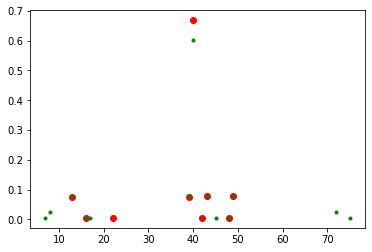

In [240]:
b = []
a = []
for i in range(basis.Ns):
    if (np.abs(psi_var[i])**2>=1e-3):
        b.append(np.abs(psi_var[i])**2)
        a.append(i)
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])**2>=1e-3:
        y.append(np.abs(eigenvectors[:,0][i])**2) 
        x.append(i)
n = []
m = []
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,1][i])**2>=1e-3:
        n.append(np.abs(eigenvectors[:,1][i])**2) 
        m.append(i)
     


        

plt.plot(a,b, "o",color = "r")
plt.plot(x,y, ".",color = "g")
#plt.plot(m,n, "o",color = "b")


In [246]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])**2>=1e-3:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

(-0.03960846510253137+0.26799088357116774j)|2 1 1 1>
(0.01579664286304912-0.07522185191212113j)|2 1 0 1>
(0.015796642863047432-0.07522185191211689j)|2 0 1 1>
(-0.039608465102536176+0.267990883571169j)|1 1 1 2>
(0.2115635059722372-0.7895398944596179j)|1 1 1 1>
(0.015796642863048112-0.0752218519121132j)|1 1 0 2>
(-0.0860951046650502+0.26770384667885594j)|1 1 0 1>
(0.015796642863047862-0.07522185191211483j)|1 0 1 2>
(-0.08609510466505055+0.2677038466788568j)|1 0 1 1>

